## Mathematical Optimization Series

# Part 2: The gradient descent algorithm

In this post we describe our first major mathematical optimization algorithm: *gradient descent*.  Many of the core ideas we have seen with regards random local search - including e.g., steplengths and steplength rules, convergence issues, etc., - we will see carry over almost entirely to the gradient descent scheme.  In fact the only difference - at least at the outset - between gradient descent and the highly innefective random local search (described in the previous post) is that with gradient descent we employ a closed form mathematically garunteed descent direction at each step.  This means that unlike random search, gradient descent scales very nicely with the input dimension of a function, and so can be (and is) used with modern machine learning / deep learning problems.  This post builds our previous discussion of random local search in the previous post, so it is highly recommended that one read the previous post before proceeding.

In [1]:
# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
from mlrefined_libraries import basics_library as baslib
from mlrefined_libraries import calculus_library as callib
from mlrefined_libraries import math_optimization_library as optlib
import autograd.numpy as np

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

The new outline:
    
    1.  Go back to the fundamentals, use the notion of a first order approximation
    2.  If we do this, we have already seen the downward direction on a hyperplaen
    3.  It makes sense to use this as a unit step, so we normalize the direction
    4.  Steplength rules - here we can be a little more specific, that because this is much more structured than say random local search, we can in fact derive steplength values that will garuntee convergence to a 
    4.  The normalzied gradient descent algorithm
    5.  The formal perspective on 

# 1. The gradient descent algorithm

In this Section we describe the basic *gradient descent* algorithm, in fact we describe its two fundamental forms.  Both forms follow the overall structure of a *local search algorithm* as we detailed when discussing random local search in the previous post.  By that we mean, that as a local search algorithm gradient descent consists of an initialization $\mathbf{w}^0$ followed by taking number of steps $\mathbf{w}^1, \mathbf{w}^2, \mathbf{w}^3,...,\mathbf{w}^{K}$ of the general form 

$$
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} + \alpha \mathbf{d}^{\,k}
$$

where $\mathbf{d}^{\,k}$ is a unit-length direction (preferrably one that provides descent in the function), and $\alpha$ is called a steplength that controls the length of each step, i.e.,

$$
\Vert \mathbf{w}^{\,k} - \mathbf{w}^{\,k-1} \Vert_2 = \alpha 
$$

As we saw in the previous post, these steplengths can be fixed for all steps of the run or can change at each step e.g., the diminishing steplength at step $k$ given as $\alpha = \frac{1}{k}$.

With gradient descent we do not randomly seek out a direction at each step, but use a fundamental fact from calculus: the tangent hyperplane (or first order Taylor Series approximation) of function $g$ at a point $\mathbf{w}^k$ has a natural direction of steepest descent defined by the negative gradient $-\nabla g\left(\mathbf{w}^0\right)$, and since the hyperplane closely resembles $g$ near $\mathbf{w}^0$ we this direction provides descent in the function (at least locally) as well.

#  1.2  Leveraging the descent direction of tangent hyperplanes

In our series on the *Vital Elements of Calculus* we saw an important interpretation of the derivative, or more generally the gradient, of a function $g(\mathbf{w})$: at a given point $\mathbf{w}^0$: the gradient $\nabla g\left(\mathbf{w}^0\right)$ provides the direction of steepest *ascent* of the tangent hyperplane of $g$ at this point.  This is the direction in which the hyperplane increases the fastest and - because it so closely mimics the function $g$ near the input point $\mathbf{w}^0$ - the direction in which $g$ increases rapidly near $\mathbf{w}^0$ as well.  Likewise the negative gradient $-\nabla g\left(\mathbf{w}^0\right)$ defines the steepest *descent* direction here, that is the direction in which the hyperplane *decreases* the fastest and -  because it so closely mimics the function $g$ near the input point $\mathbf{w}^0$ - the direction in which $g$ *decreases* rapidly near $\mathbf{w}^0$ as well.  

We illustrated this fact by plotting several examples, like the one we repeat below of the simple quadratic $g(w) = 0.4w^2 + 1.5$.  The next Python cell plots this function in black along with an point of tangency $(w^0,g\left(w^0\right))$ and the tangent line there in green.  The slope of this line - i.e., the derivative $\frac{\mathrm{d}}{\mathrm{d}w}g\left(w^0\right)$ a.k.a. the *ascent direction* - is shown as a black arrow along the horizontal axis with direction and magnitude given by $\frac{\mathrm{d}}{\mathrm{d}w}g\left(w^0\right)$.  The *descent* direction given by $-\frac{\mathrm{d}}{\mathrm{d}w}g\left(w^0\right)$ is likewise shown as a red arrow along the horizontal axis.  

Using the slider widget below the image you can move the point $w^0$ back and forth across a short range of the input domain for this function and the ascent / descent directions provided by the derivative there.  Notice how at each input point the *descent direction* directs us towards the global minimum of the function at $w = 0$.  If we imagine repeatedly using it as the direction to move in a local method it seems apparent that it could - if we choose the steplength correctly - certainly lead us to a point near the global minimum of the function.


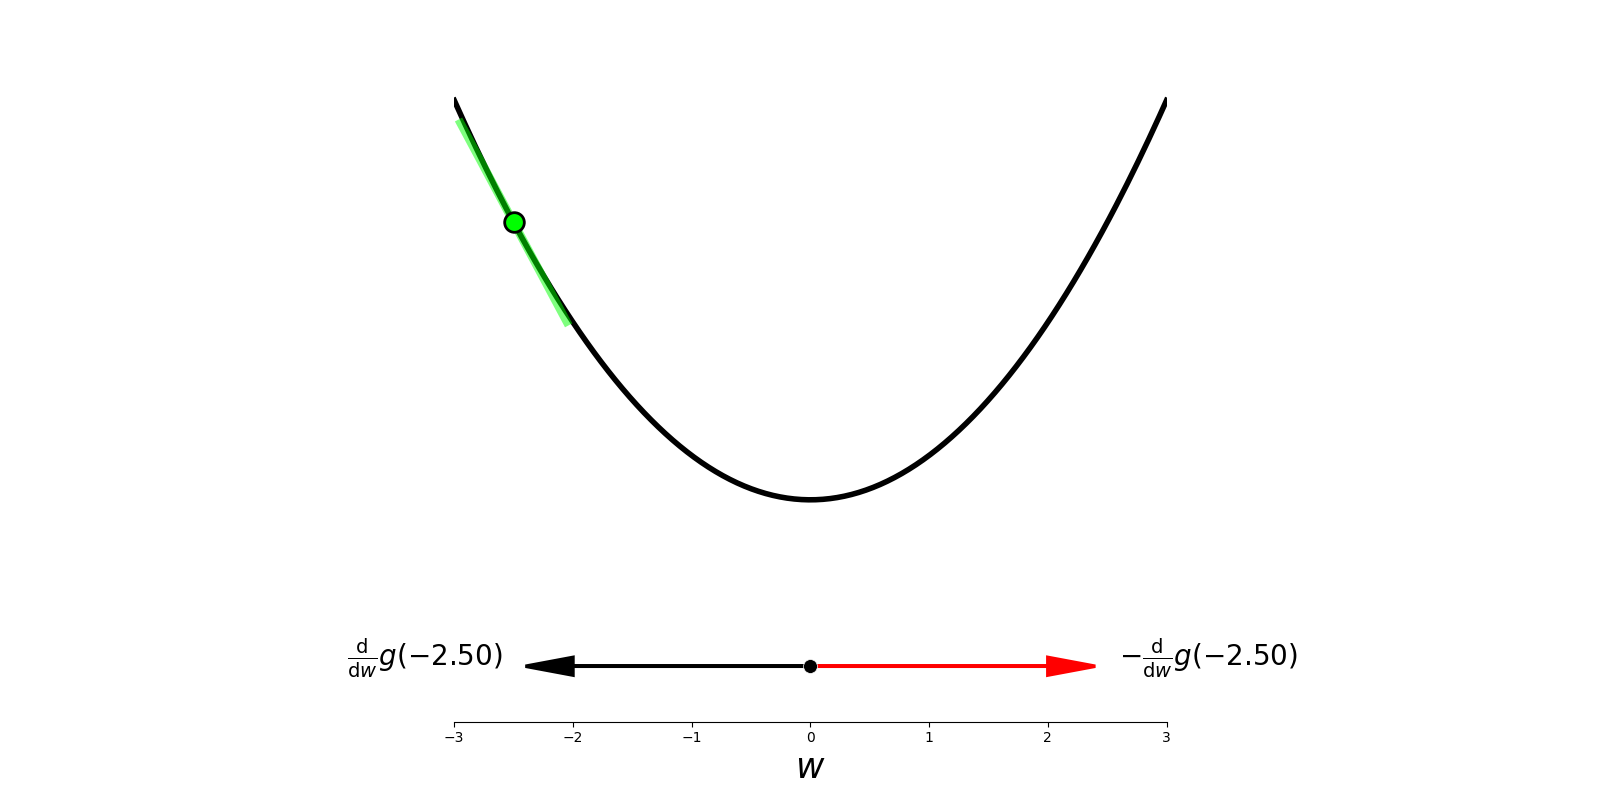
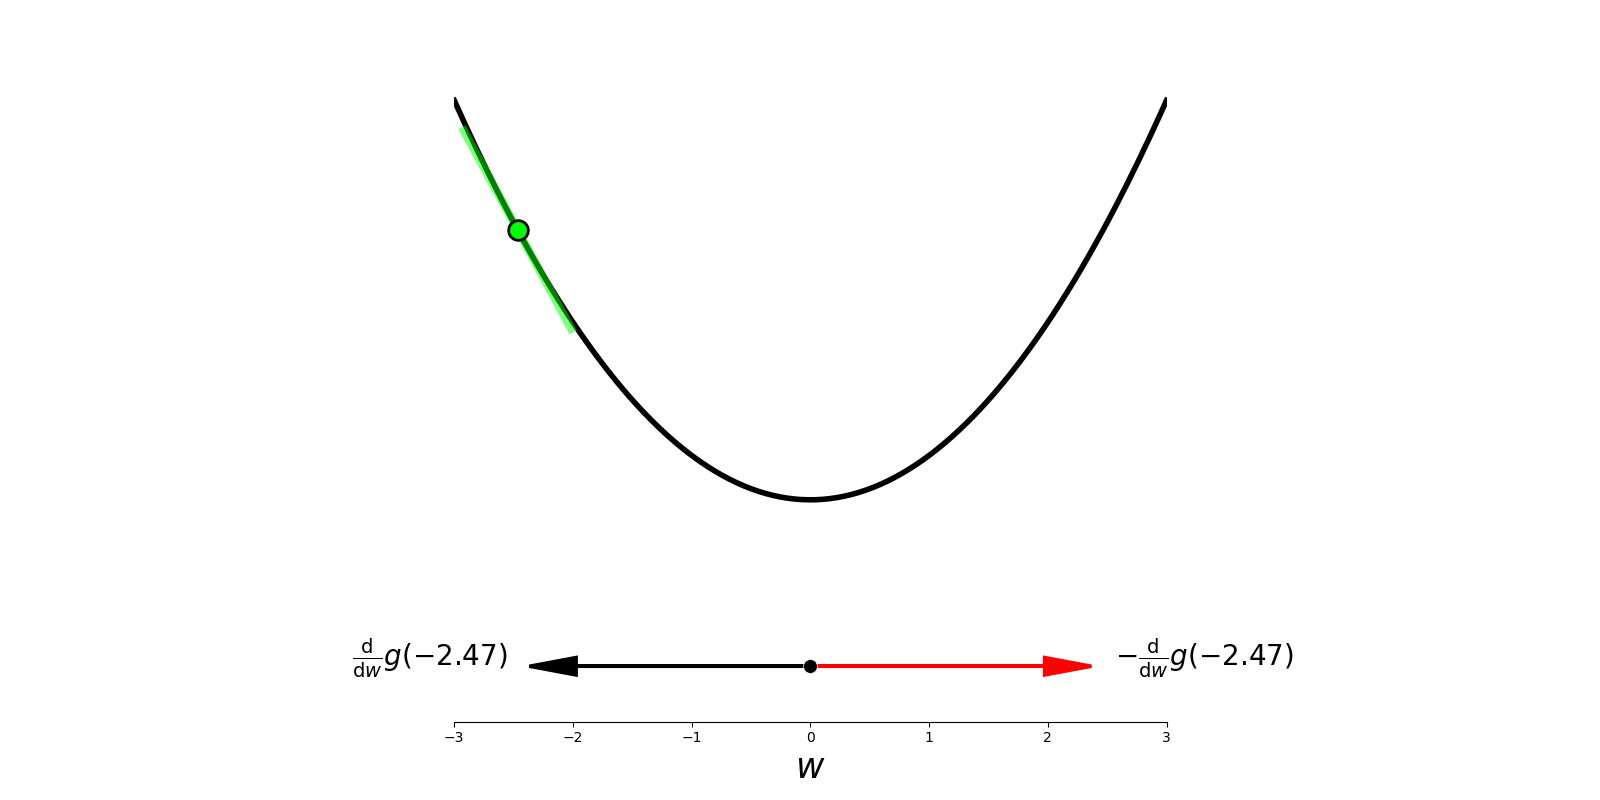
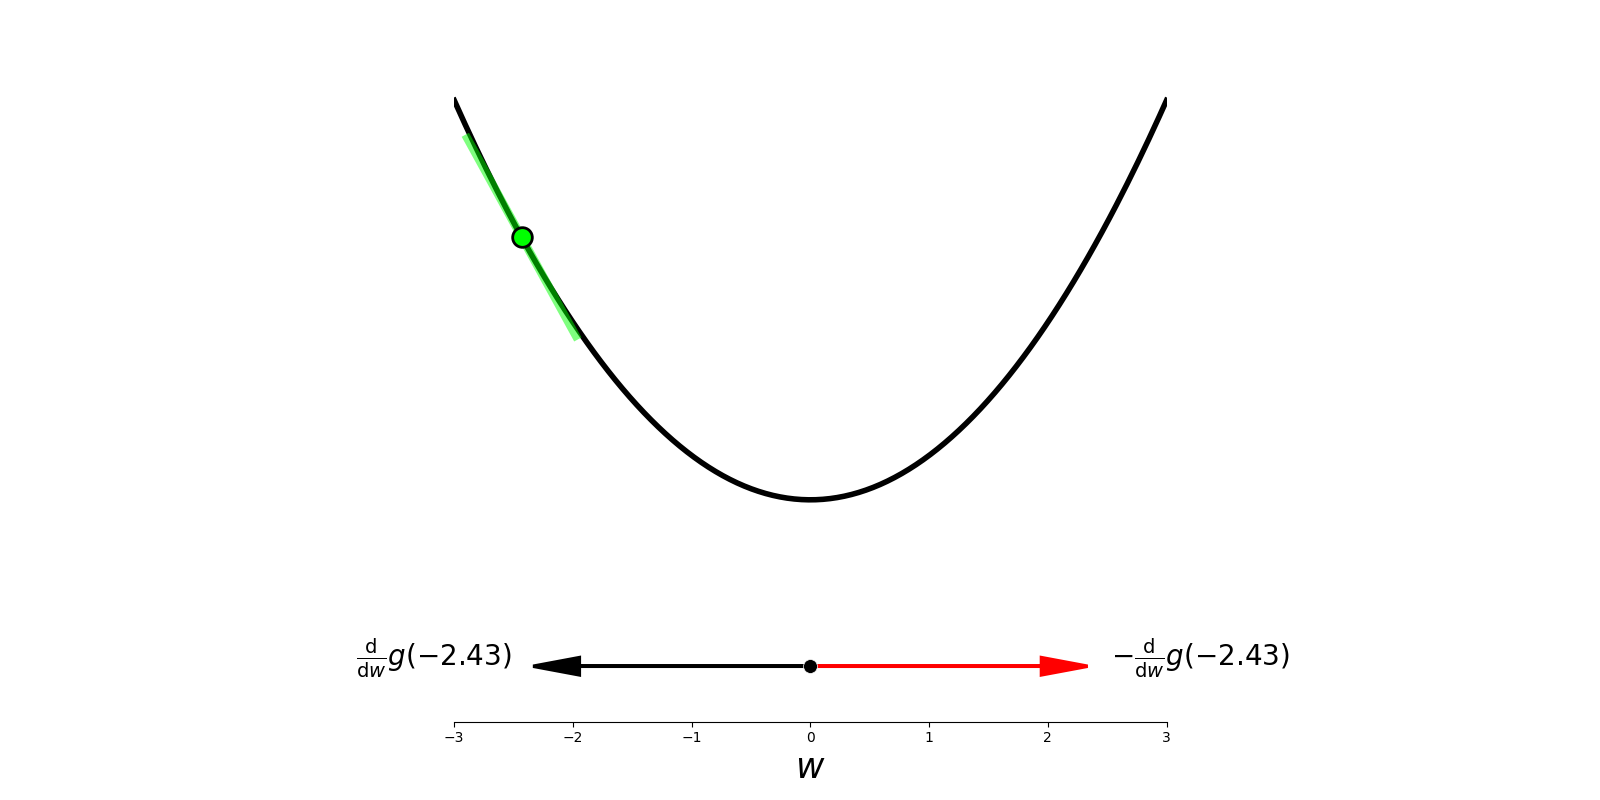
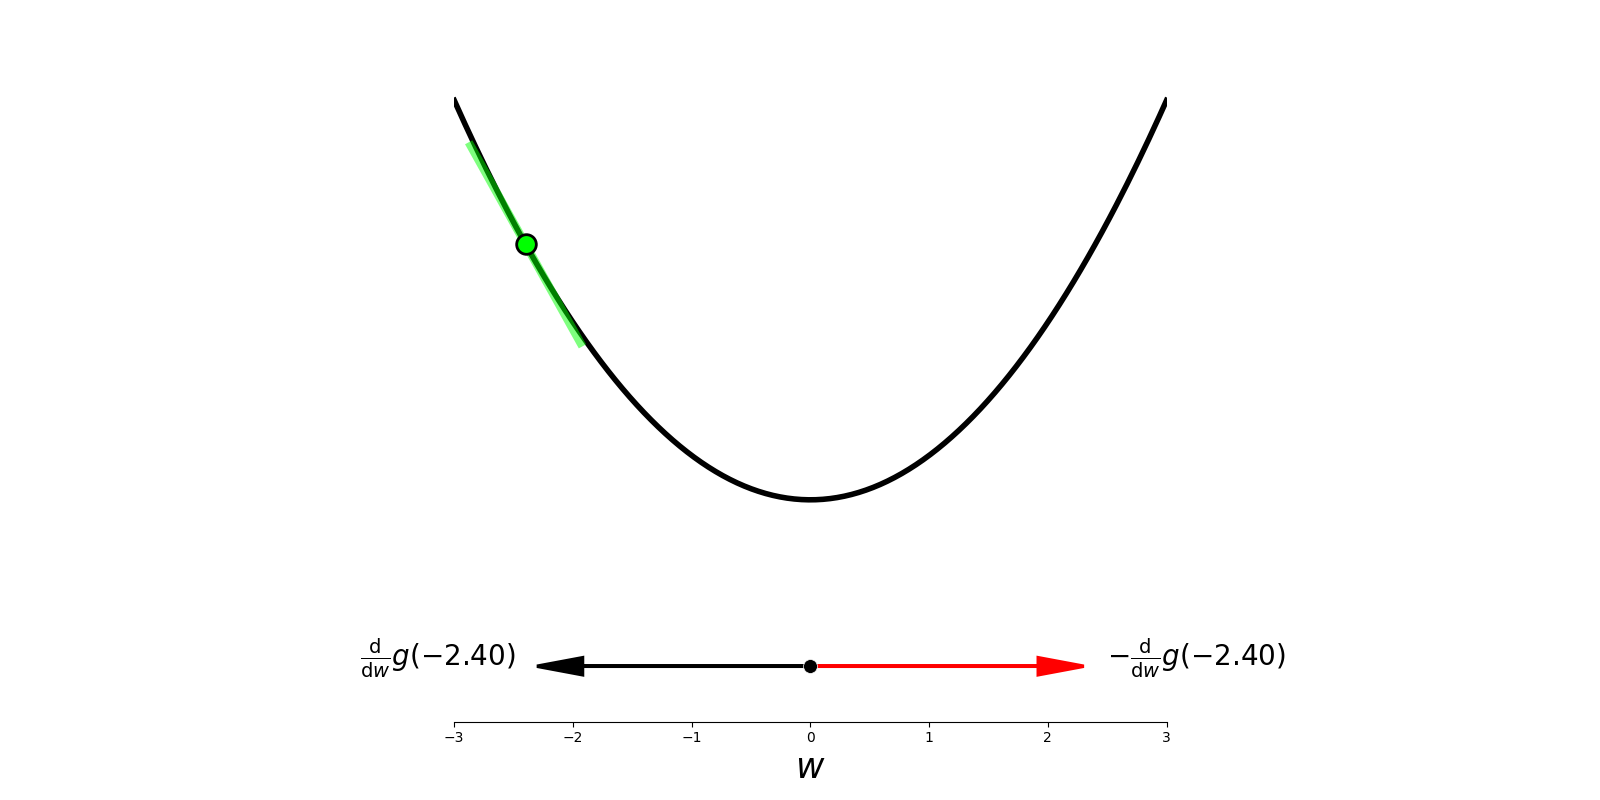
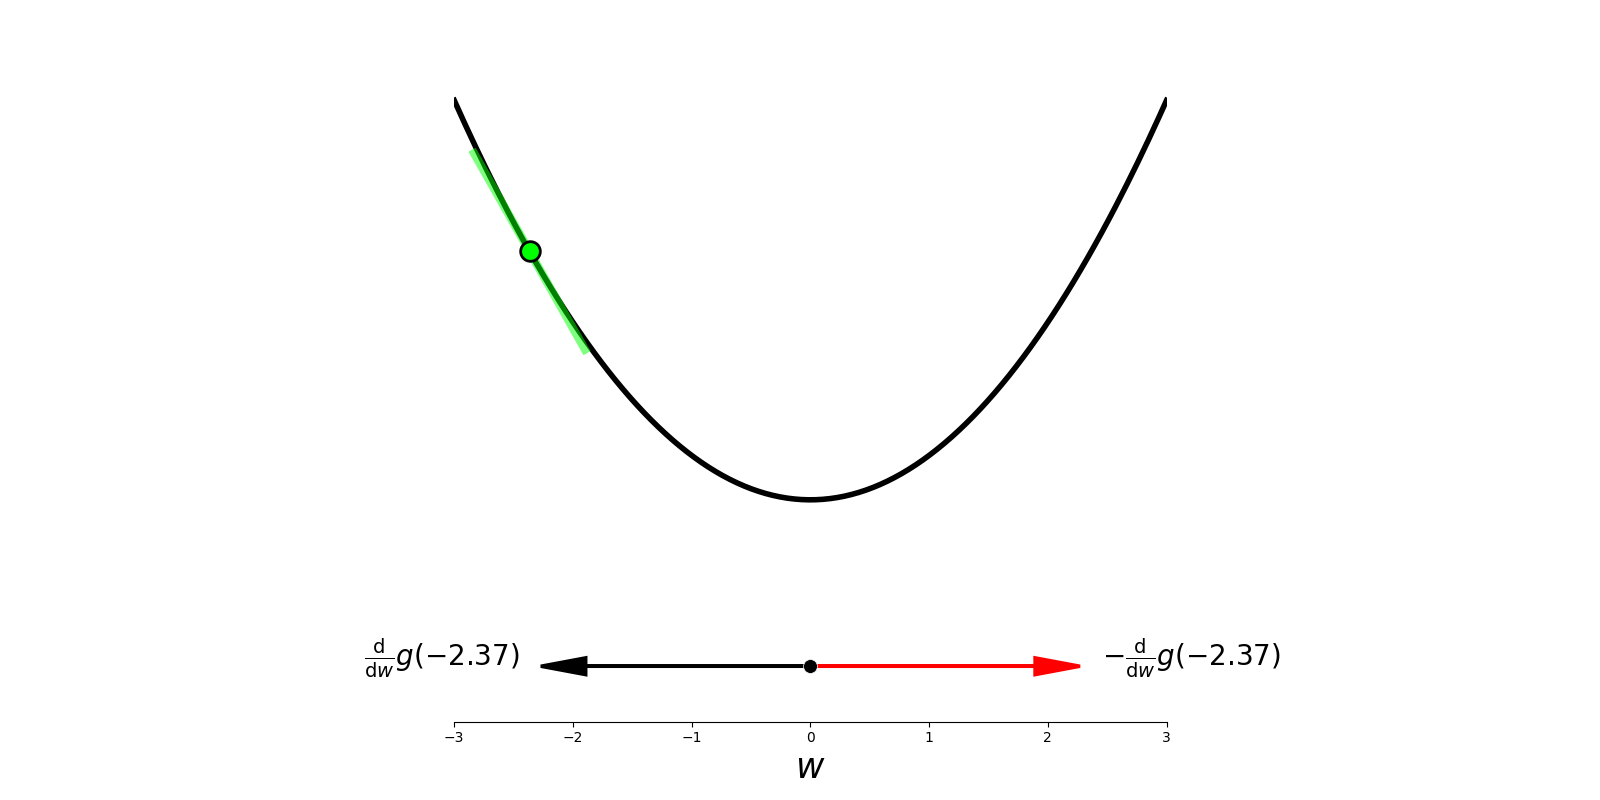
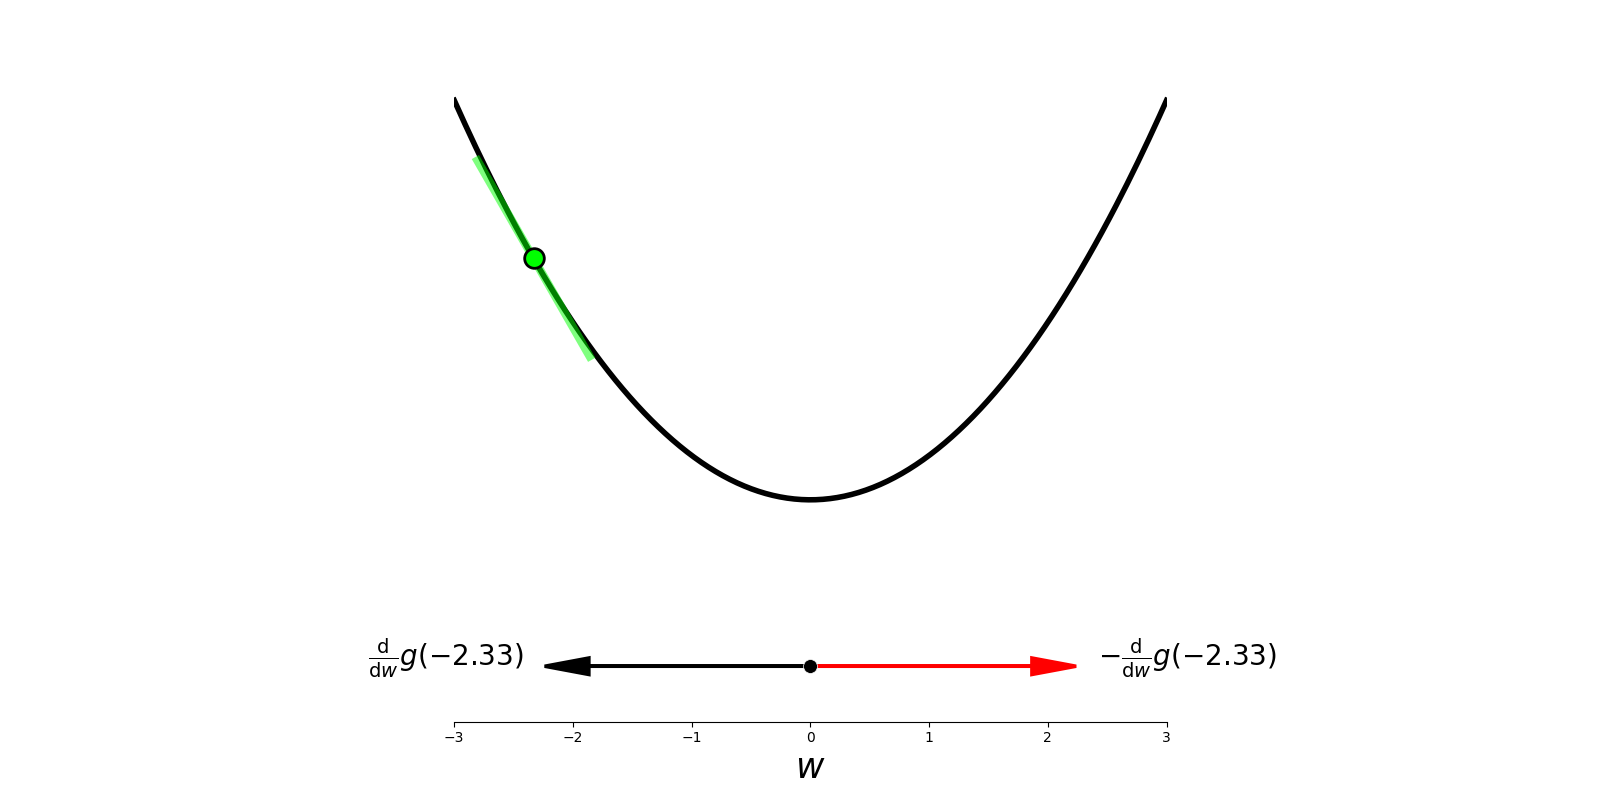
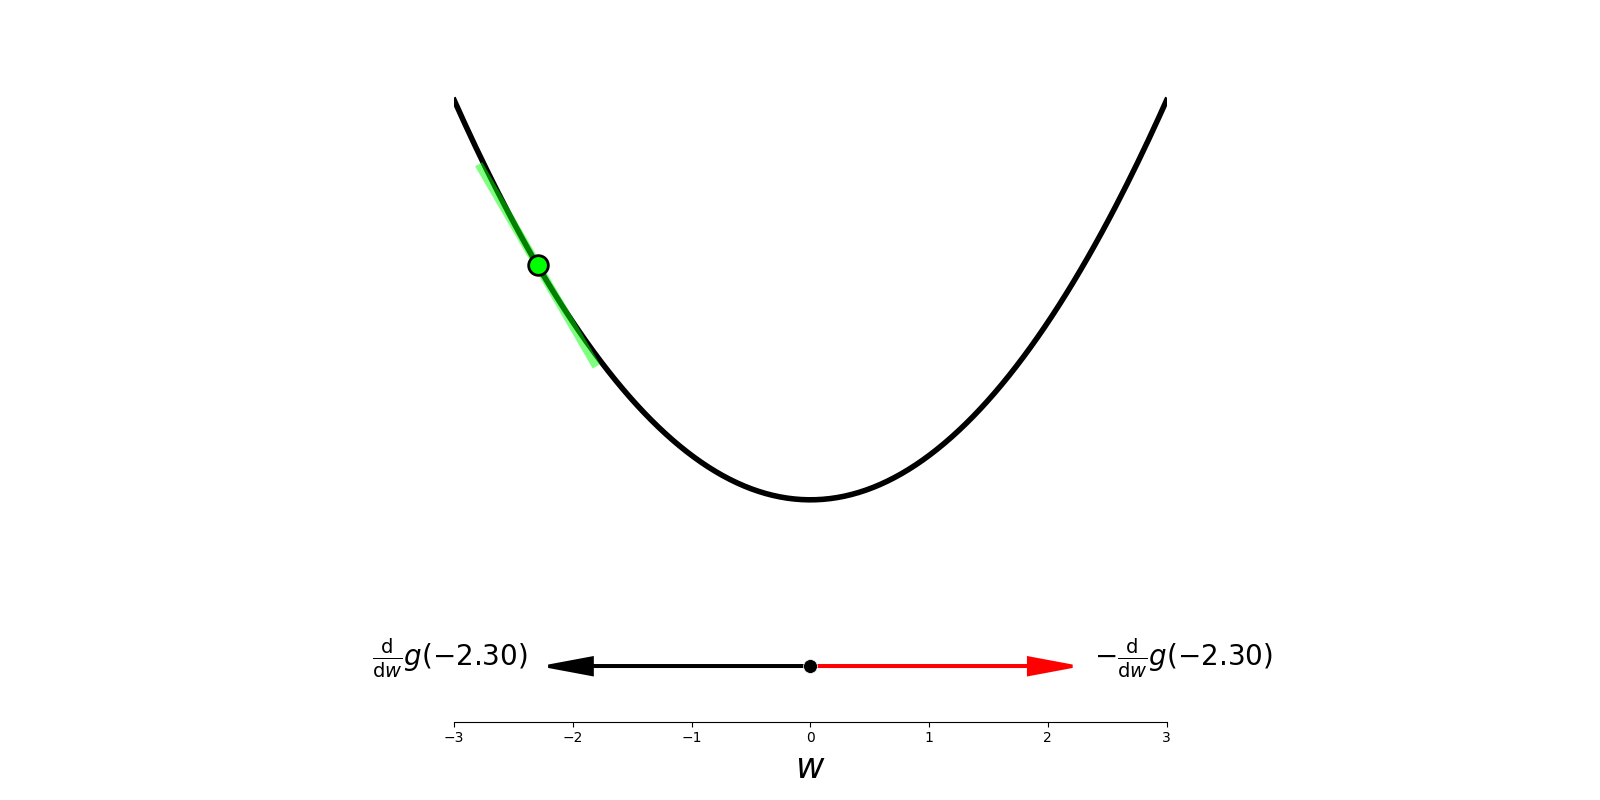
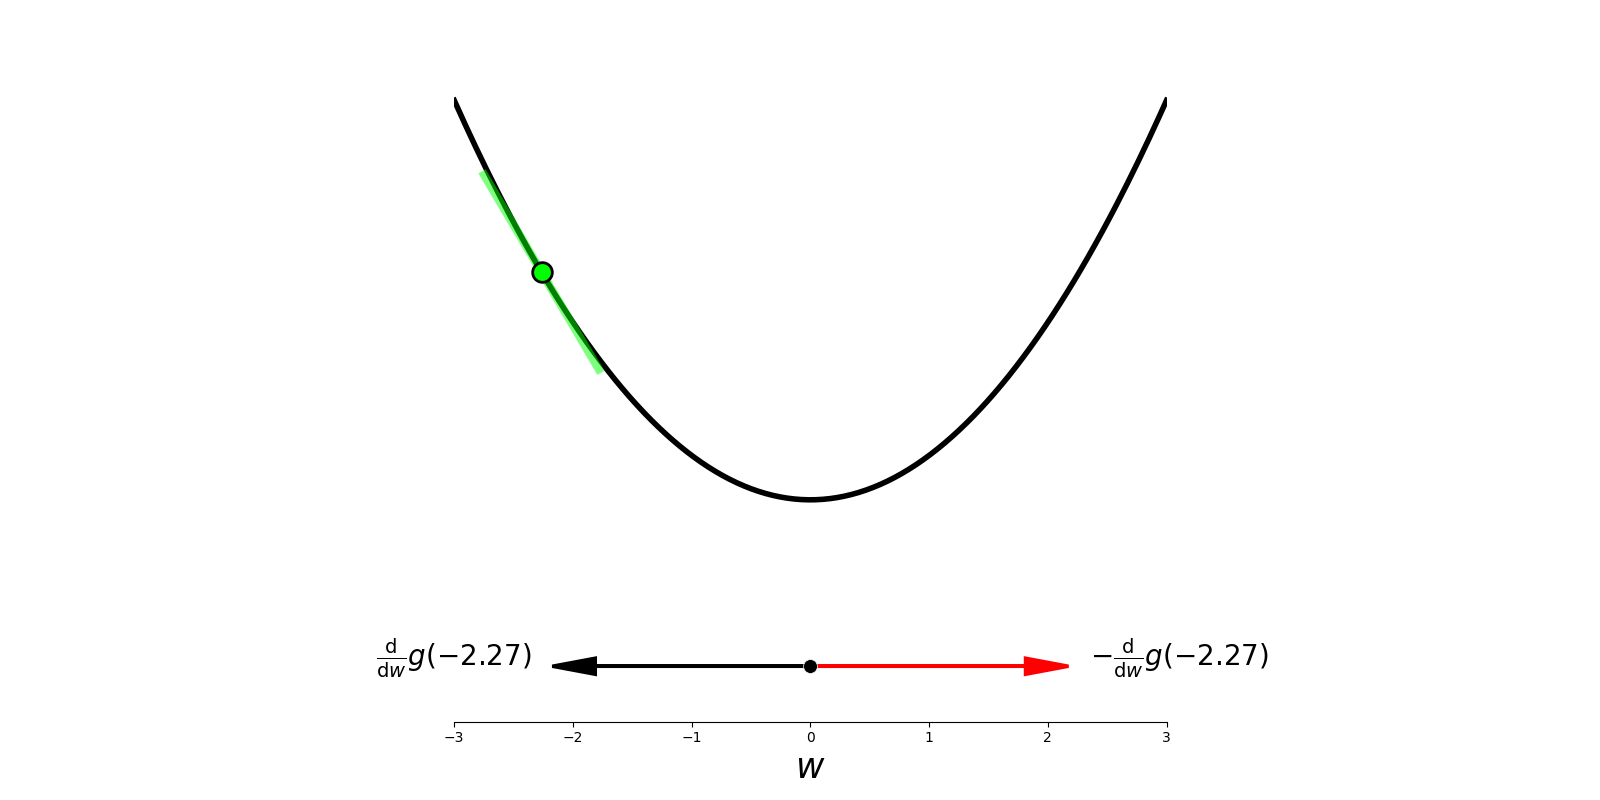
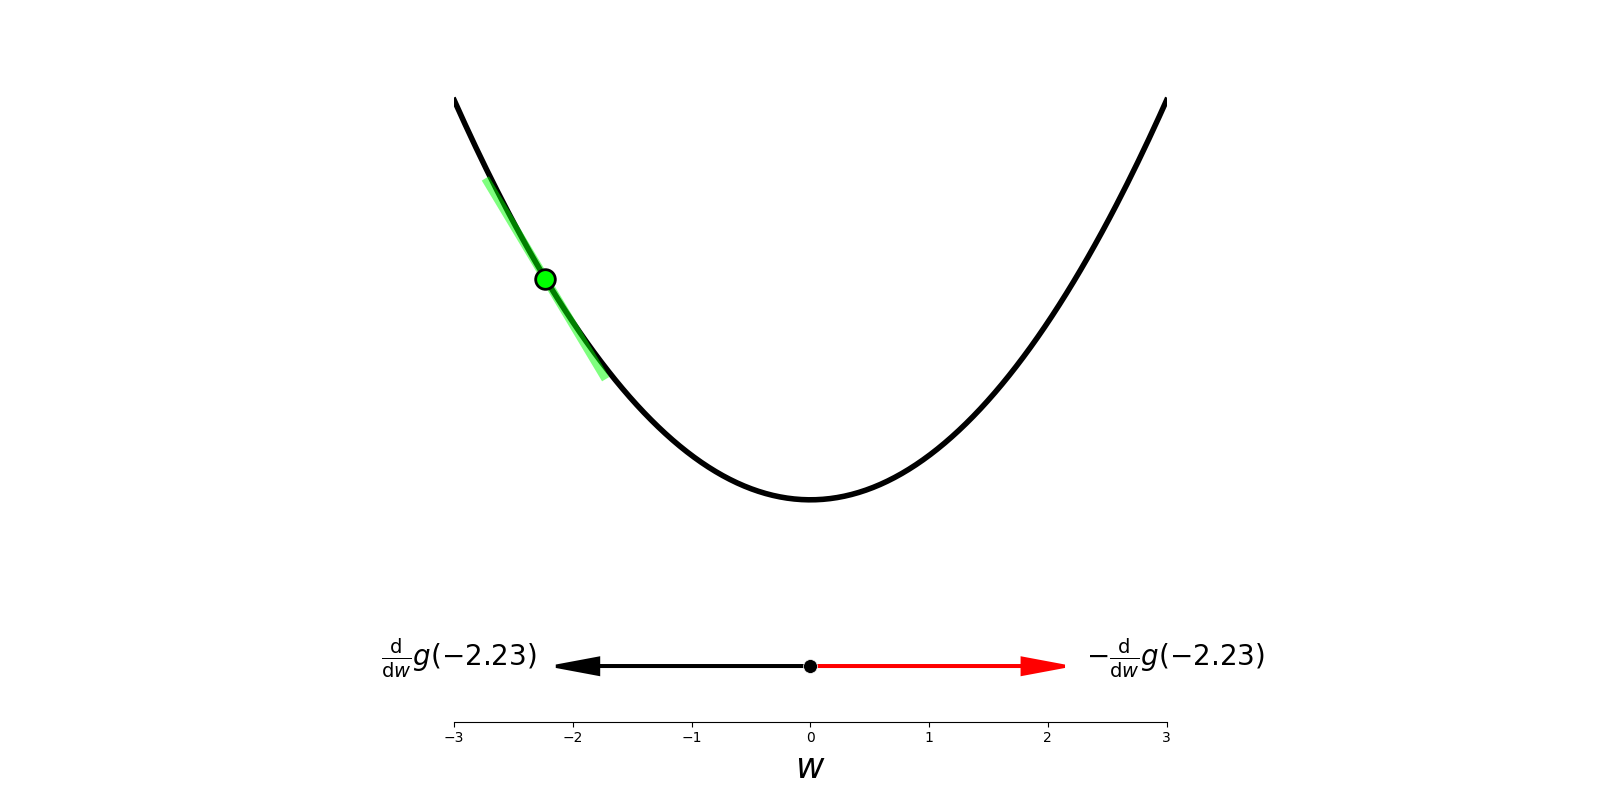
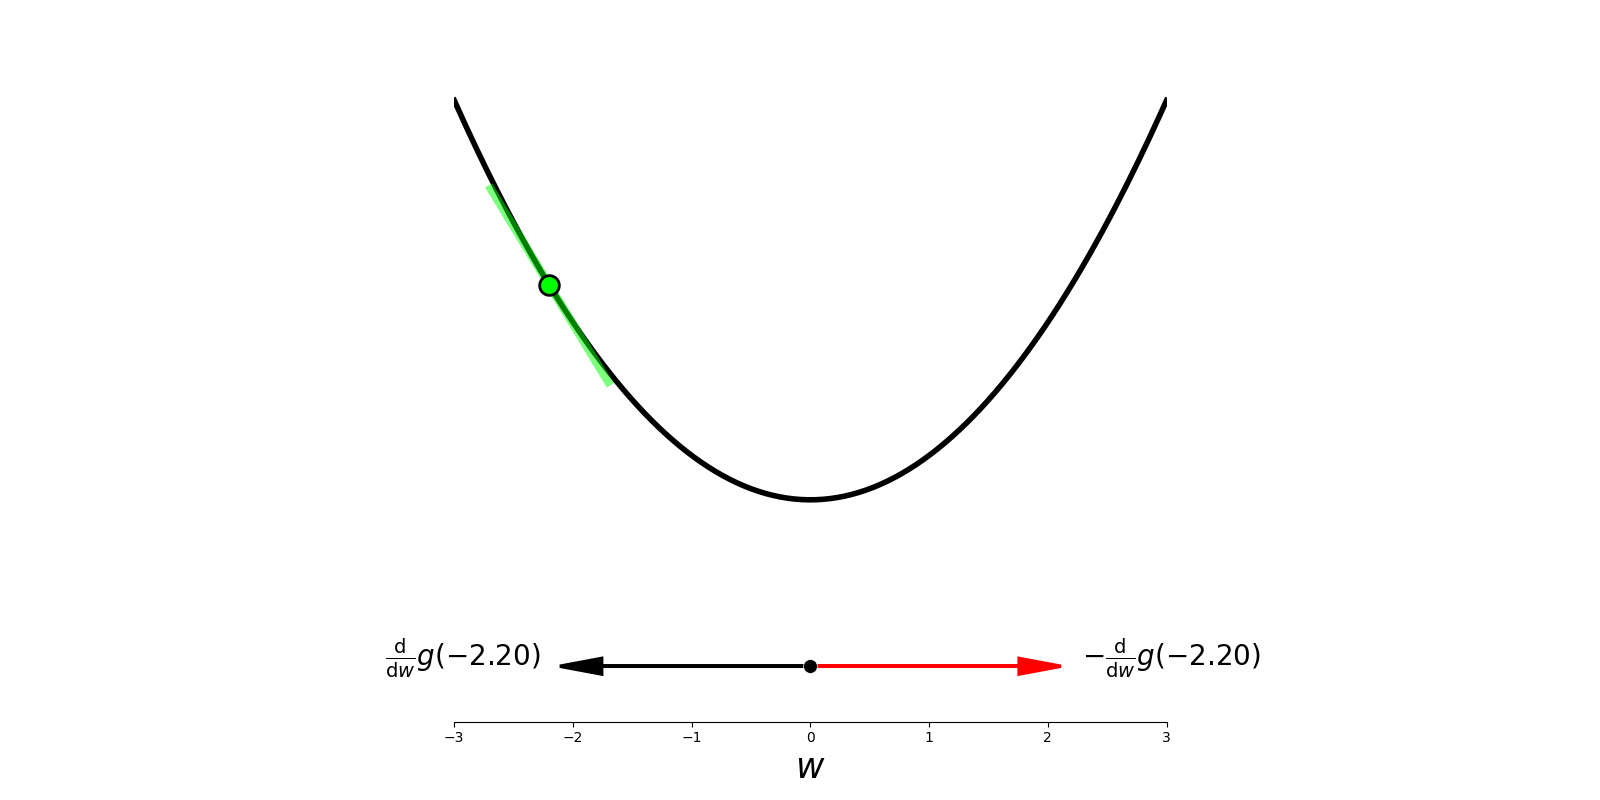
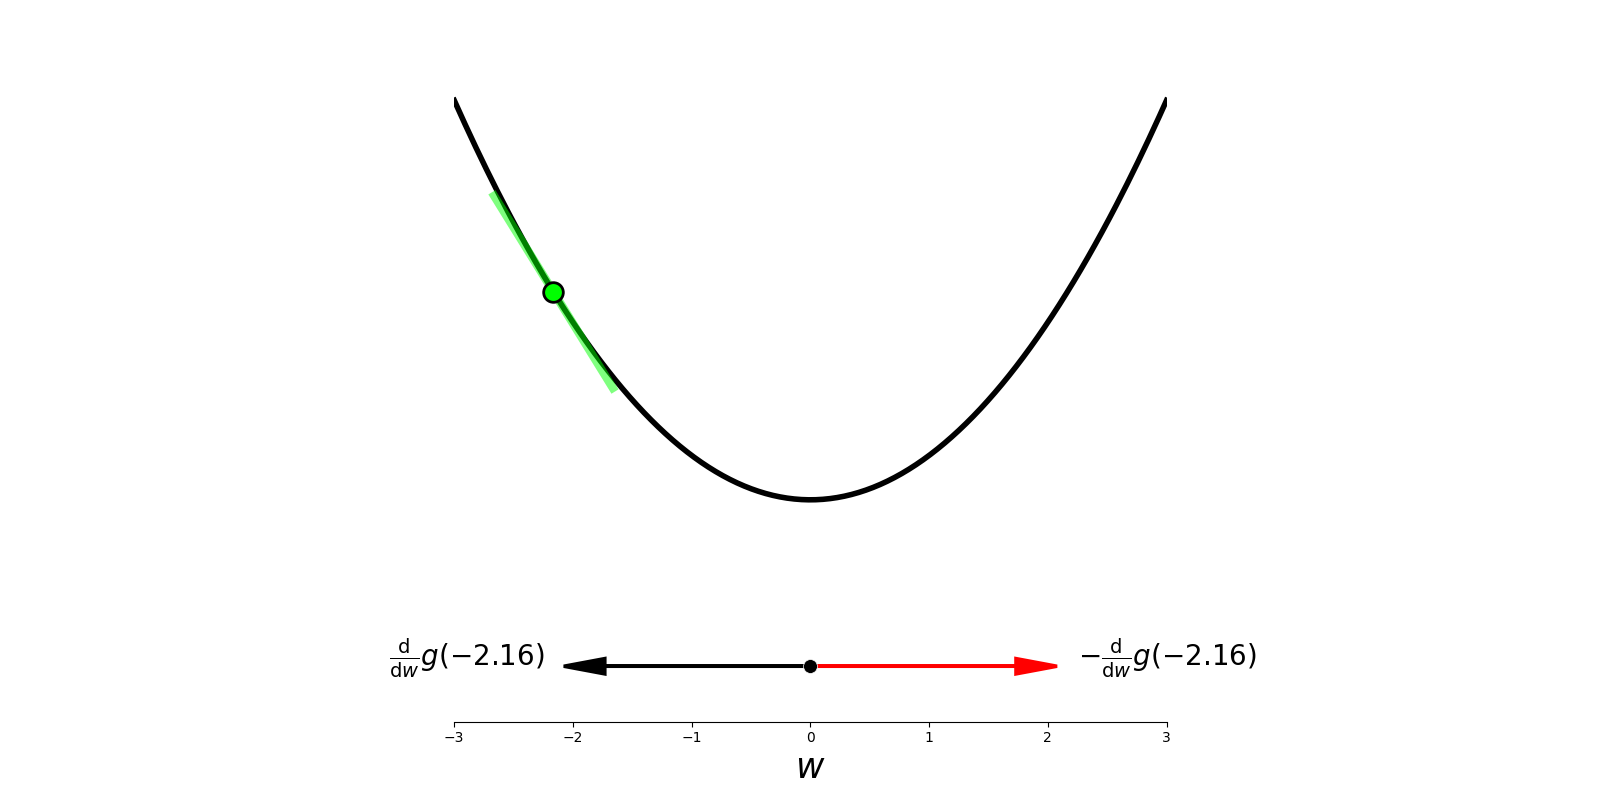
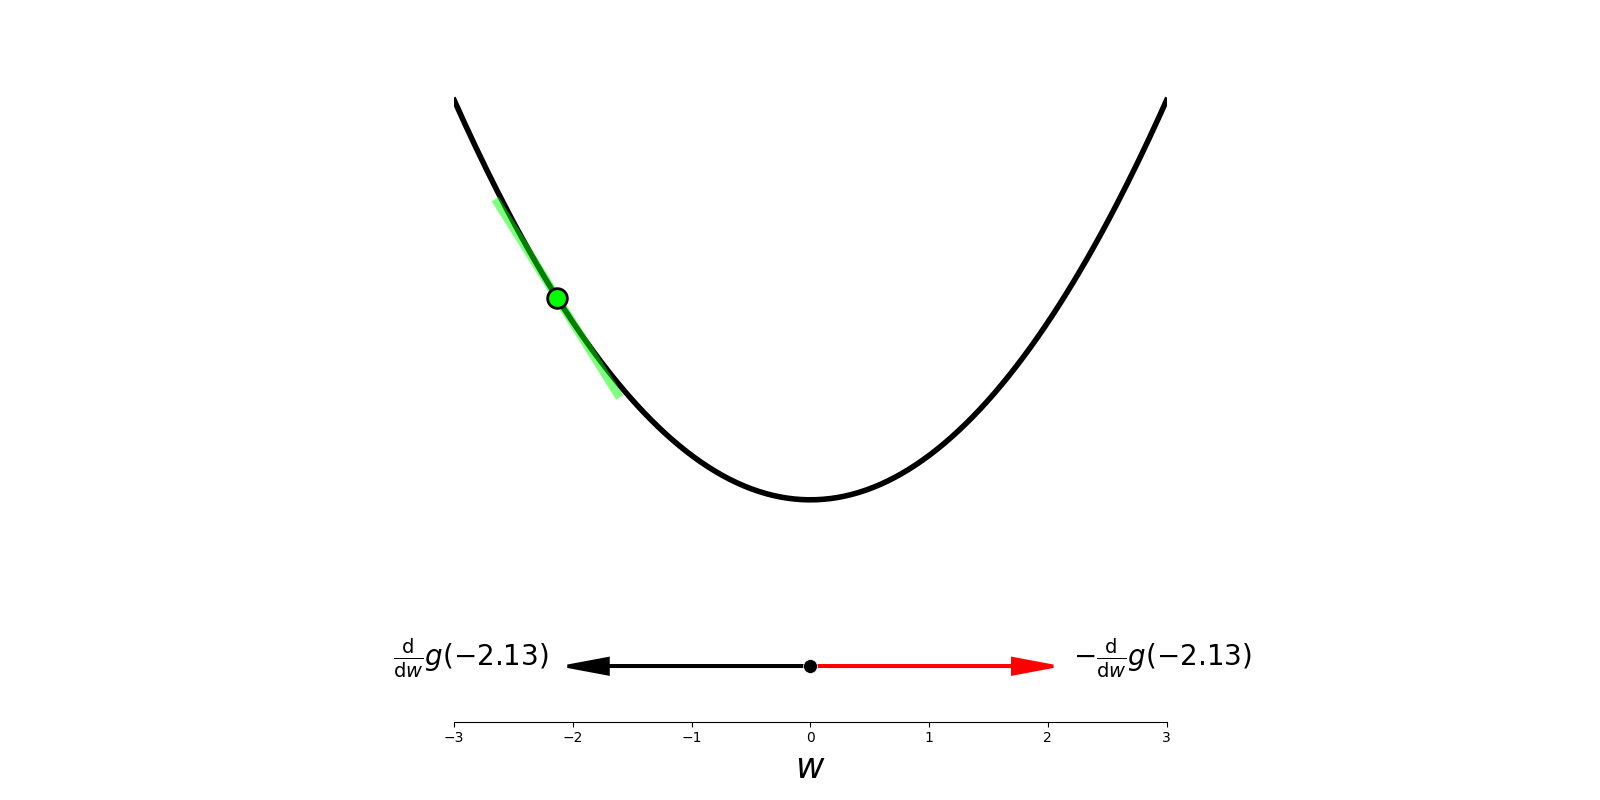
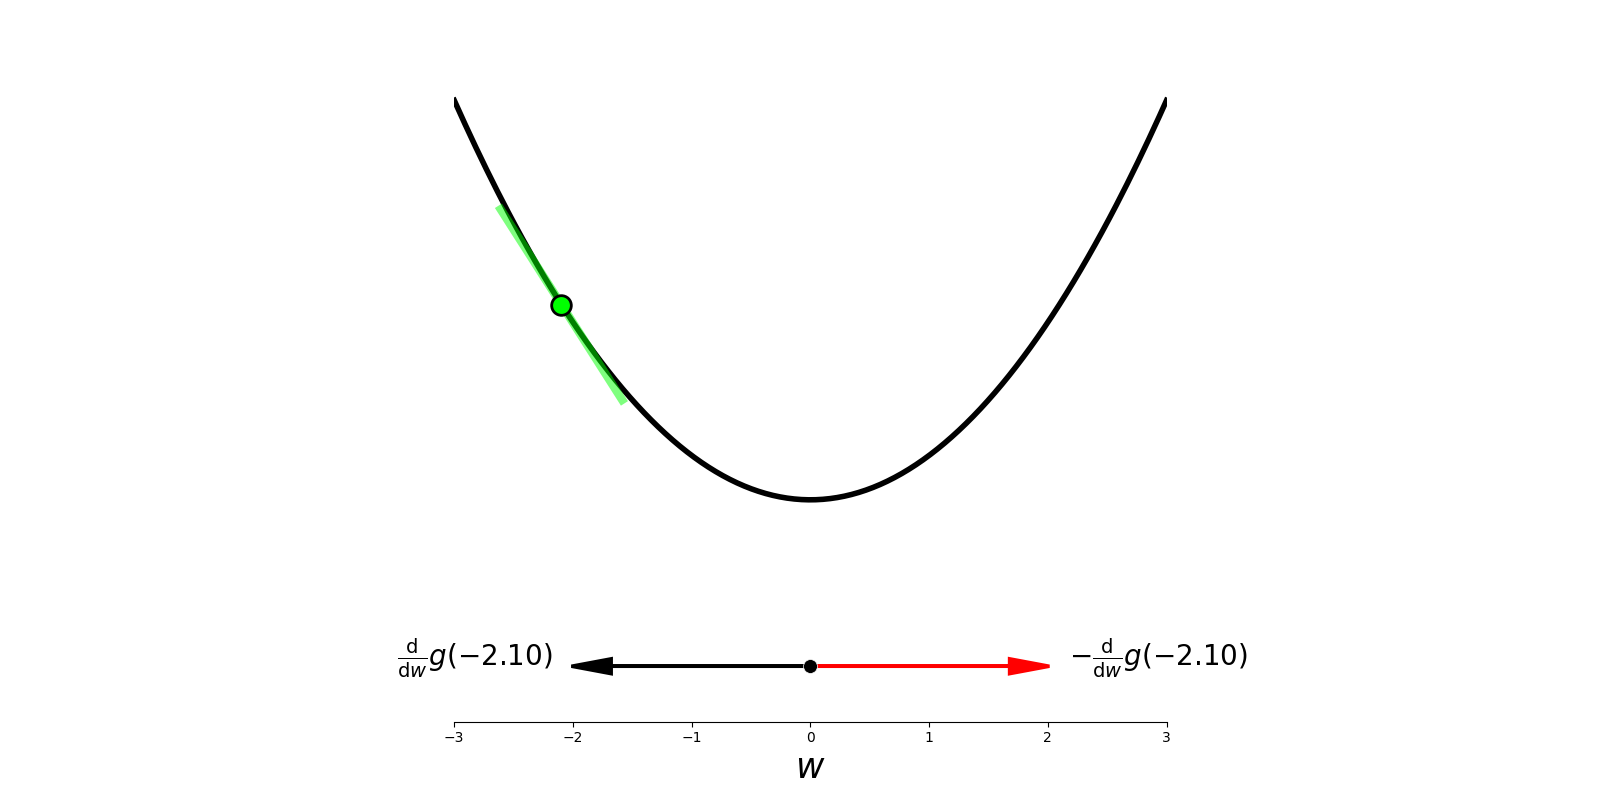
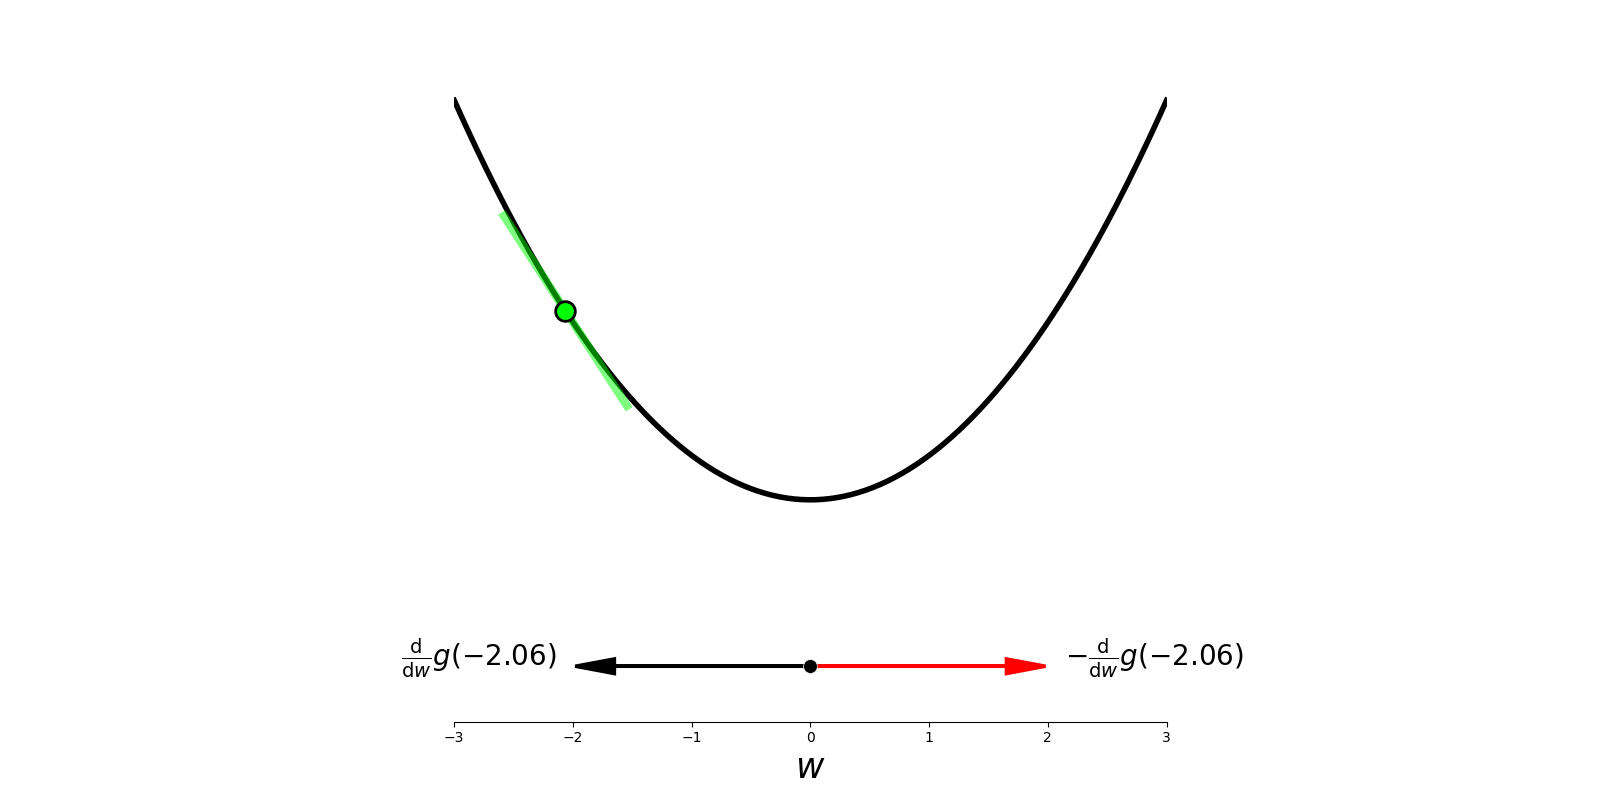
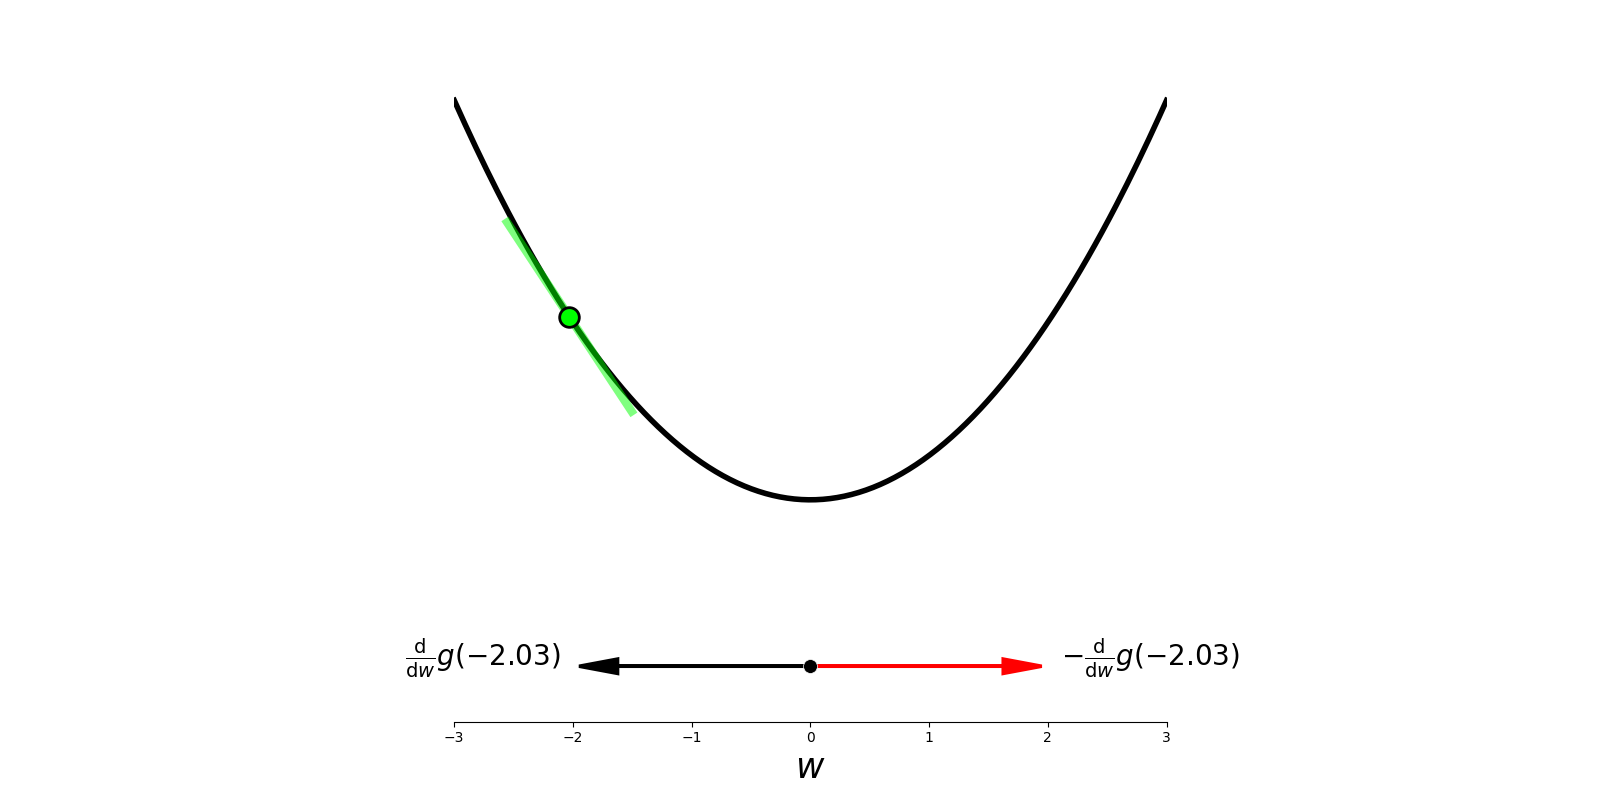
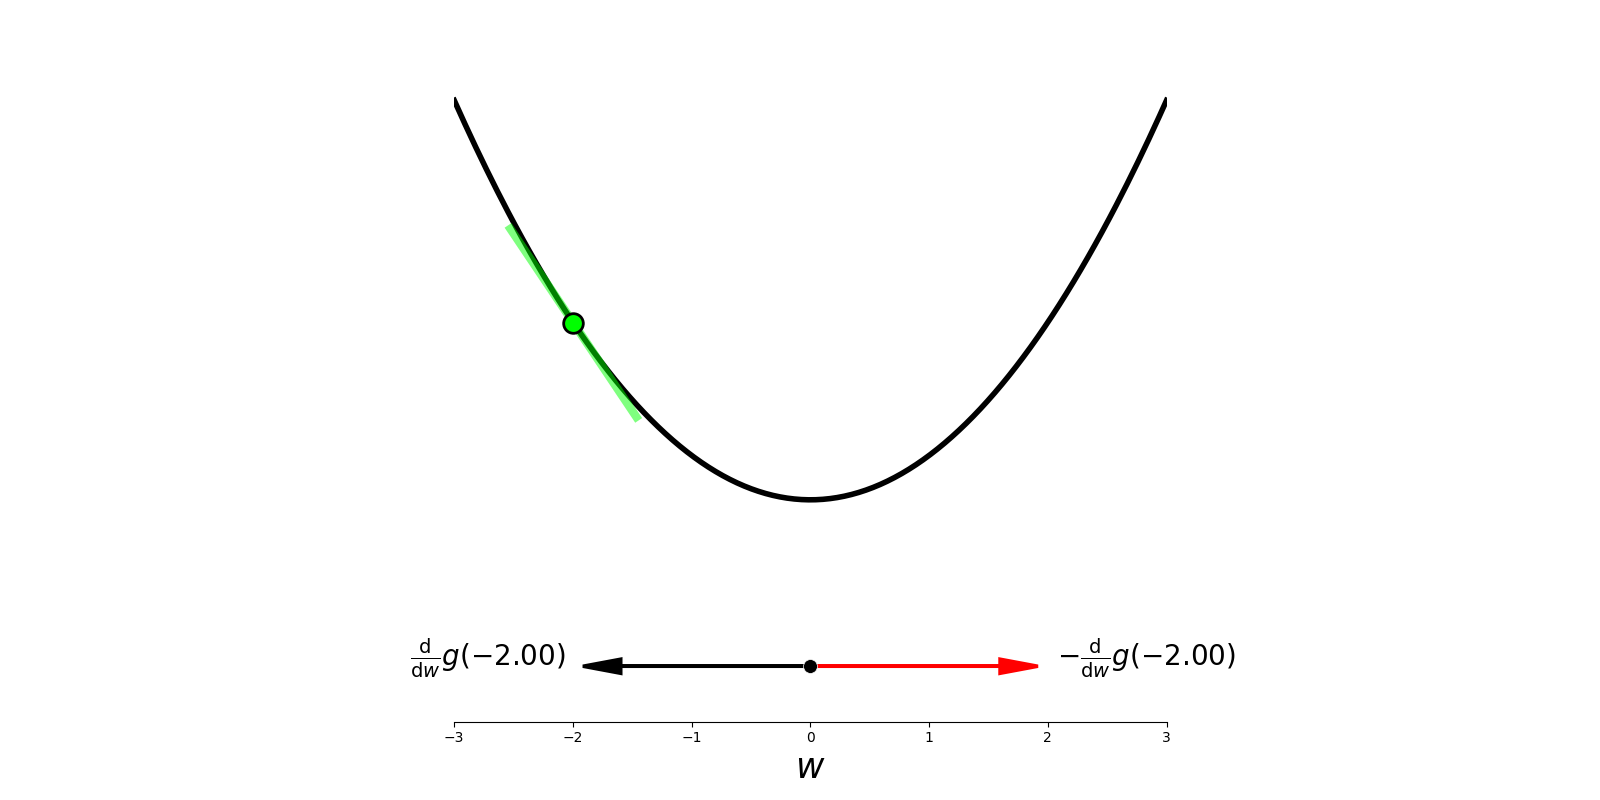
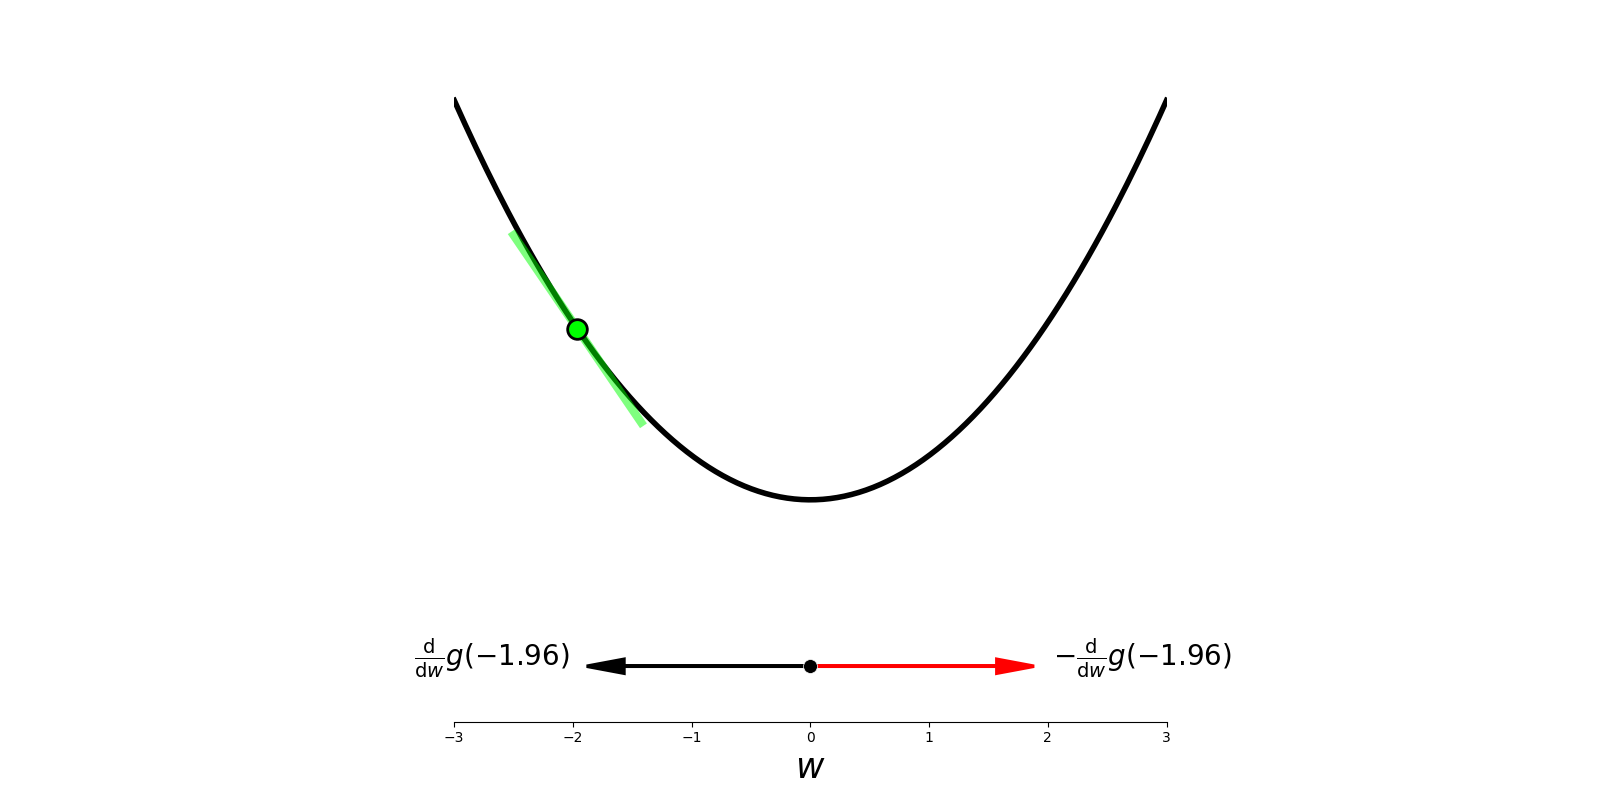
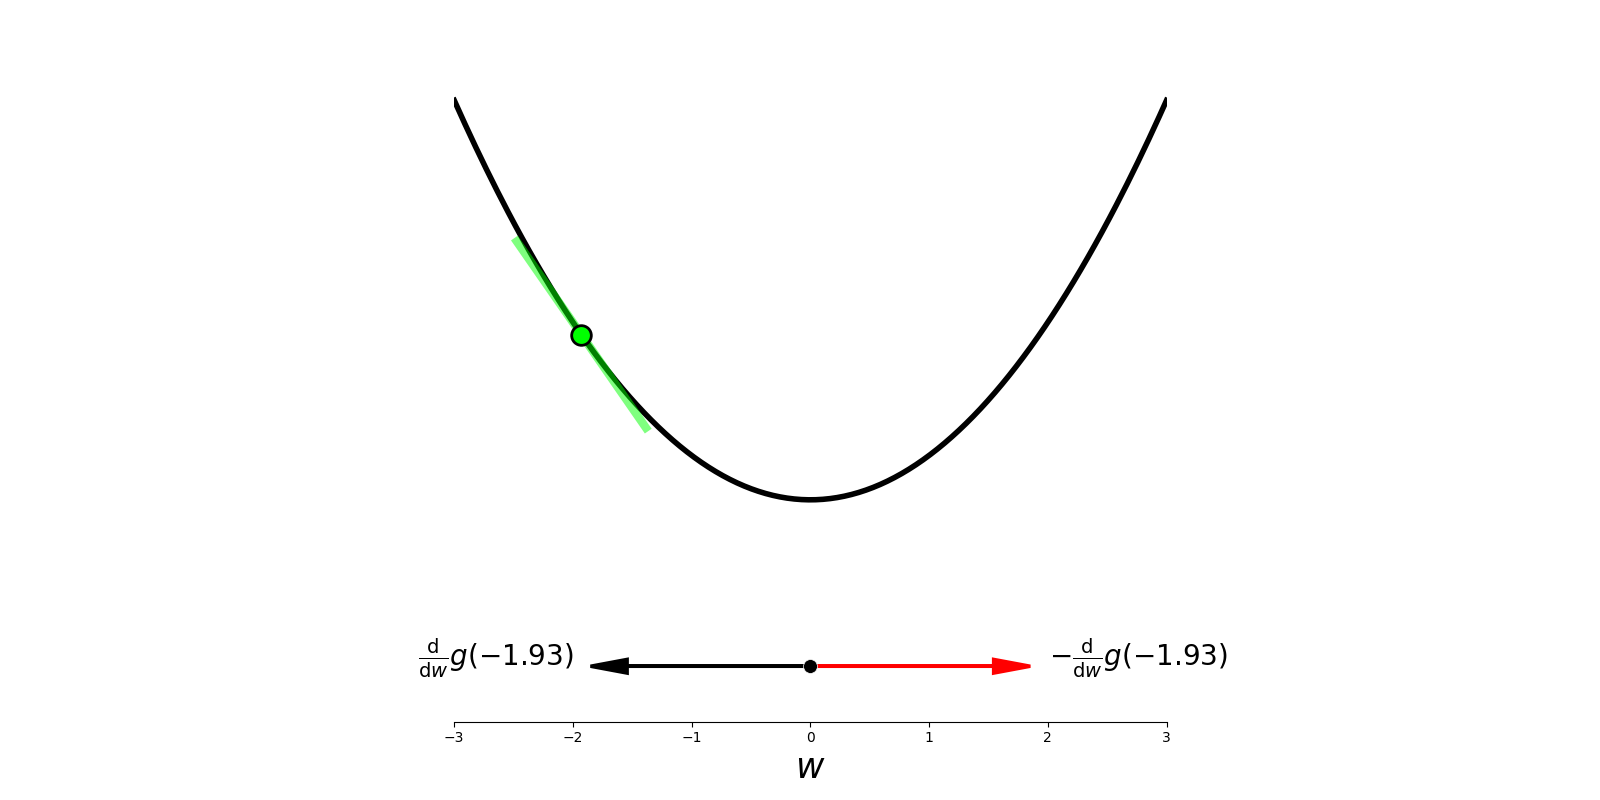
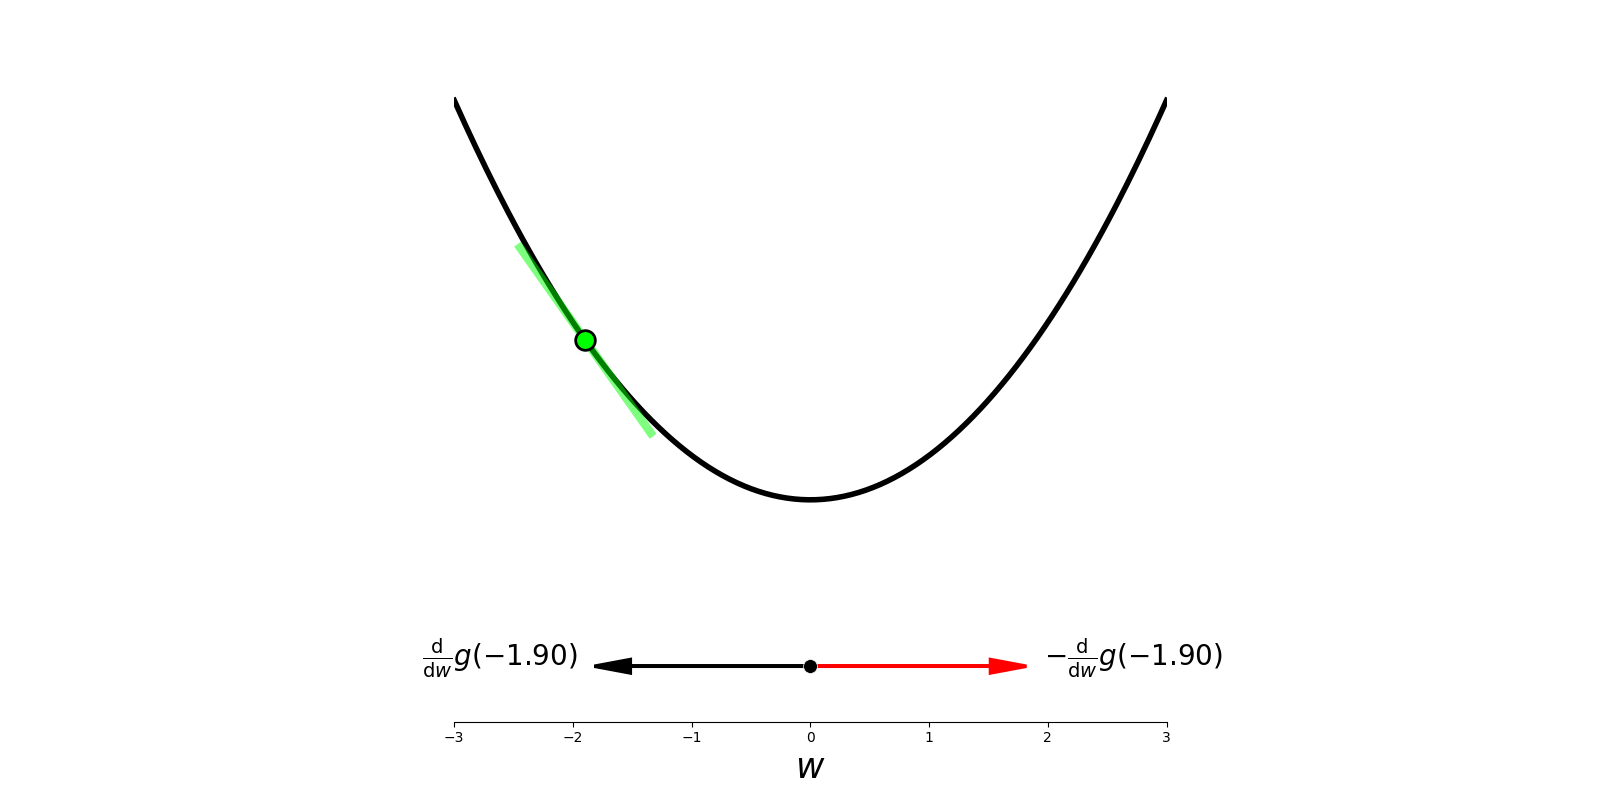
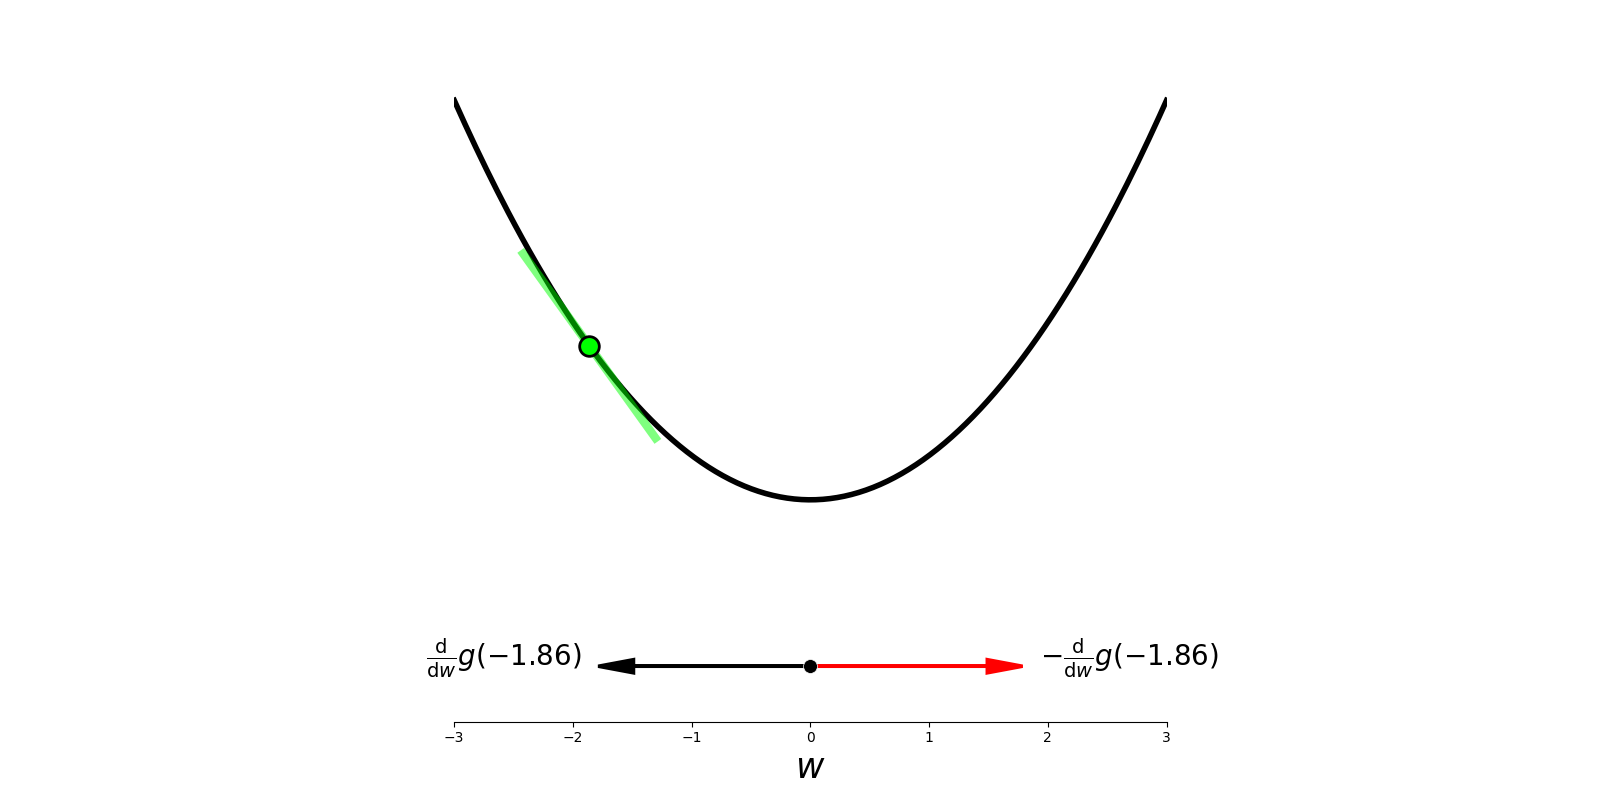
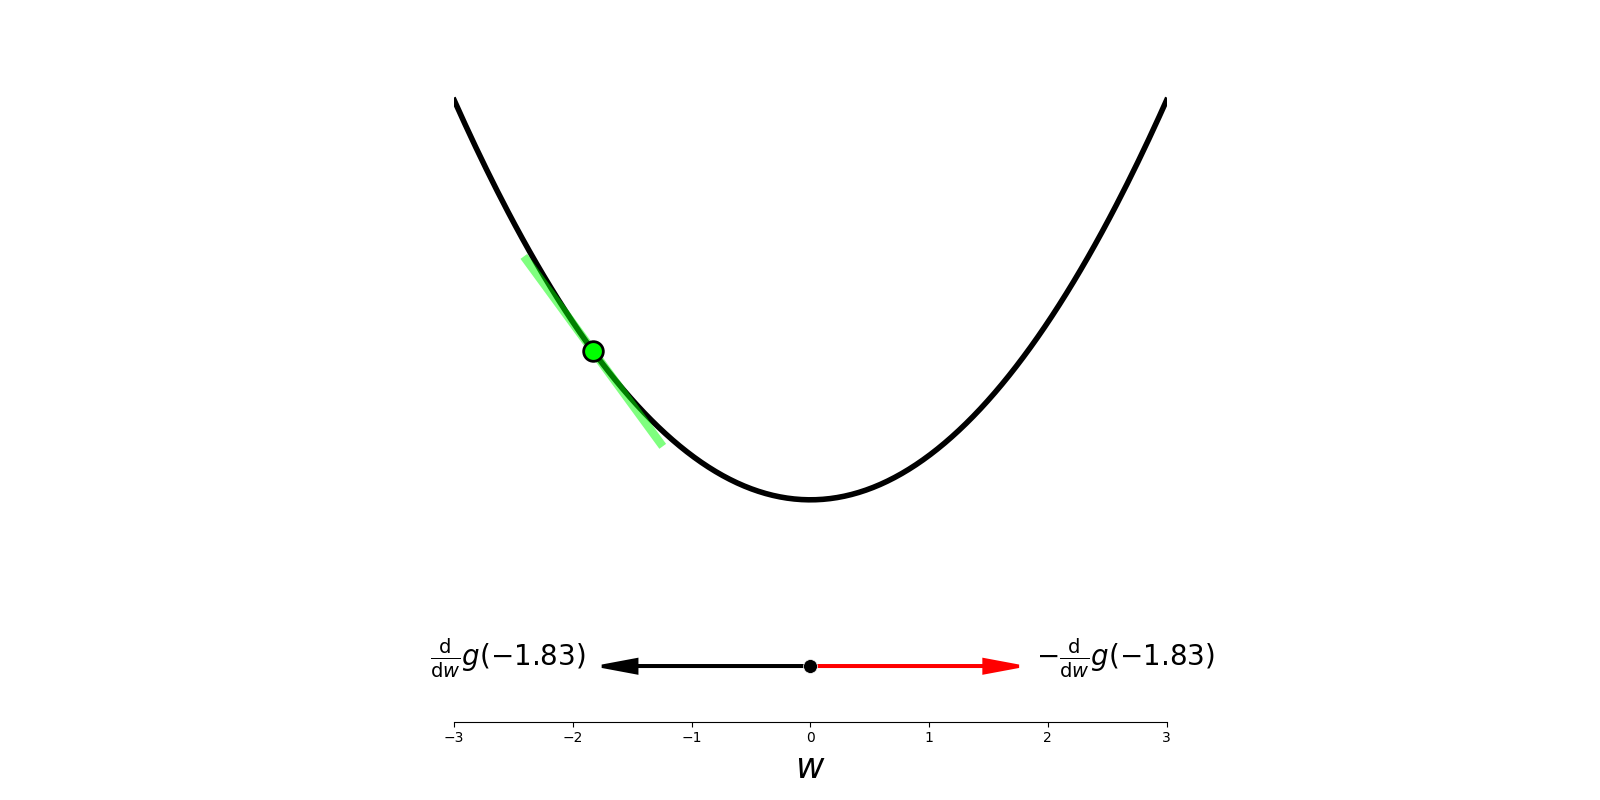
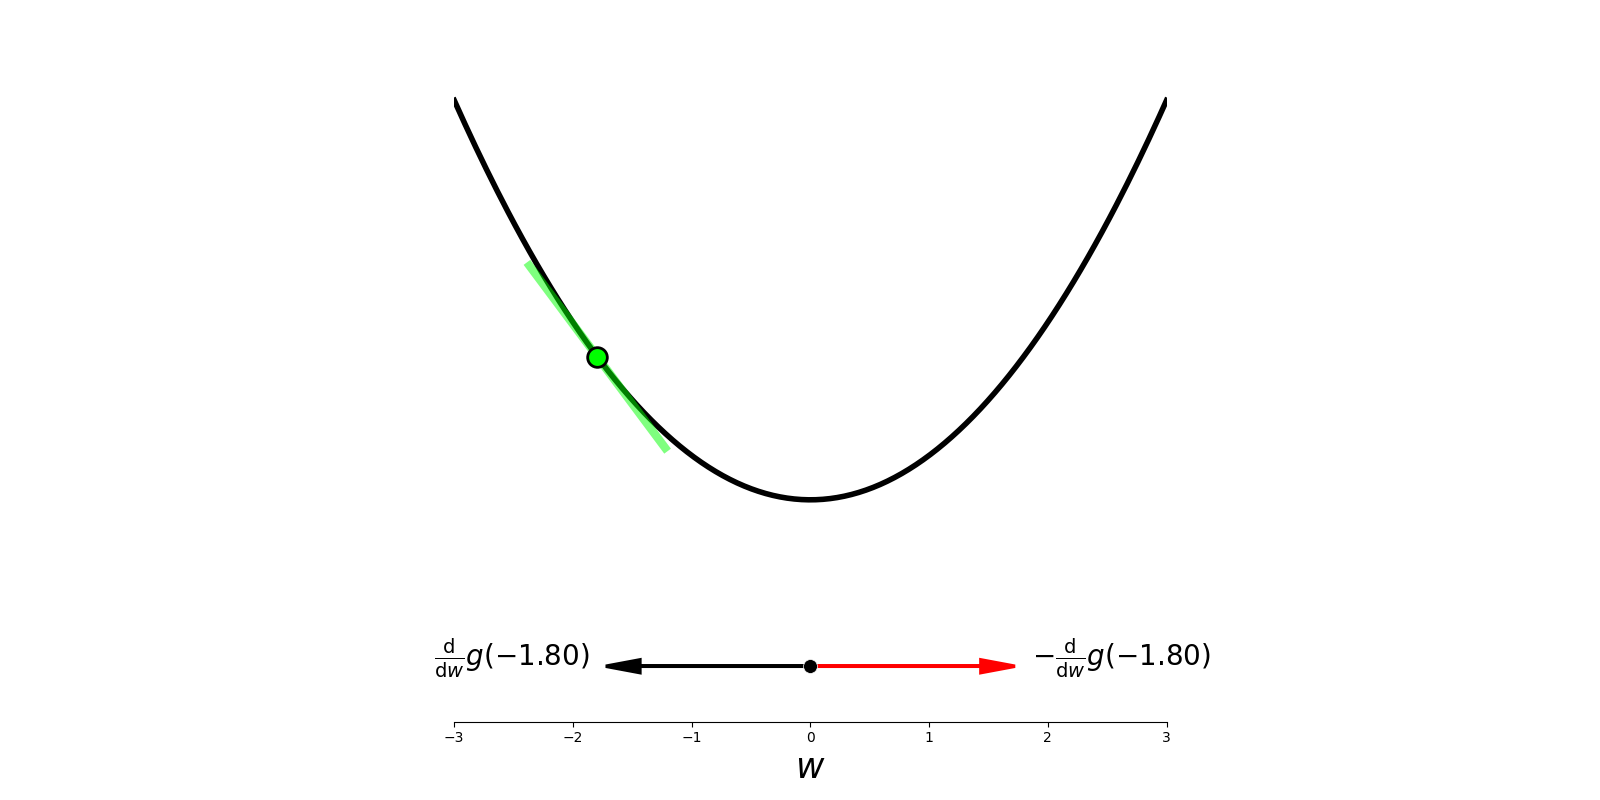
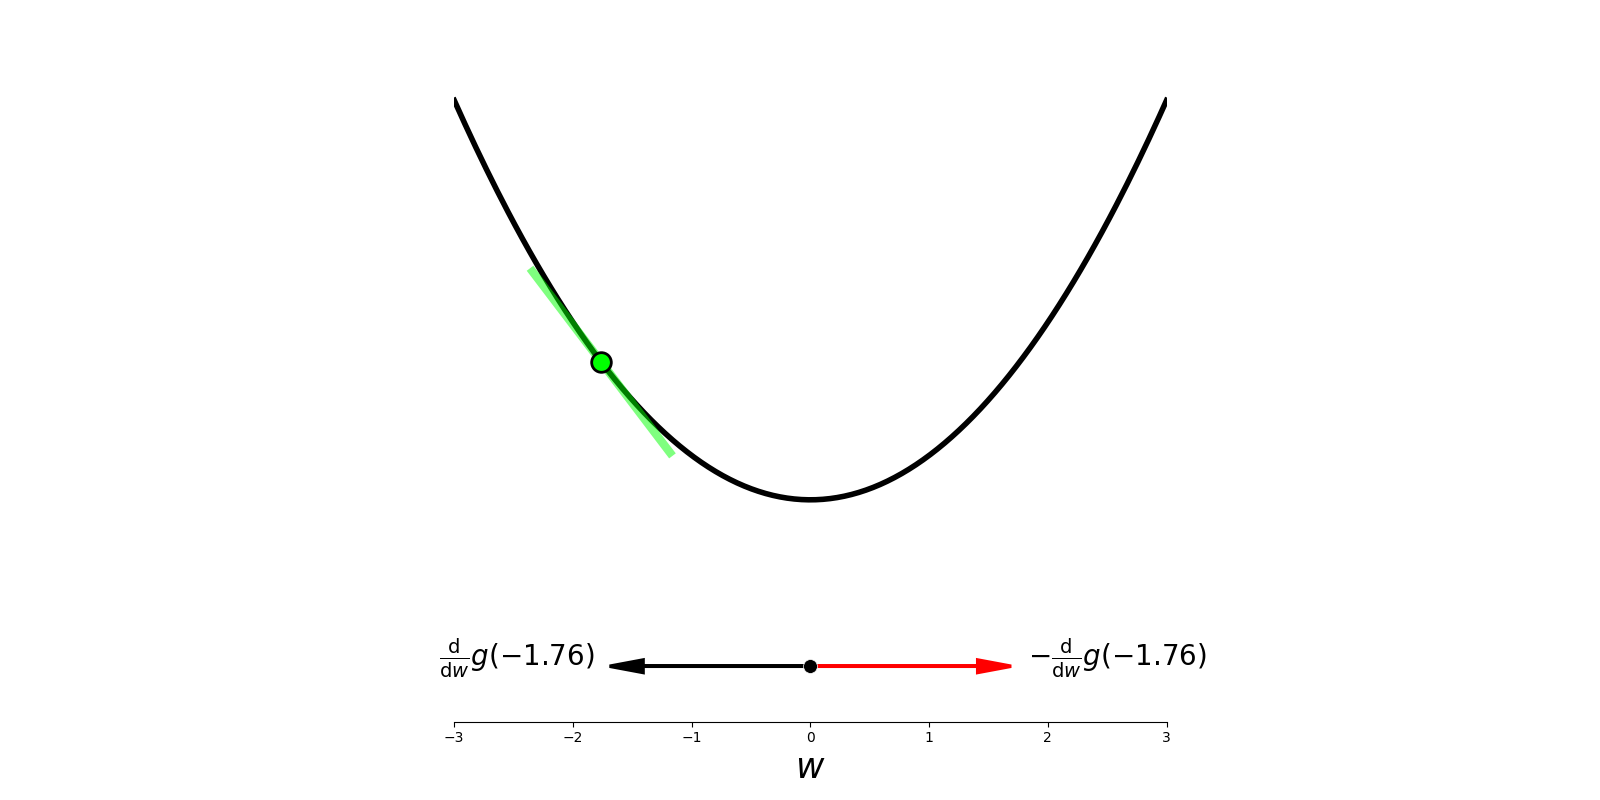
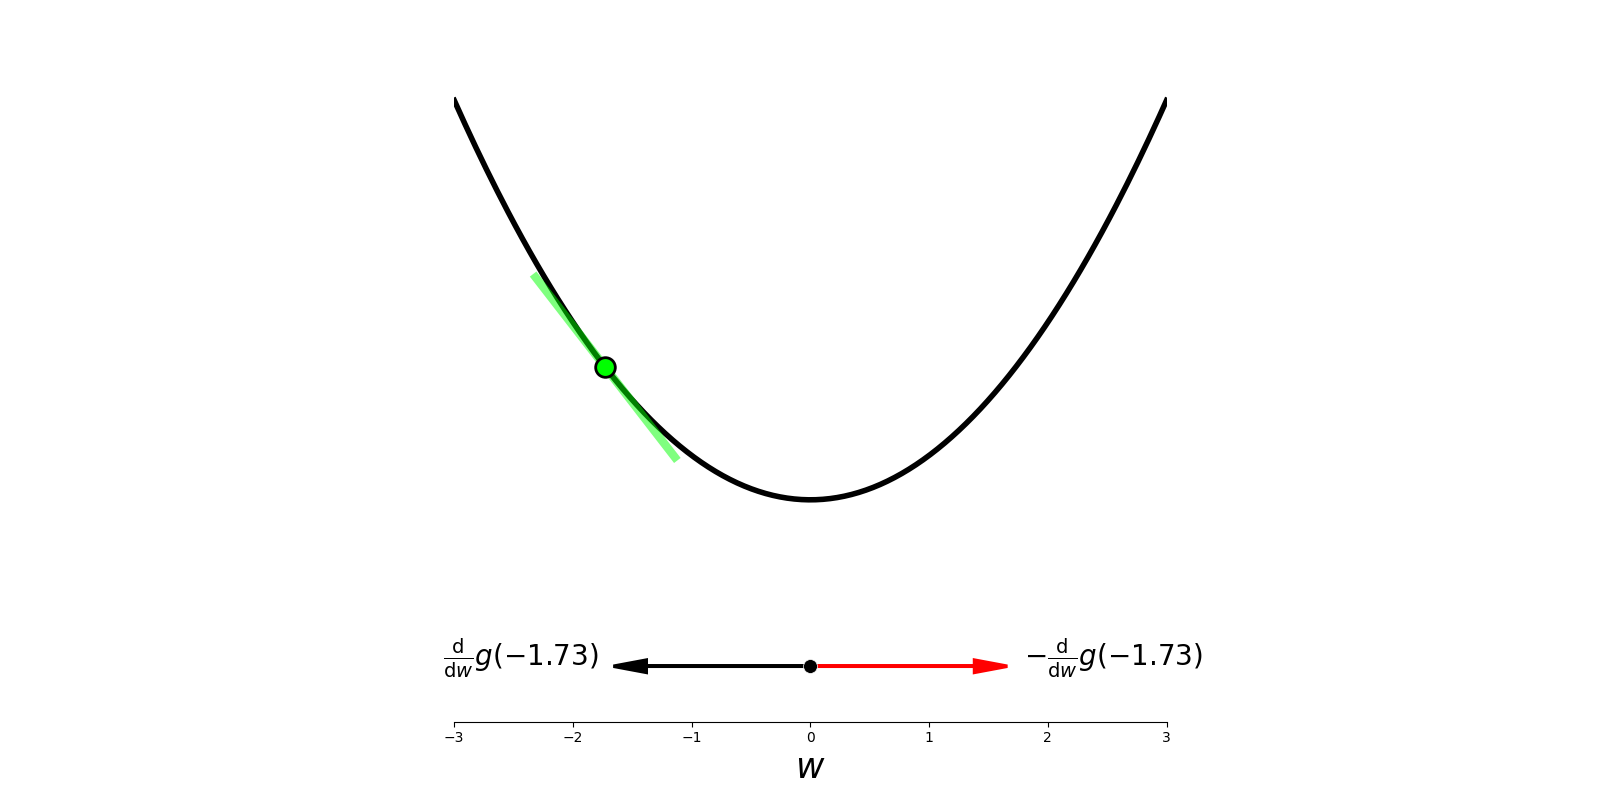
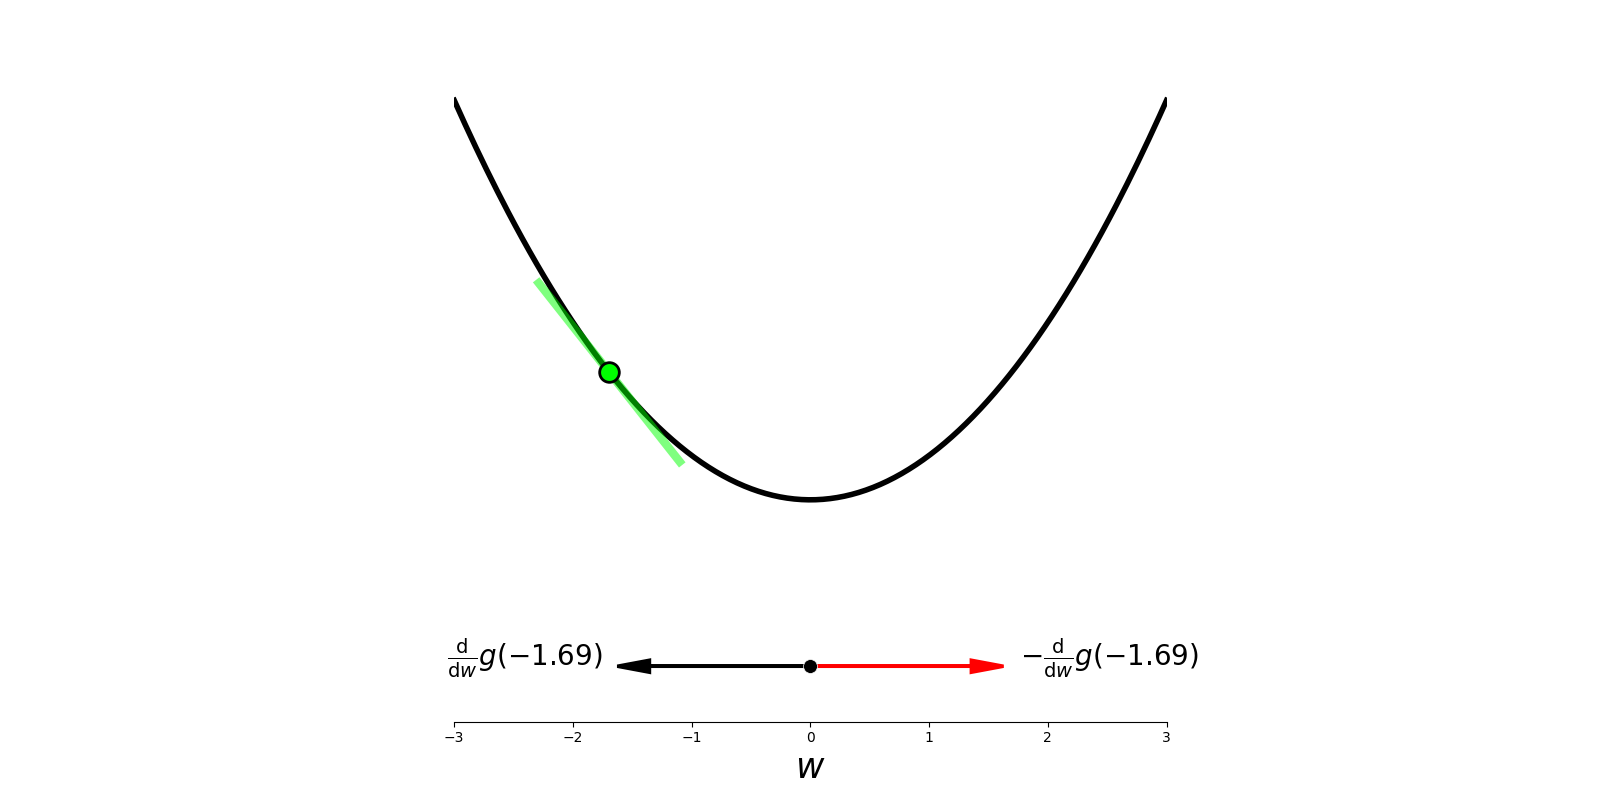
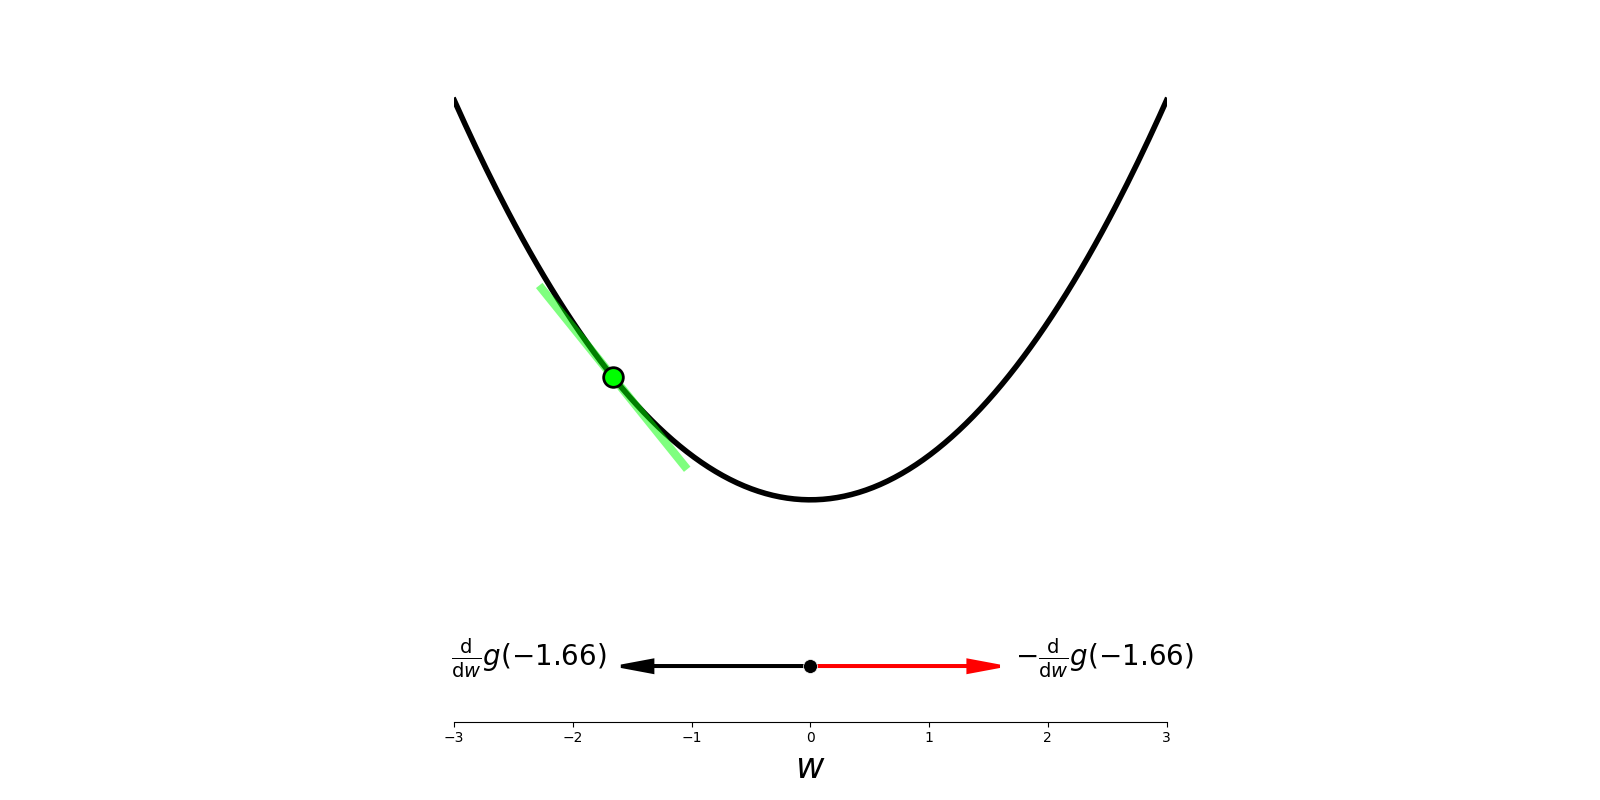
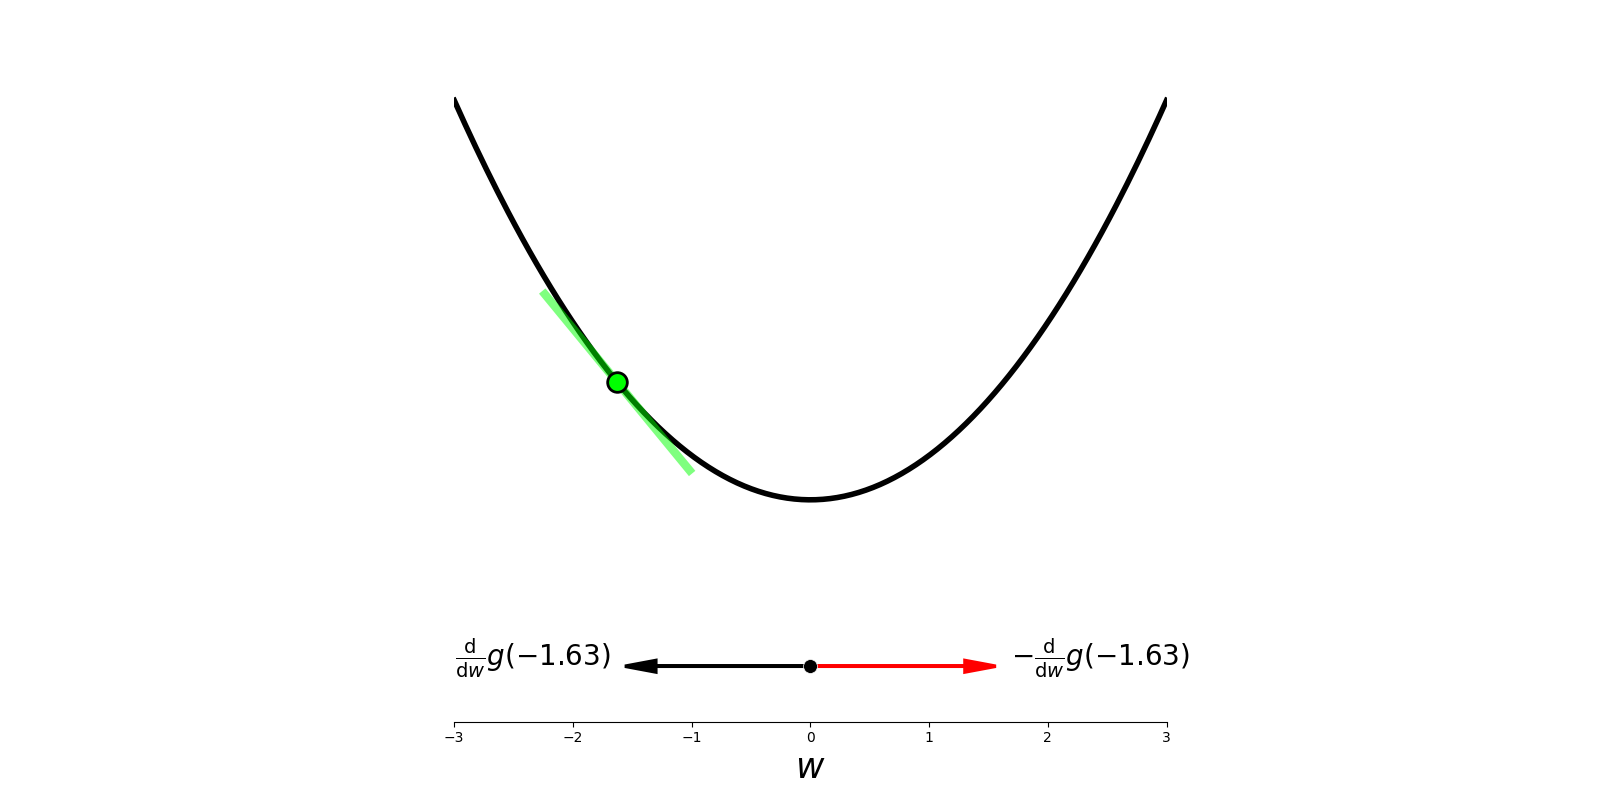
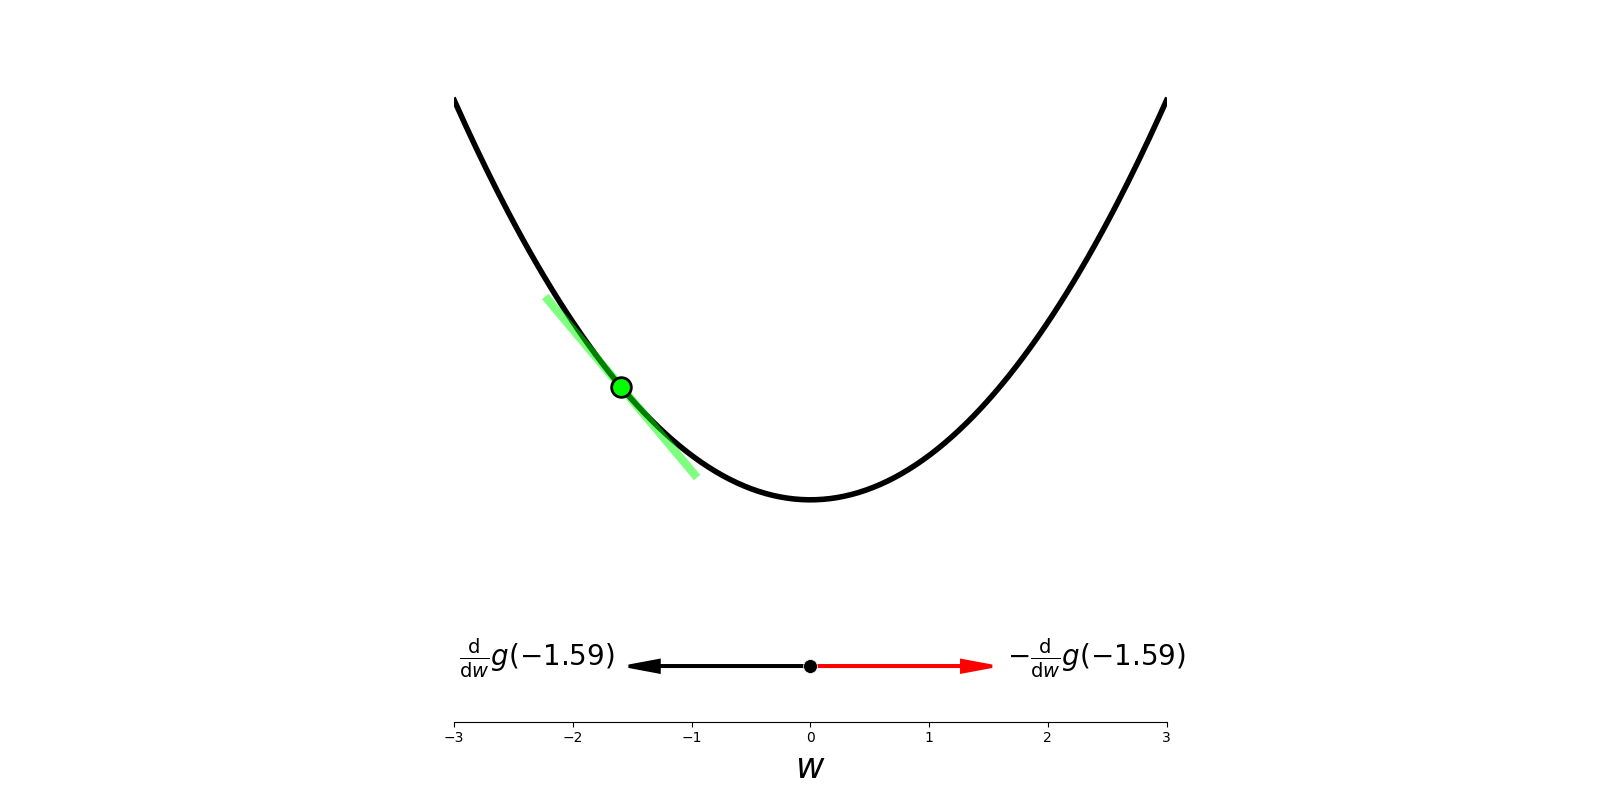
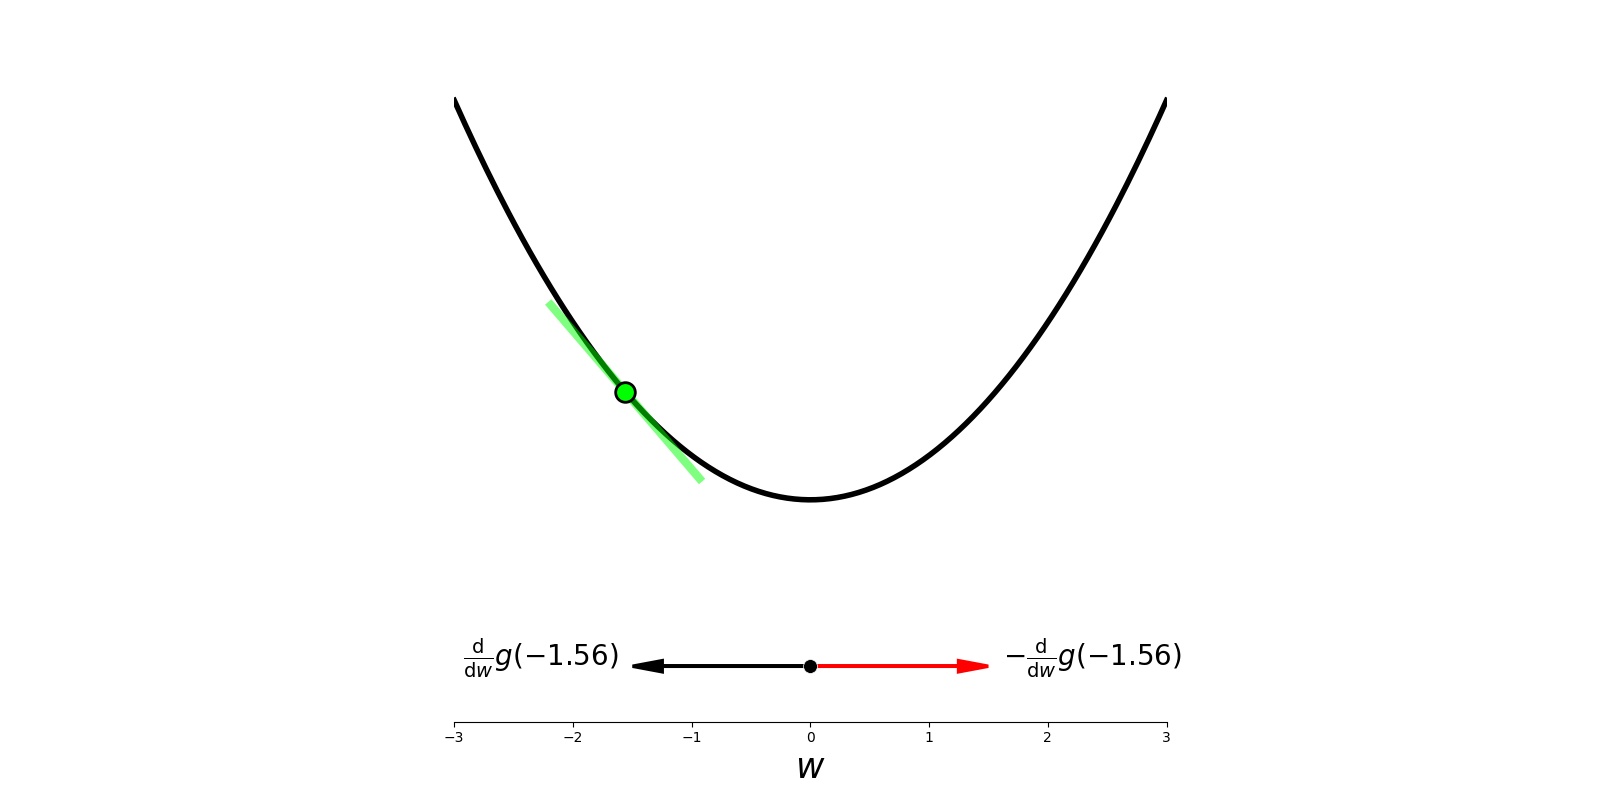
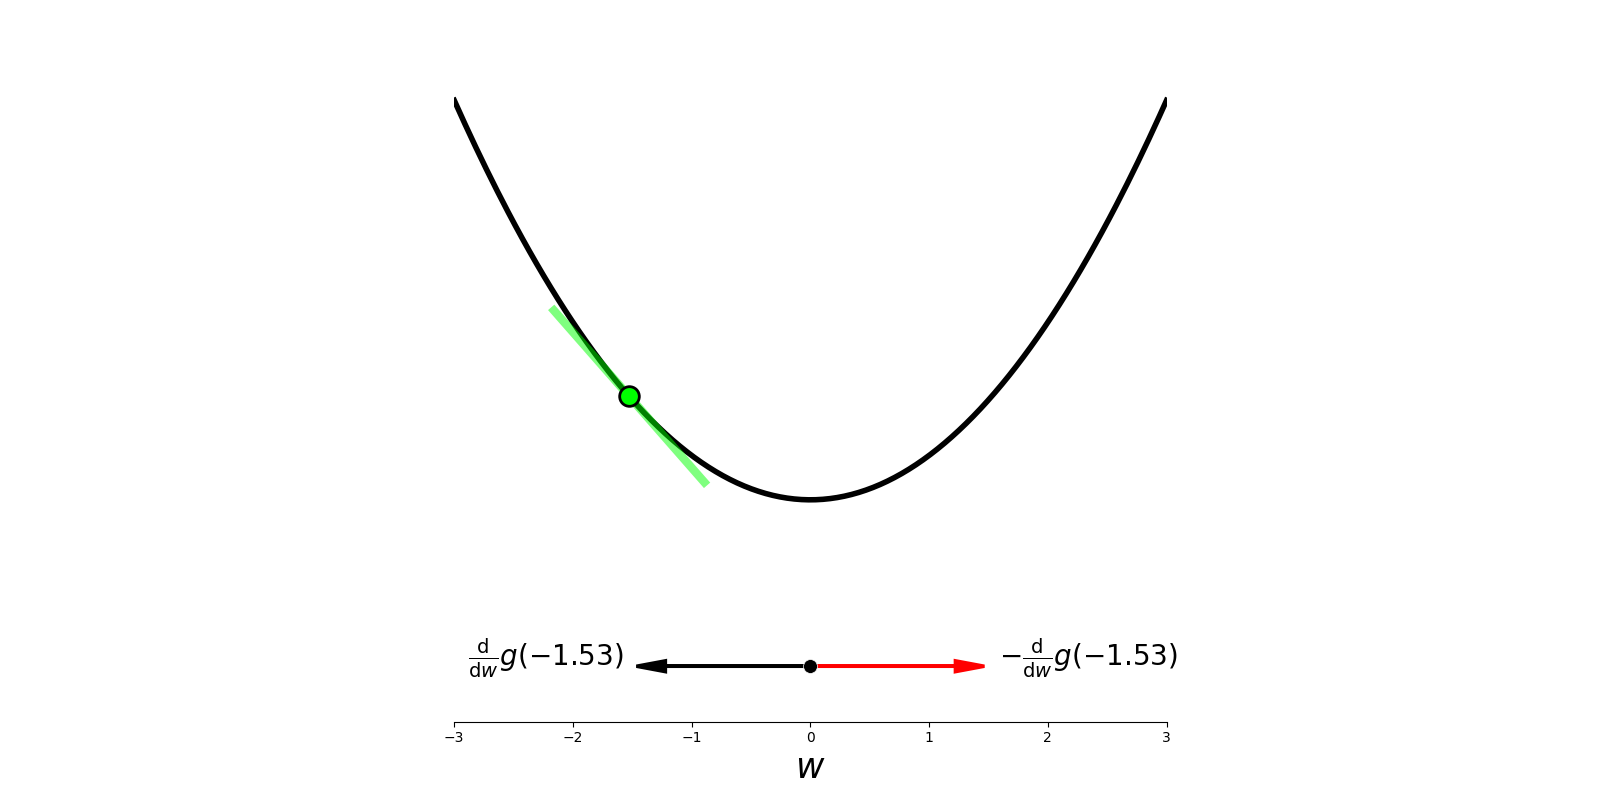
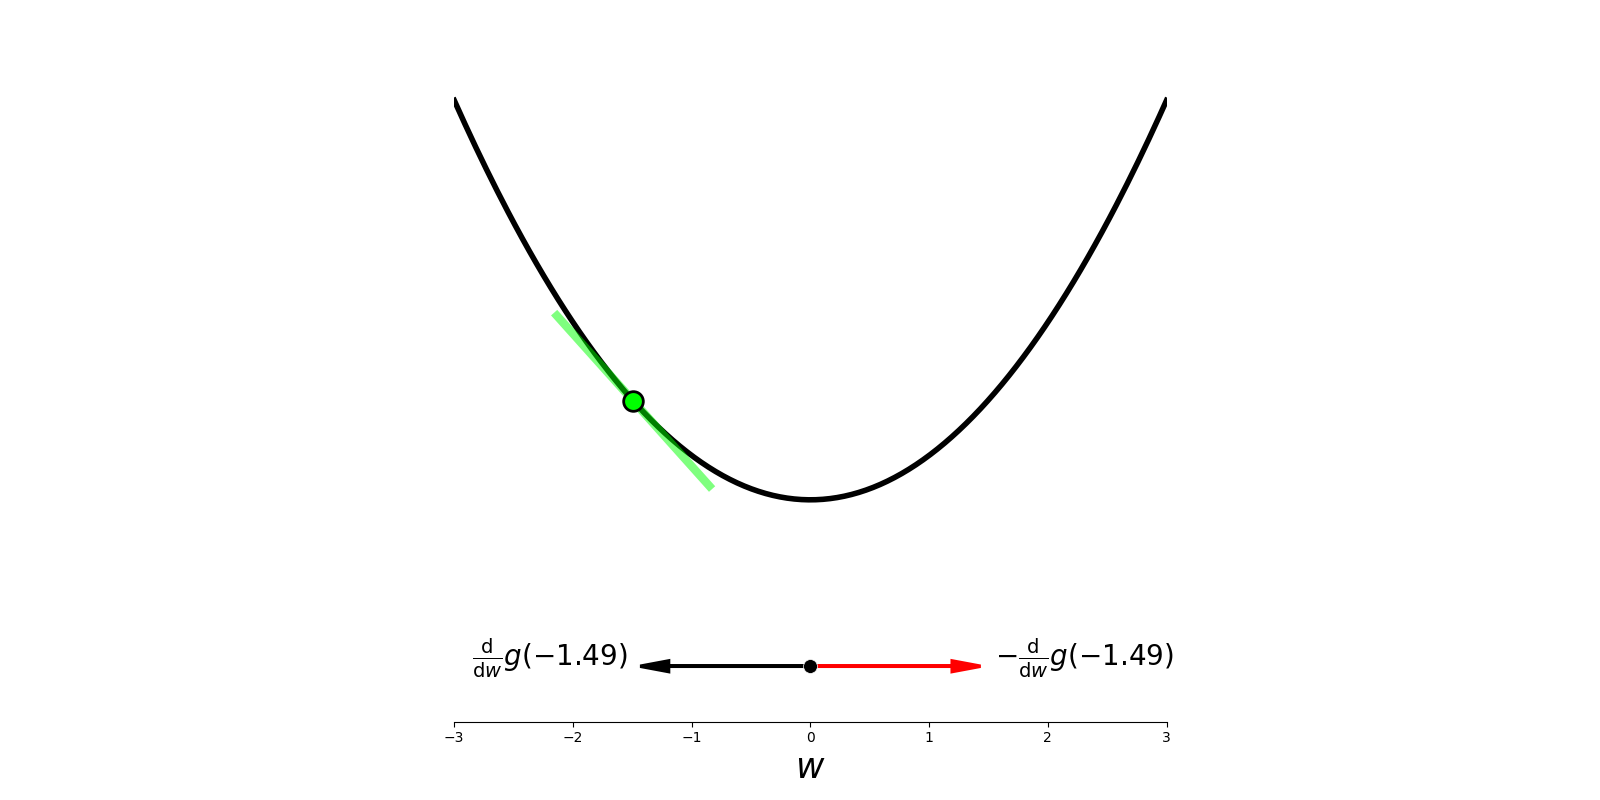
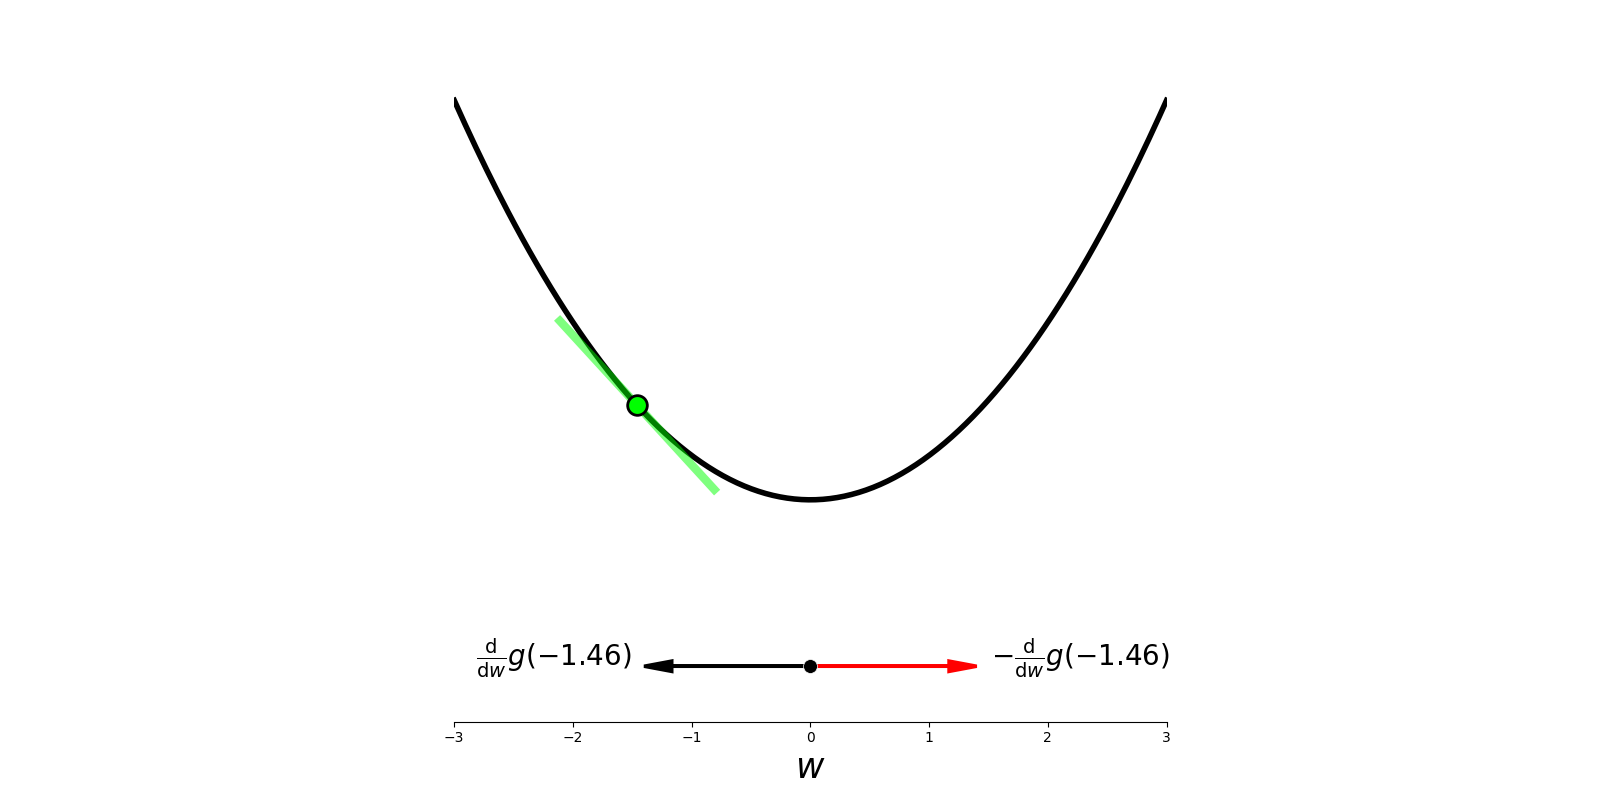
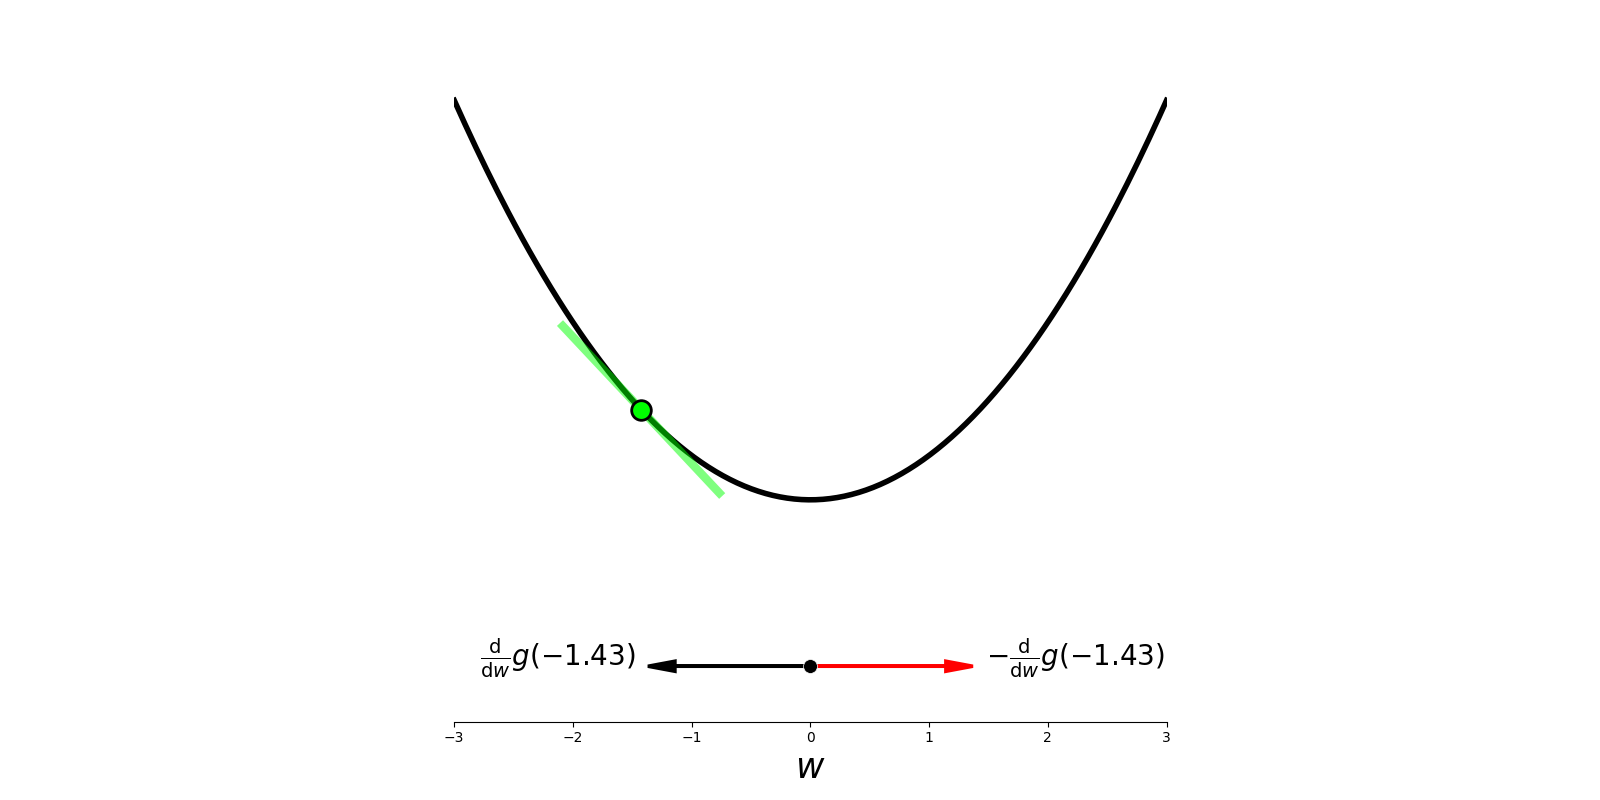
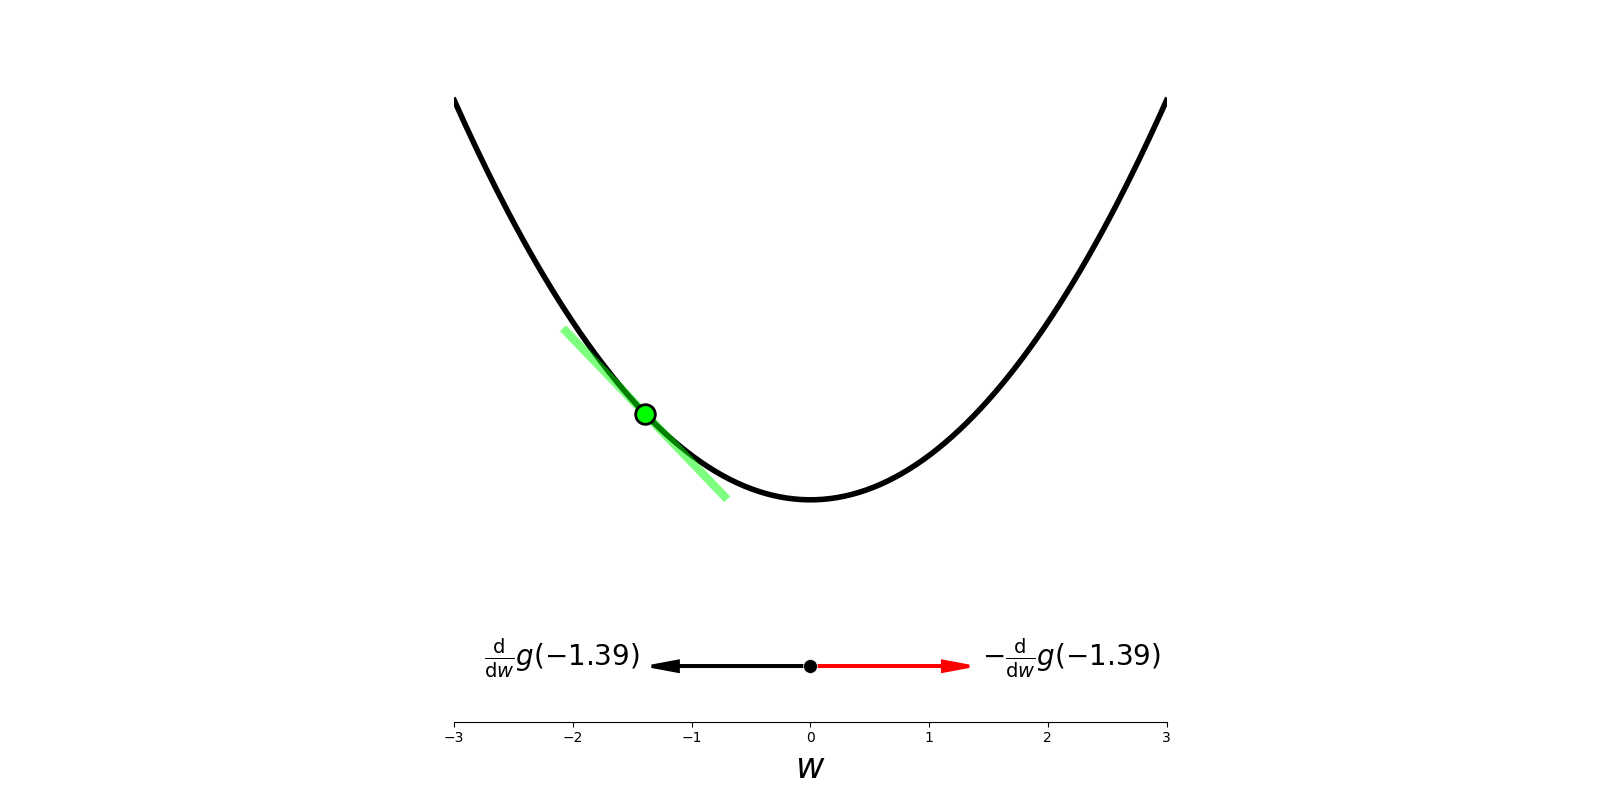
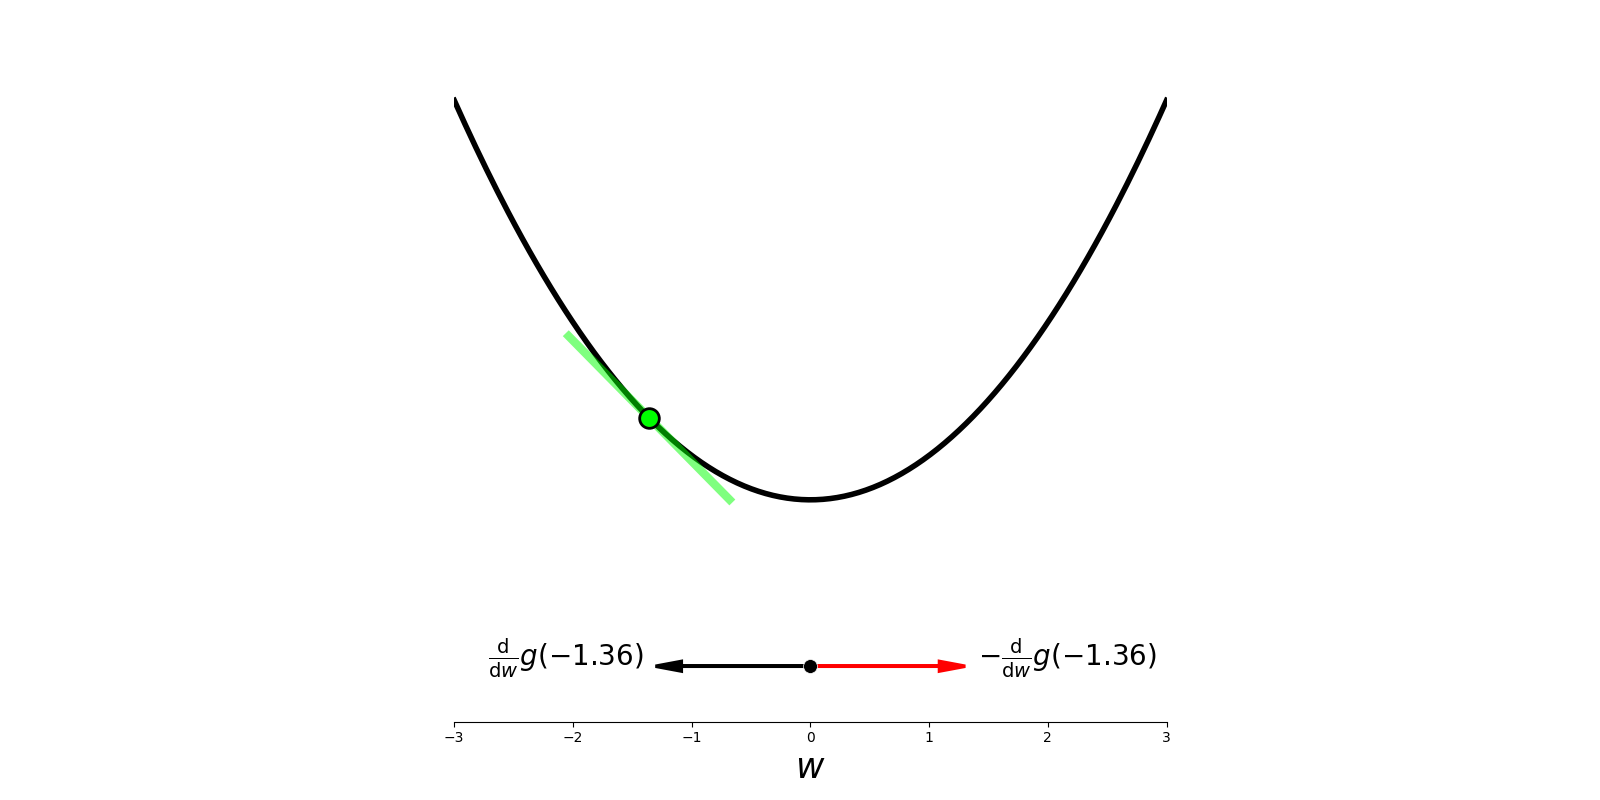
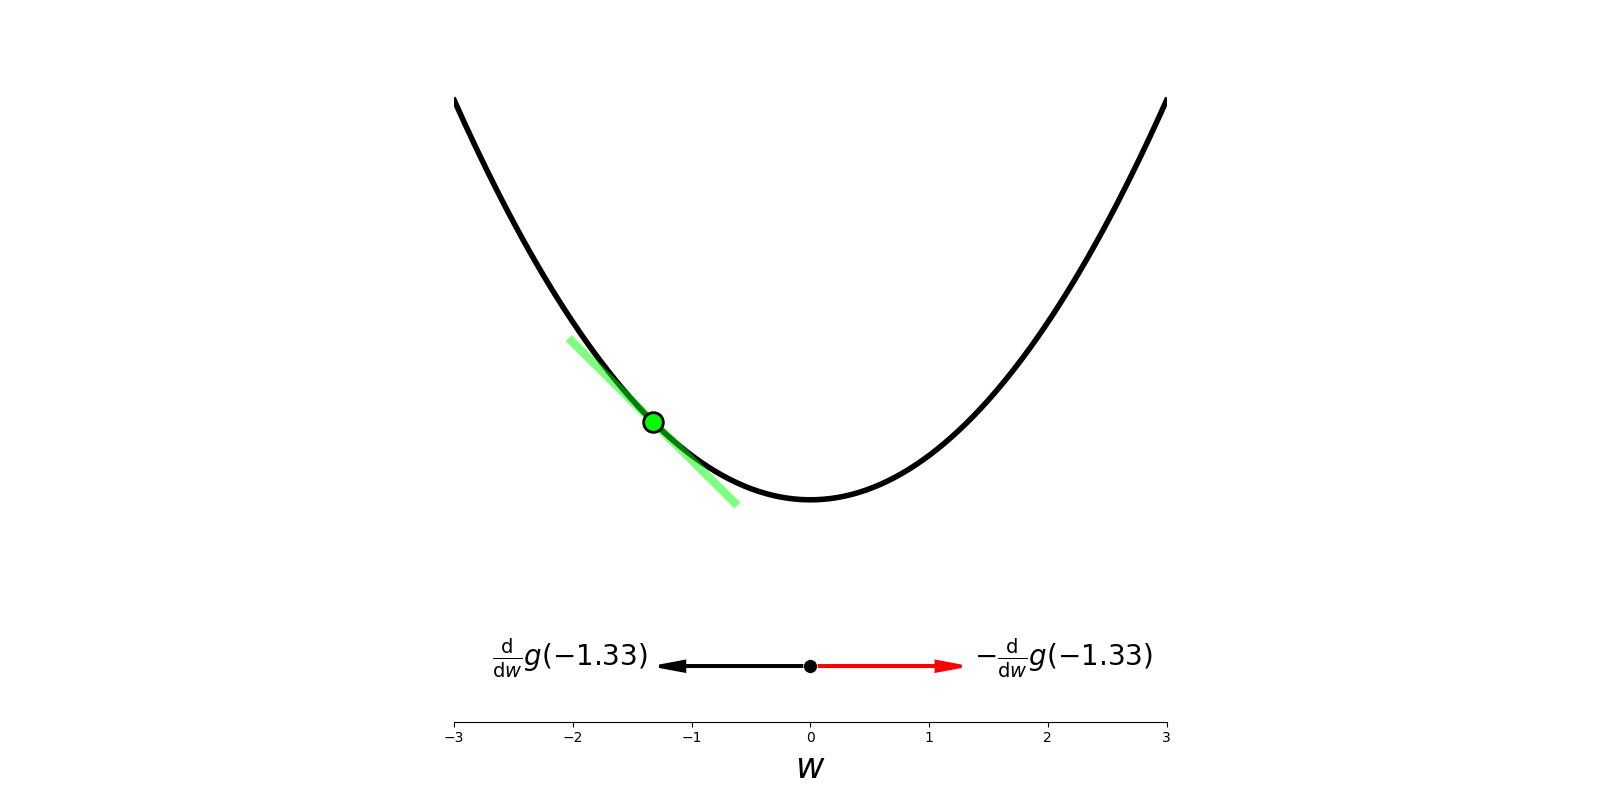
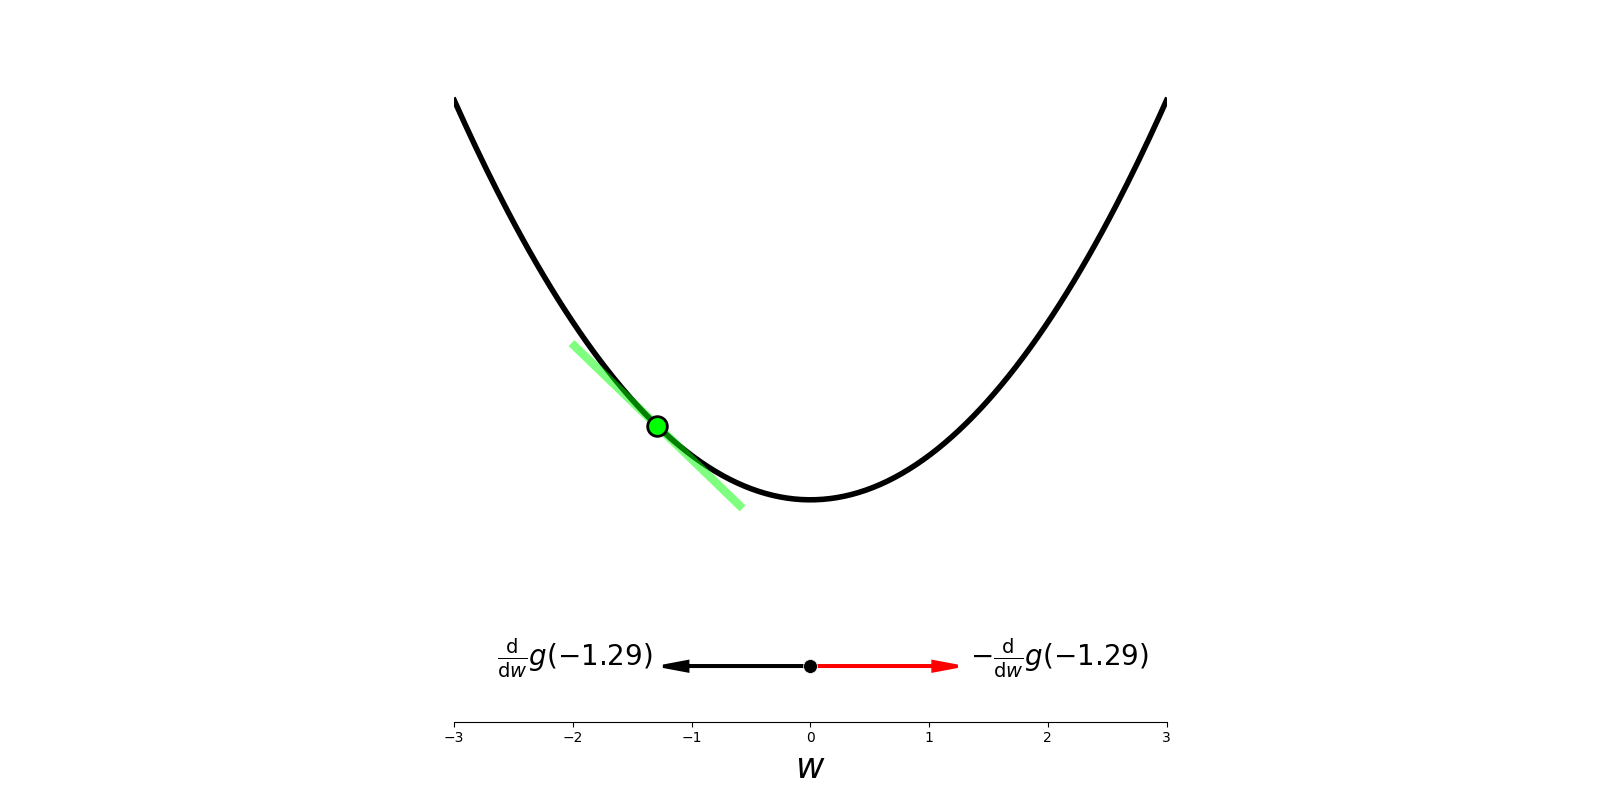
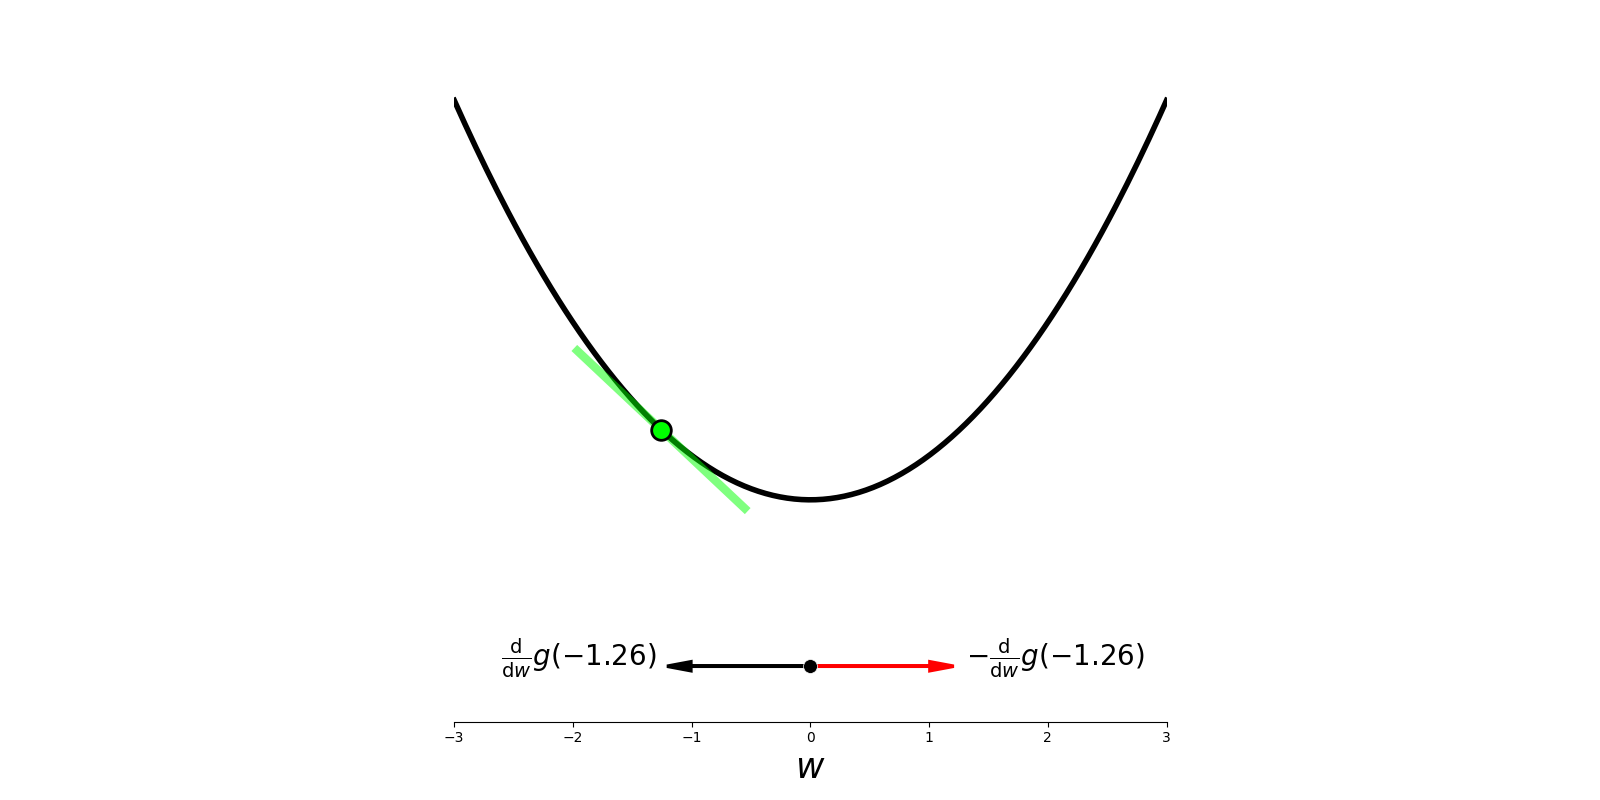
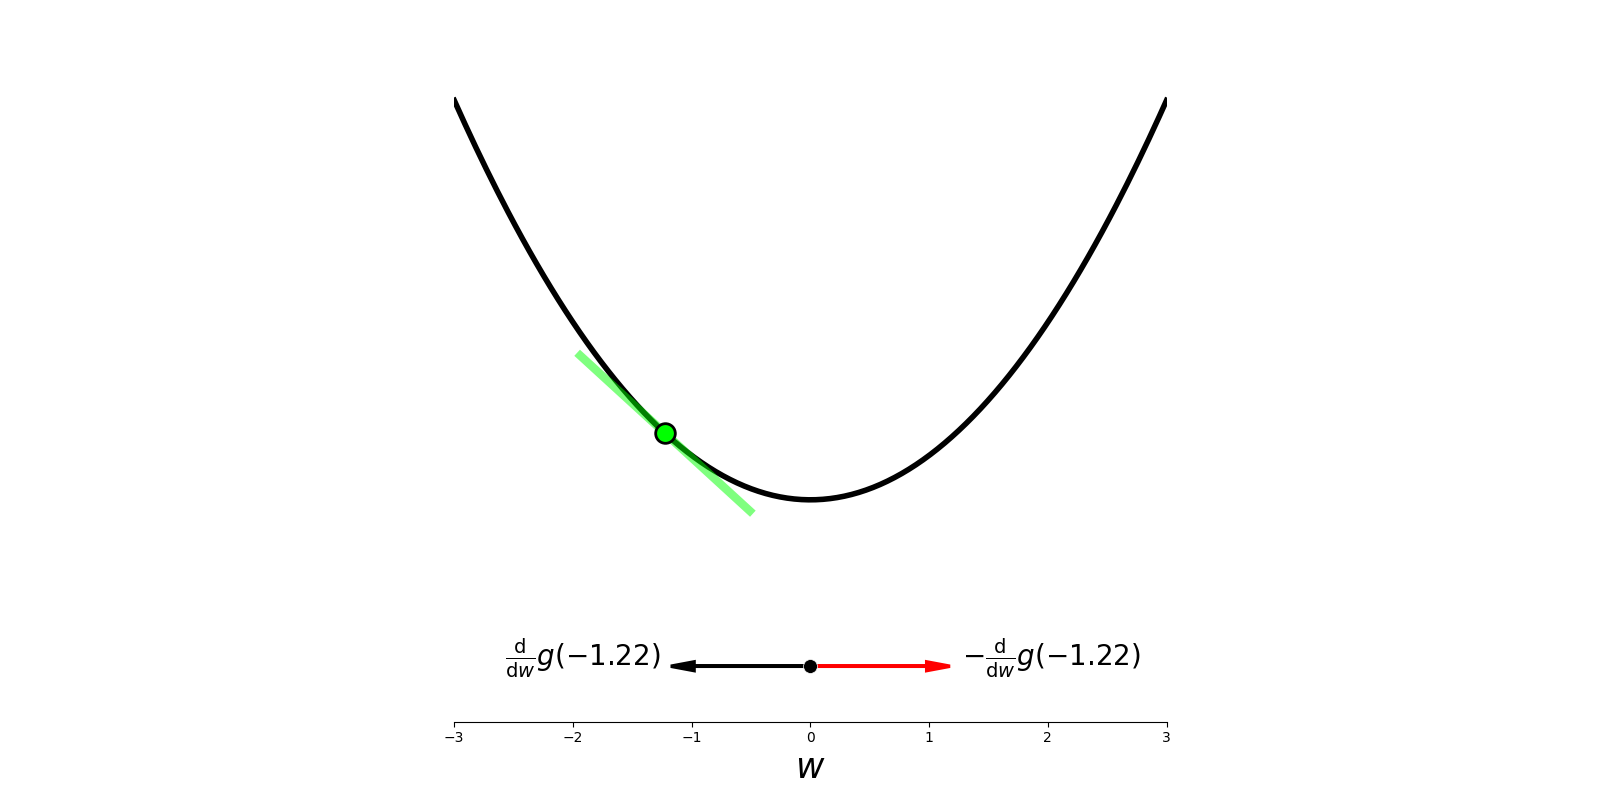
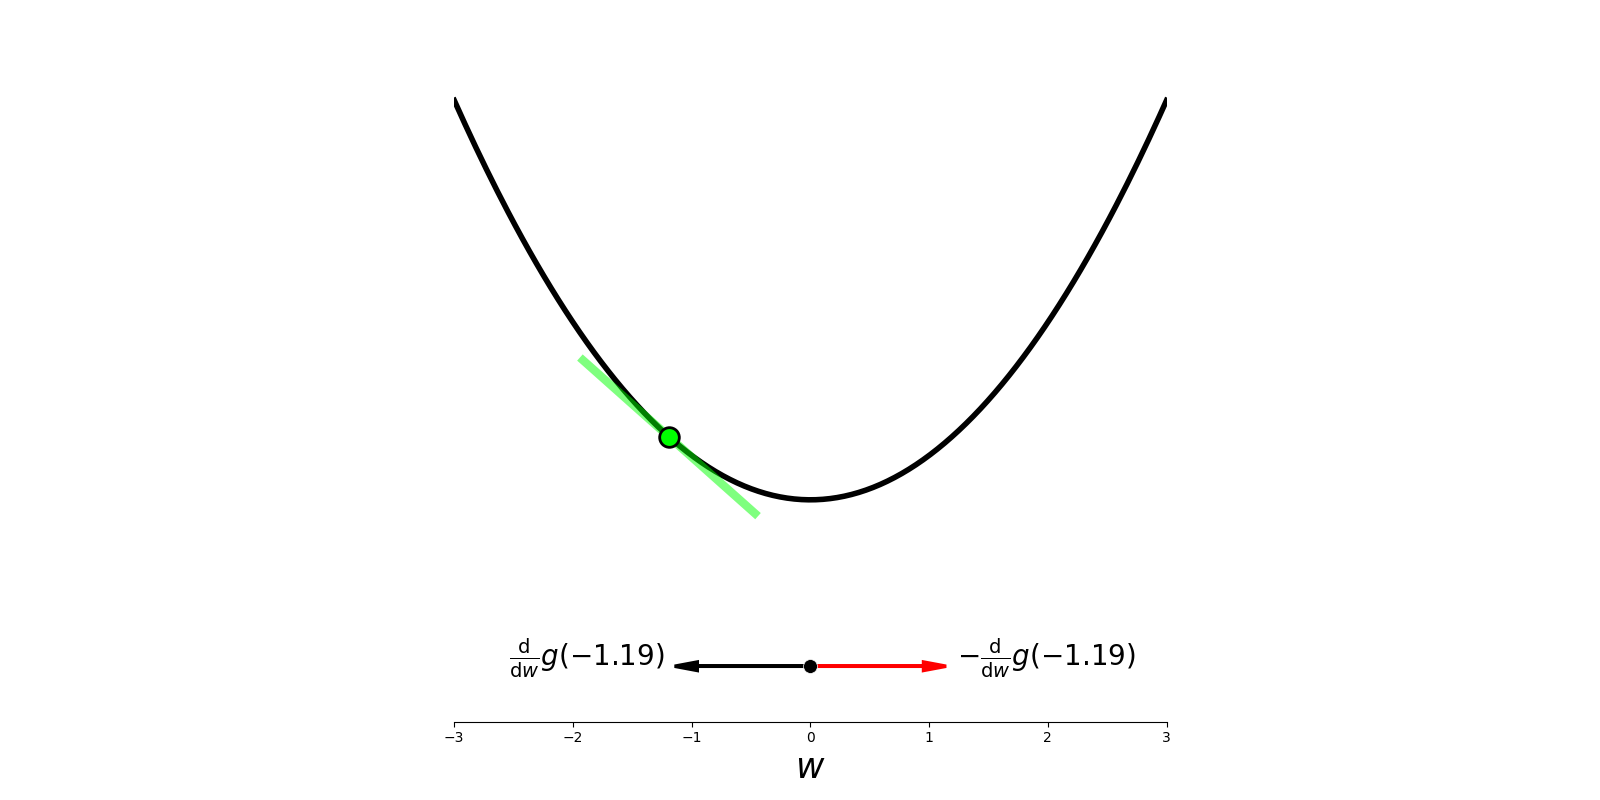
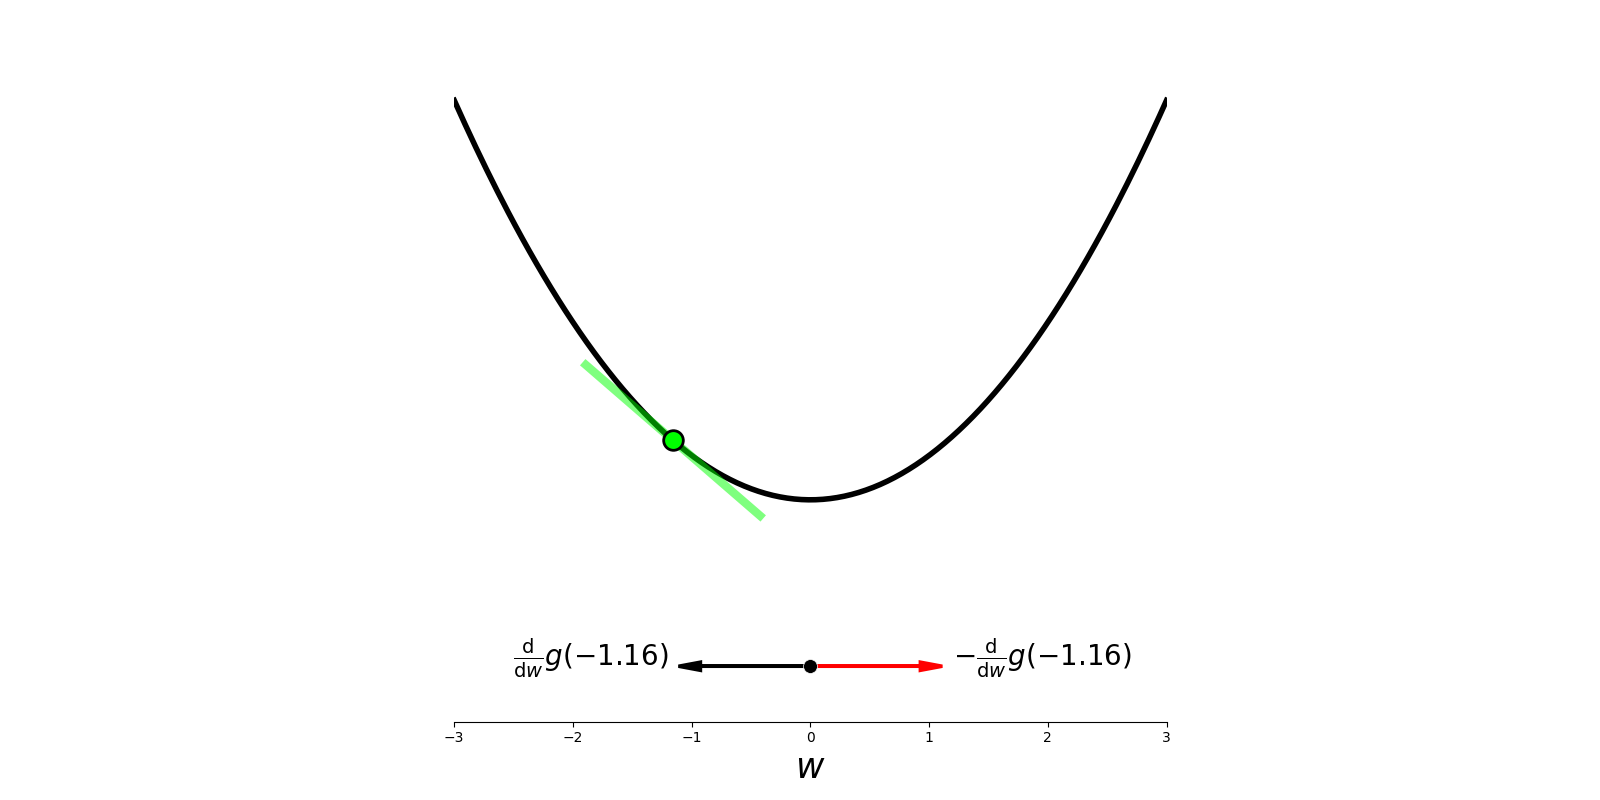
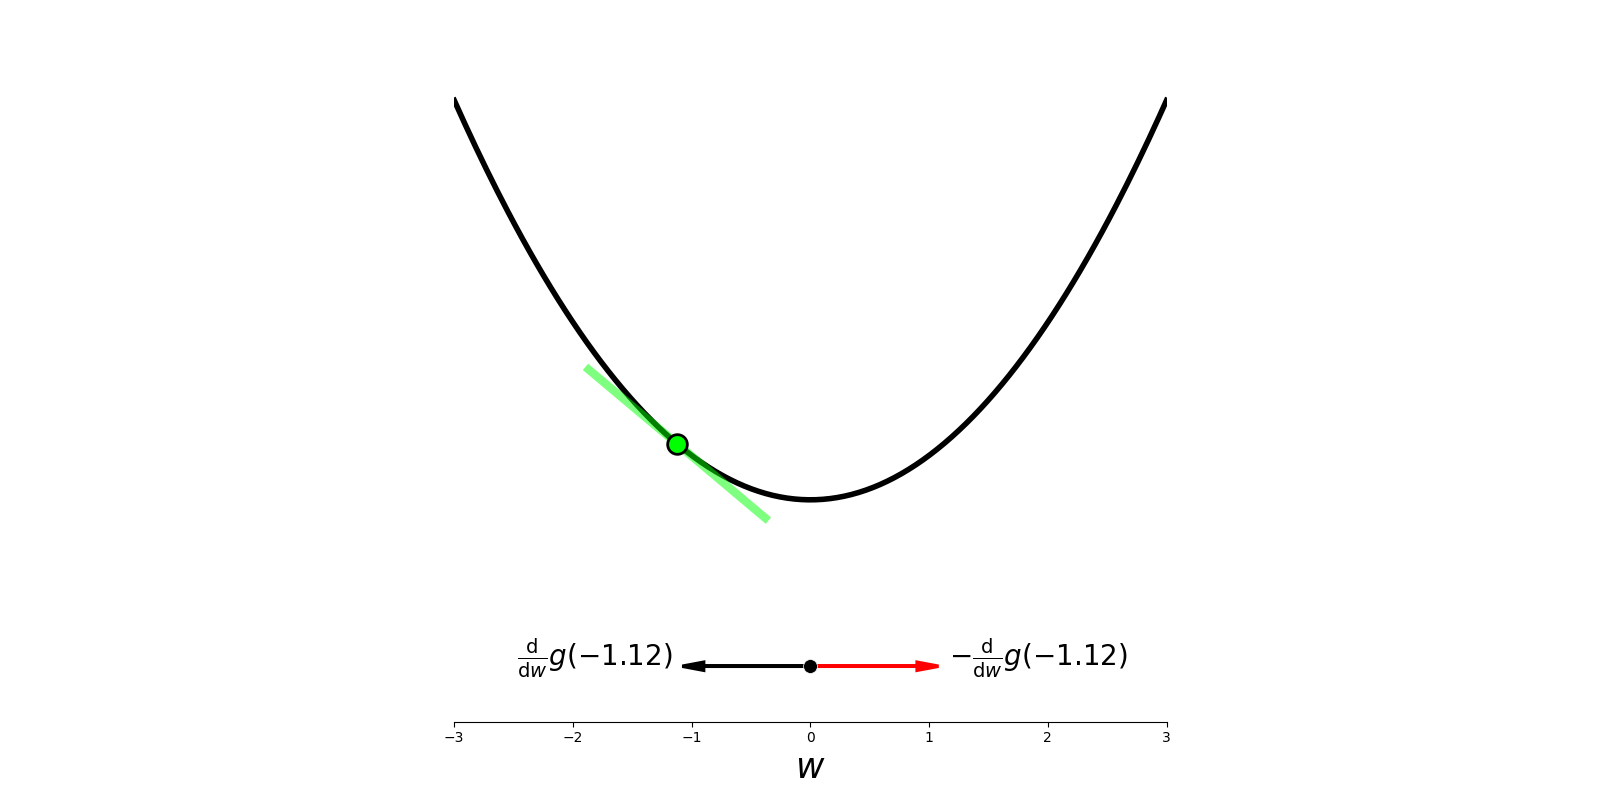
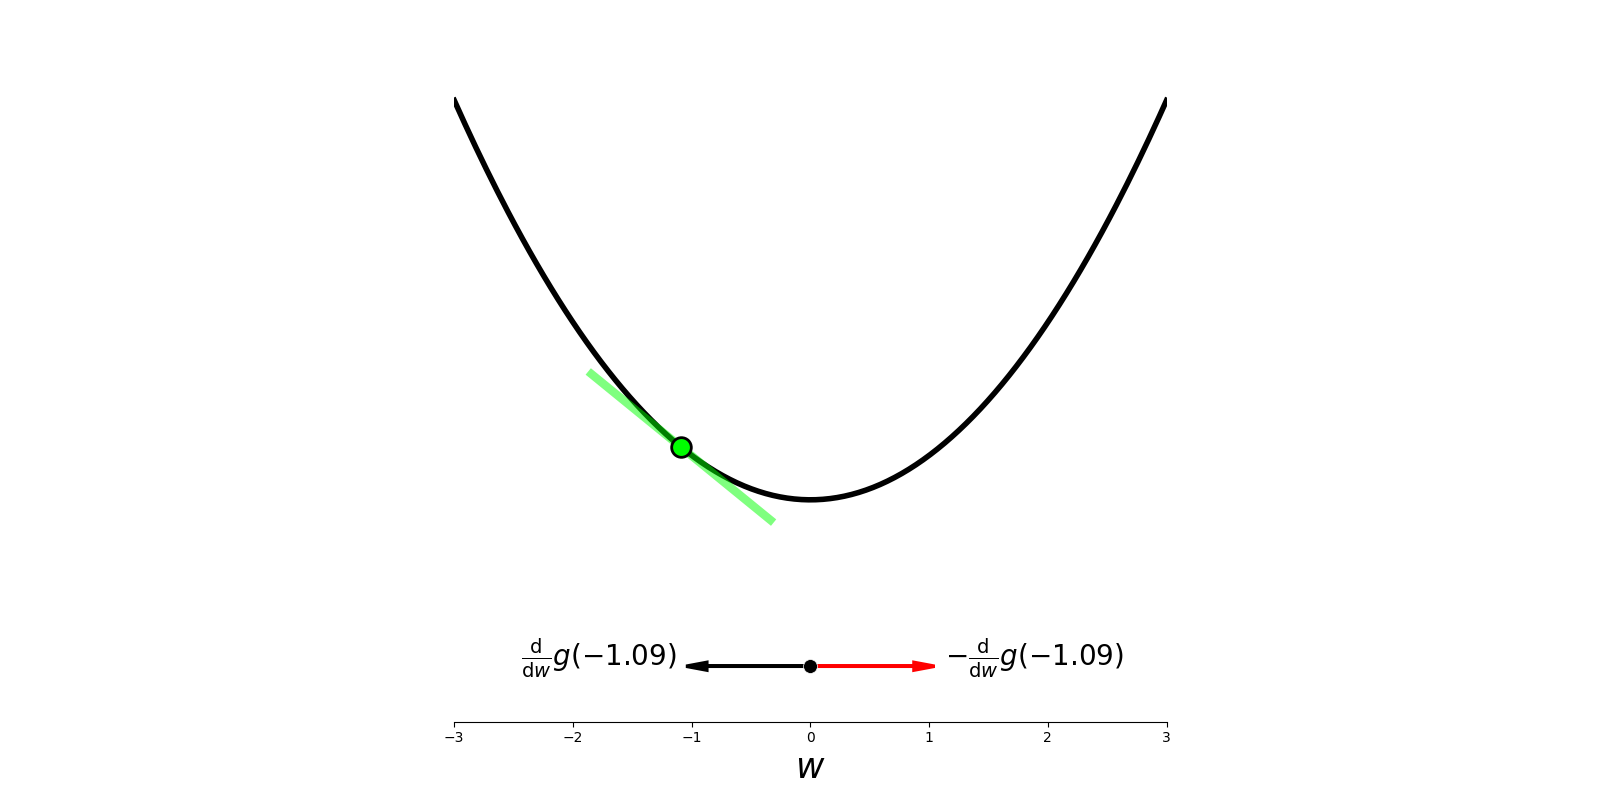
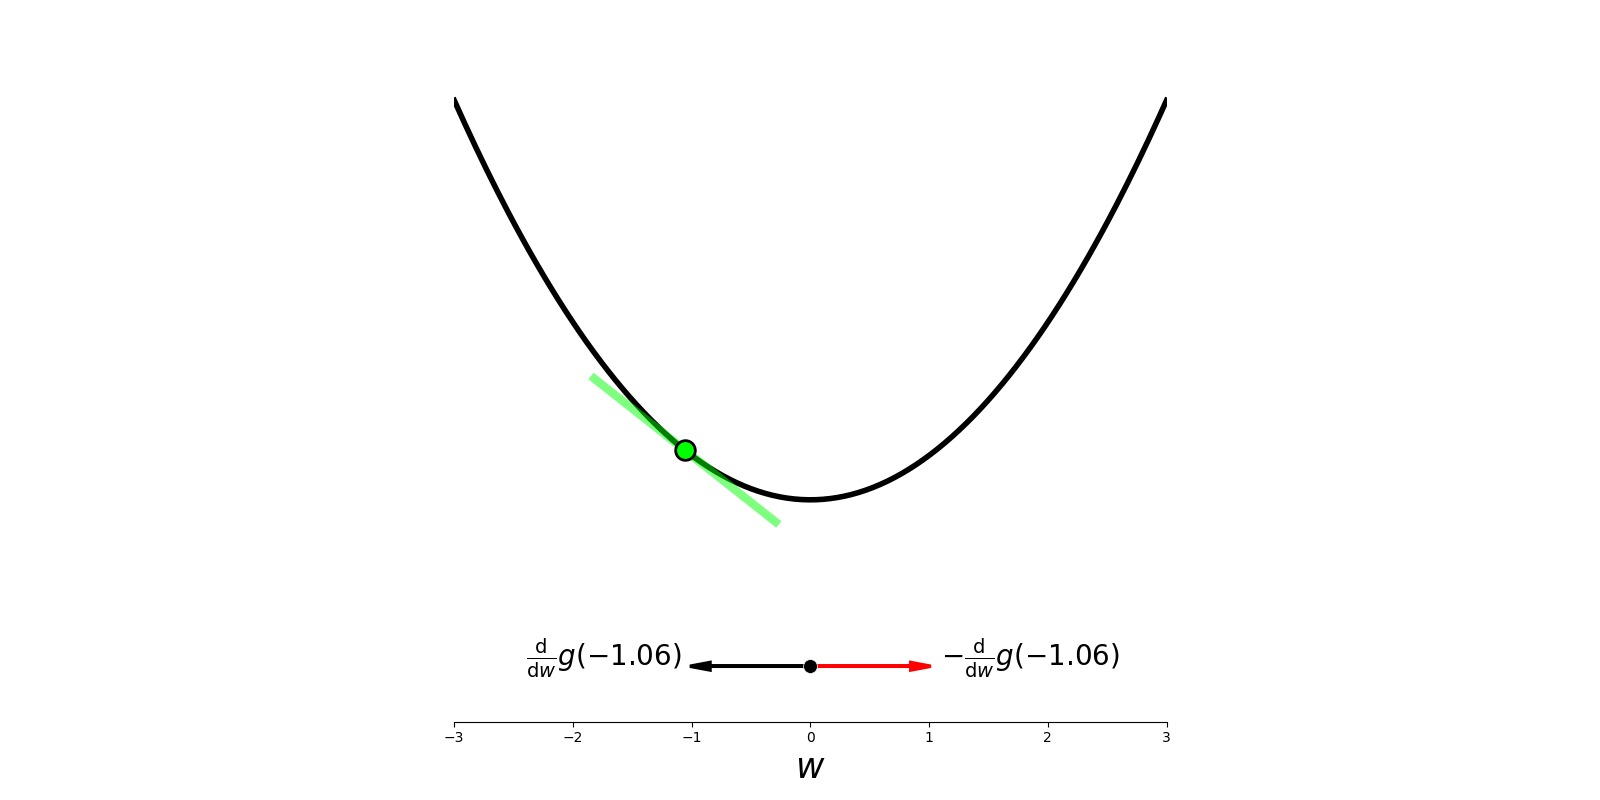
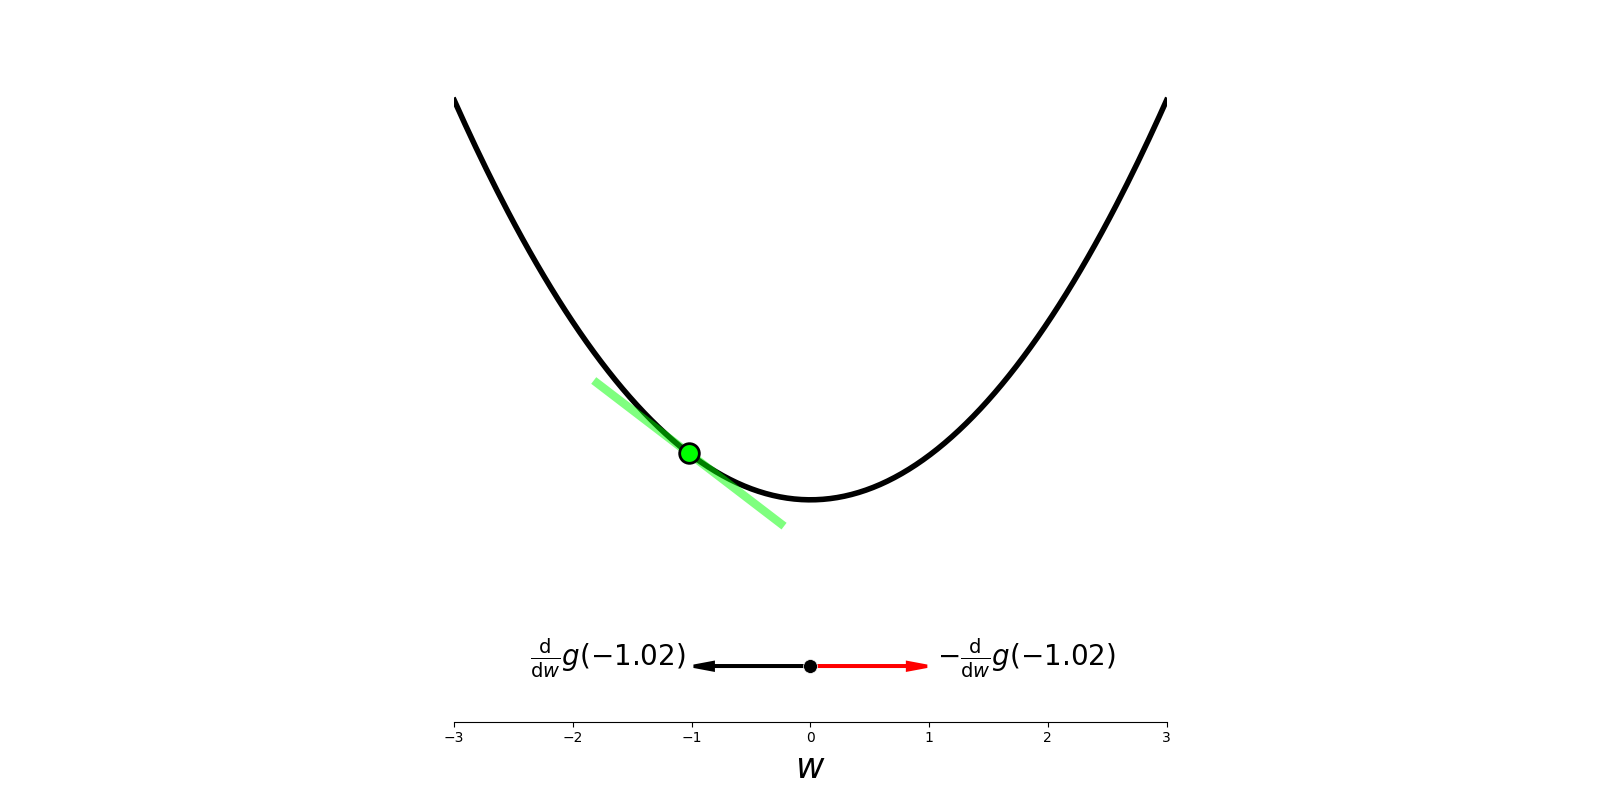
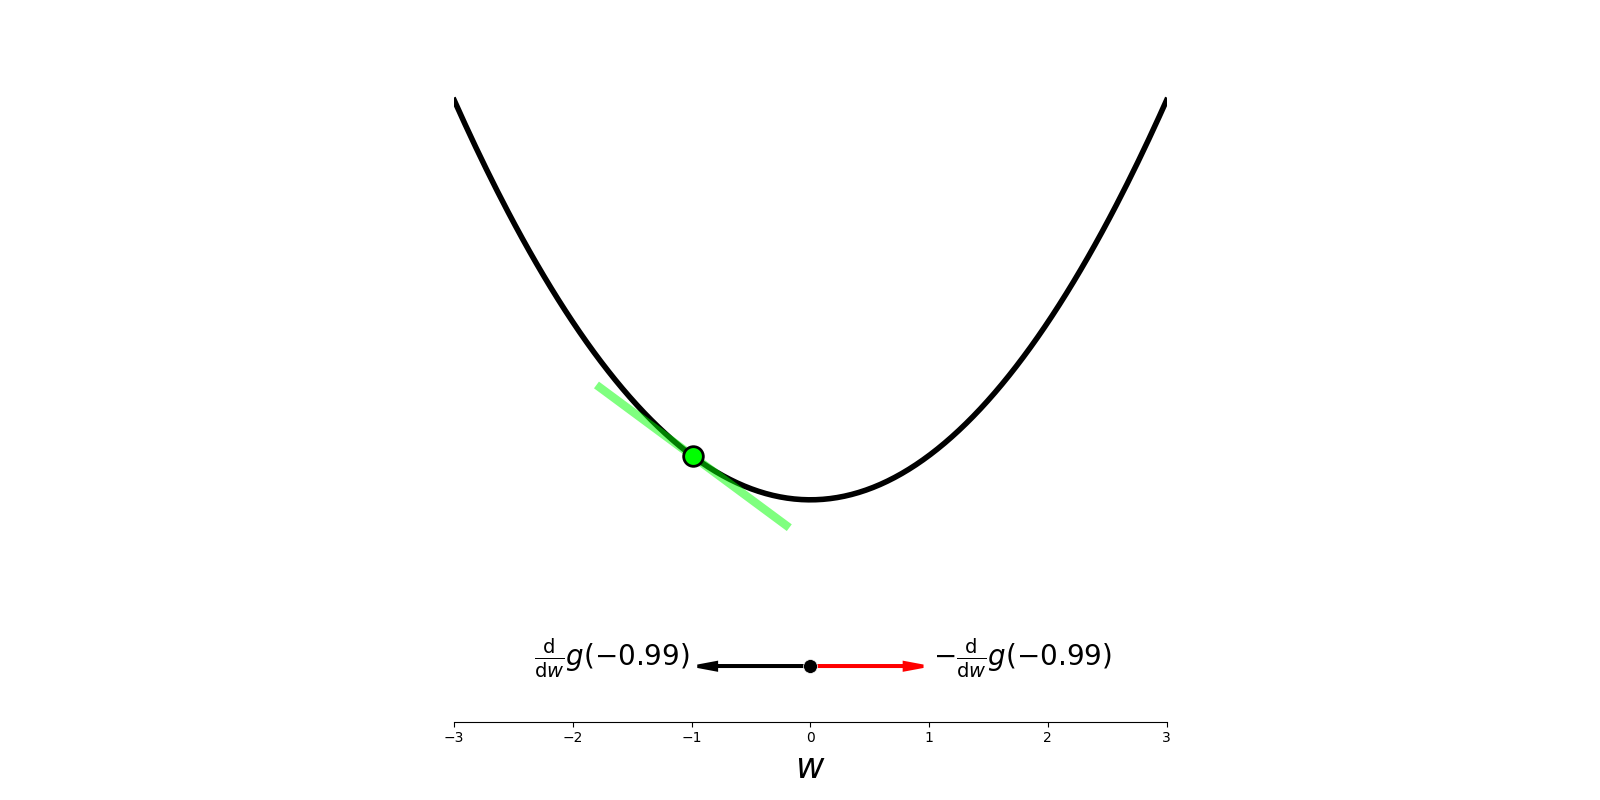
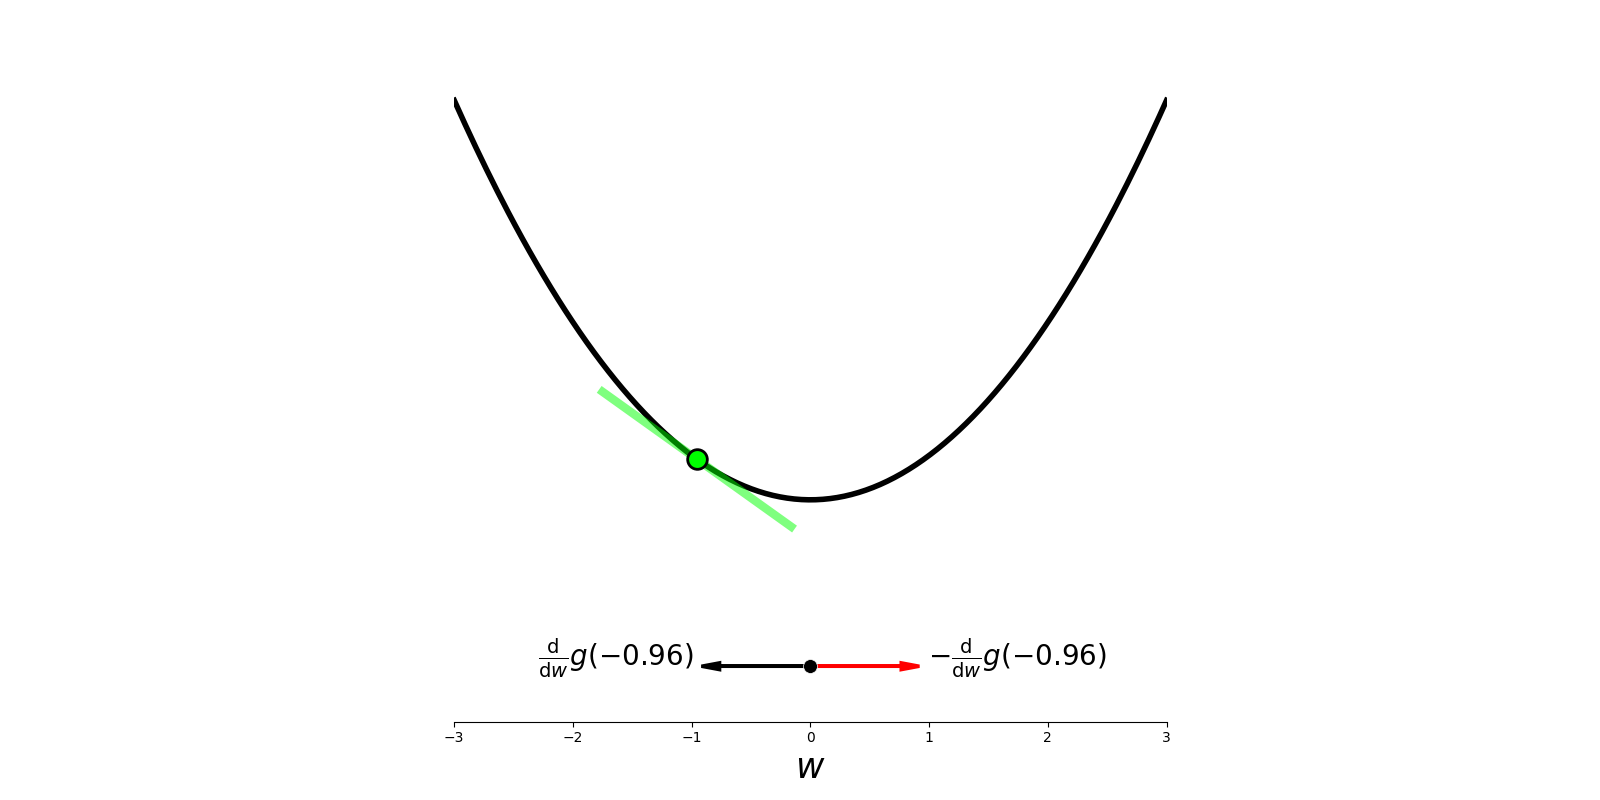
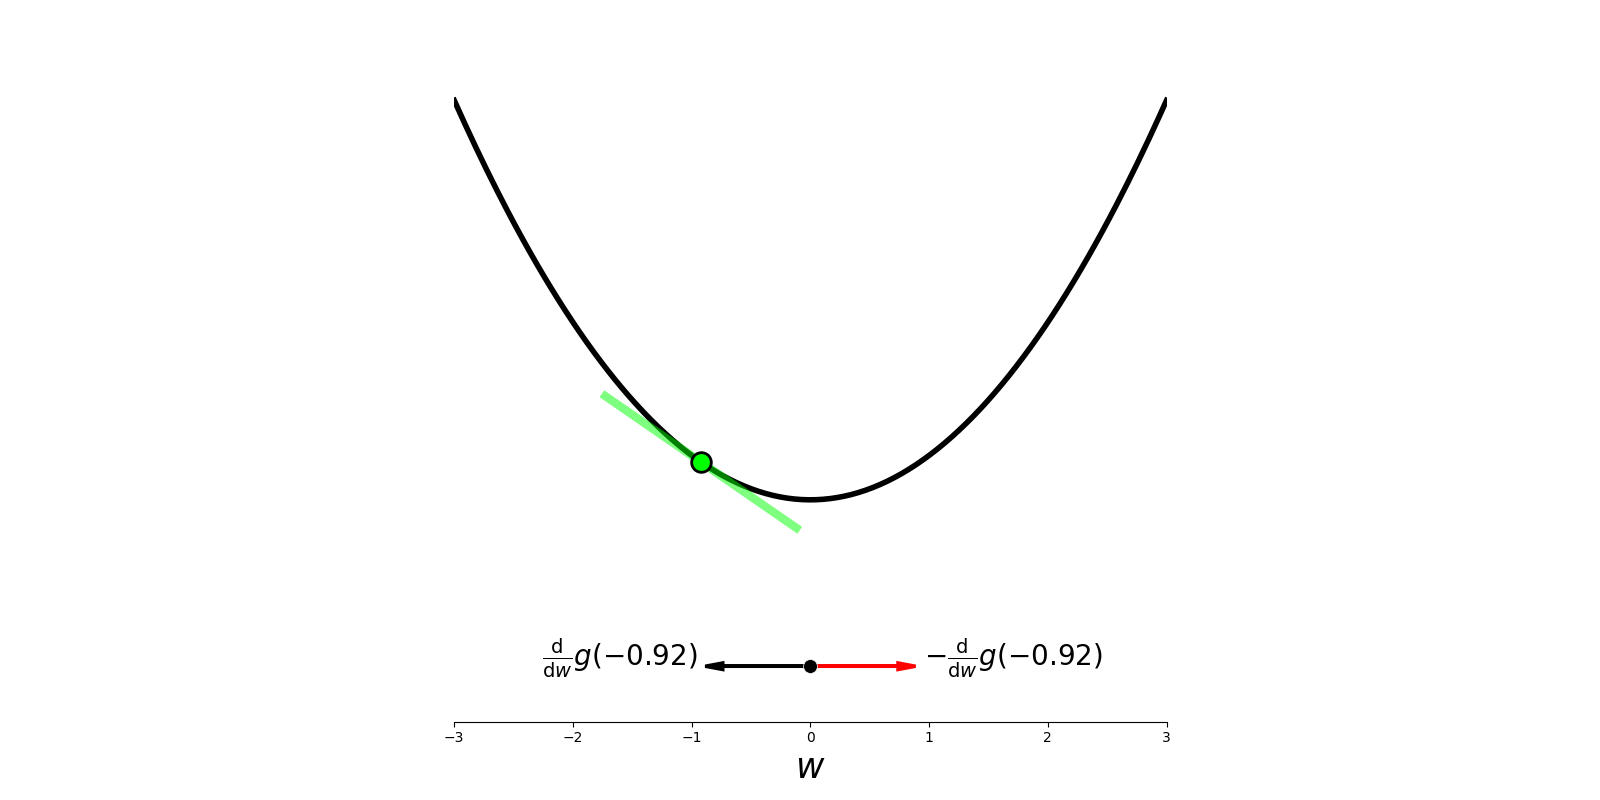
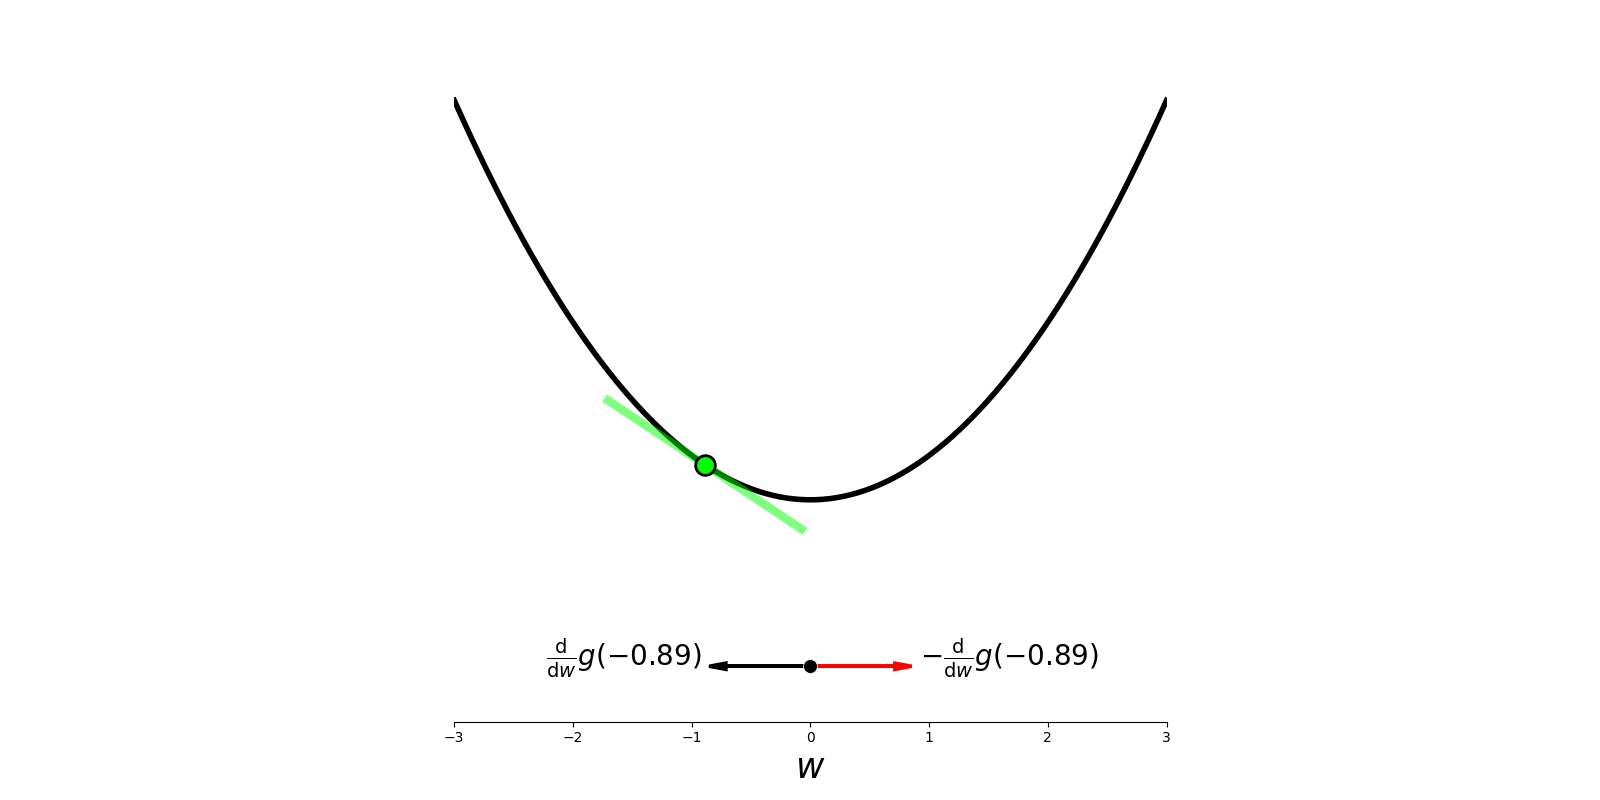
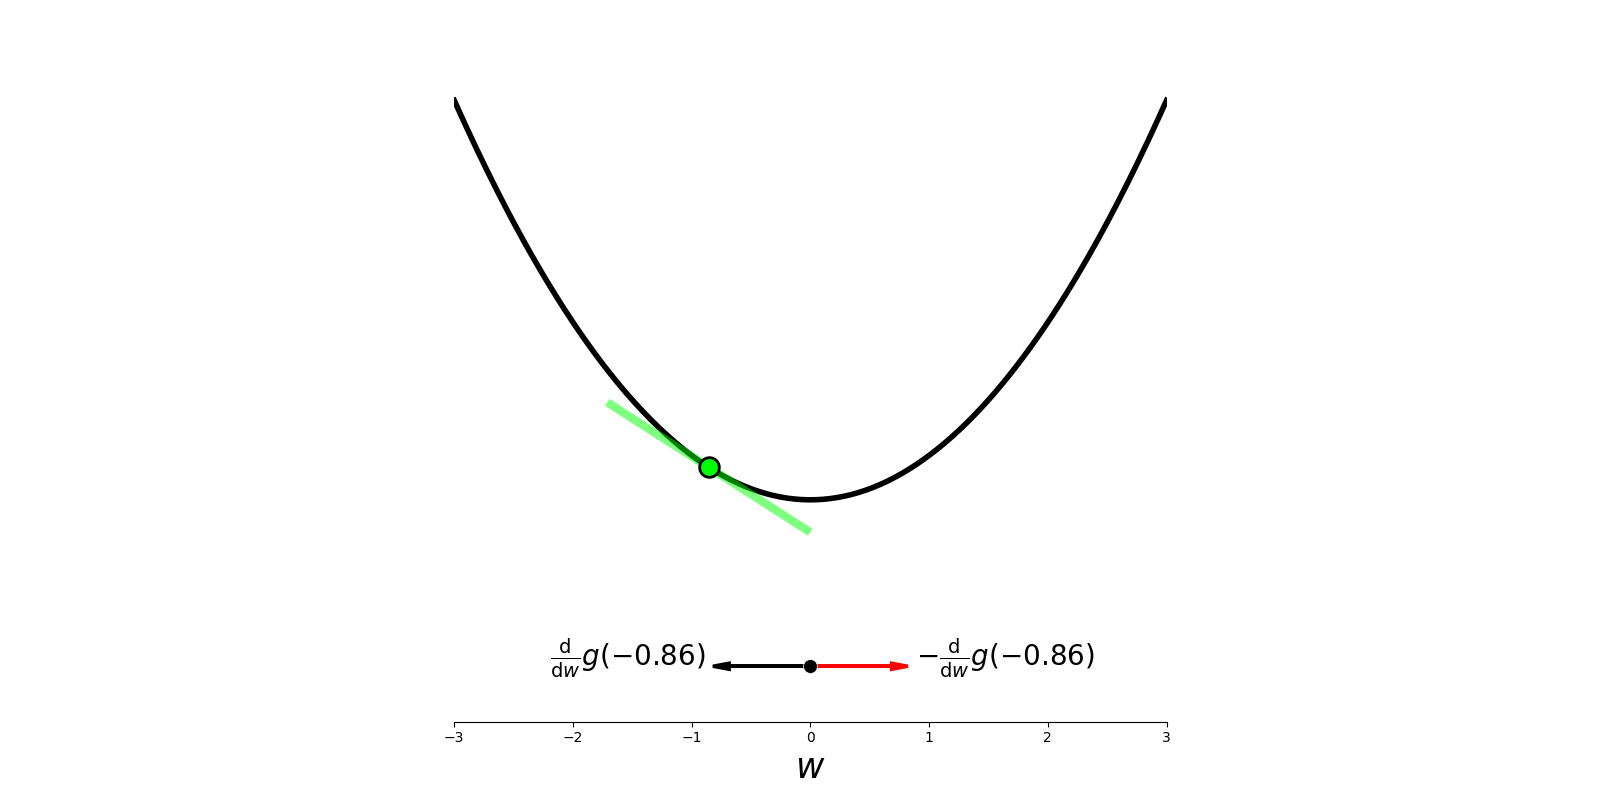
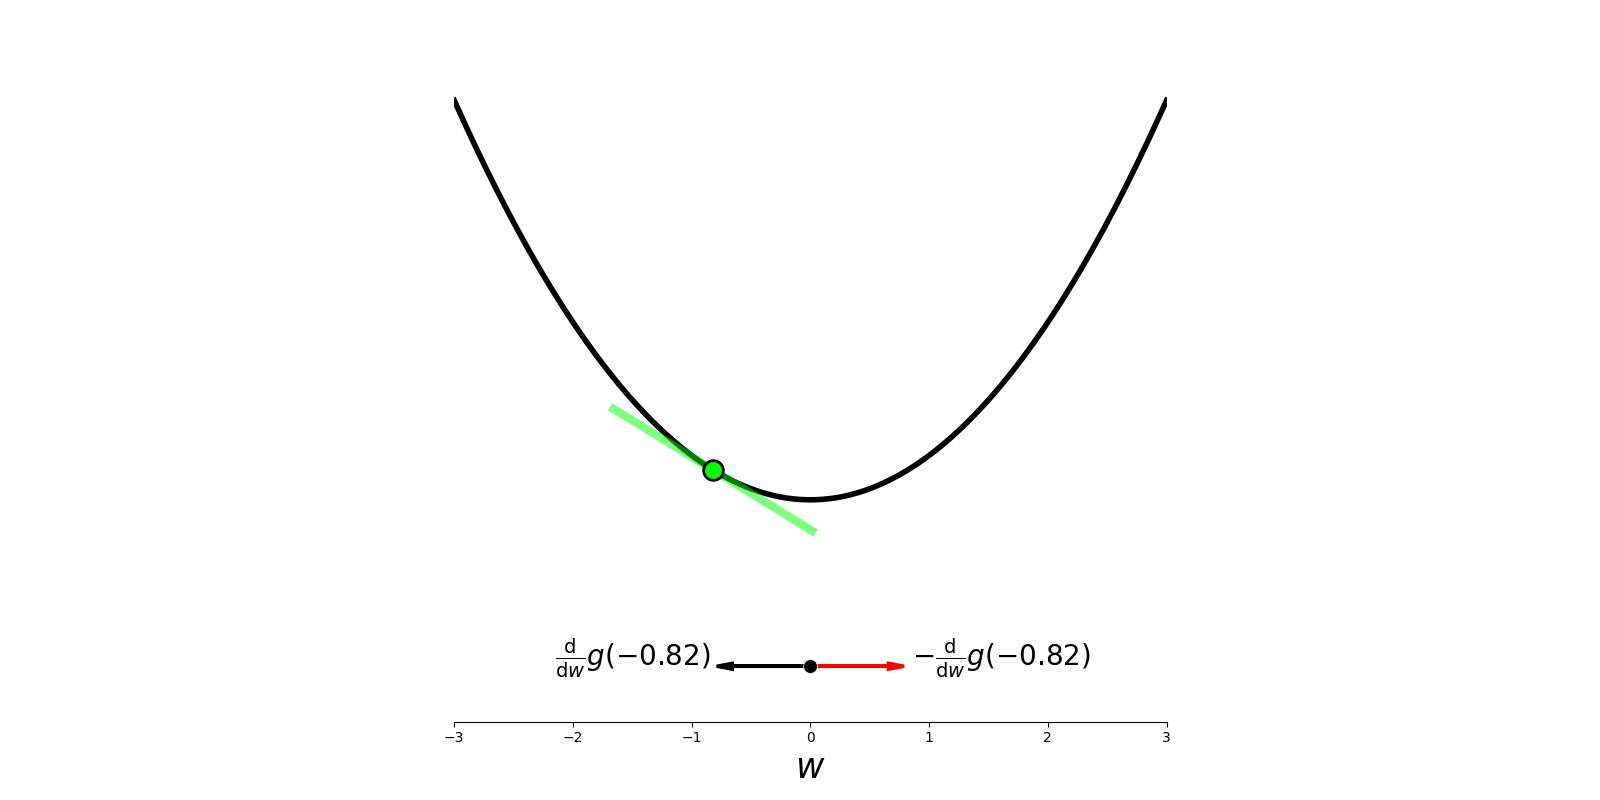
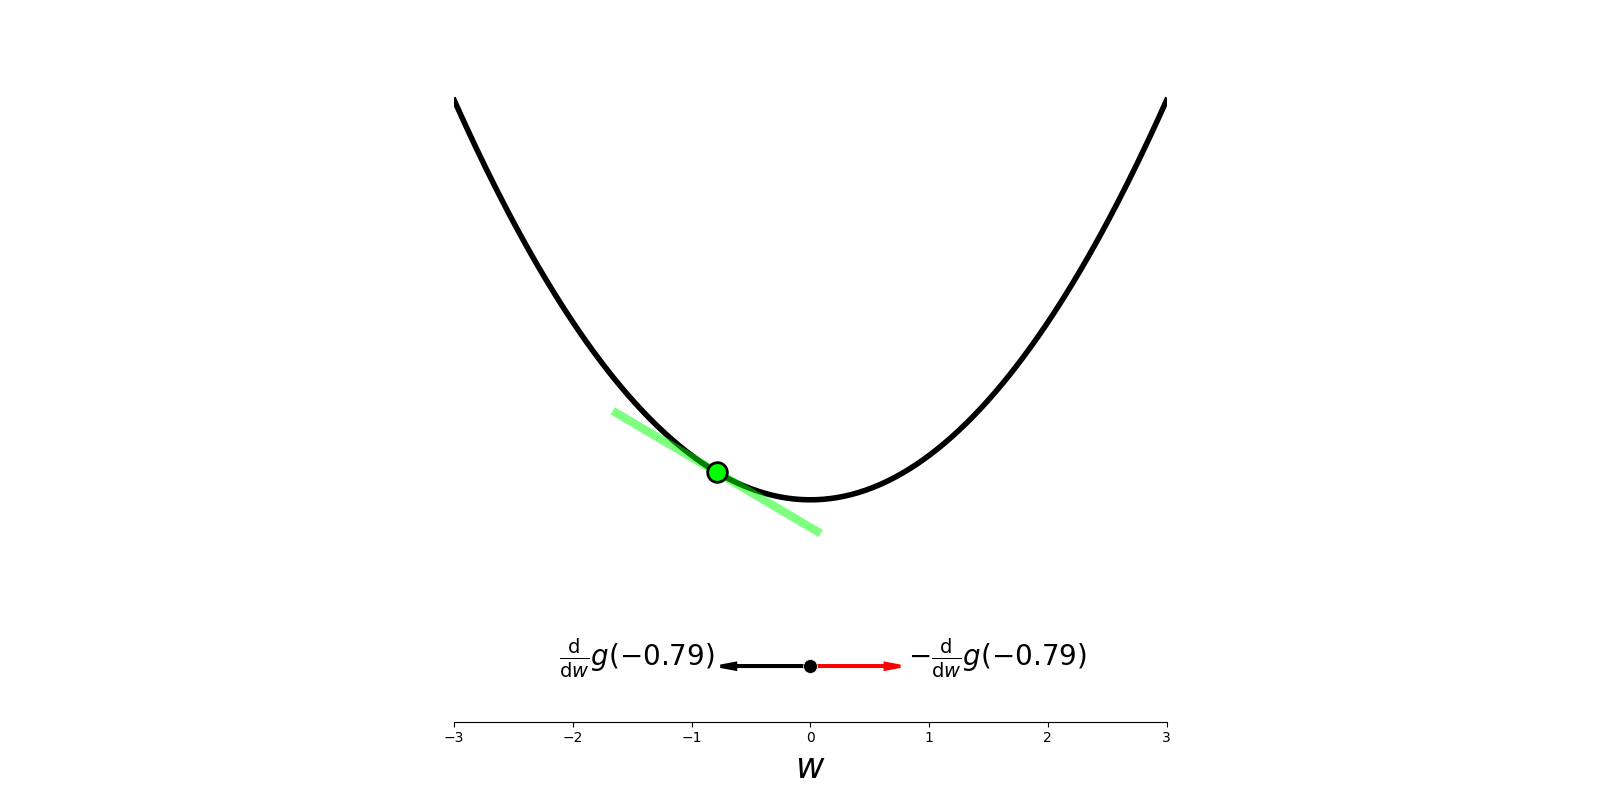
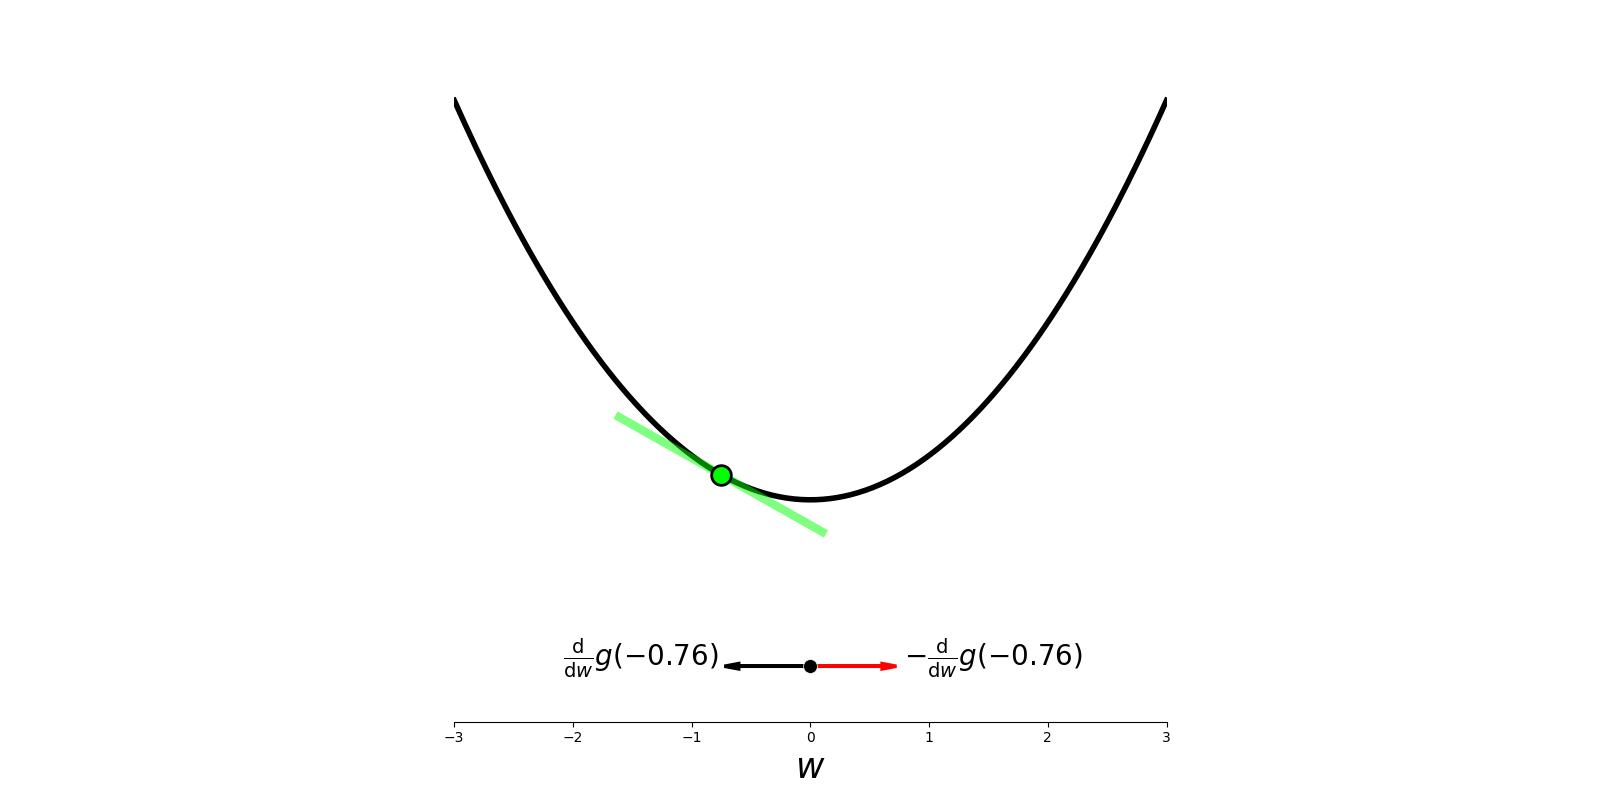
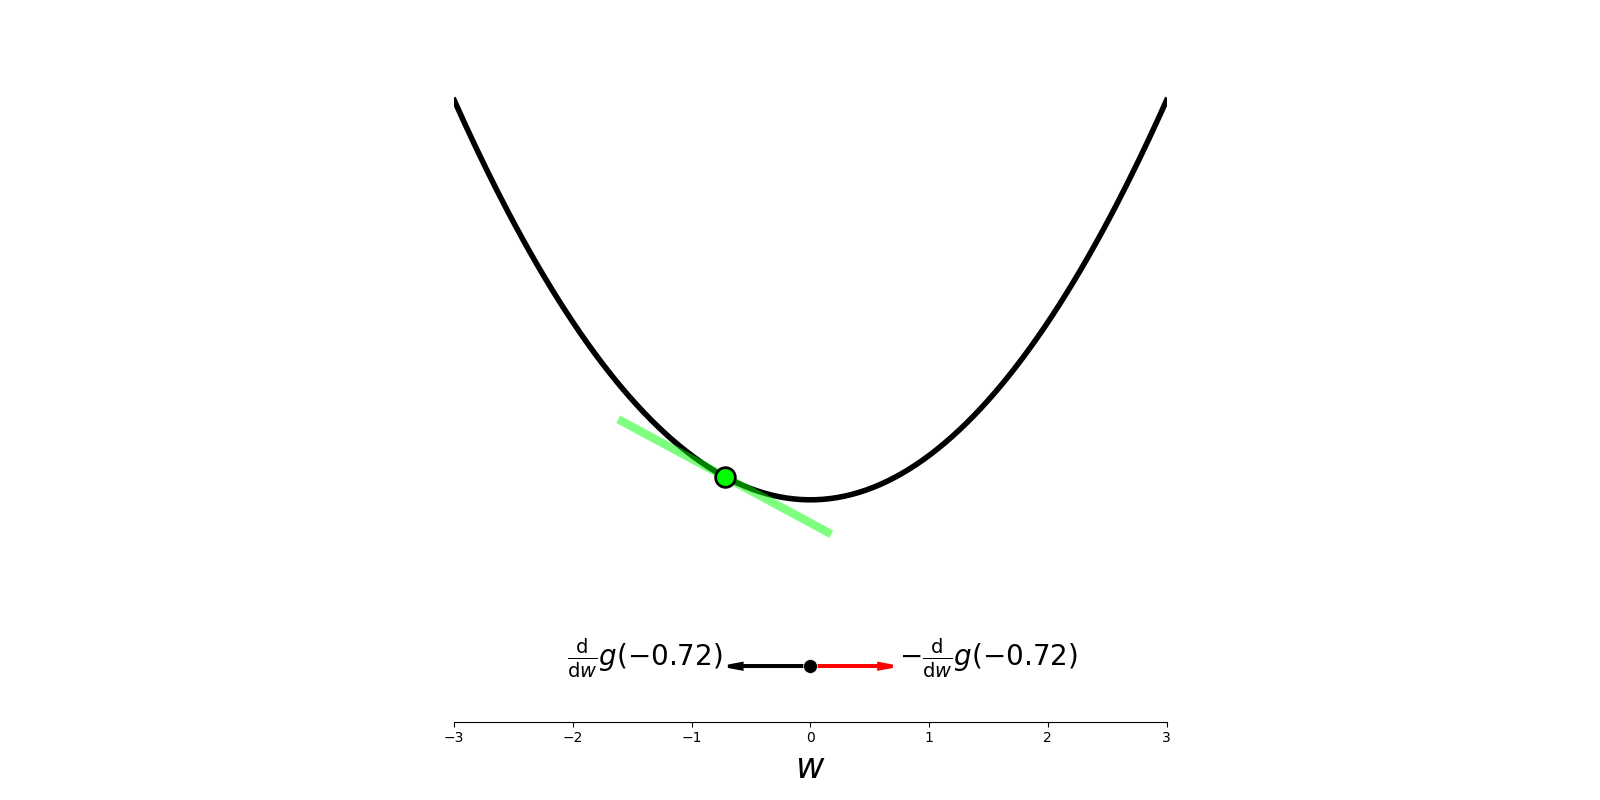
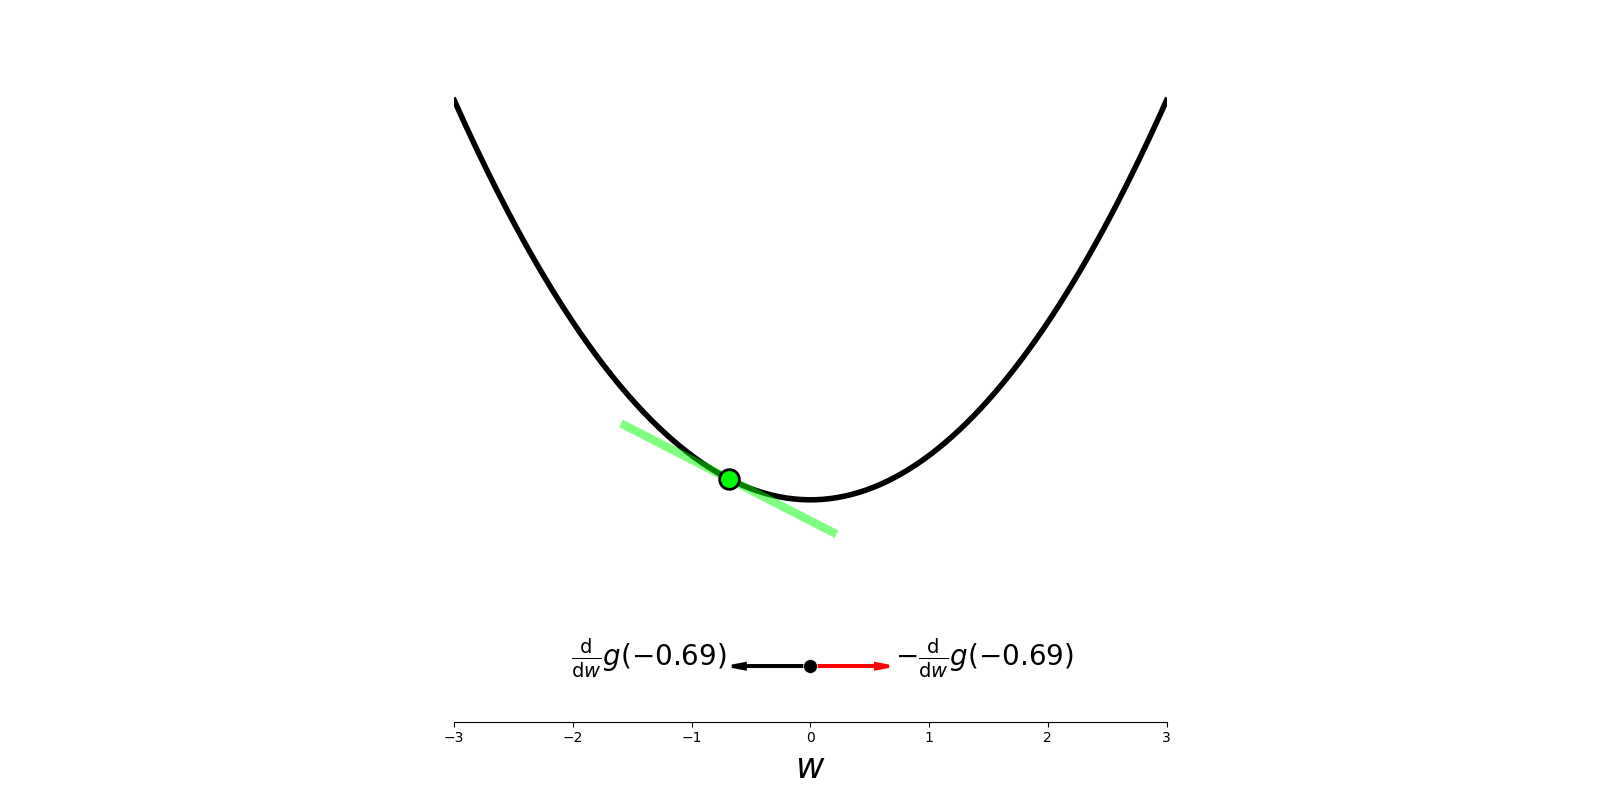
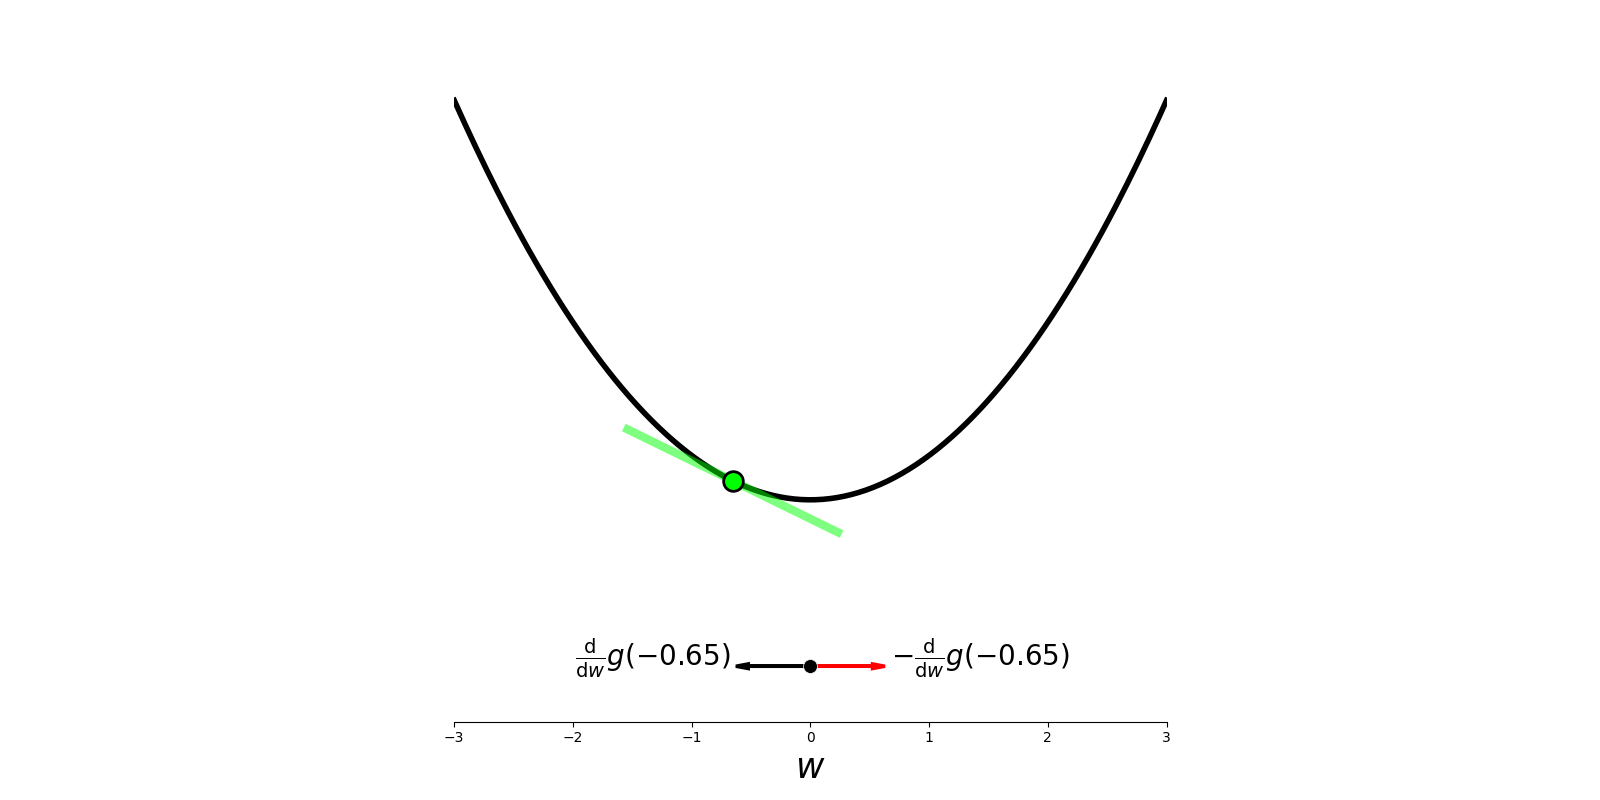
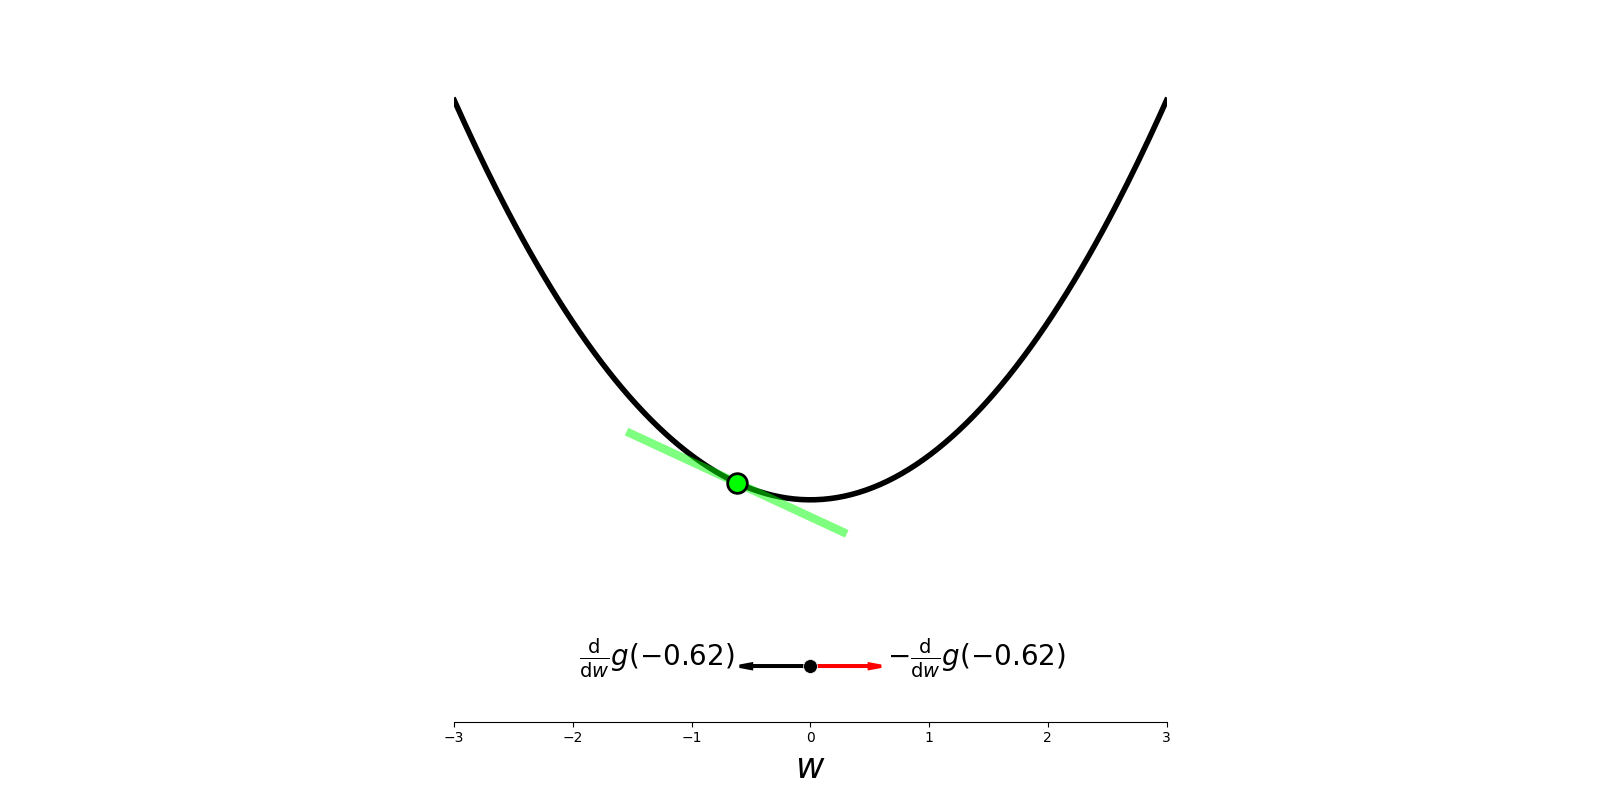
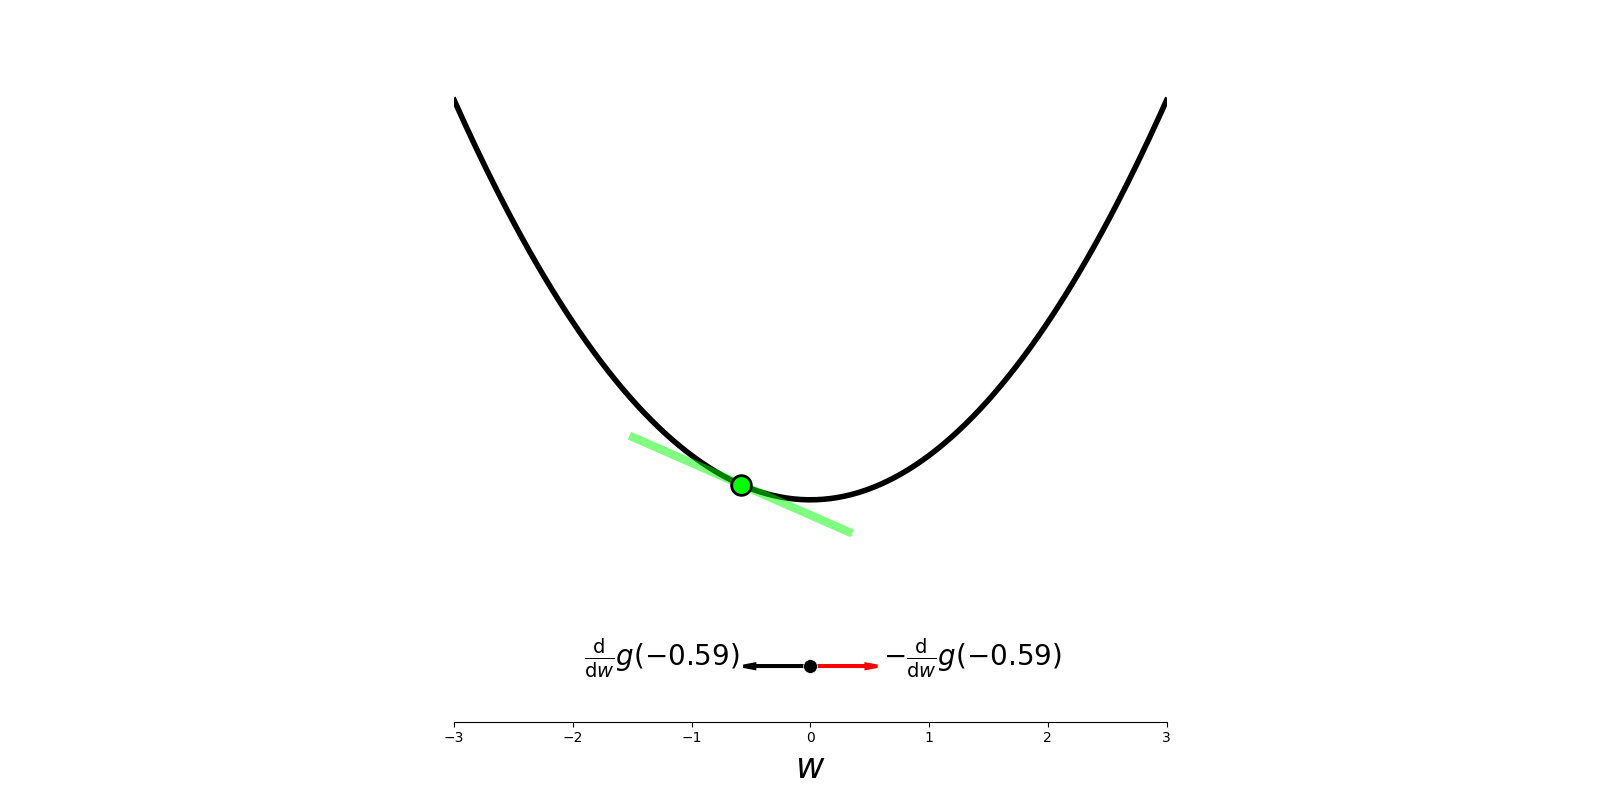
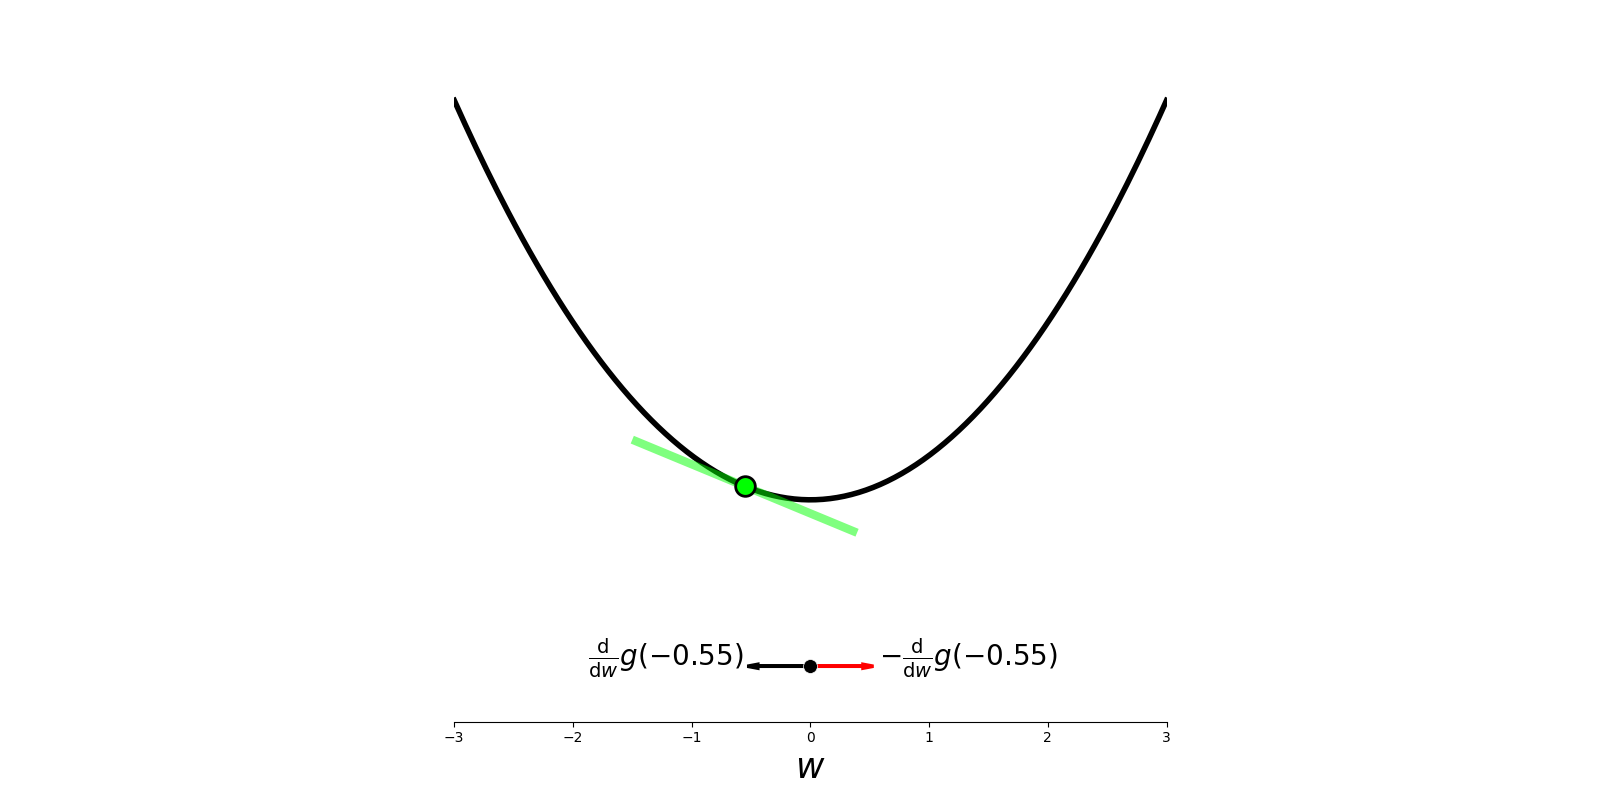
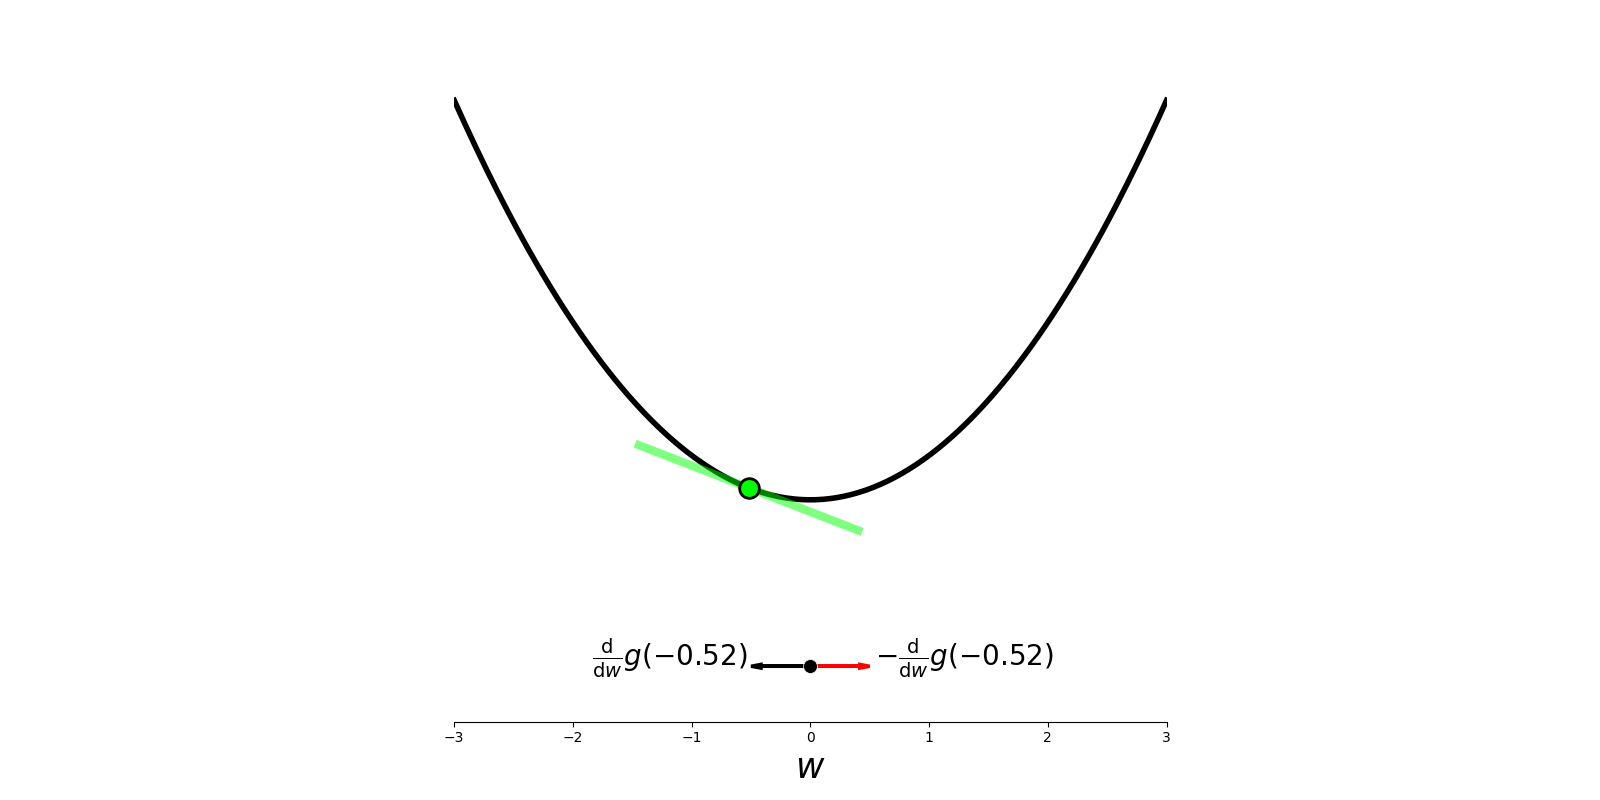
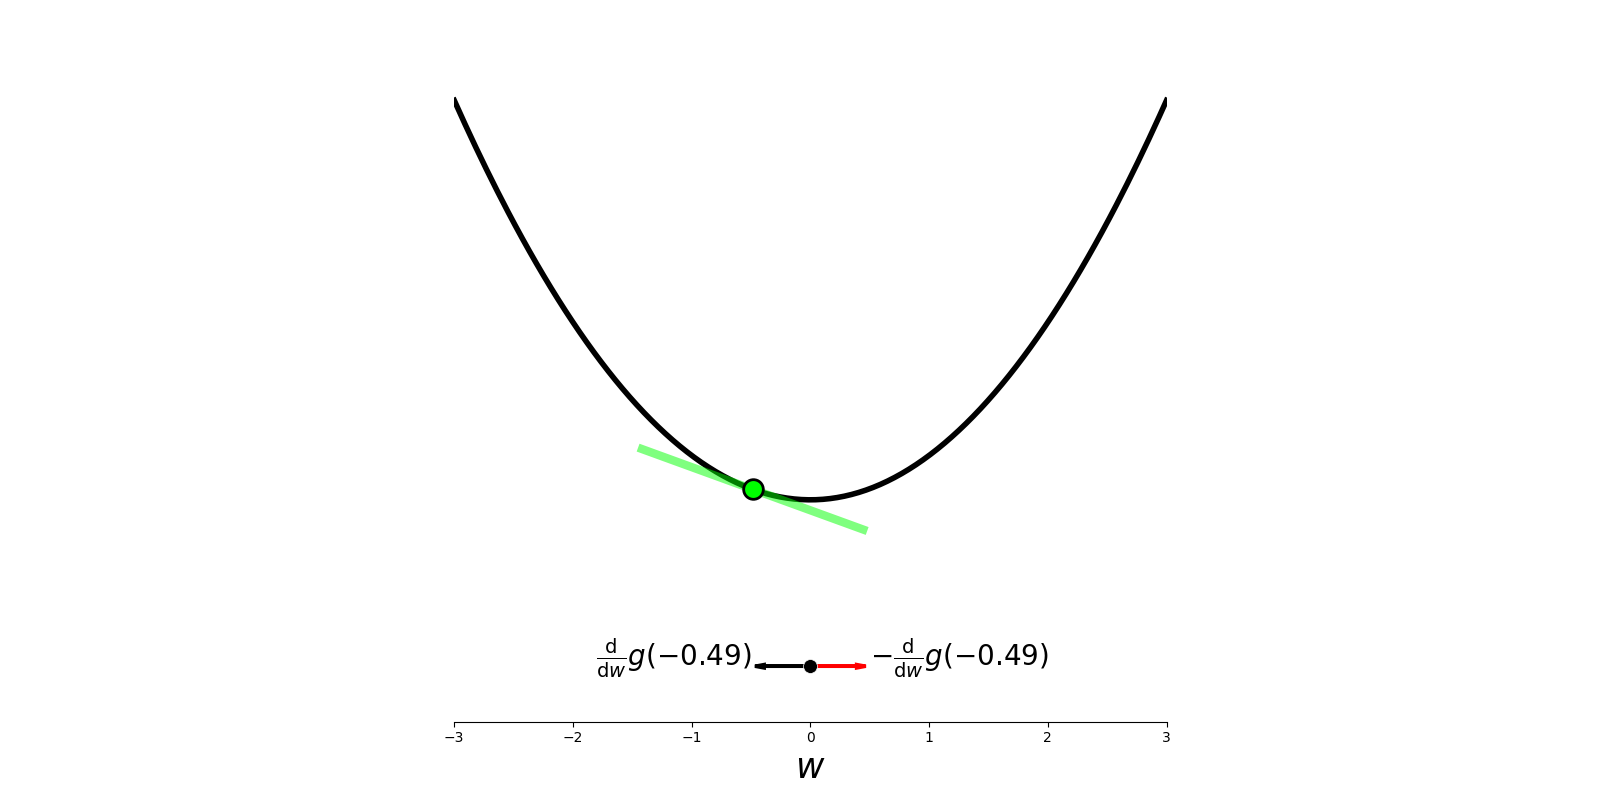
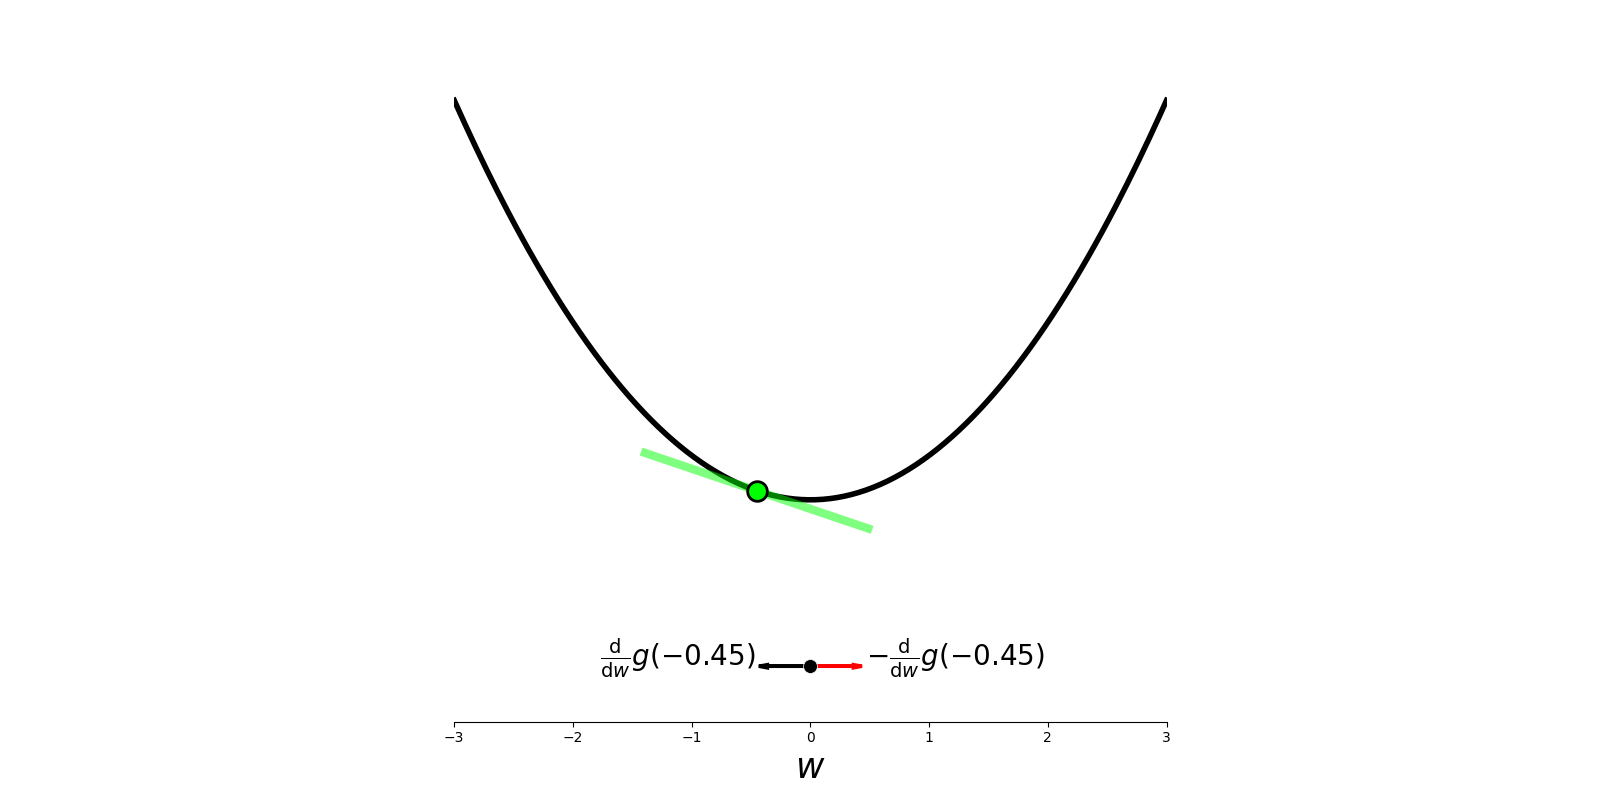
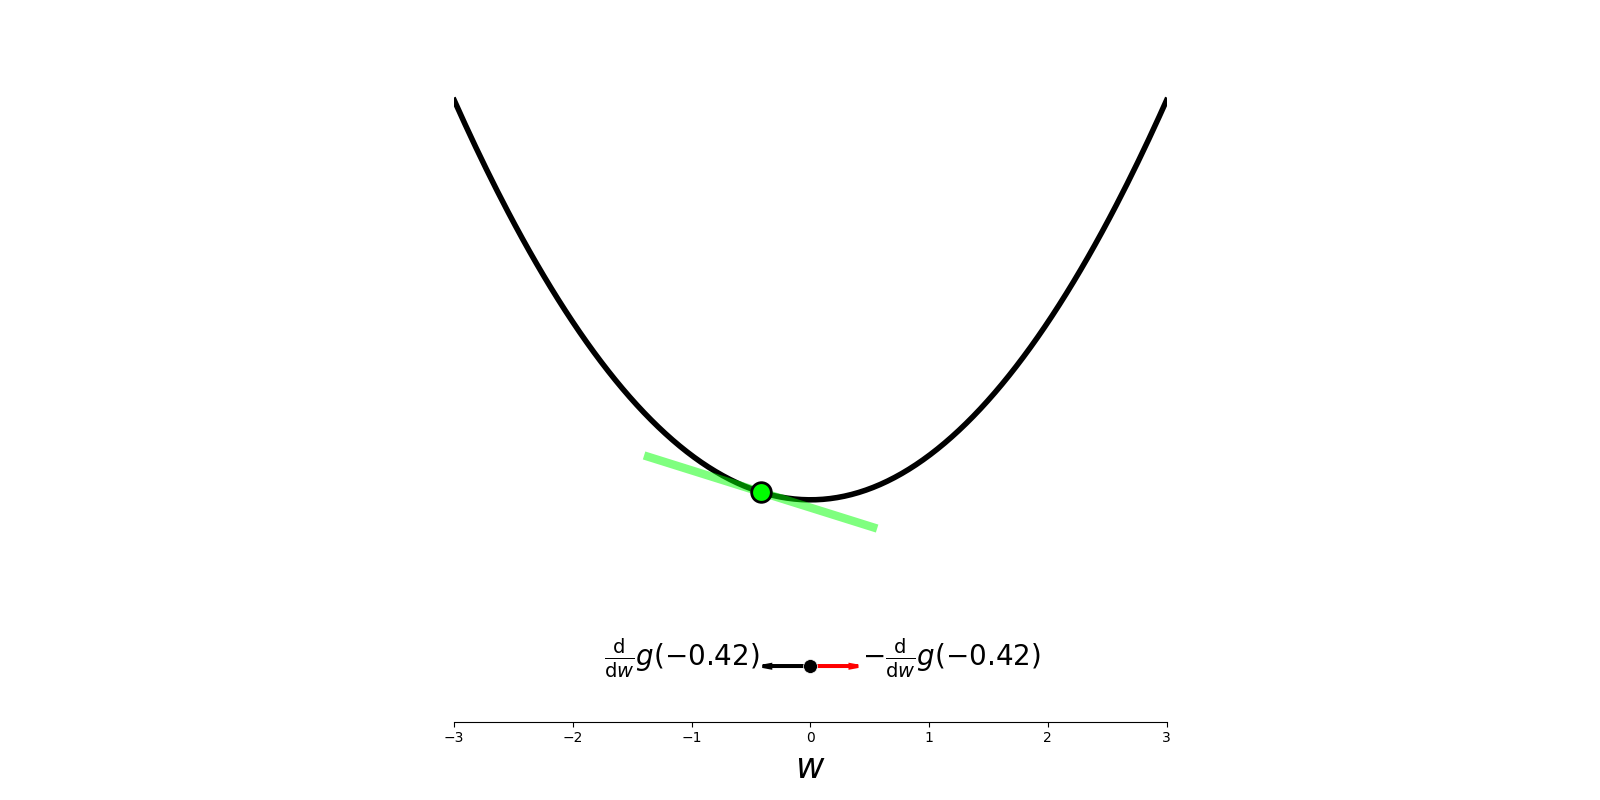
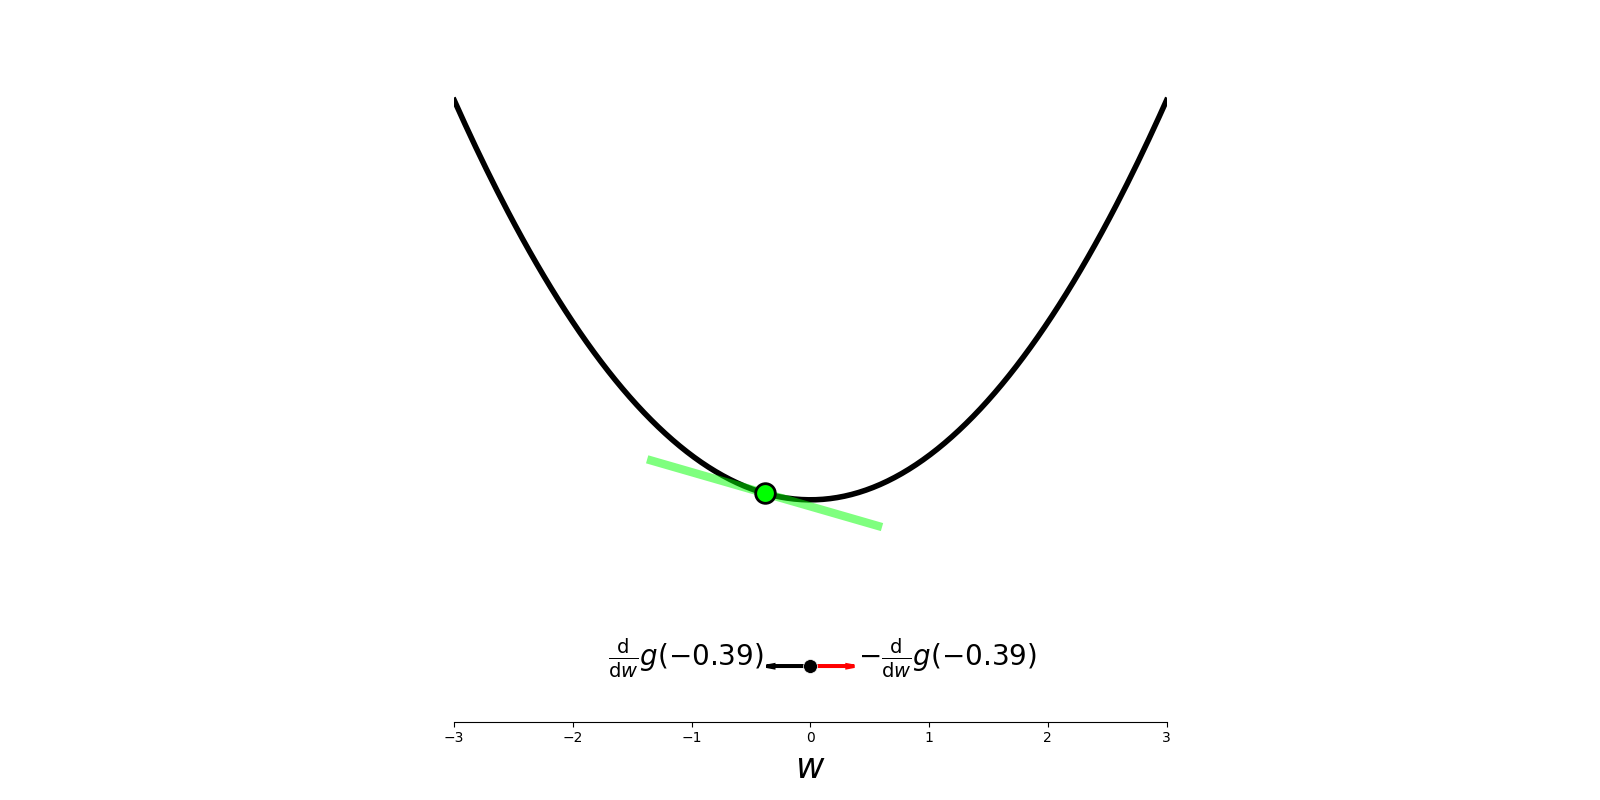
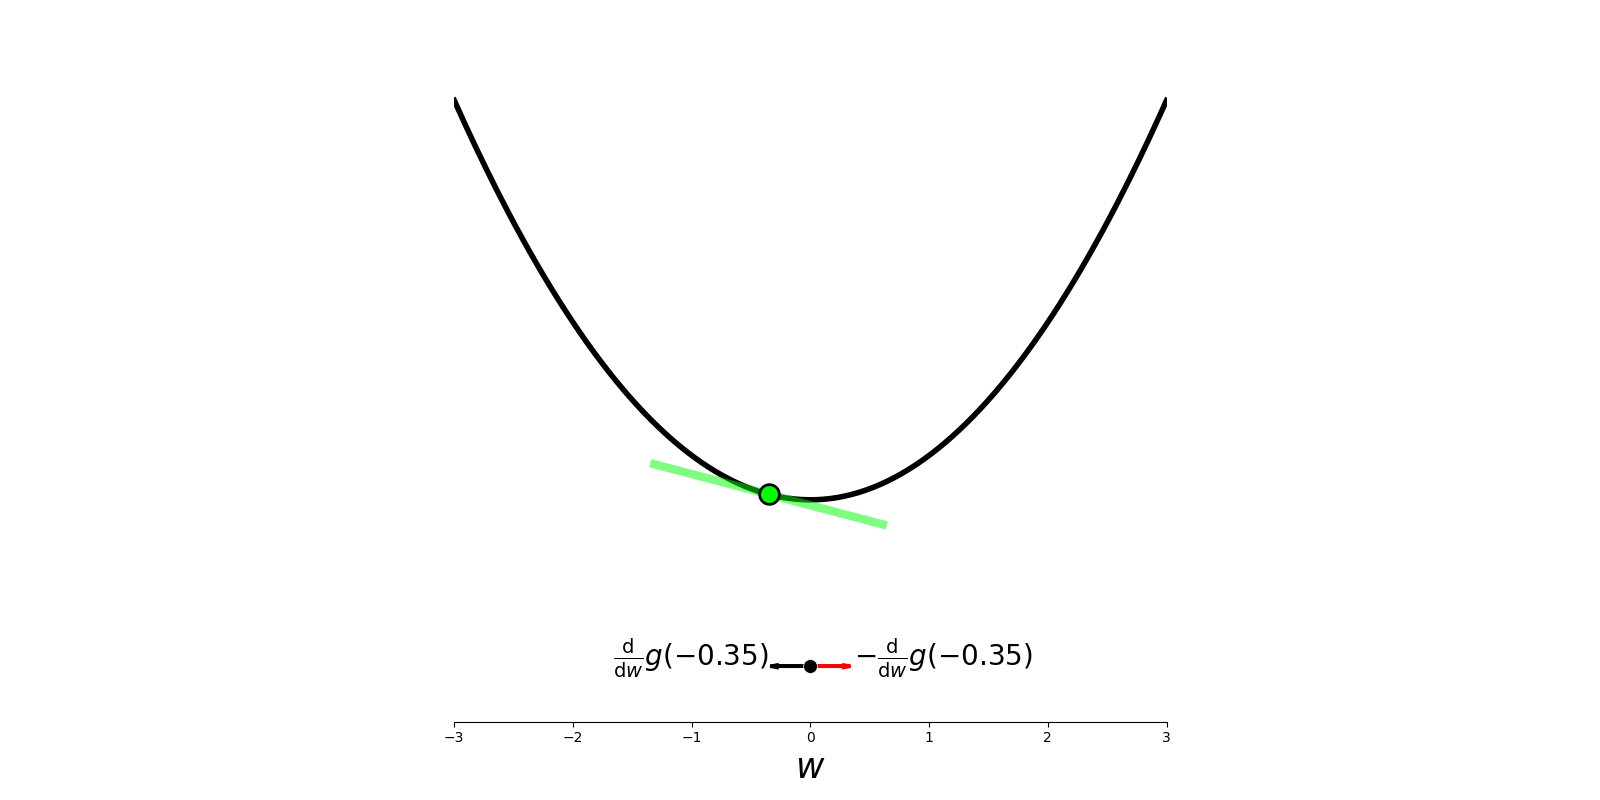
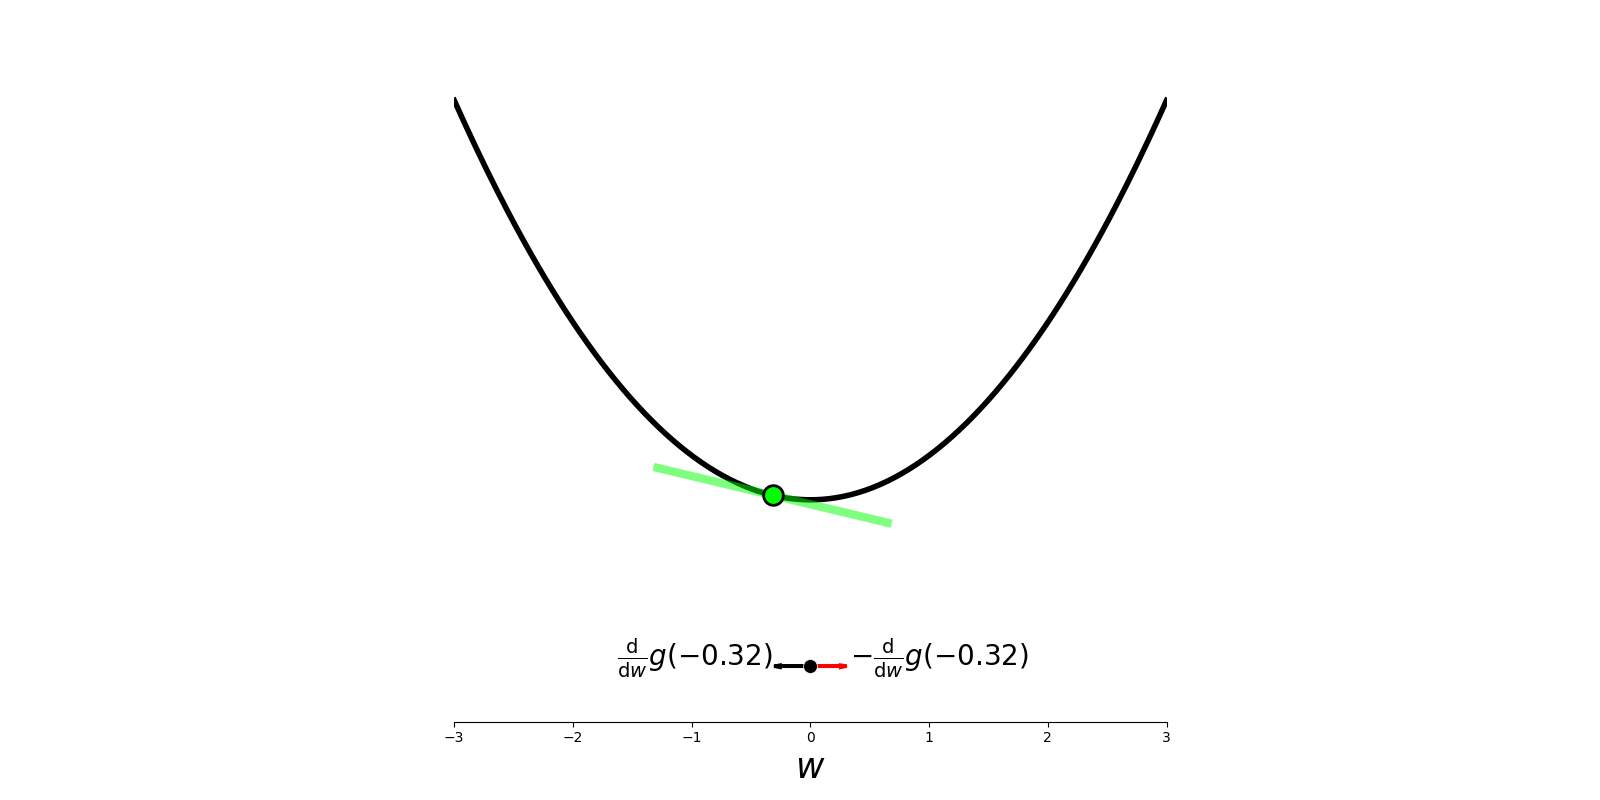
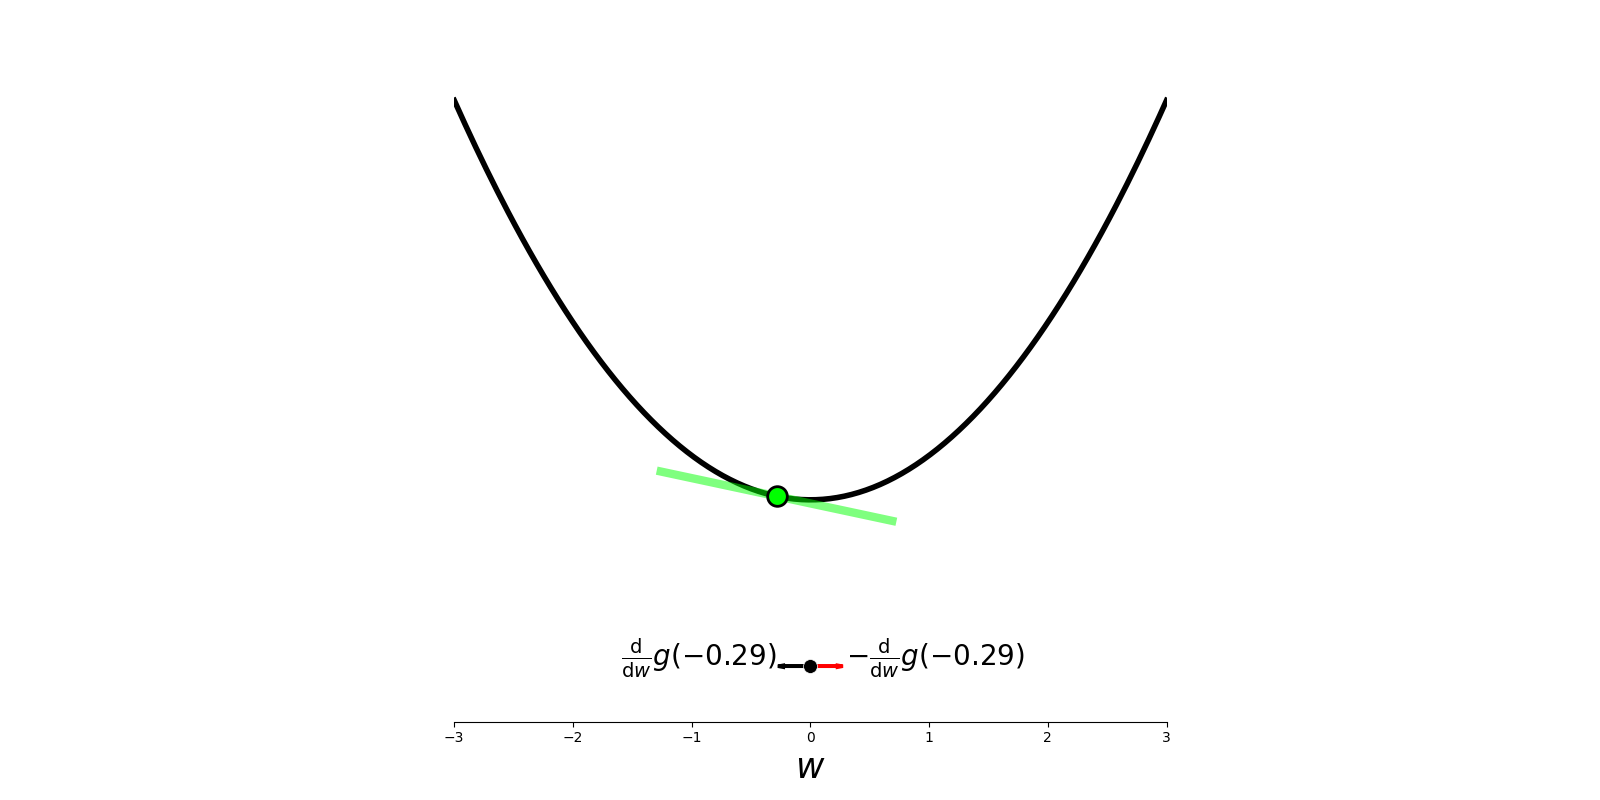
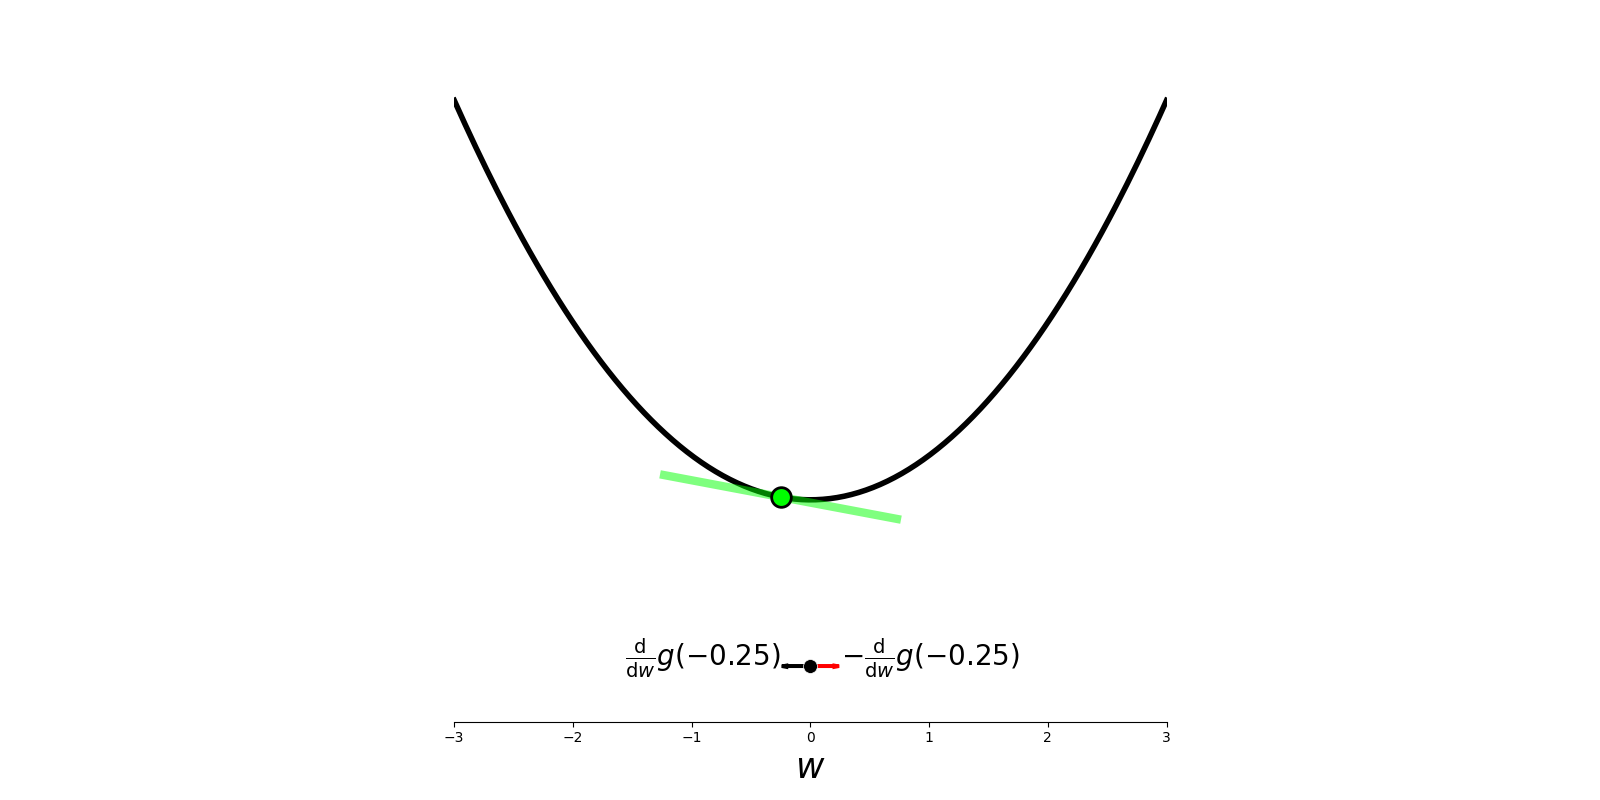
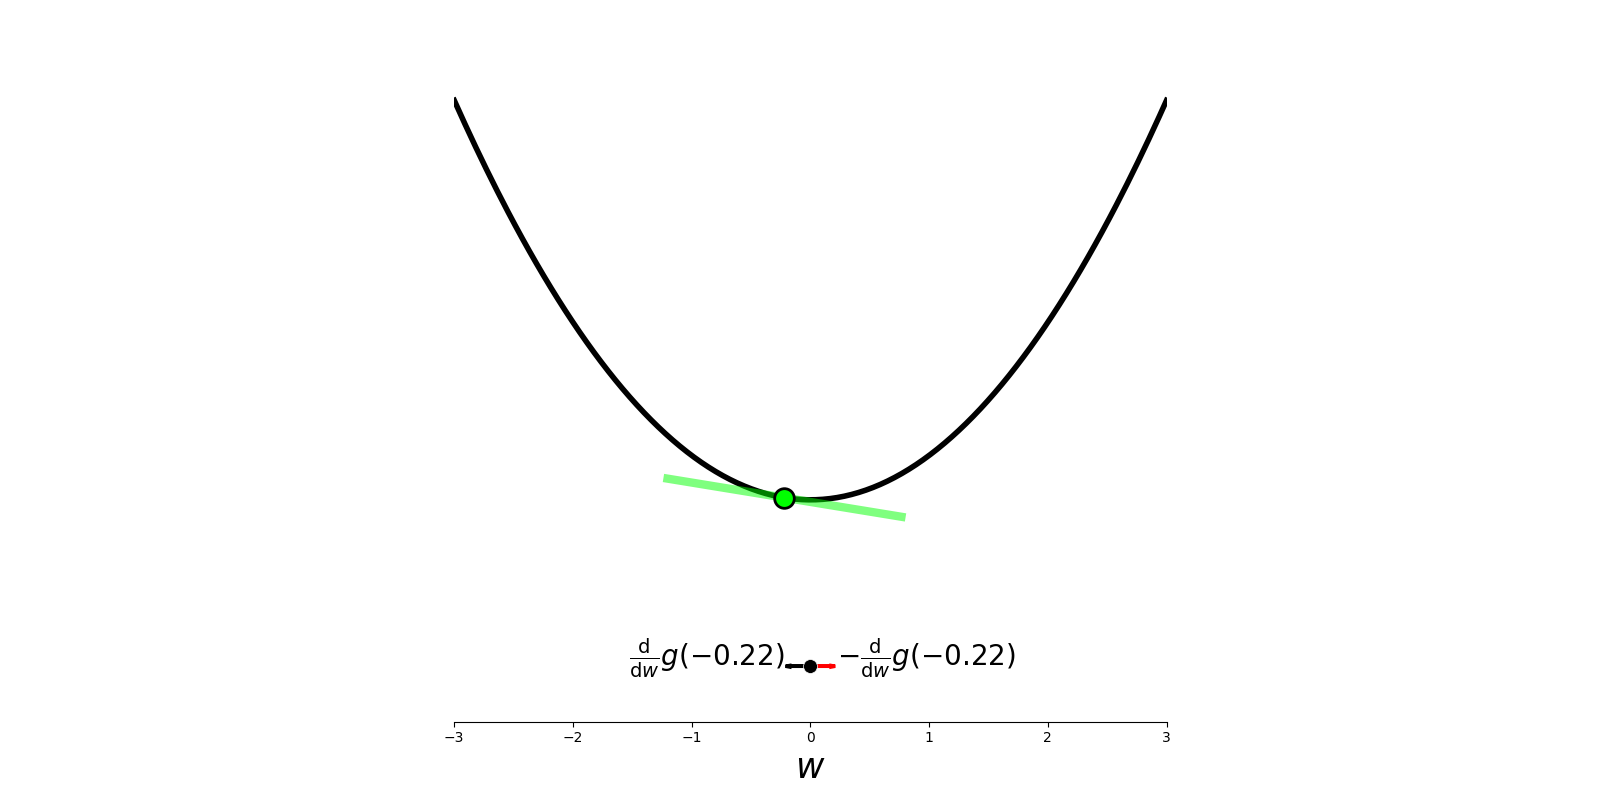
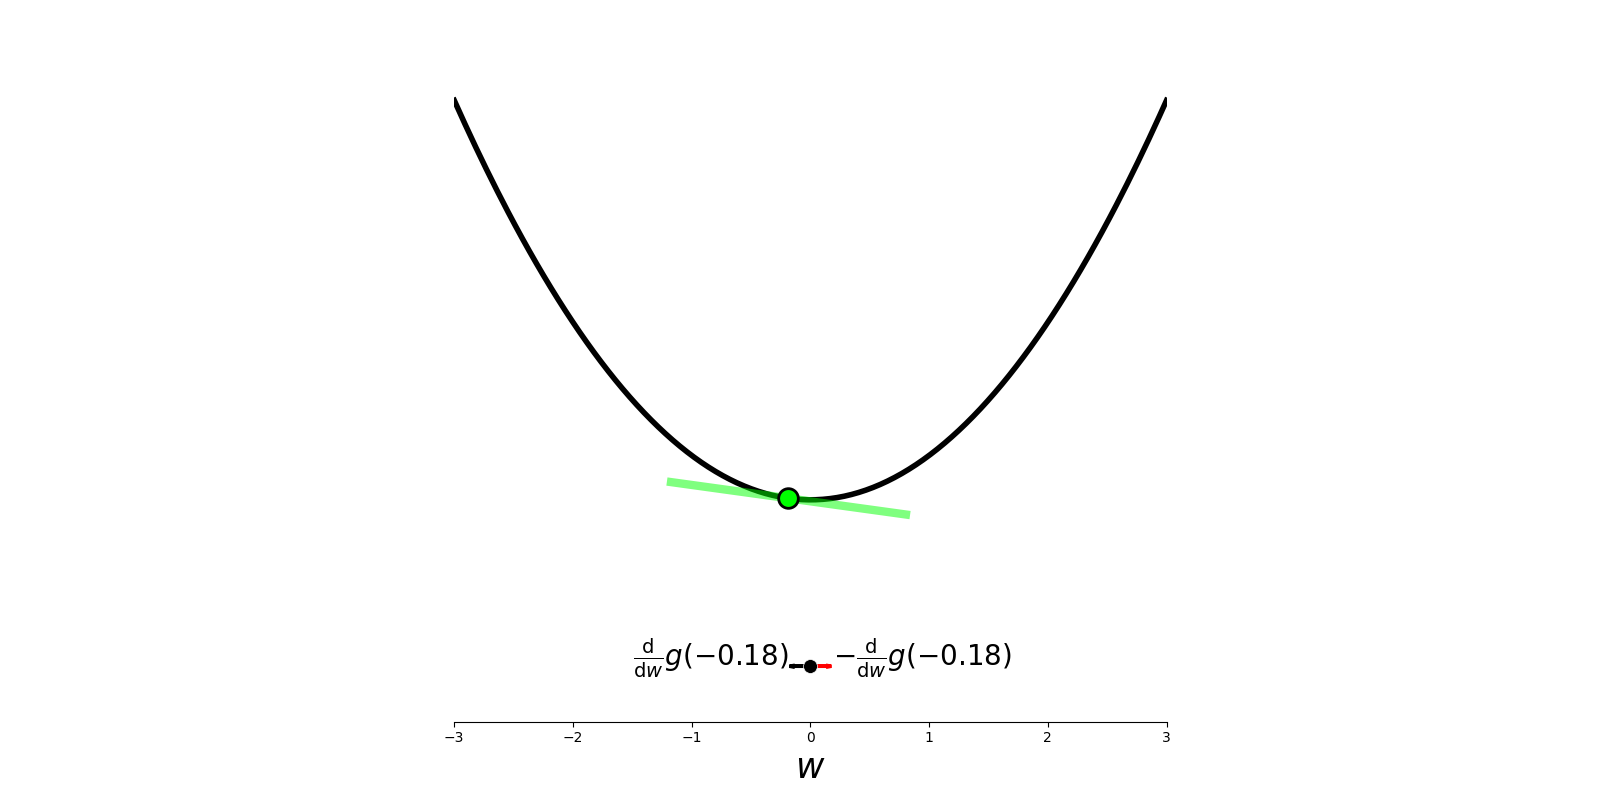
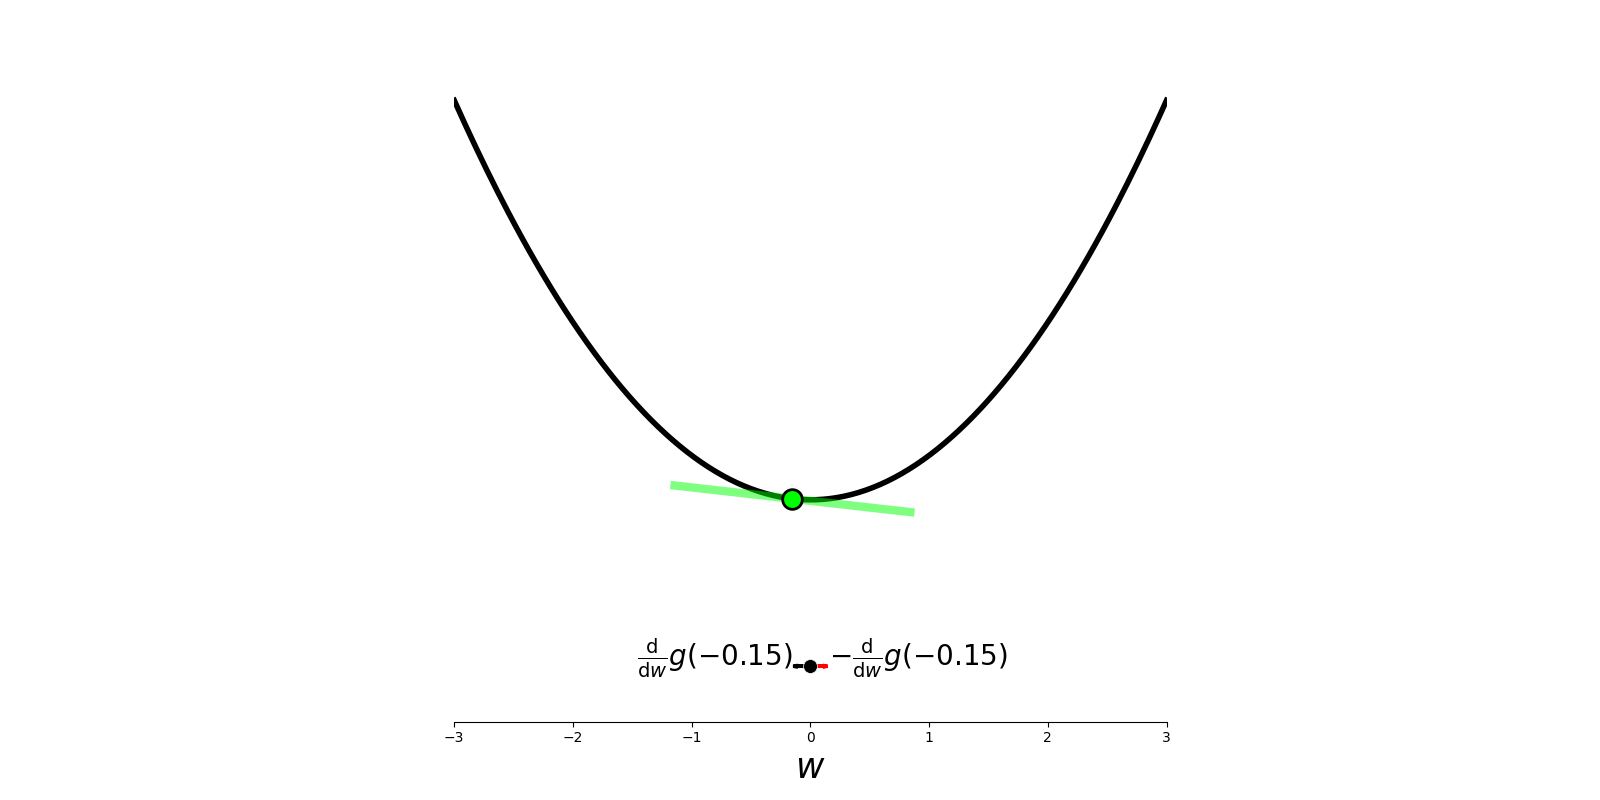
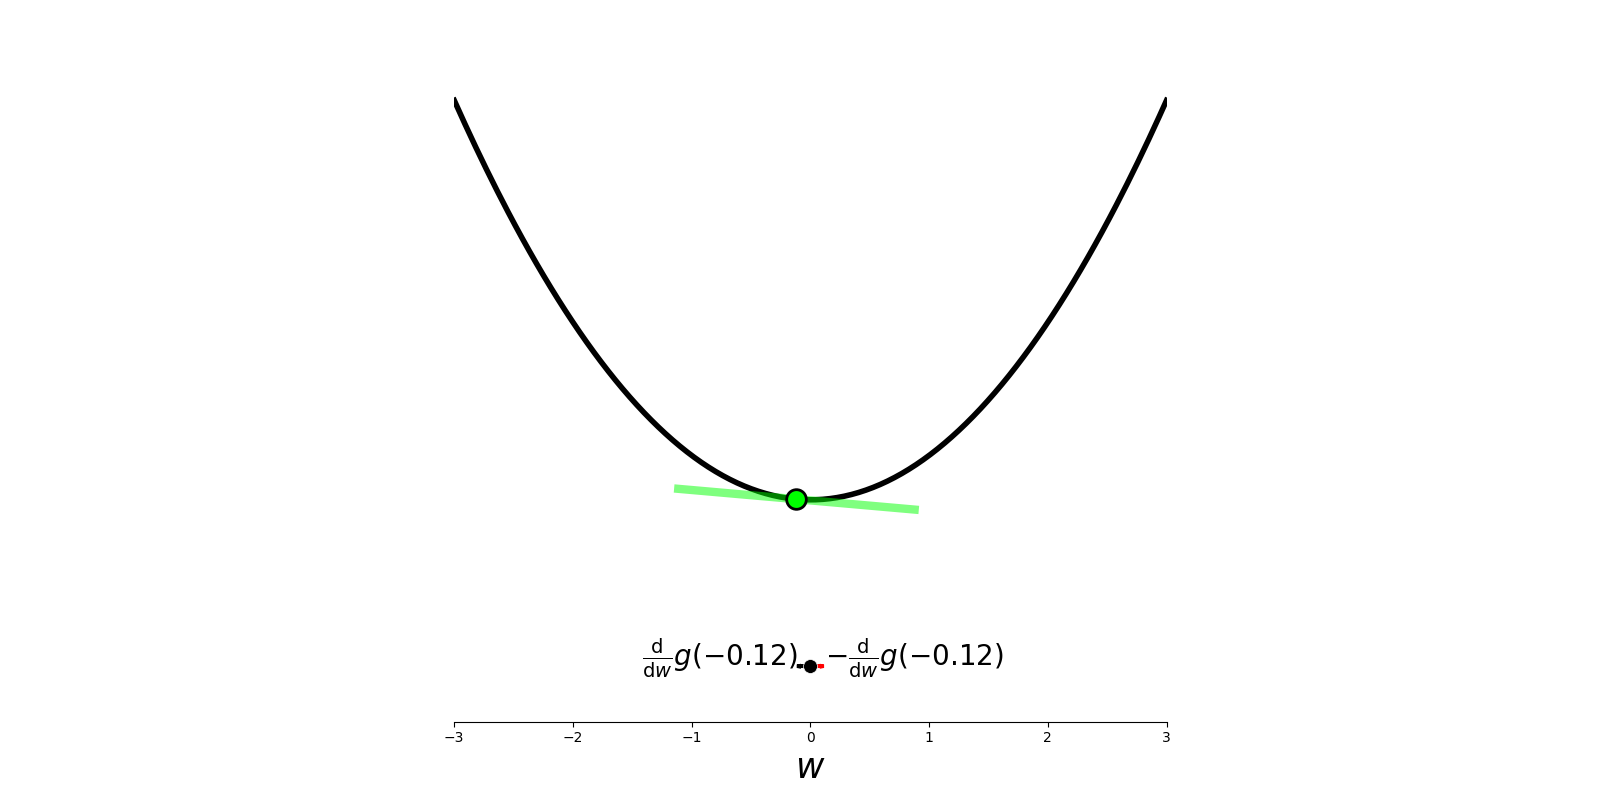
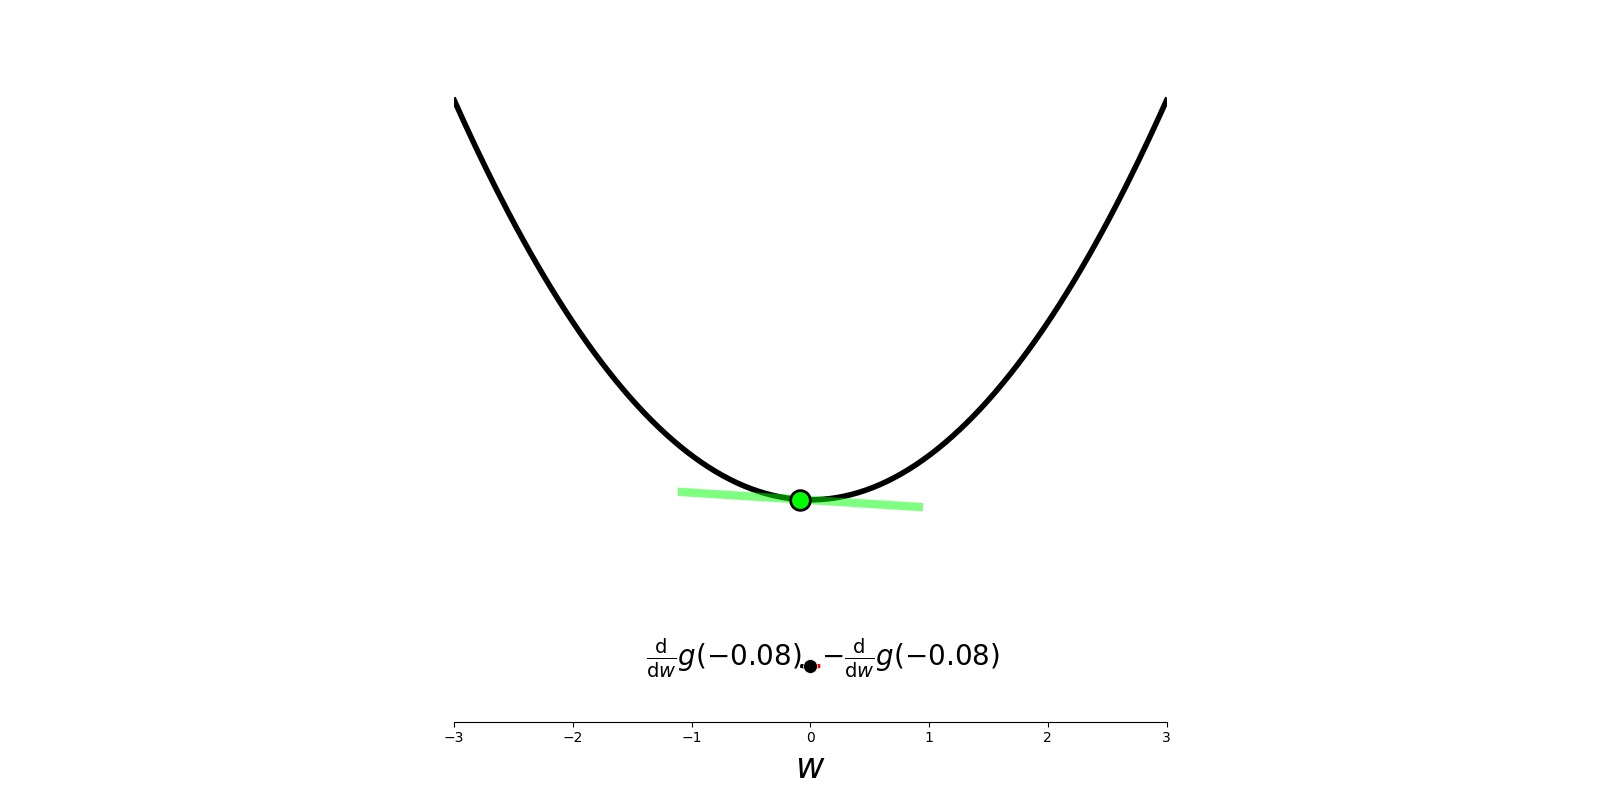
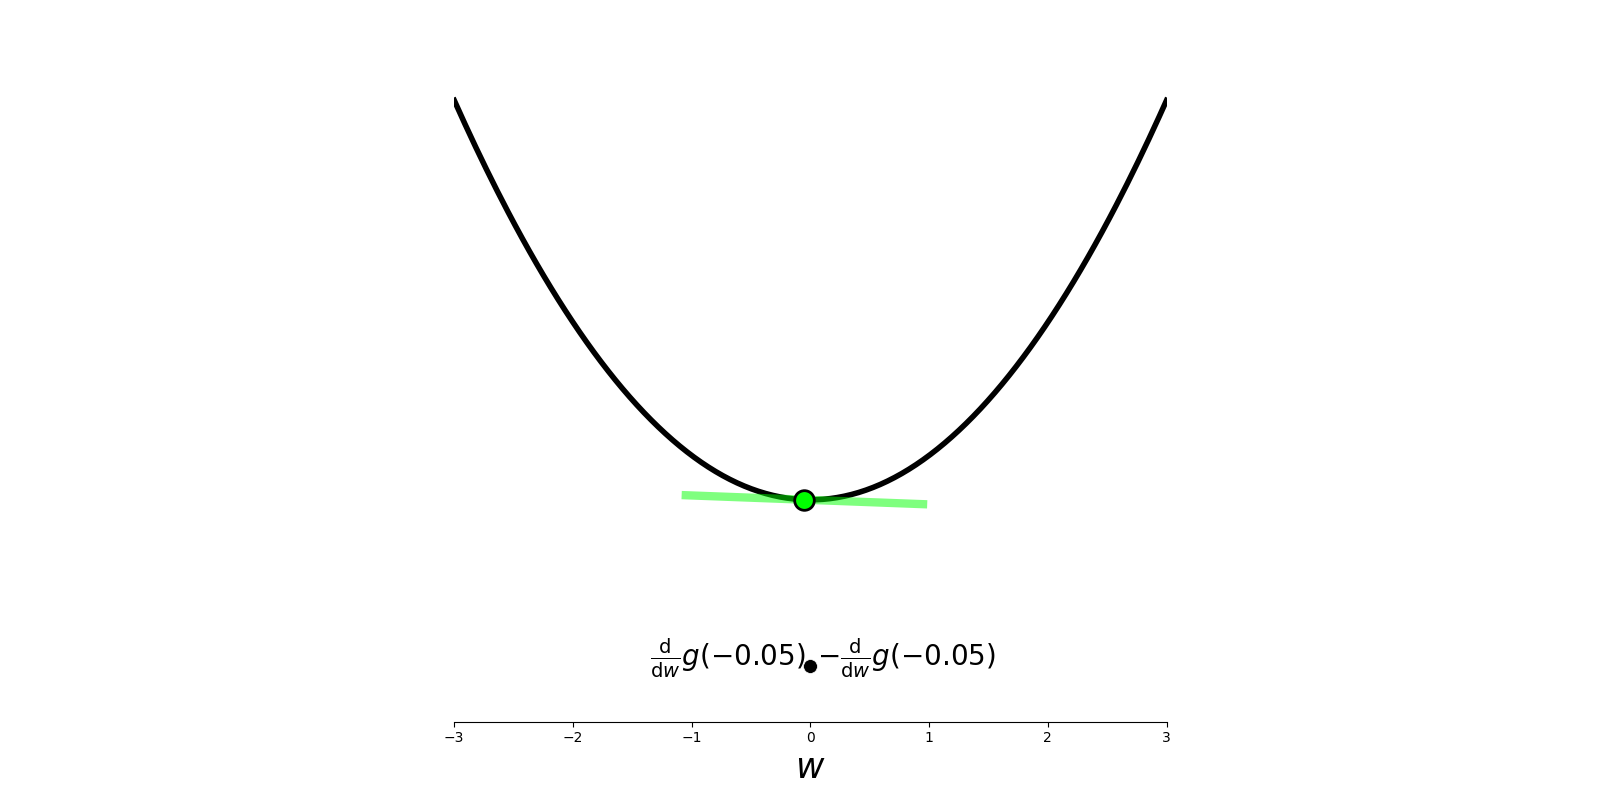
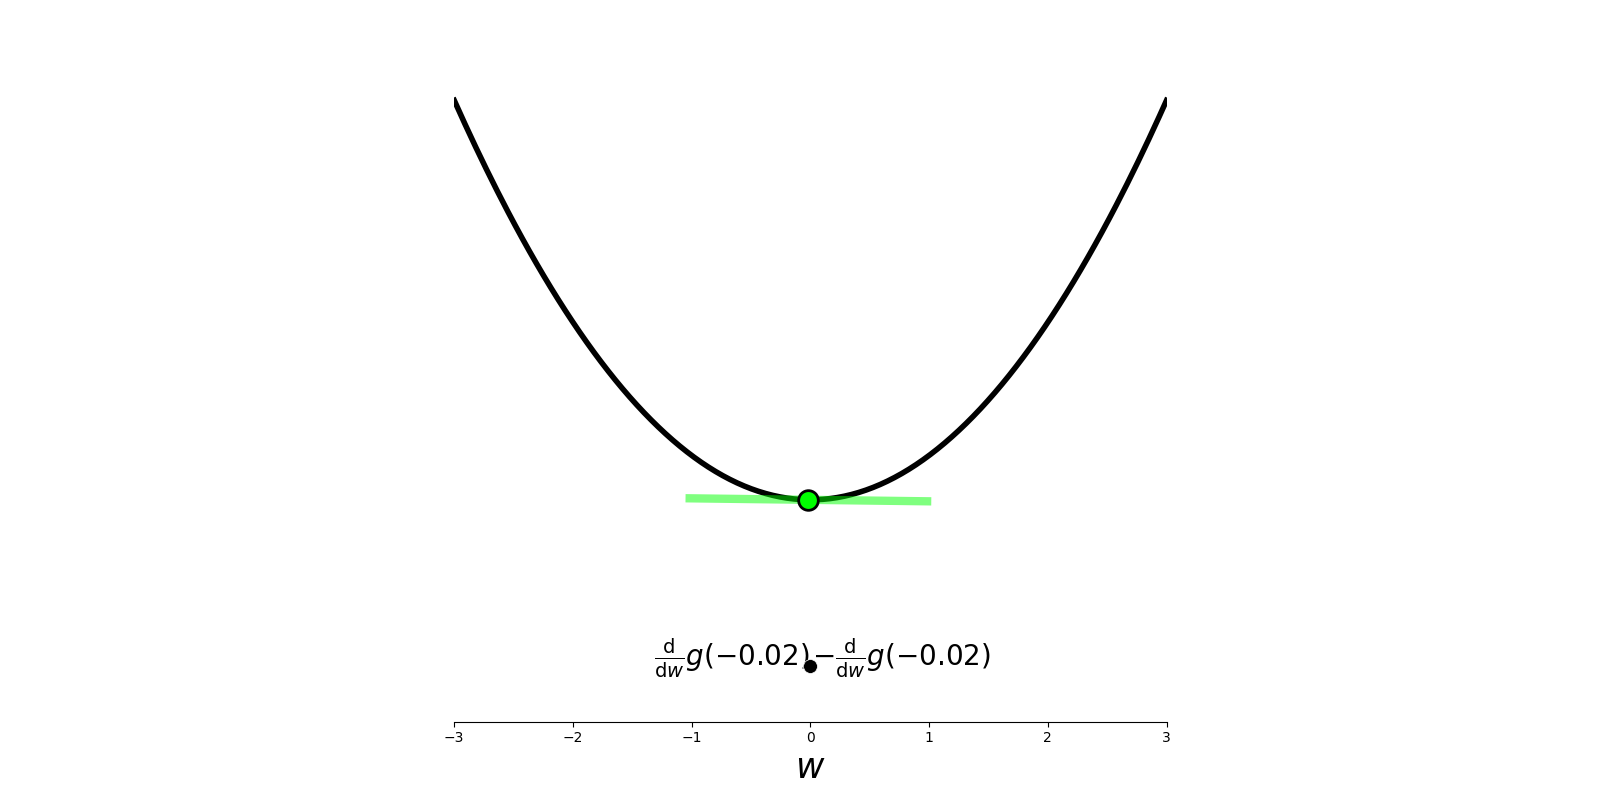
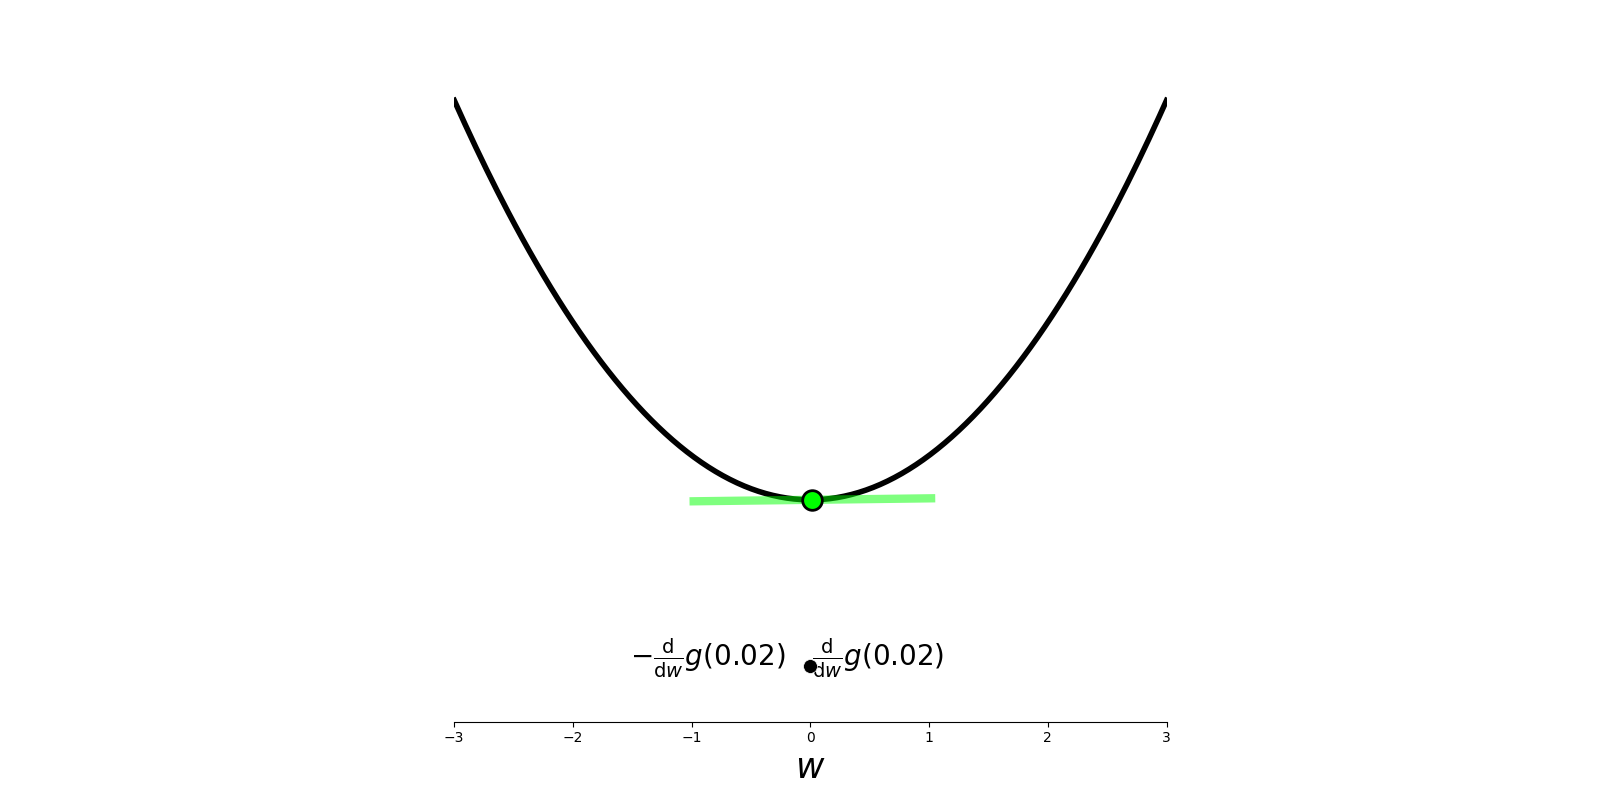
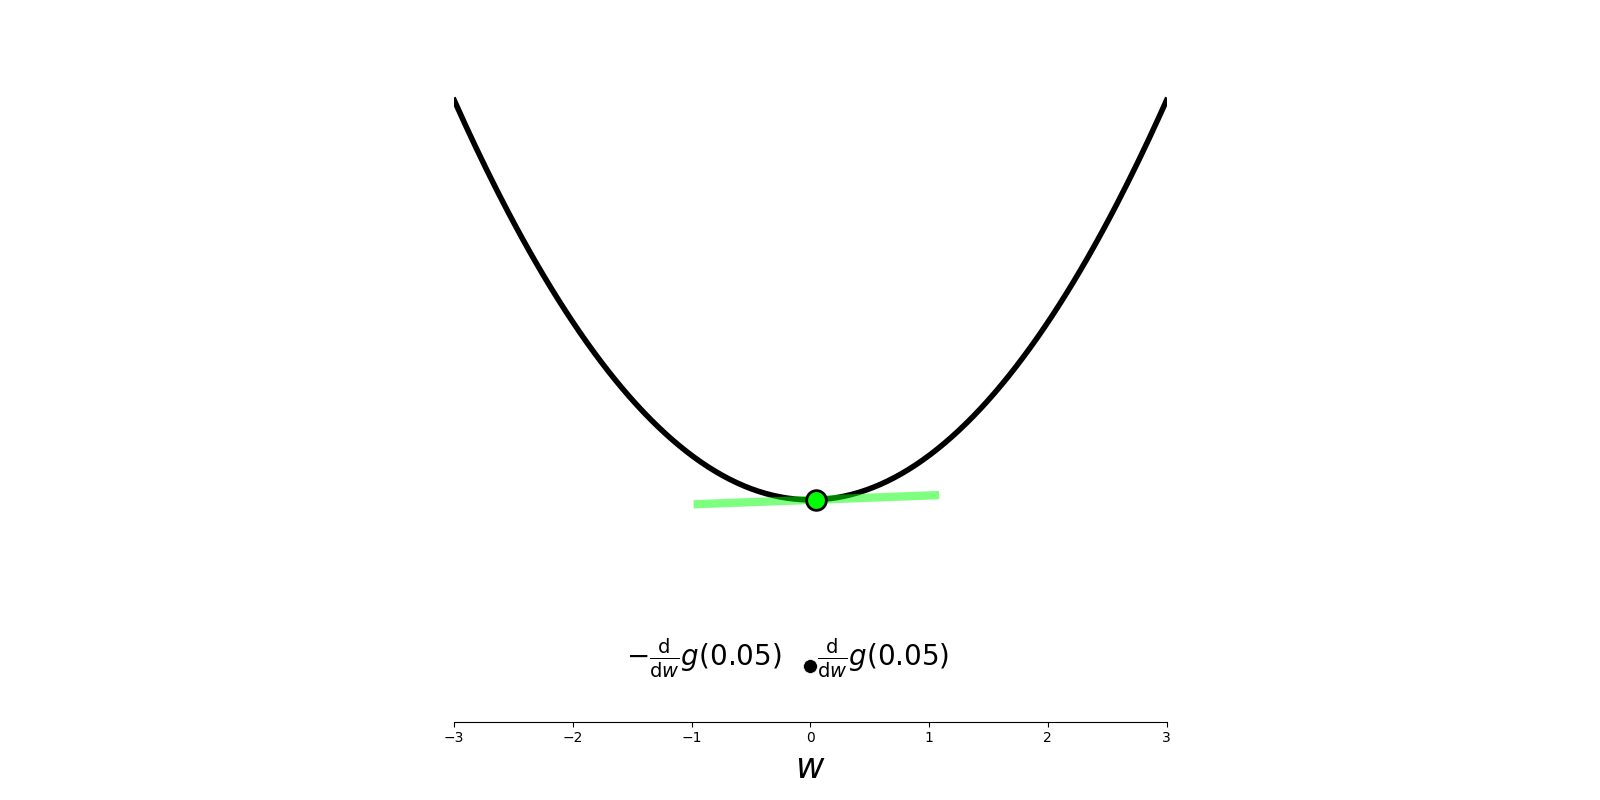
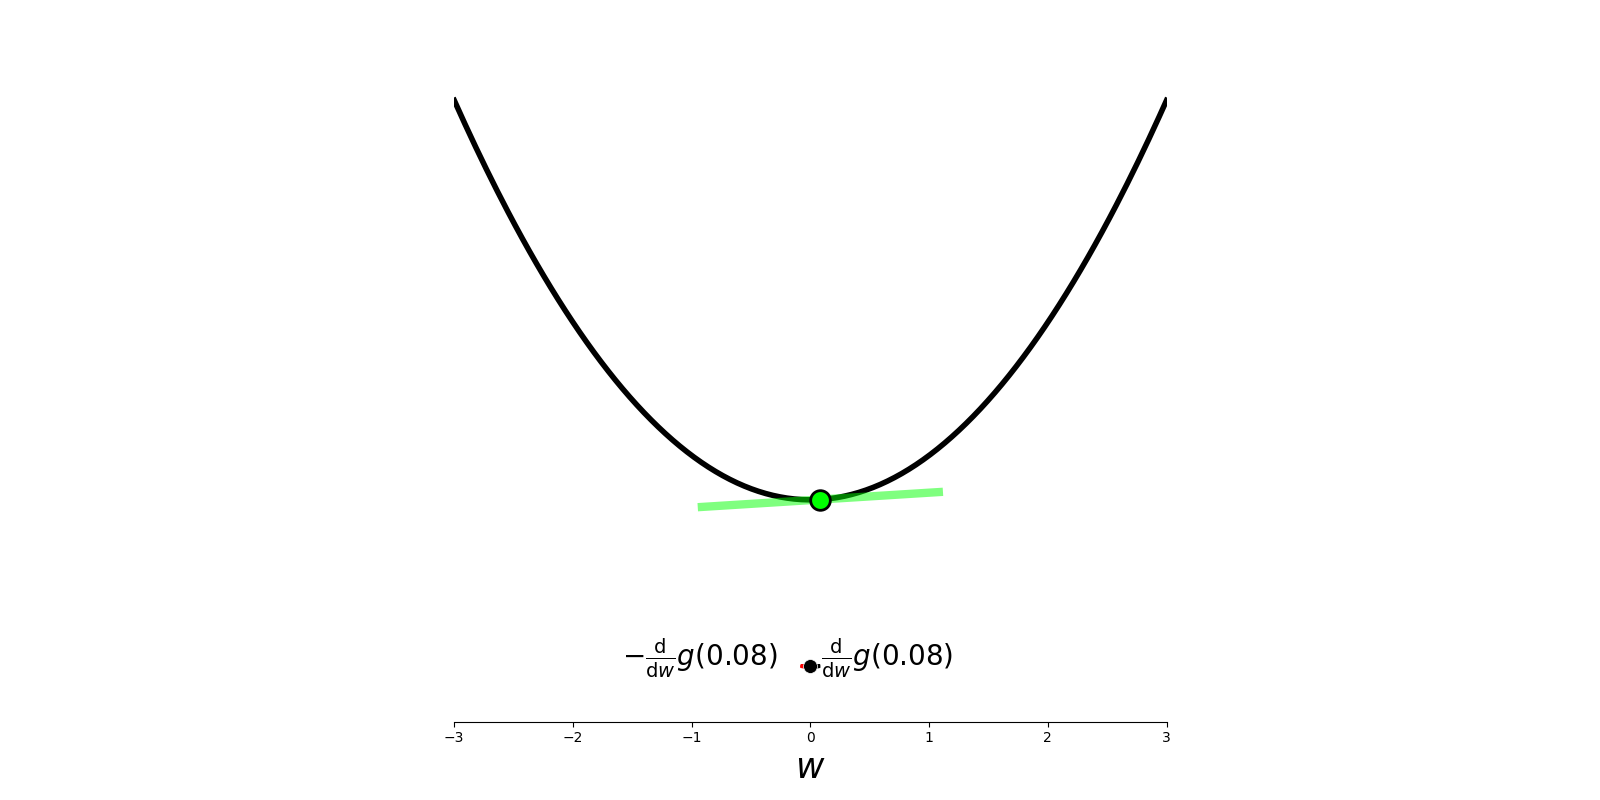
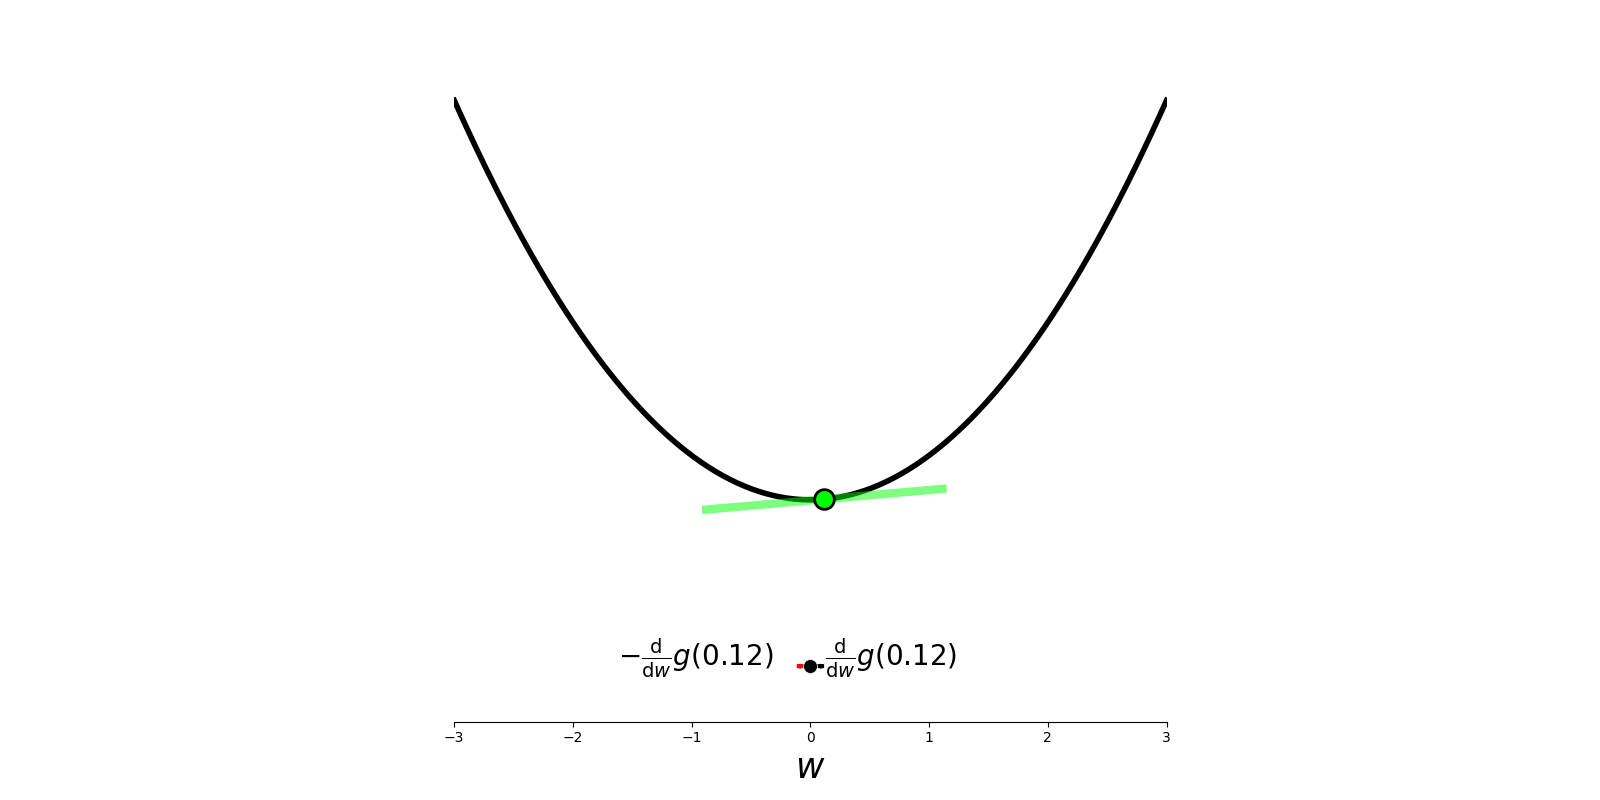
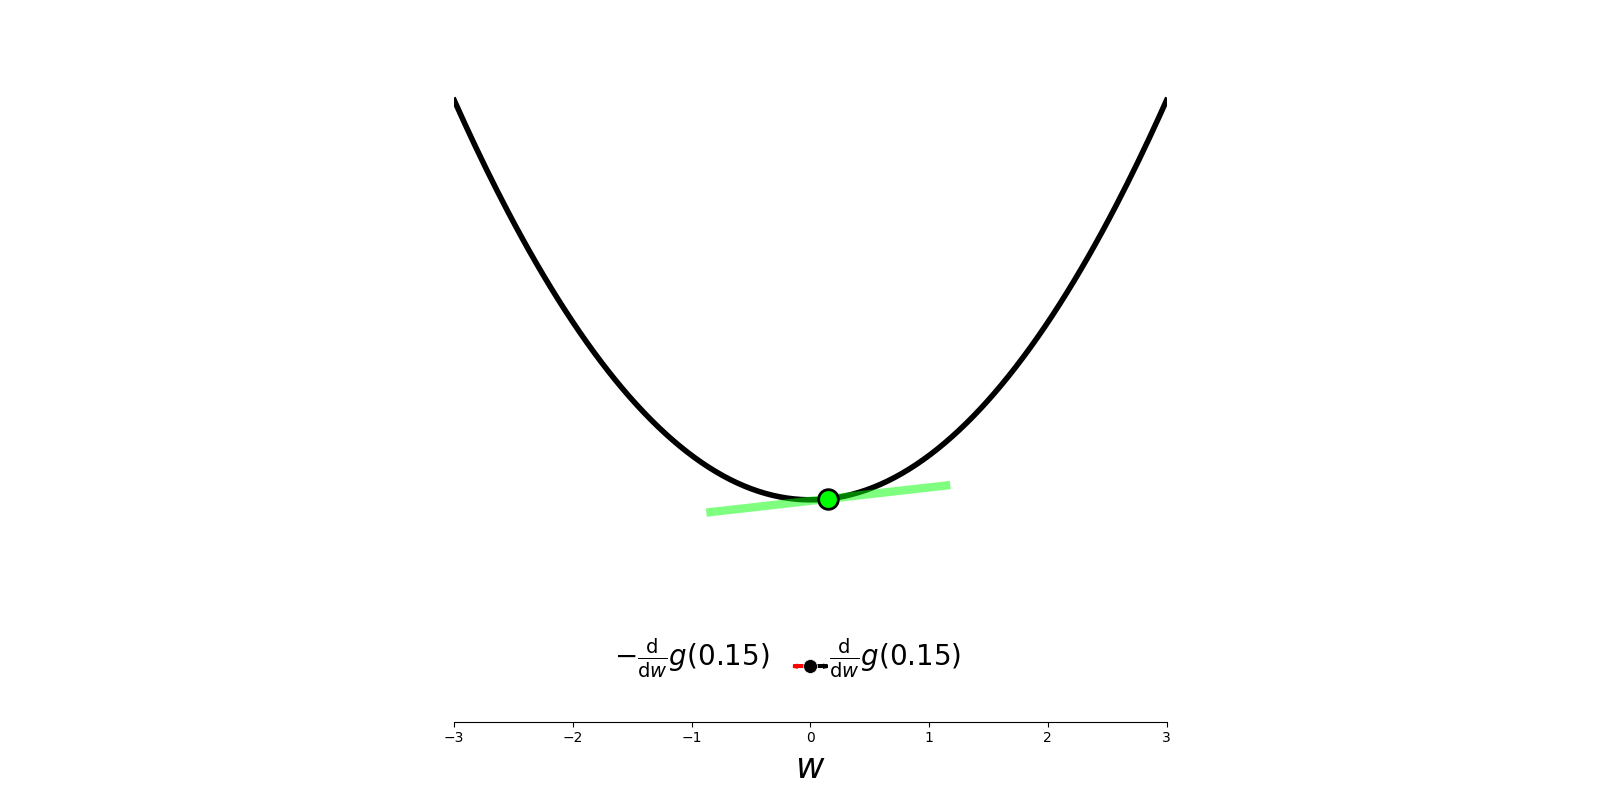
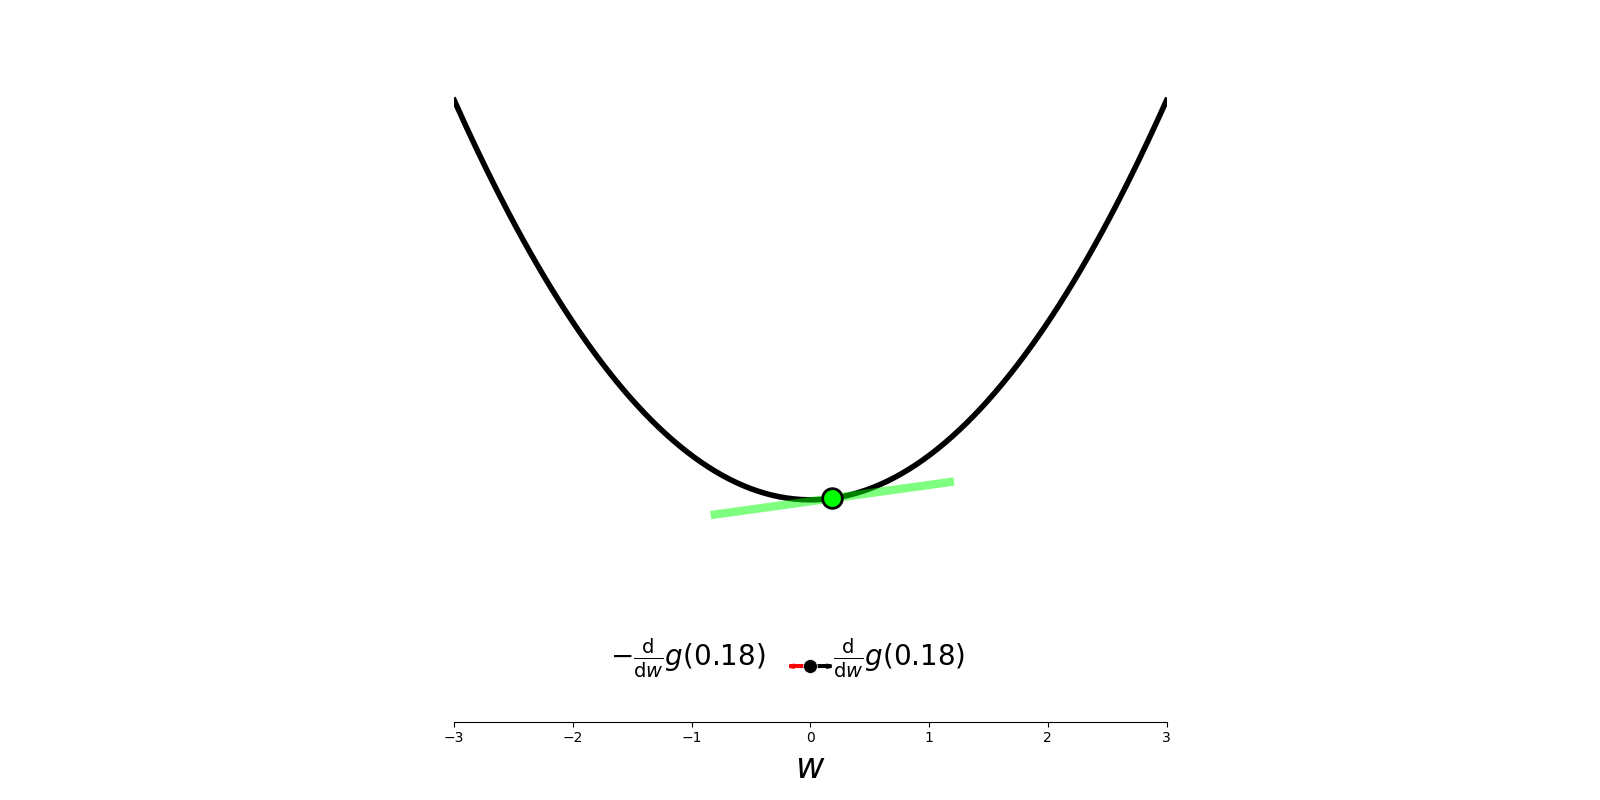
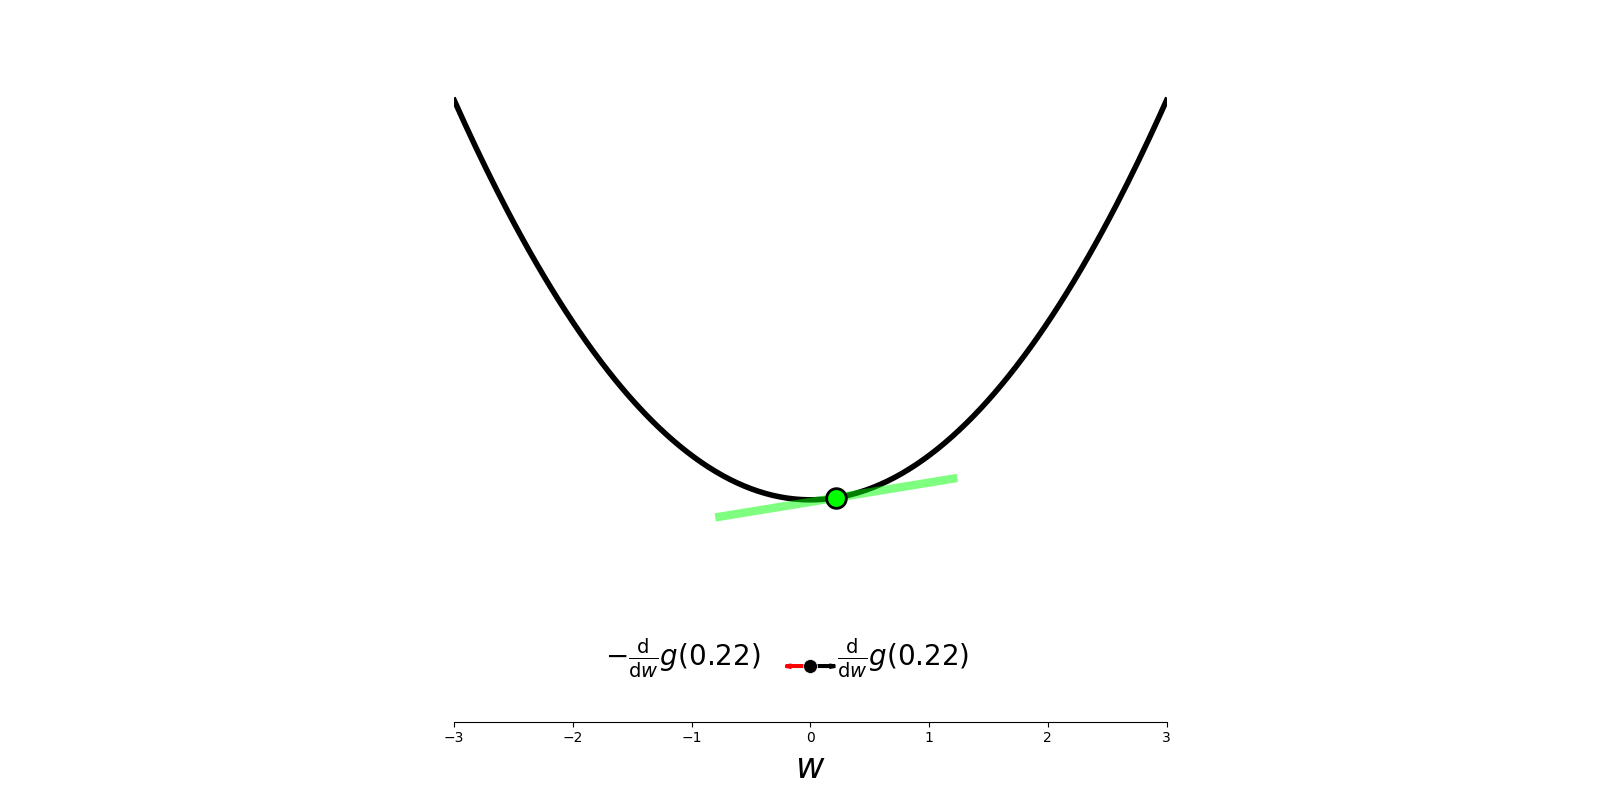
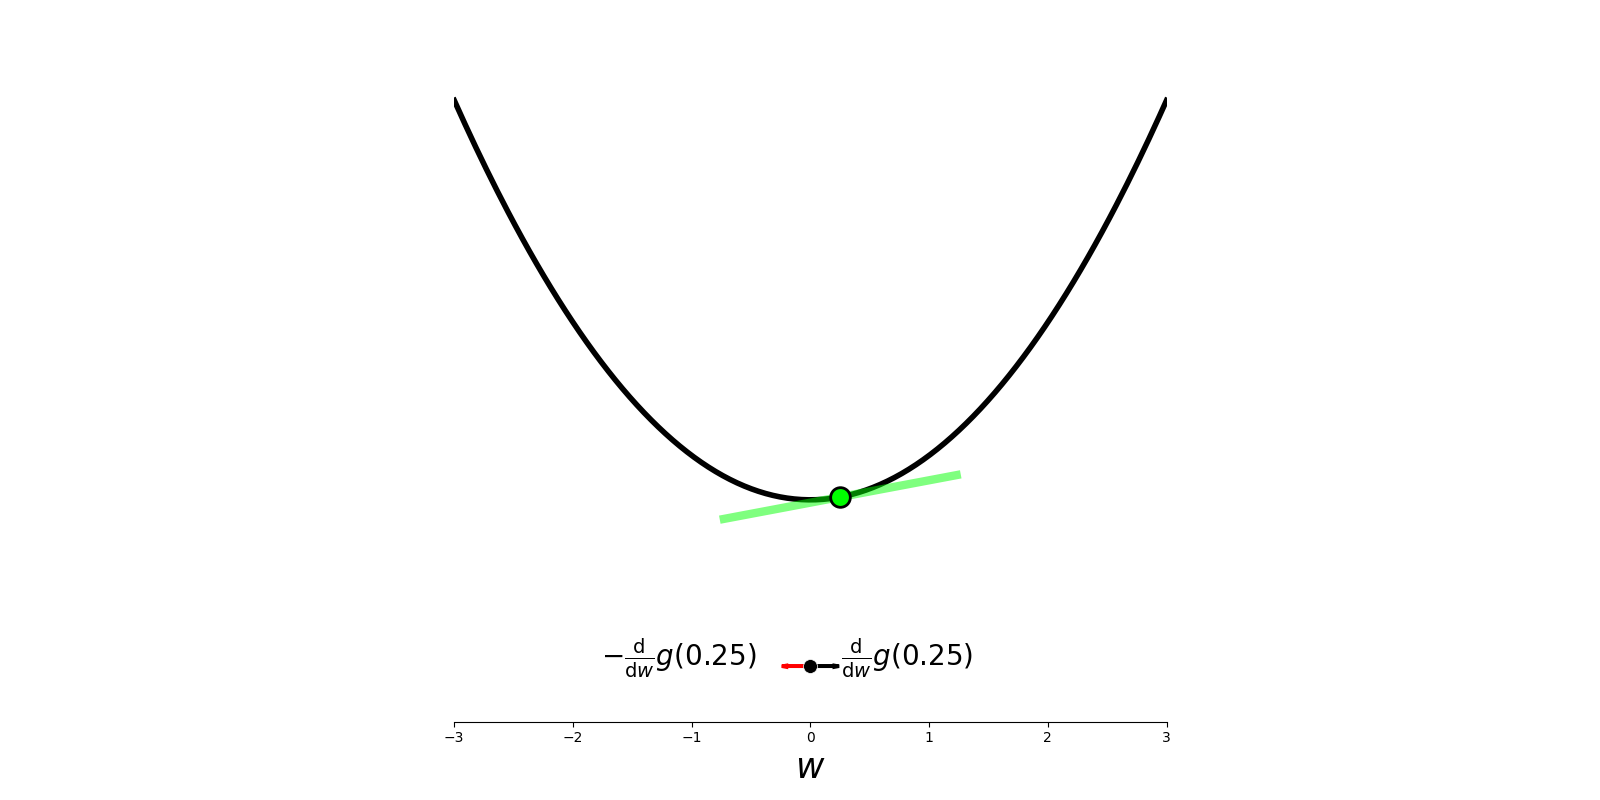
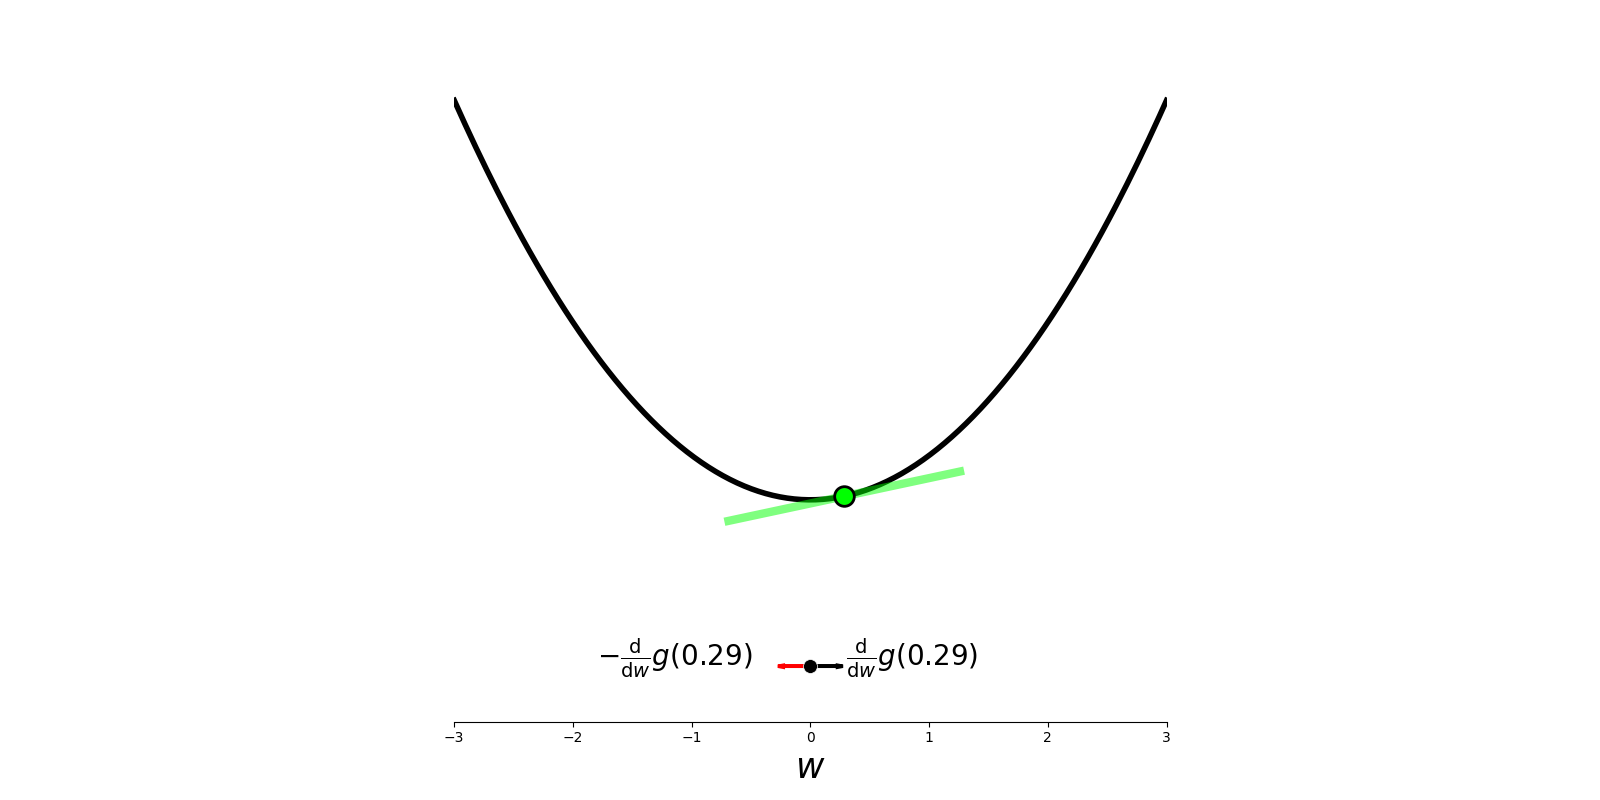
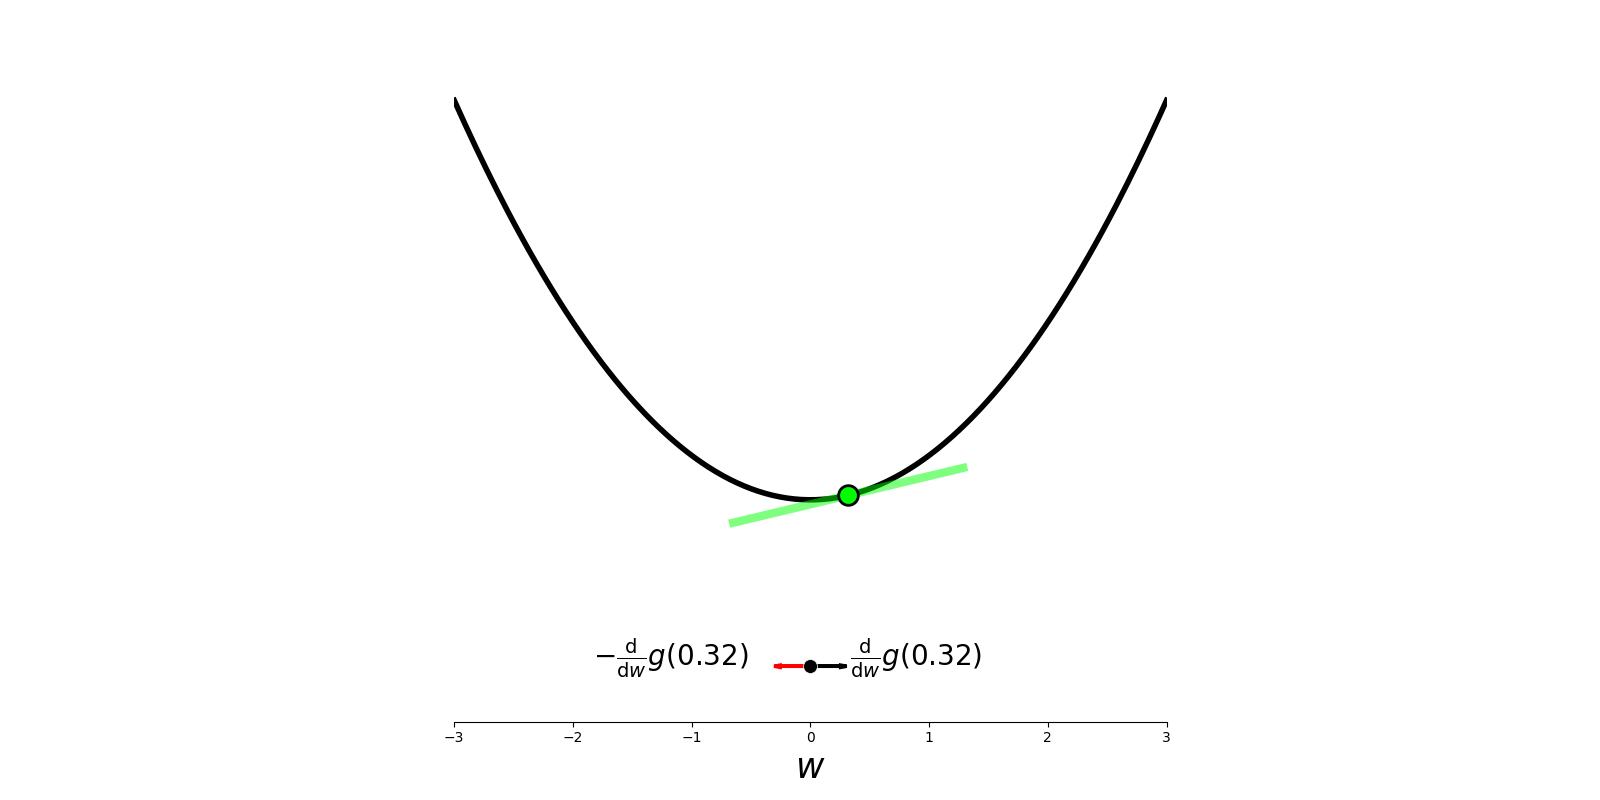
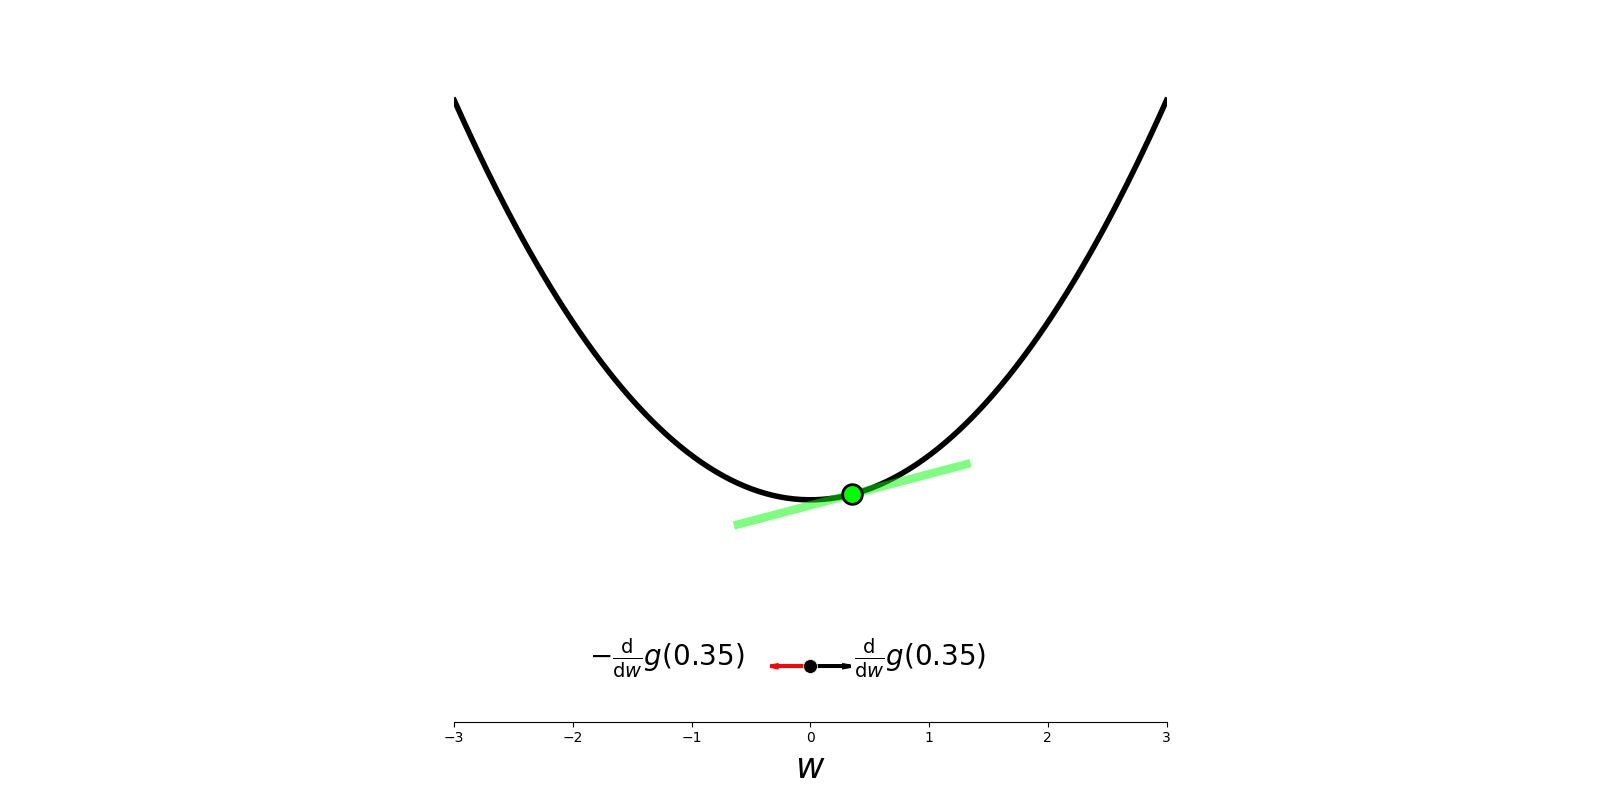
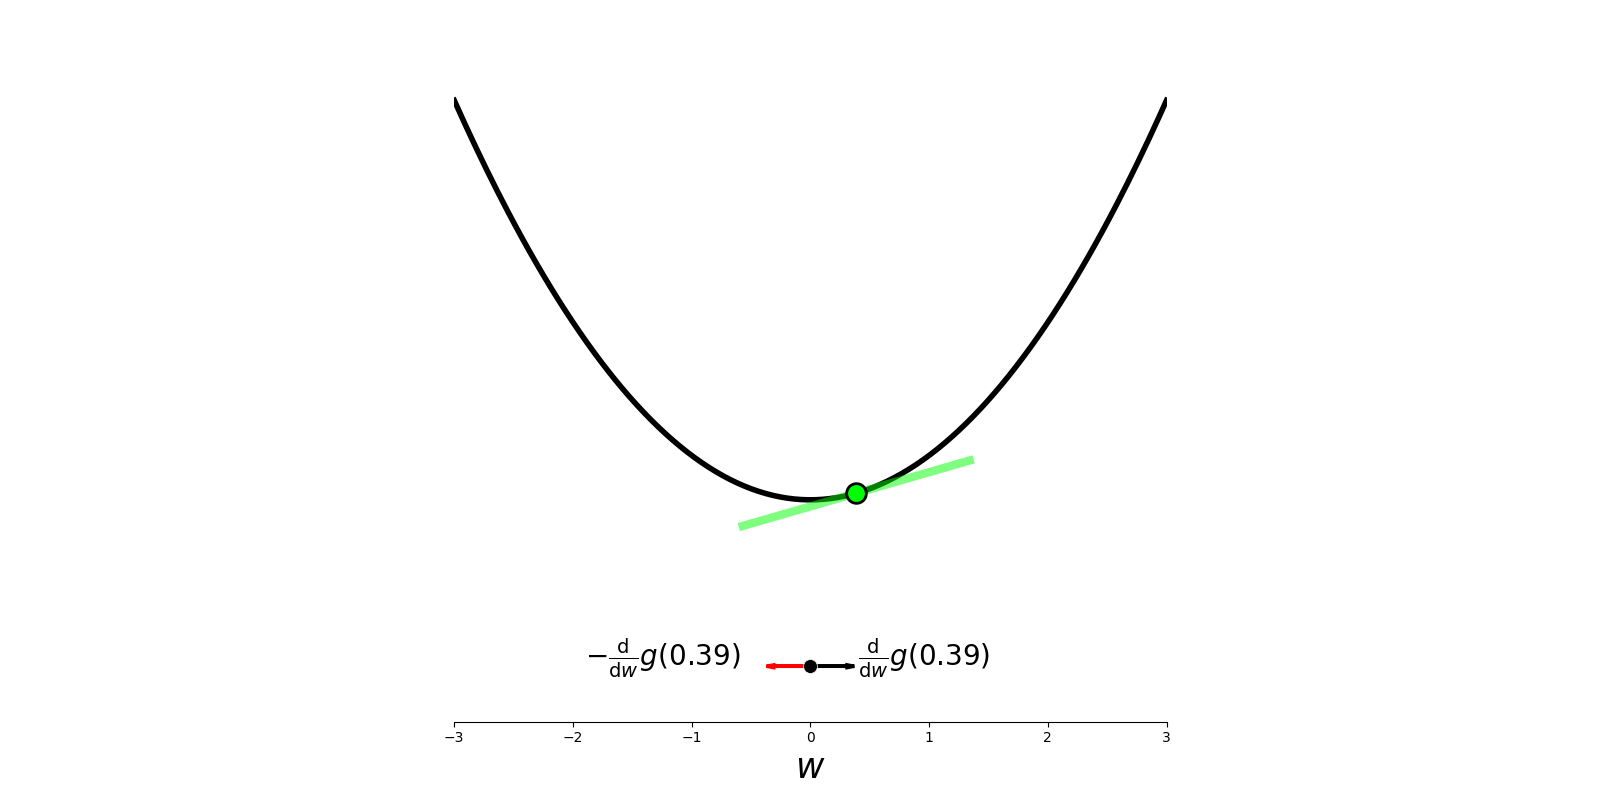
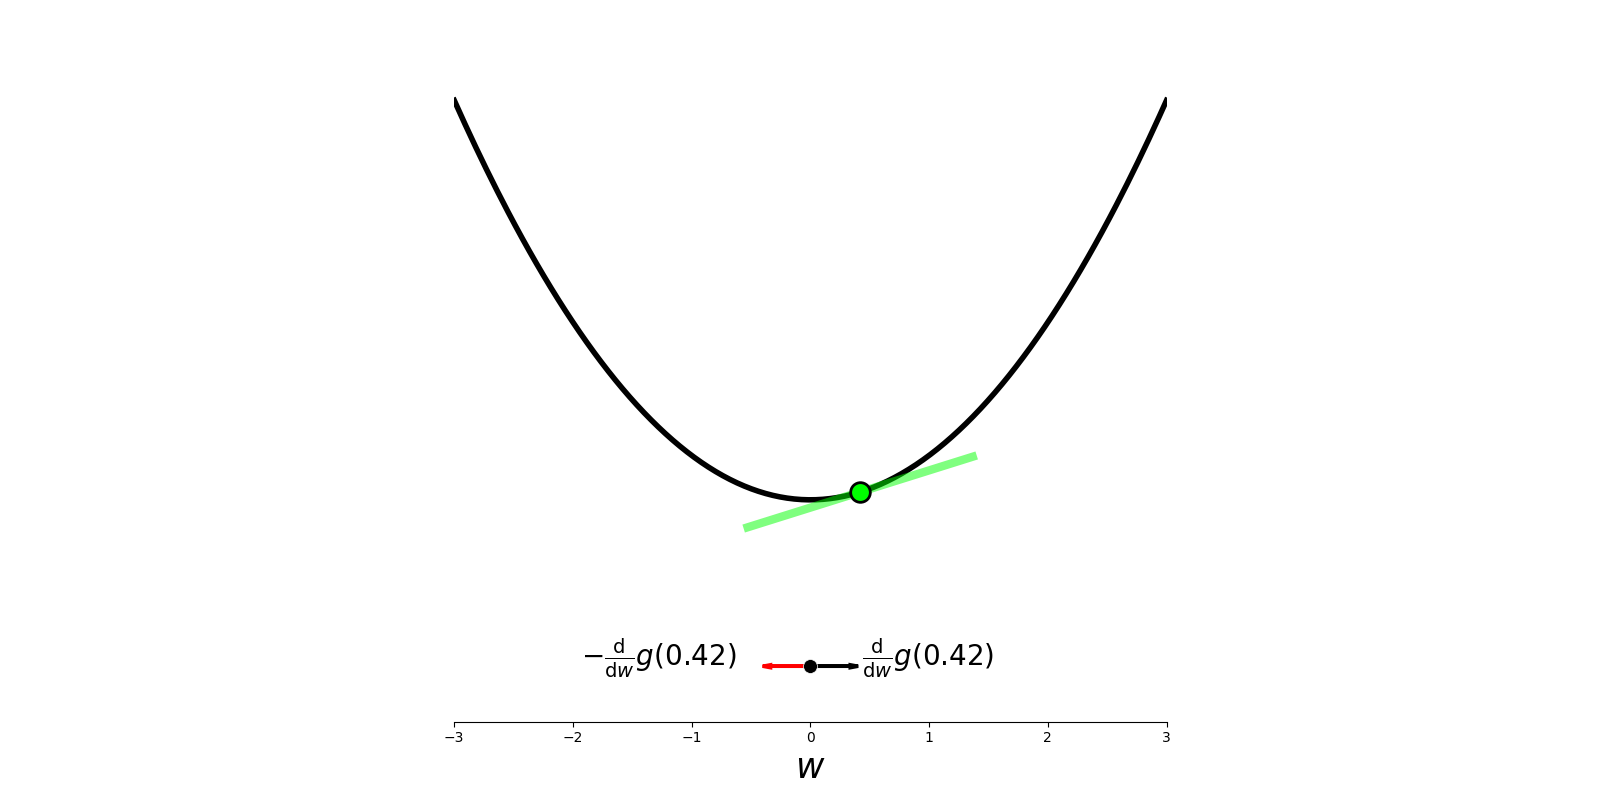
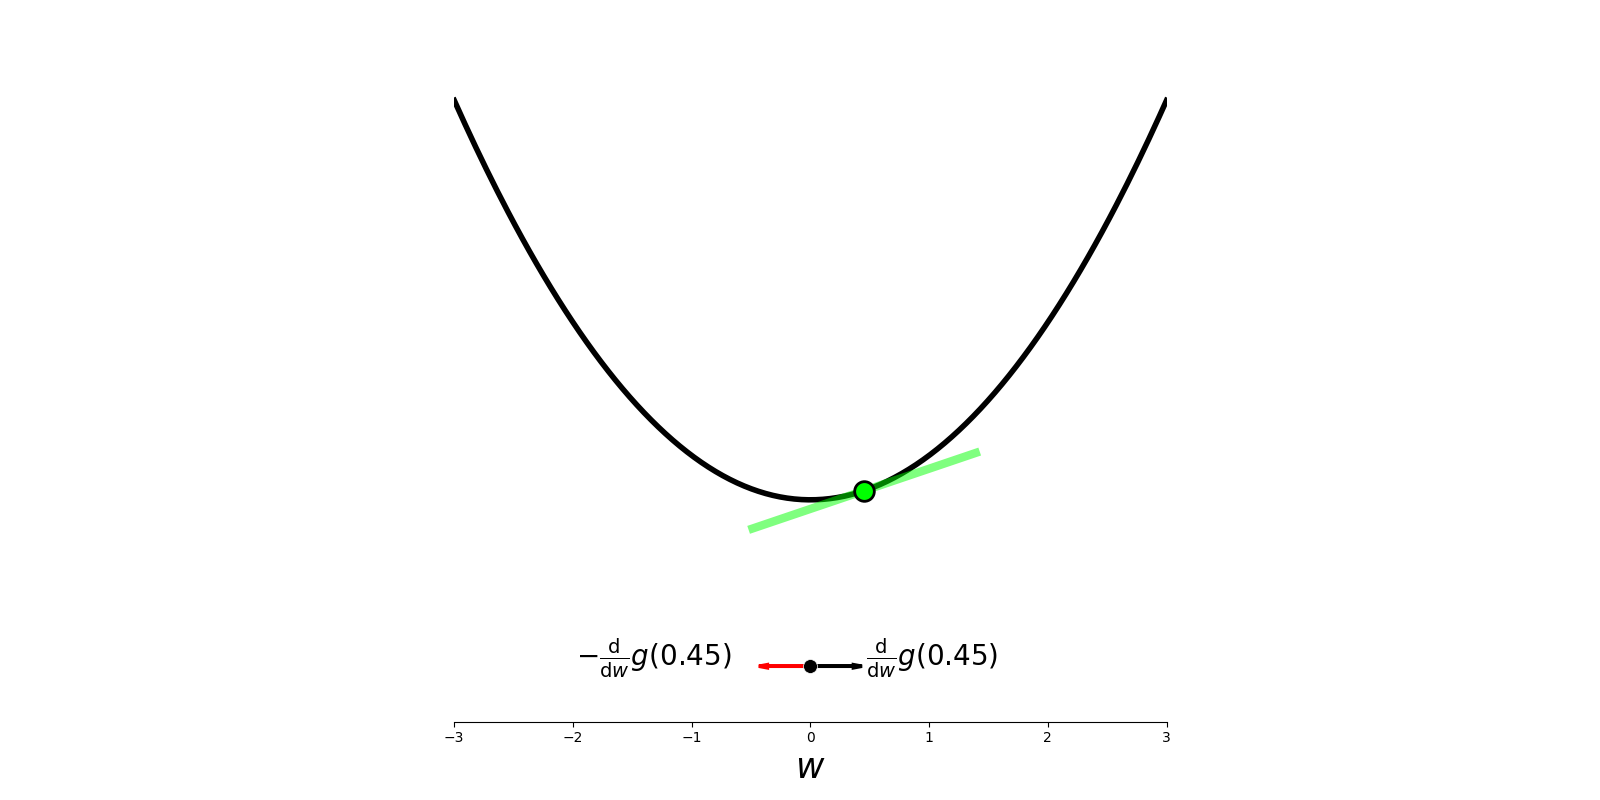
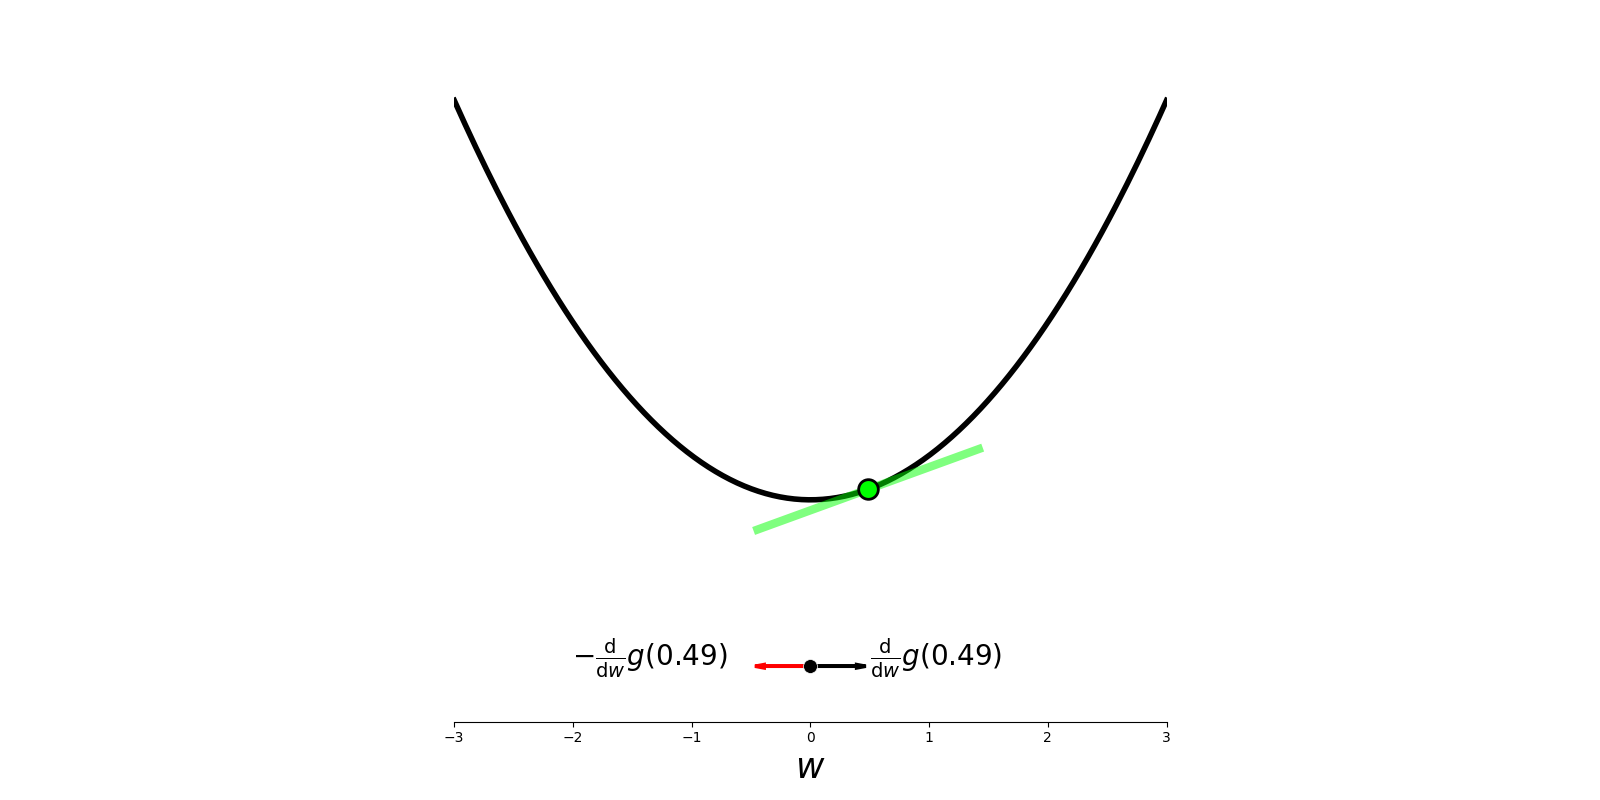
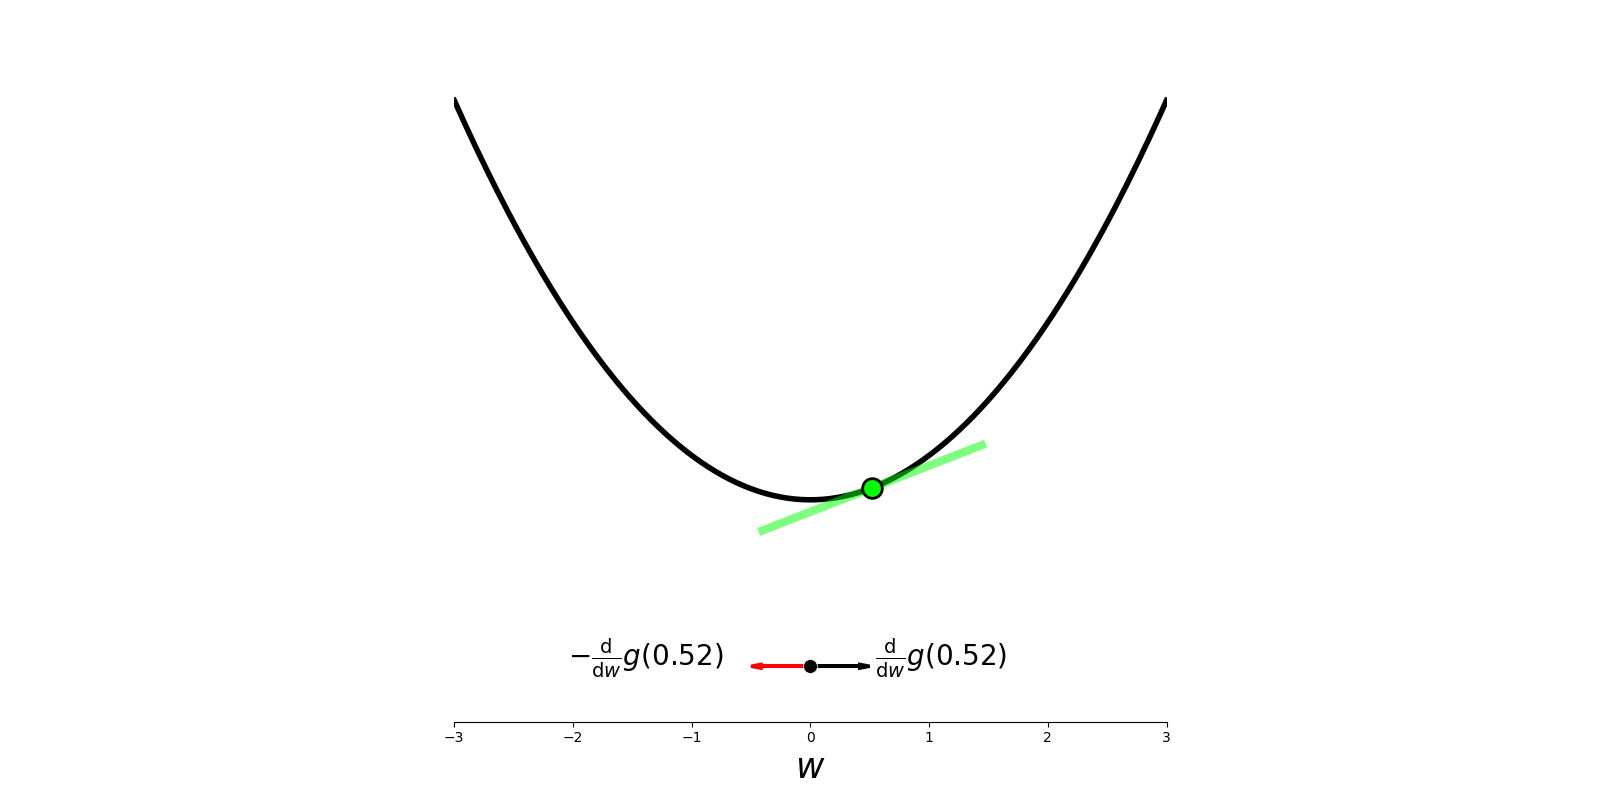
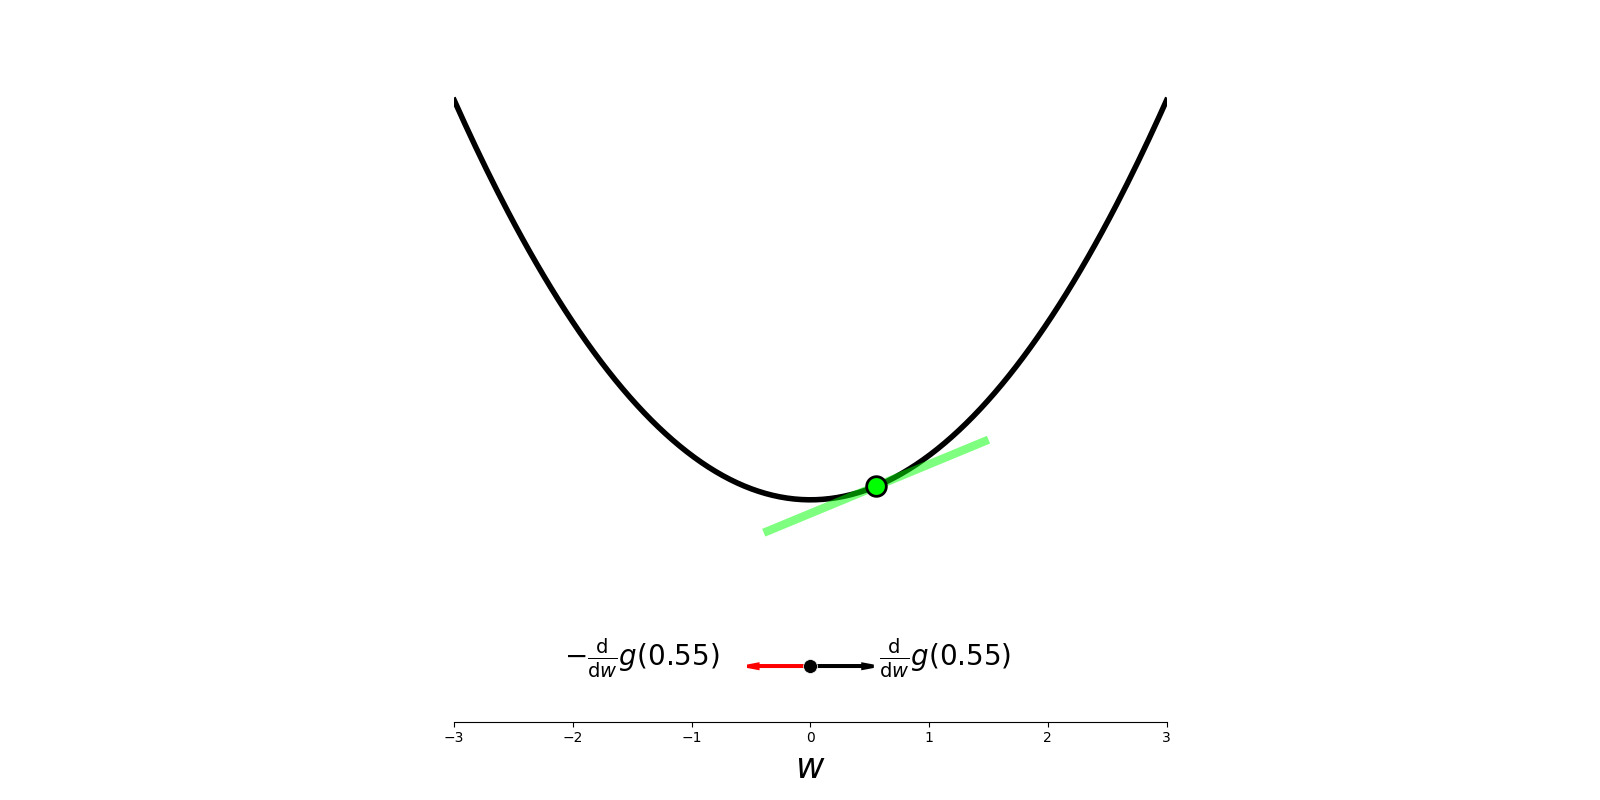
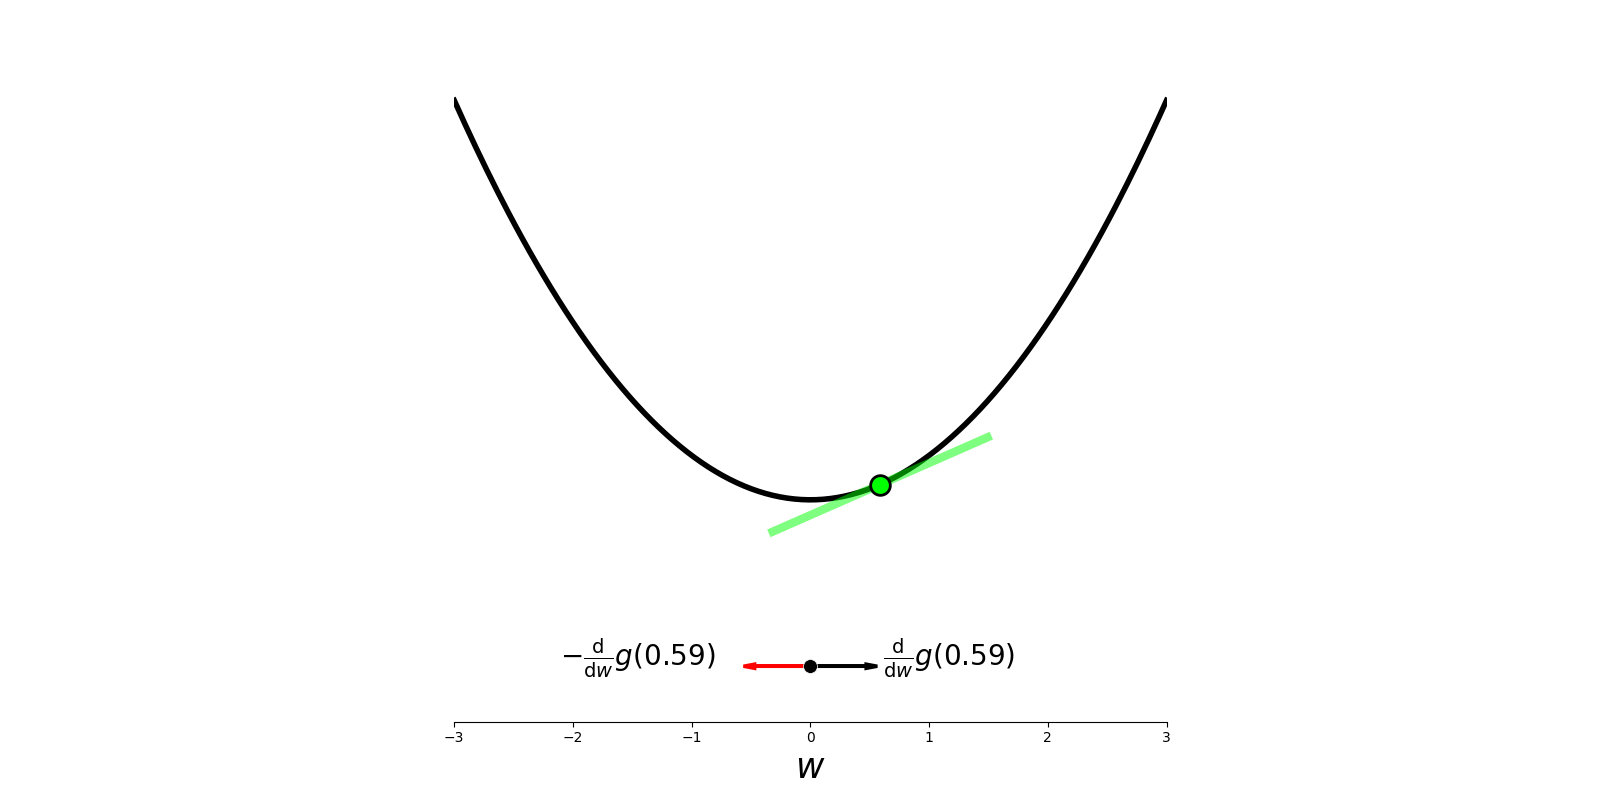
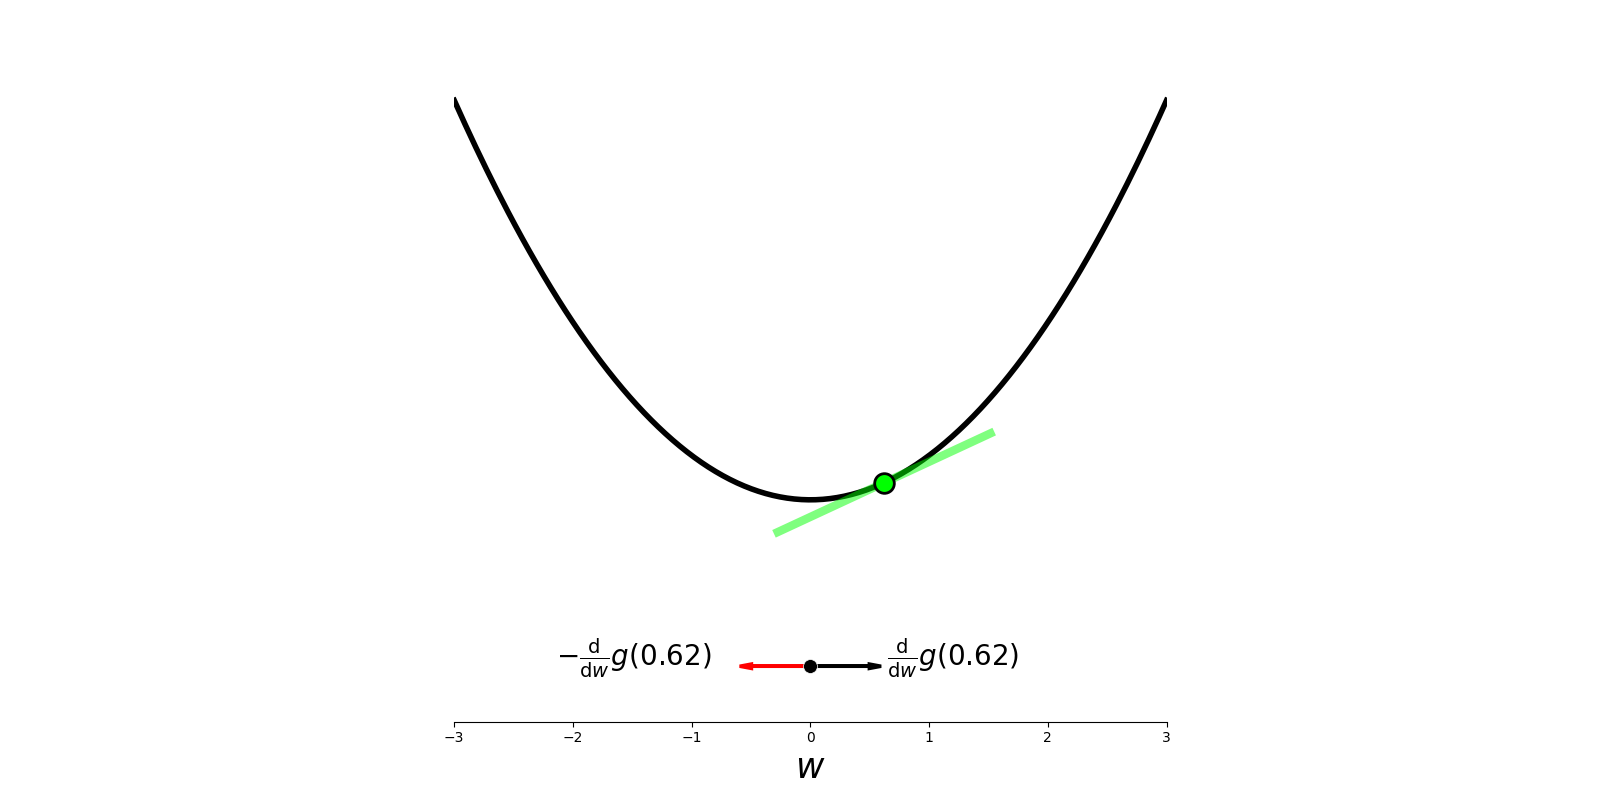
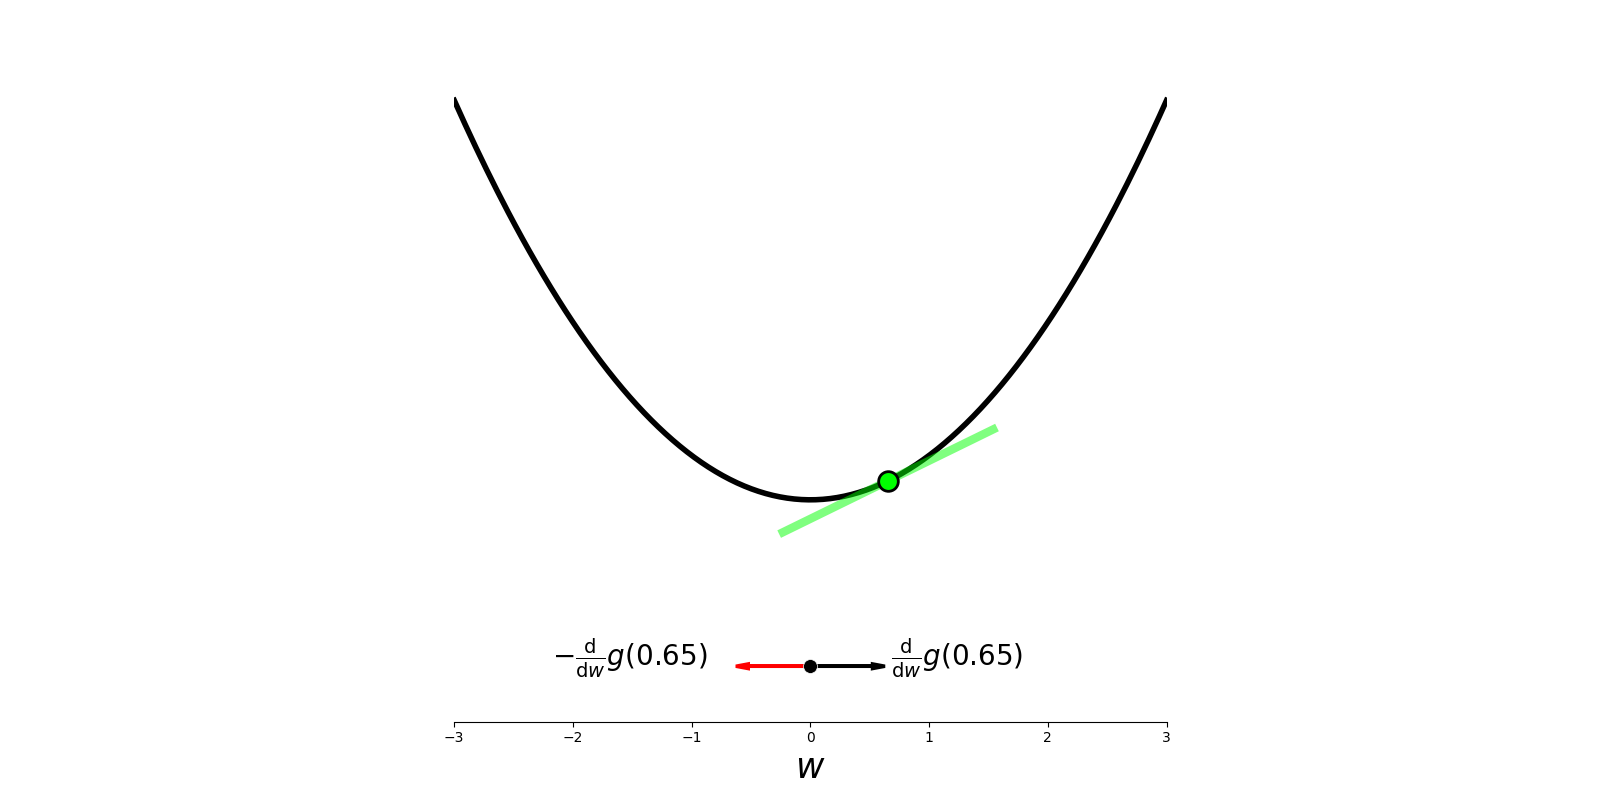
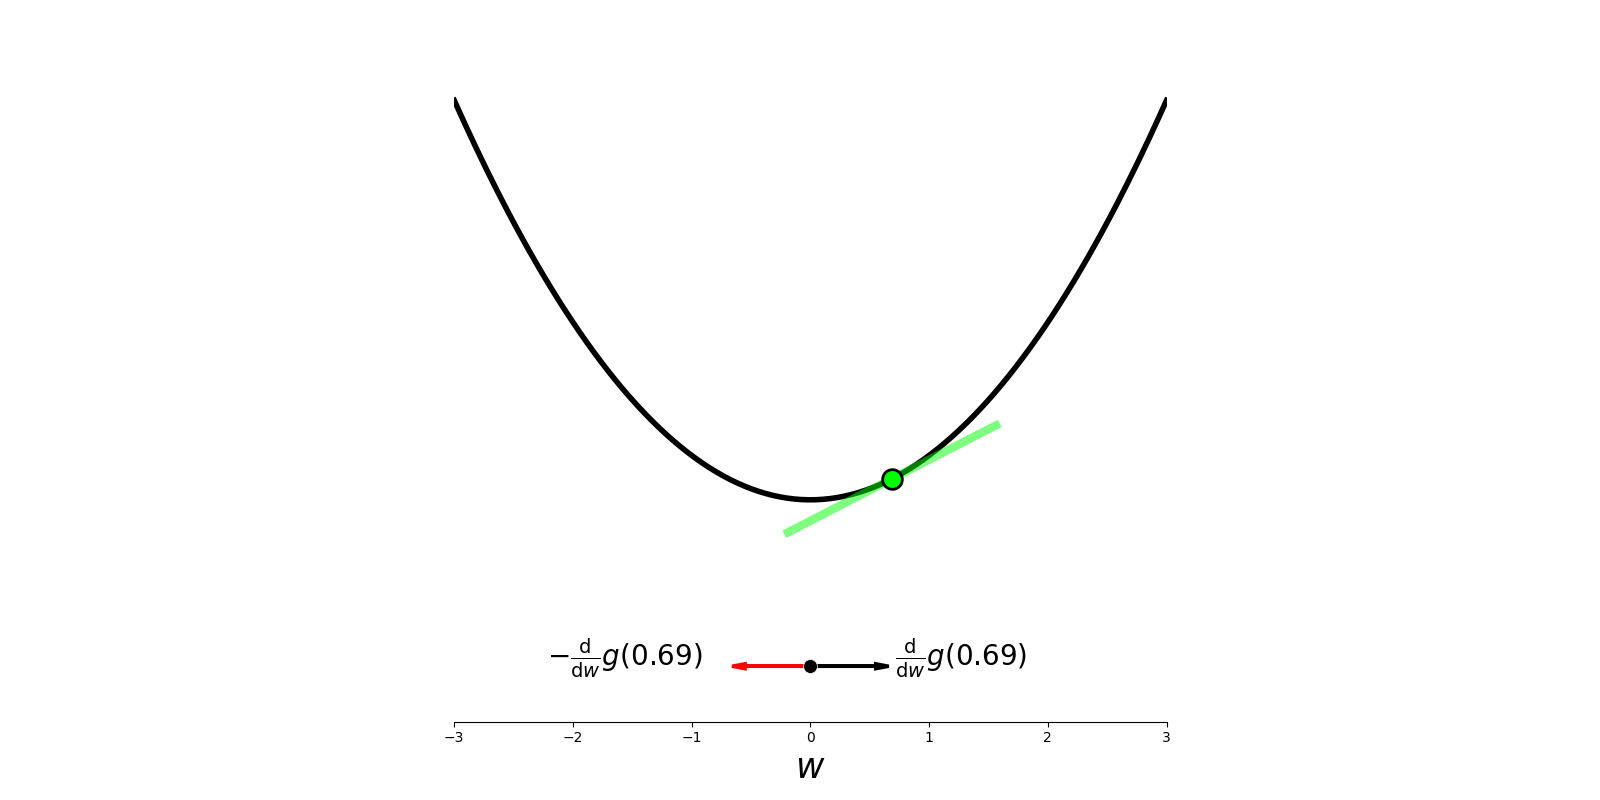
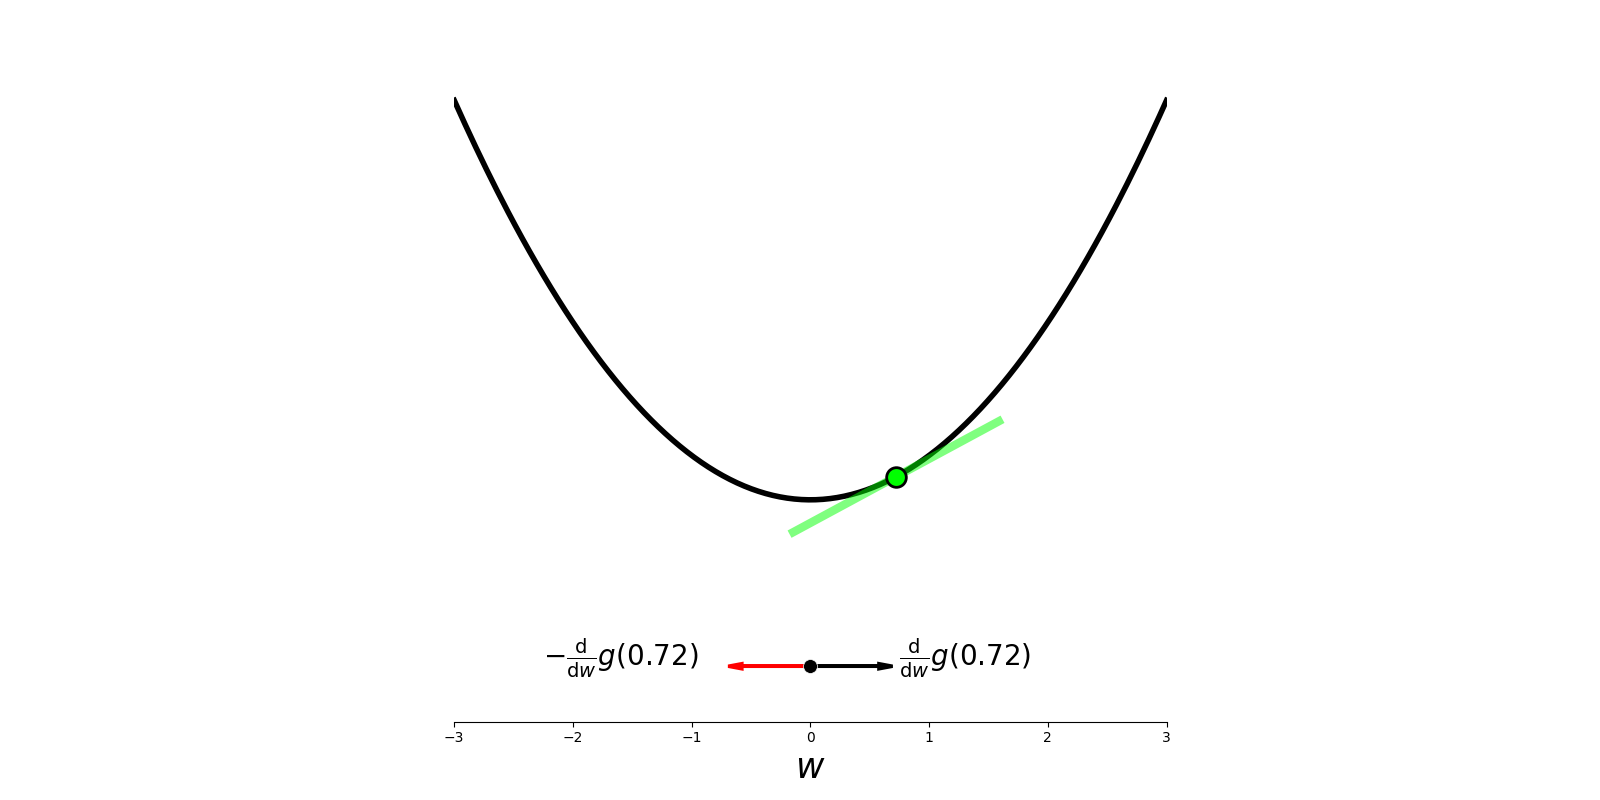
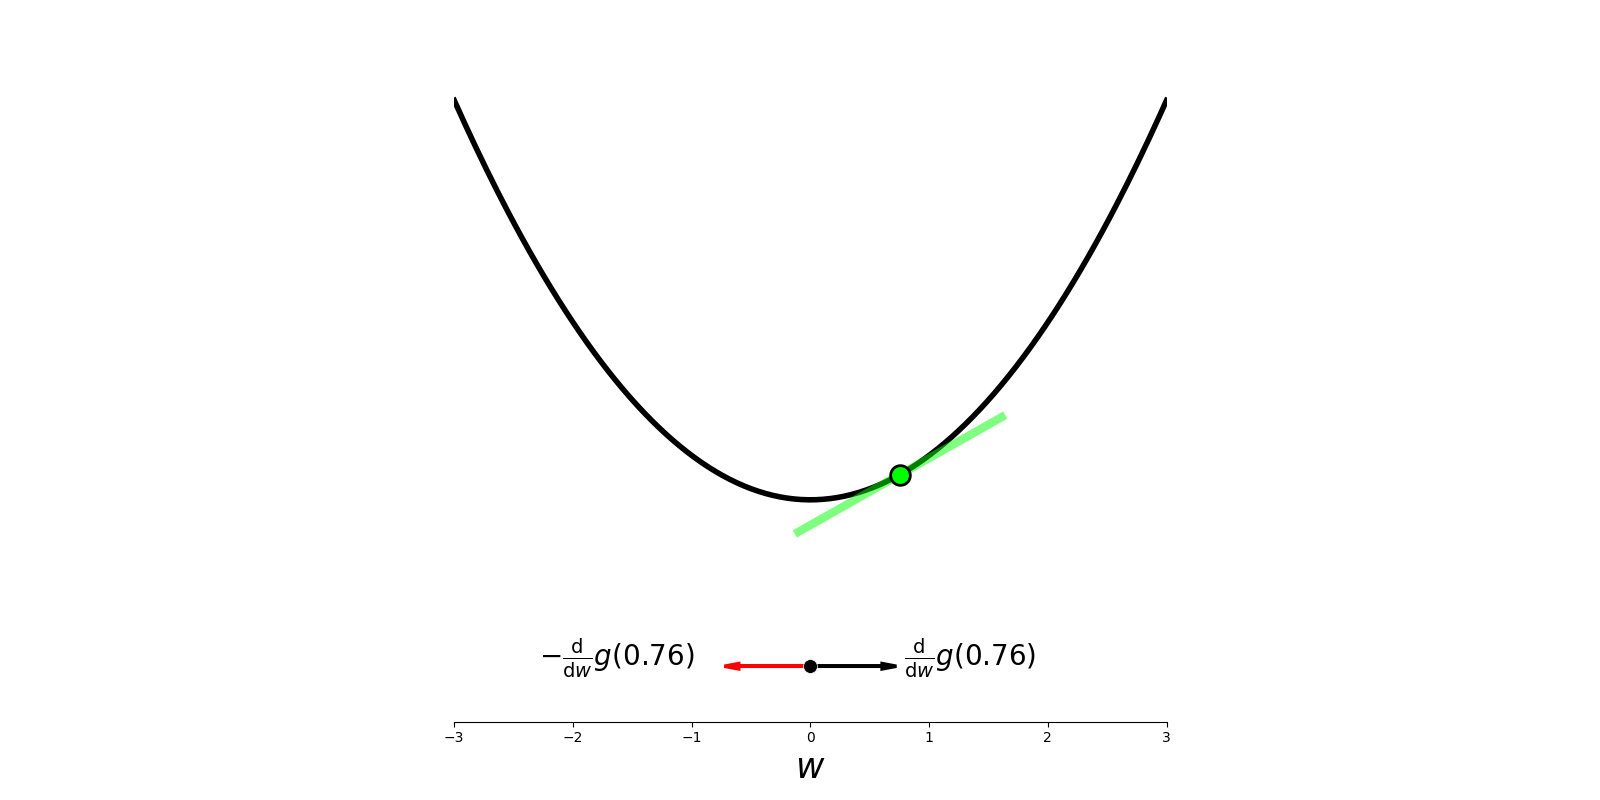
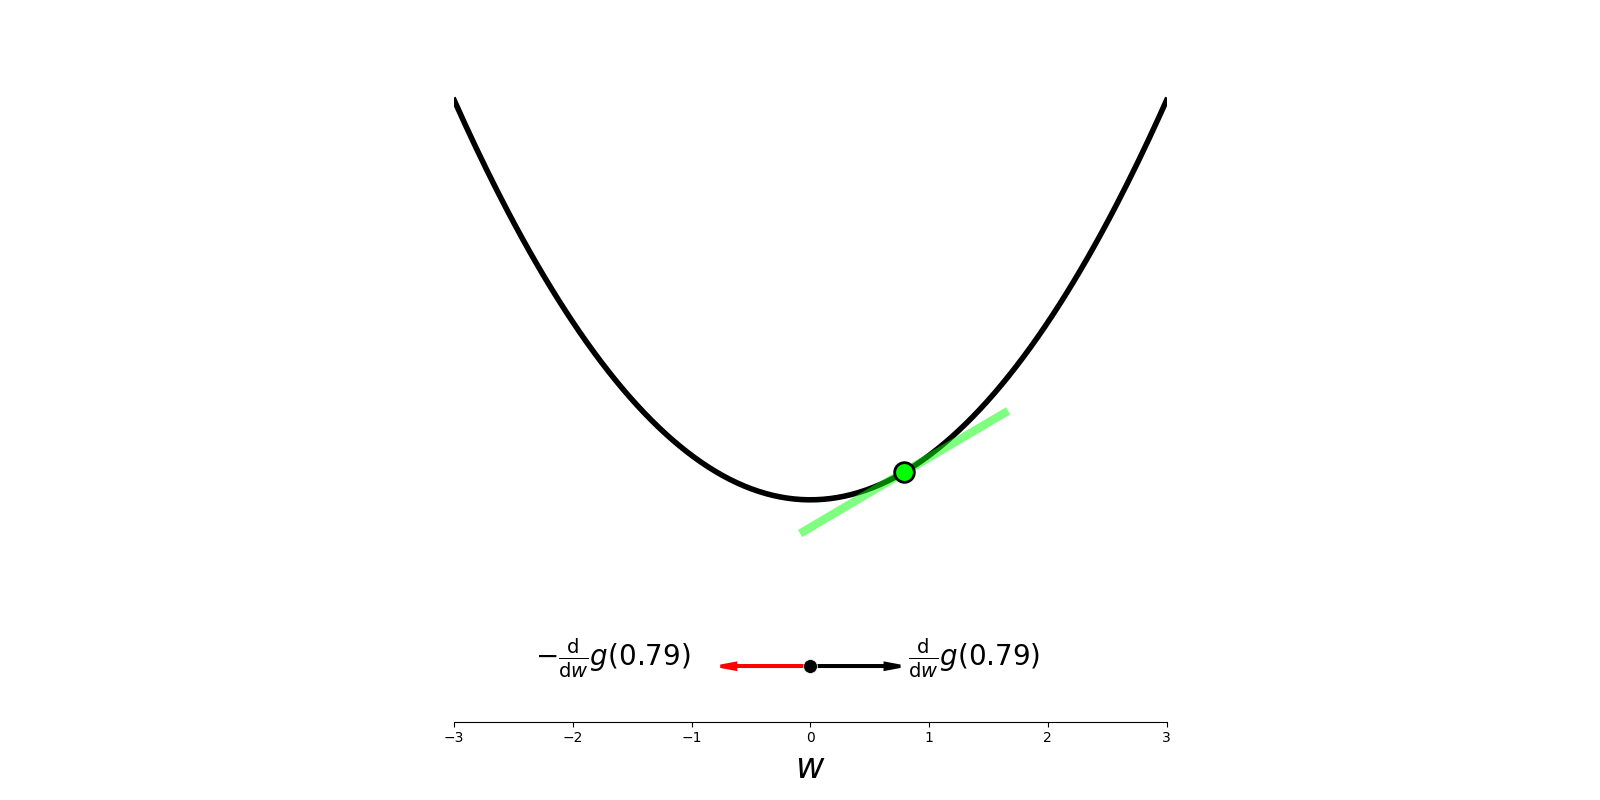
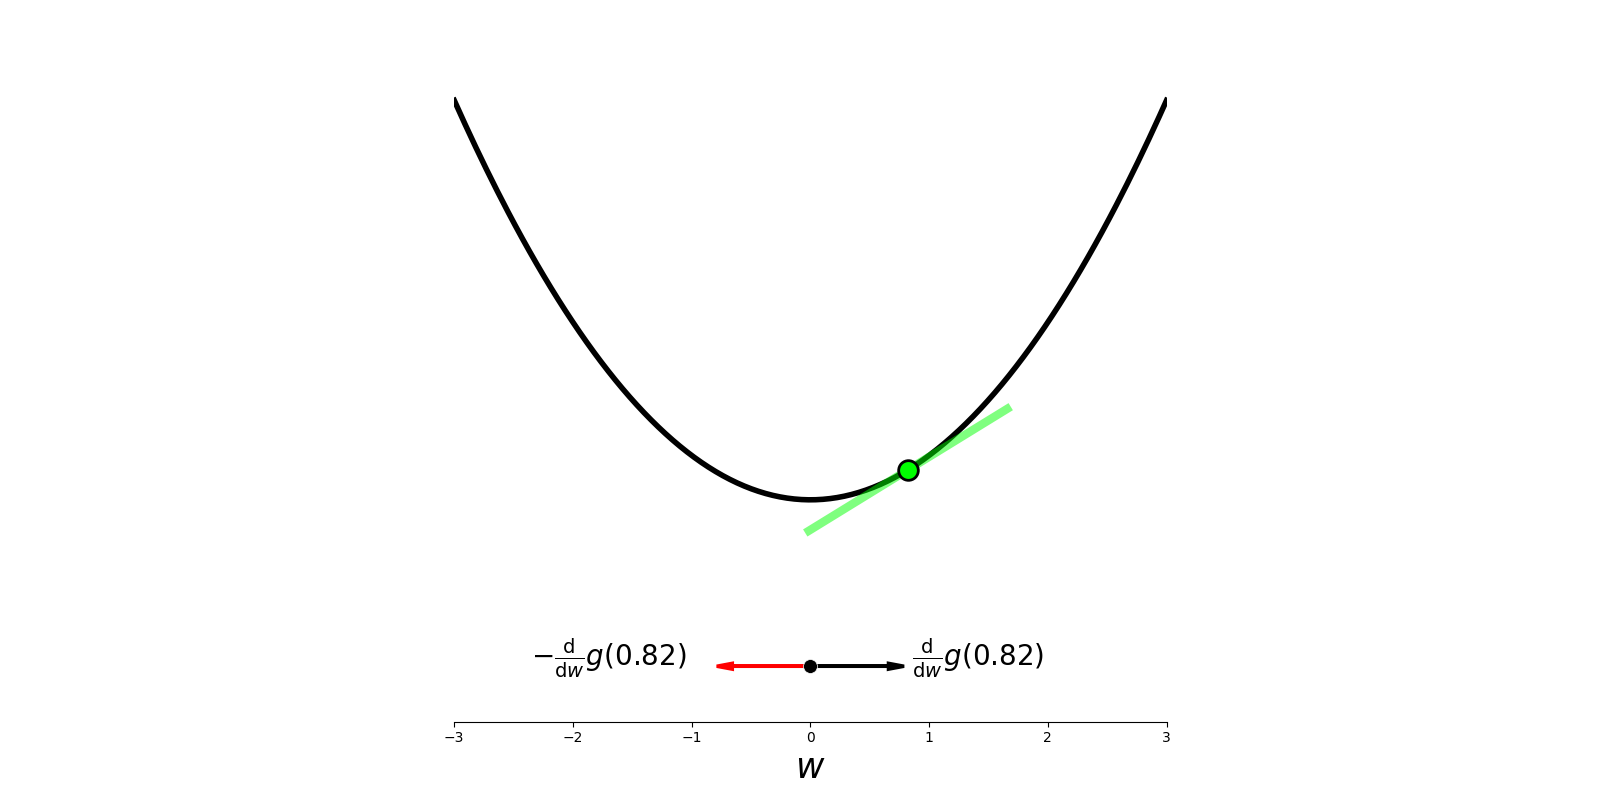
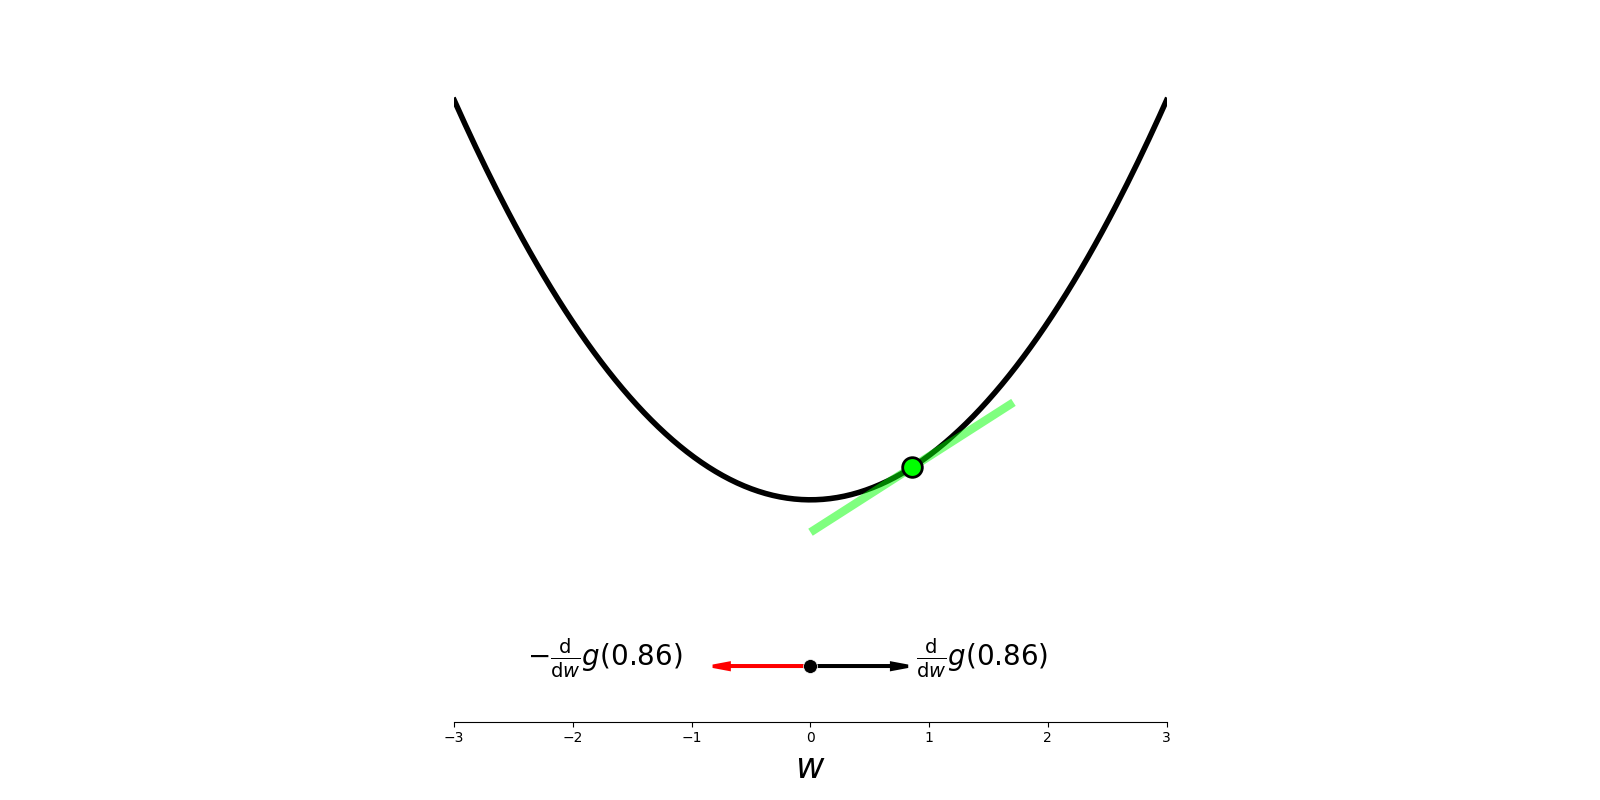
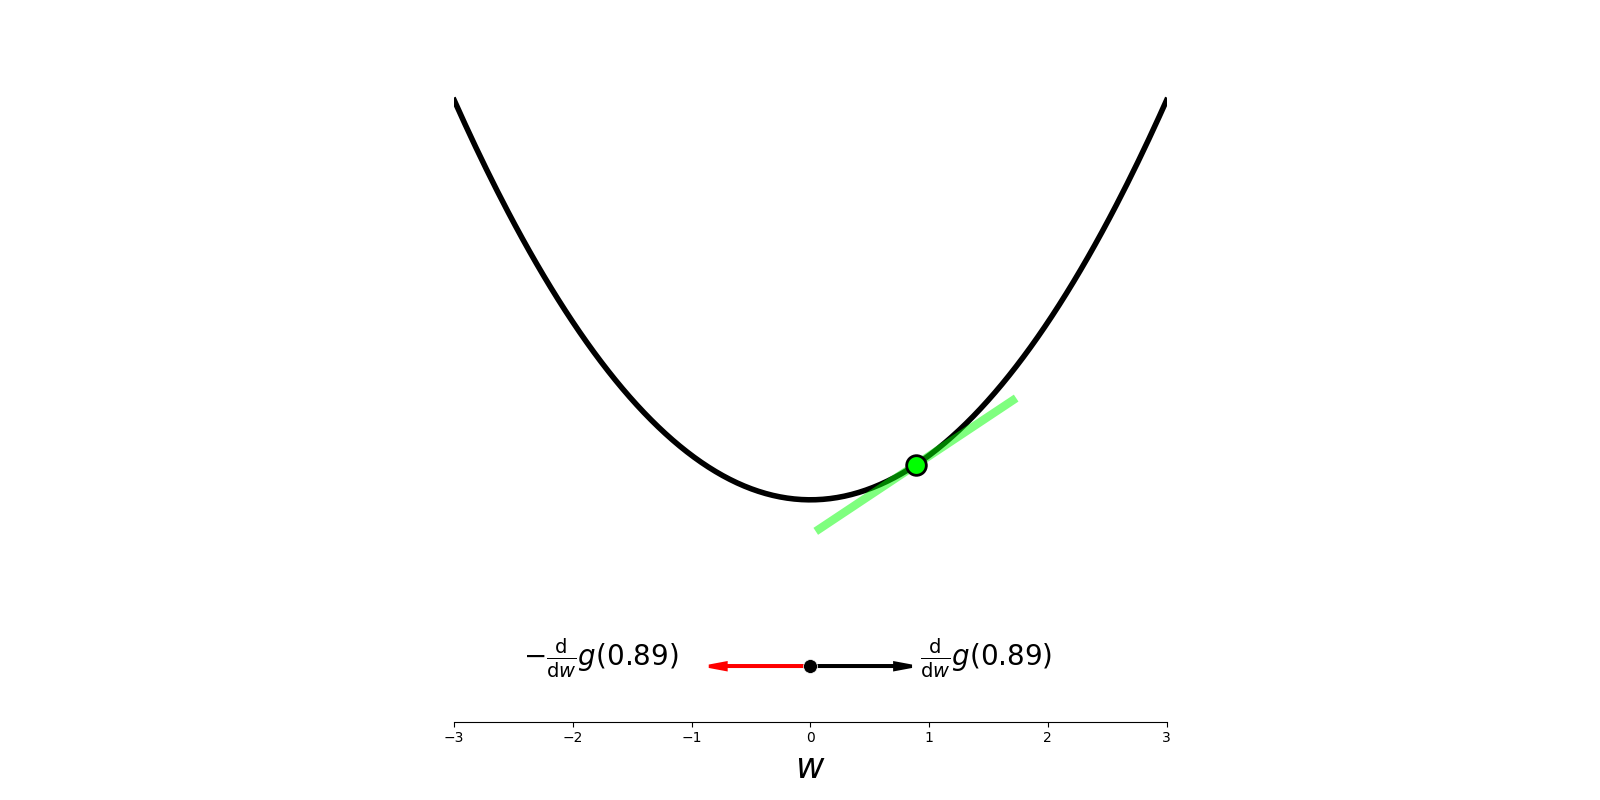
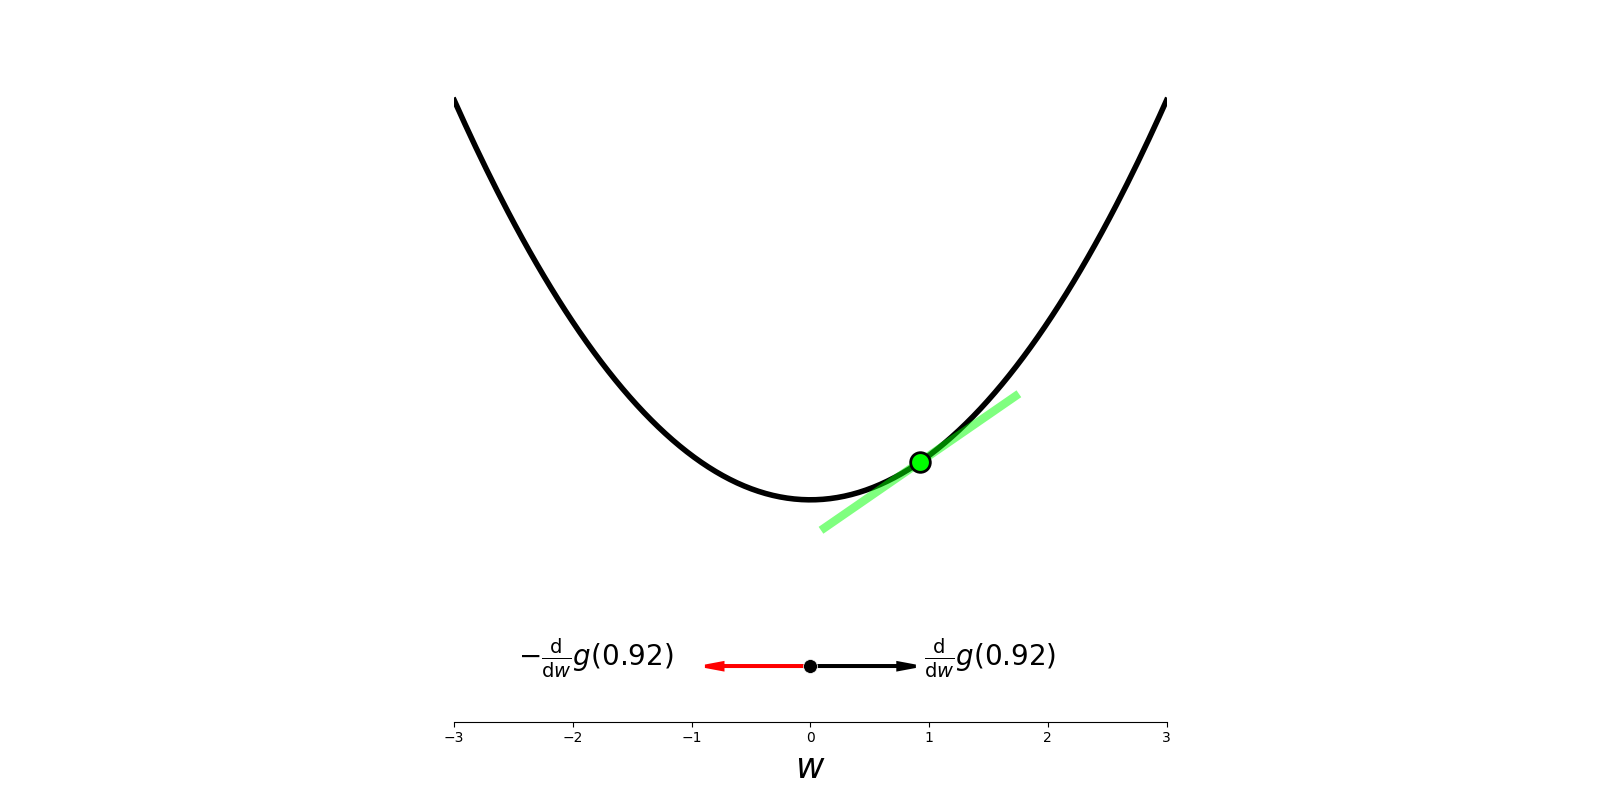
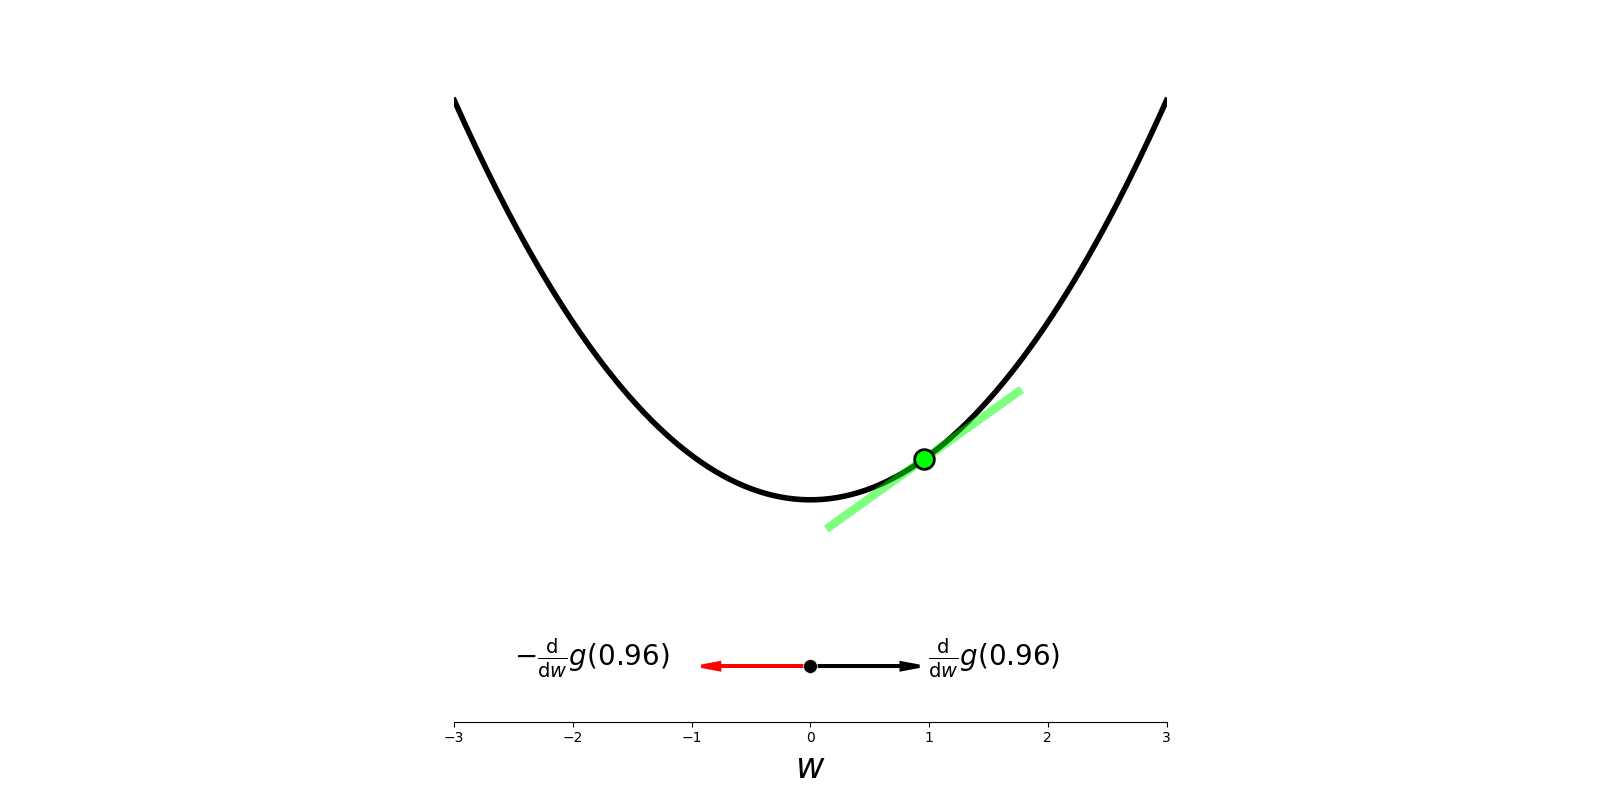
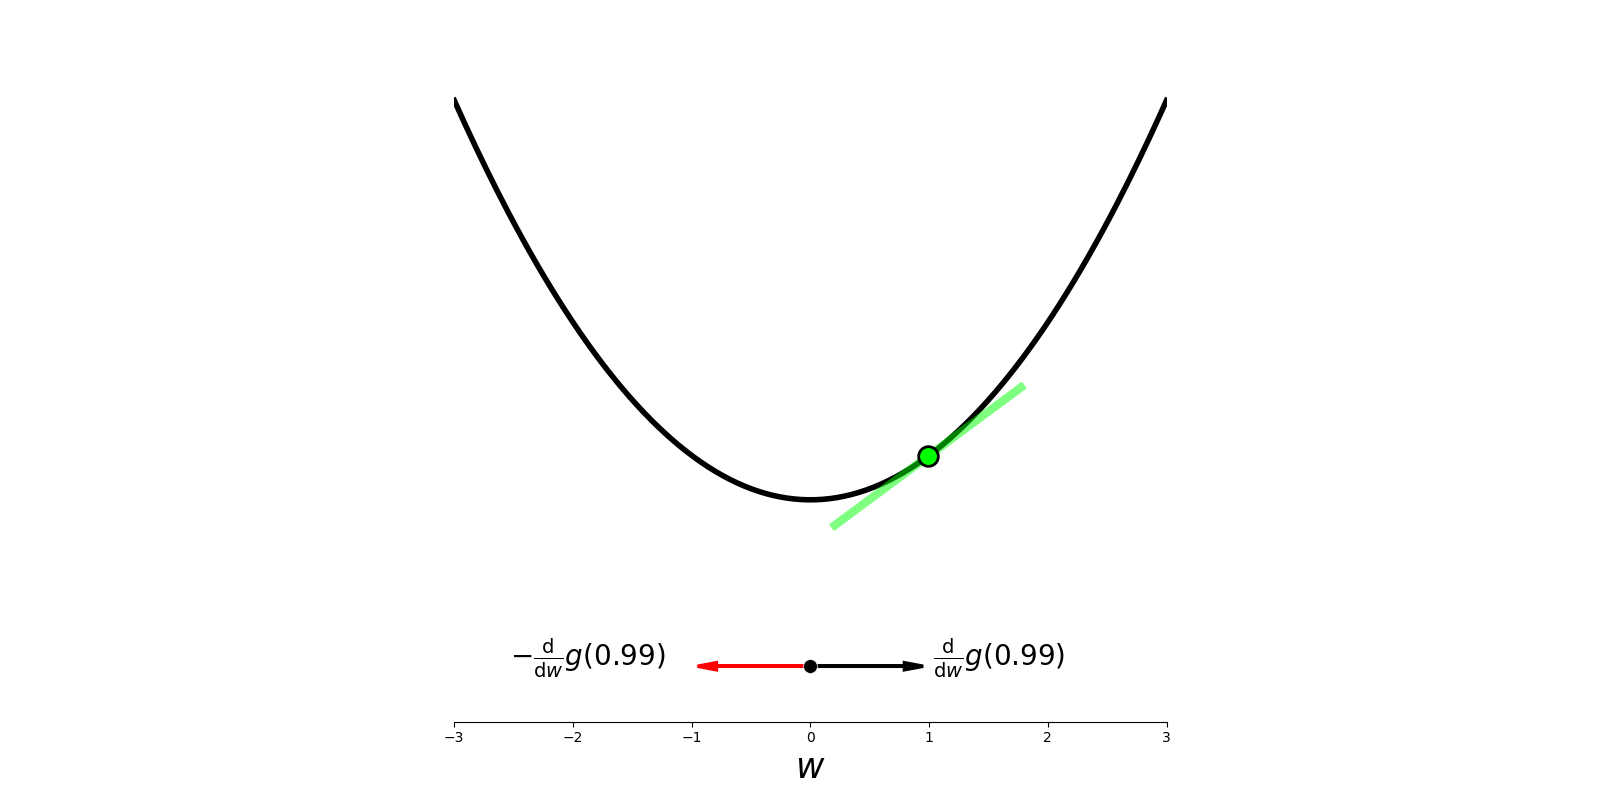
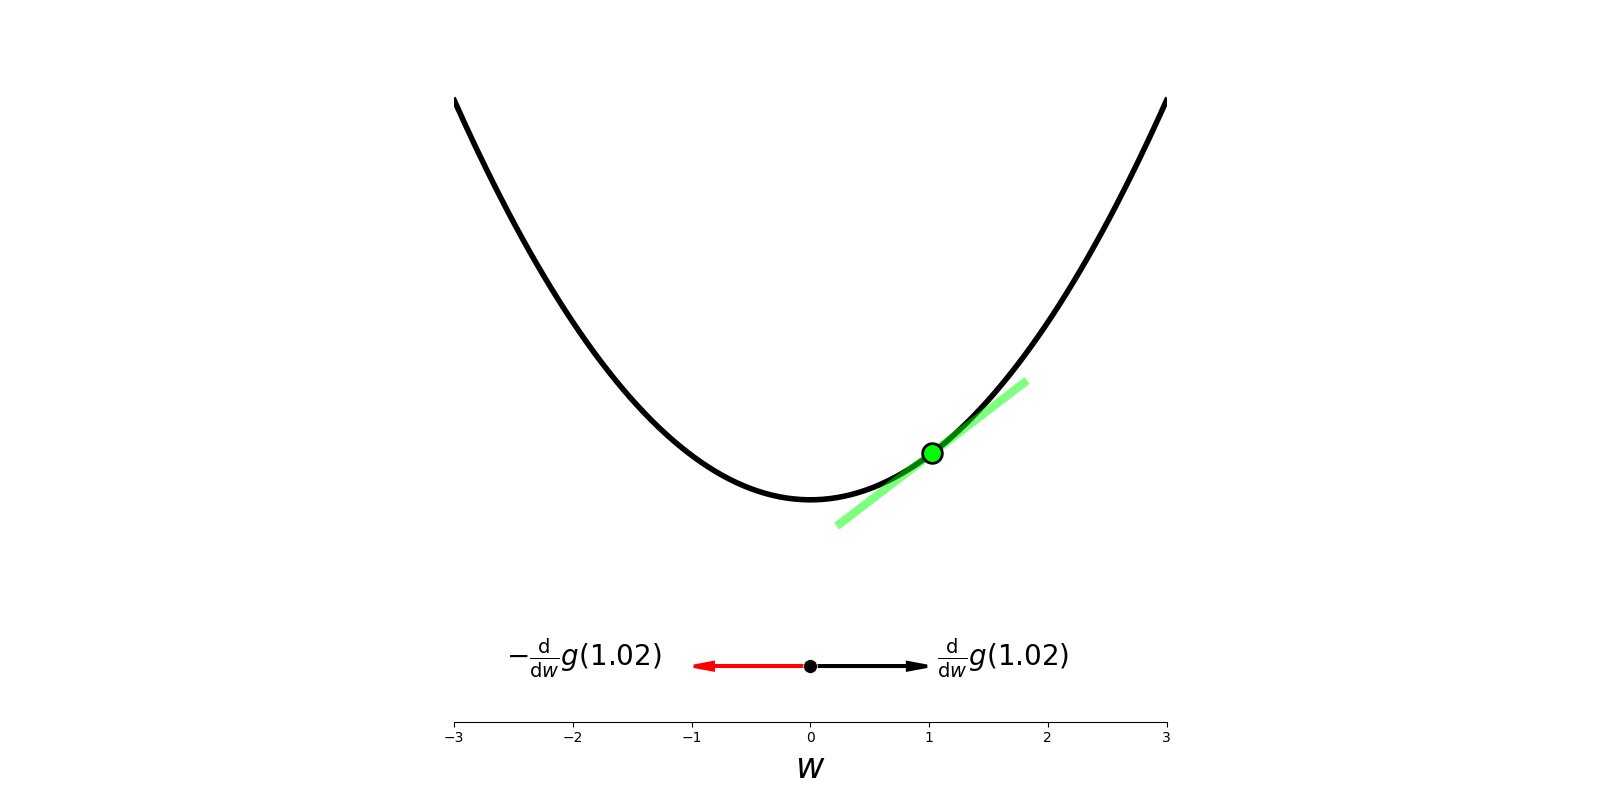
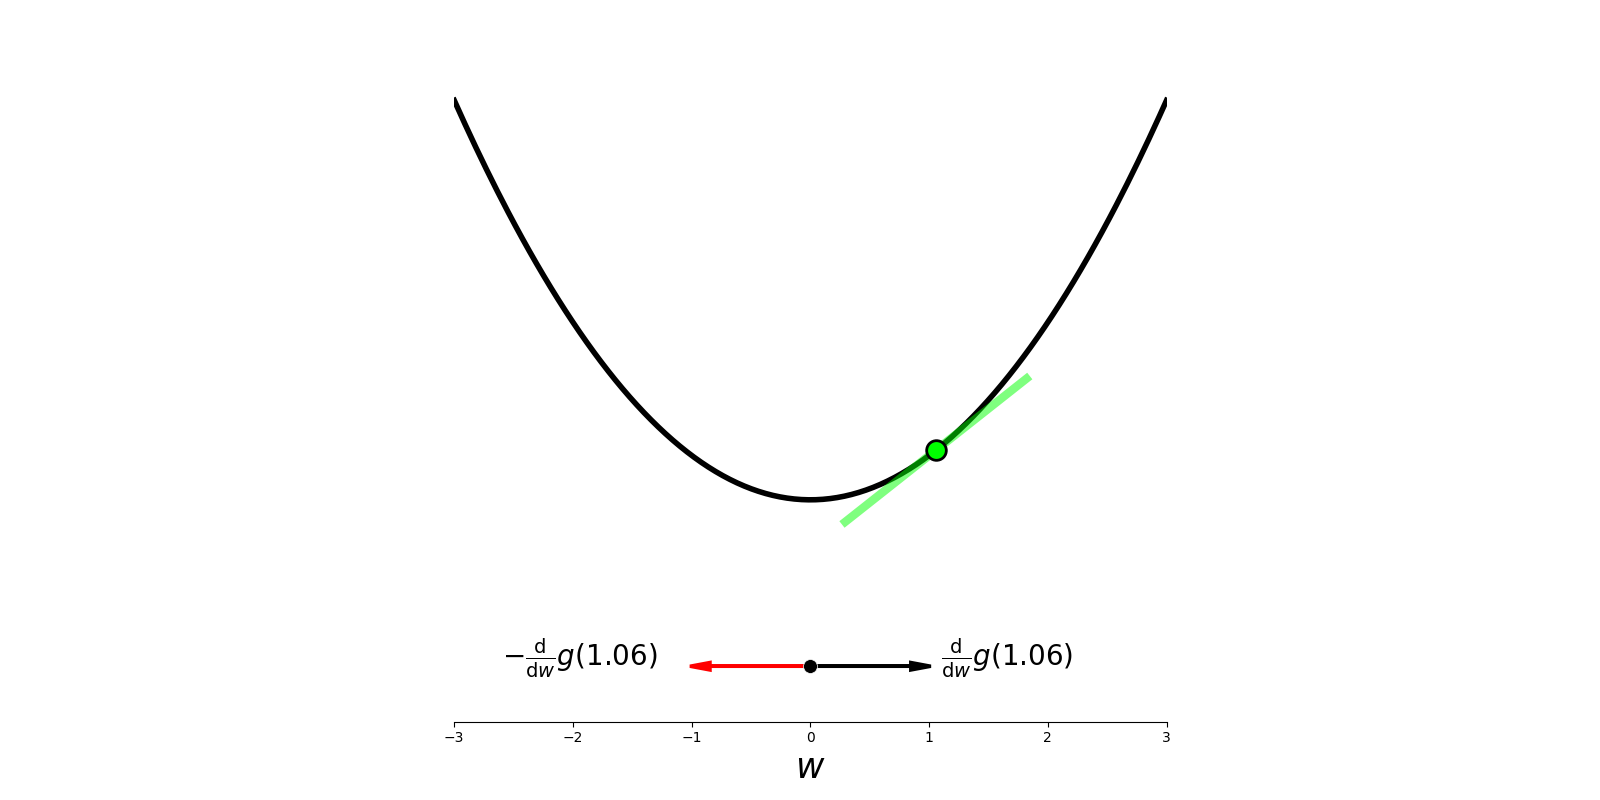
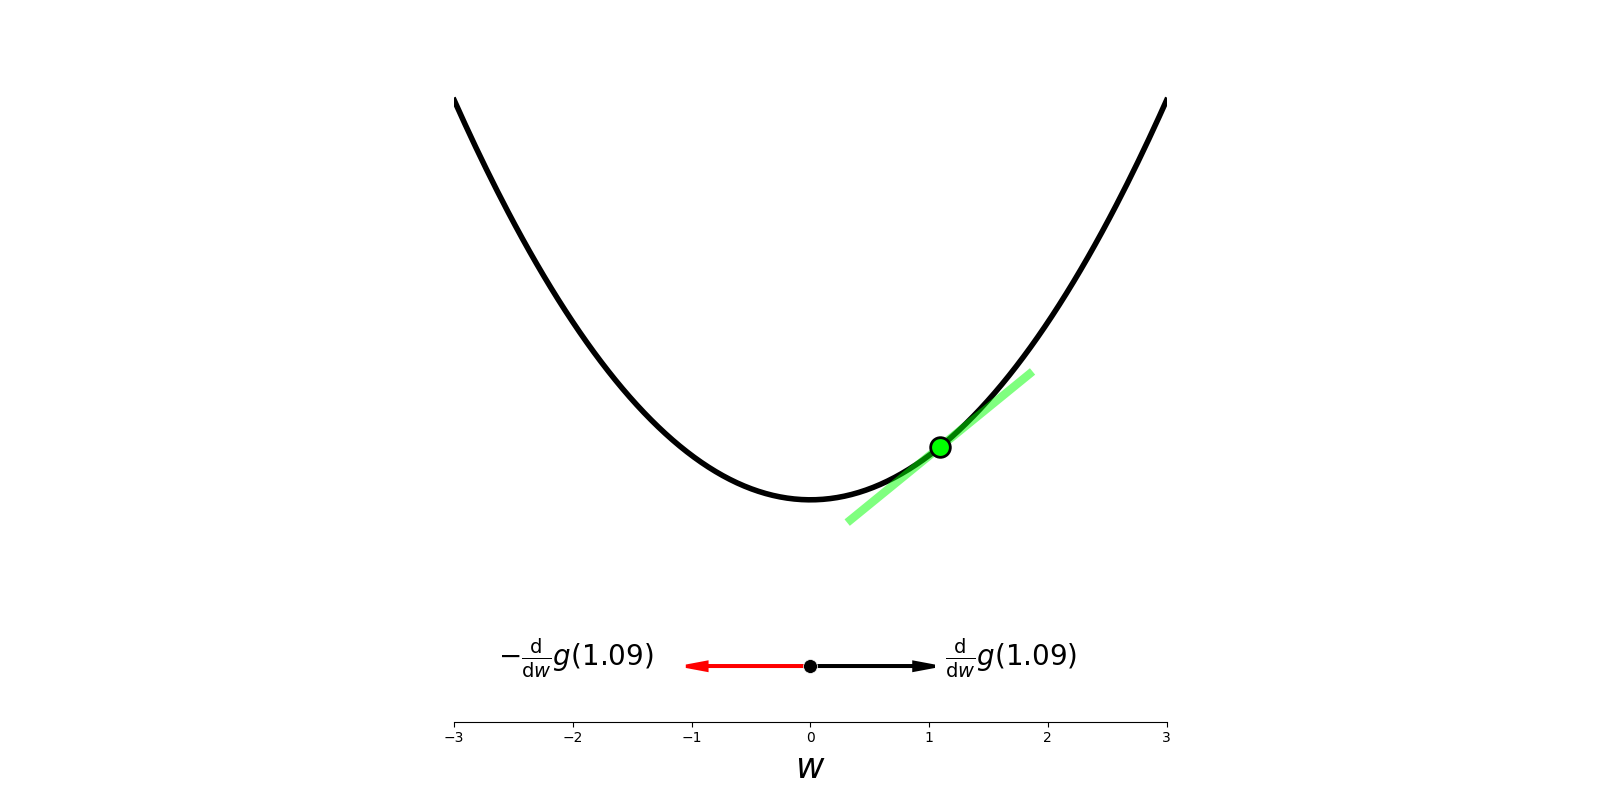
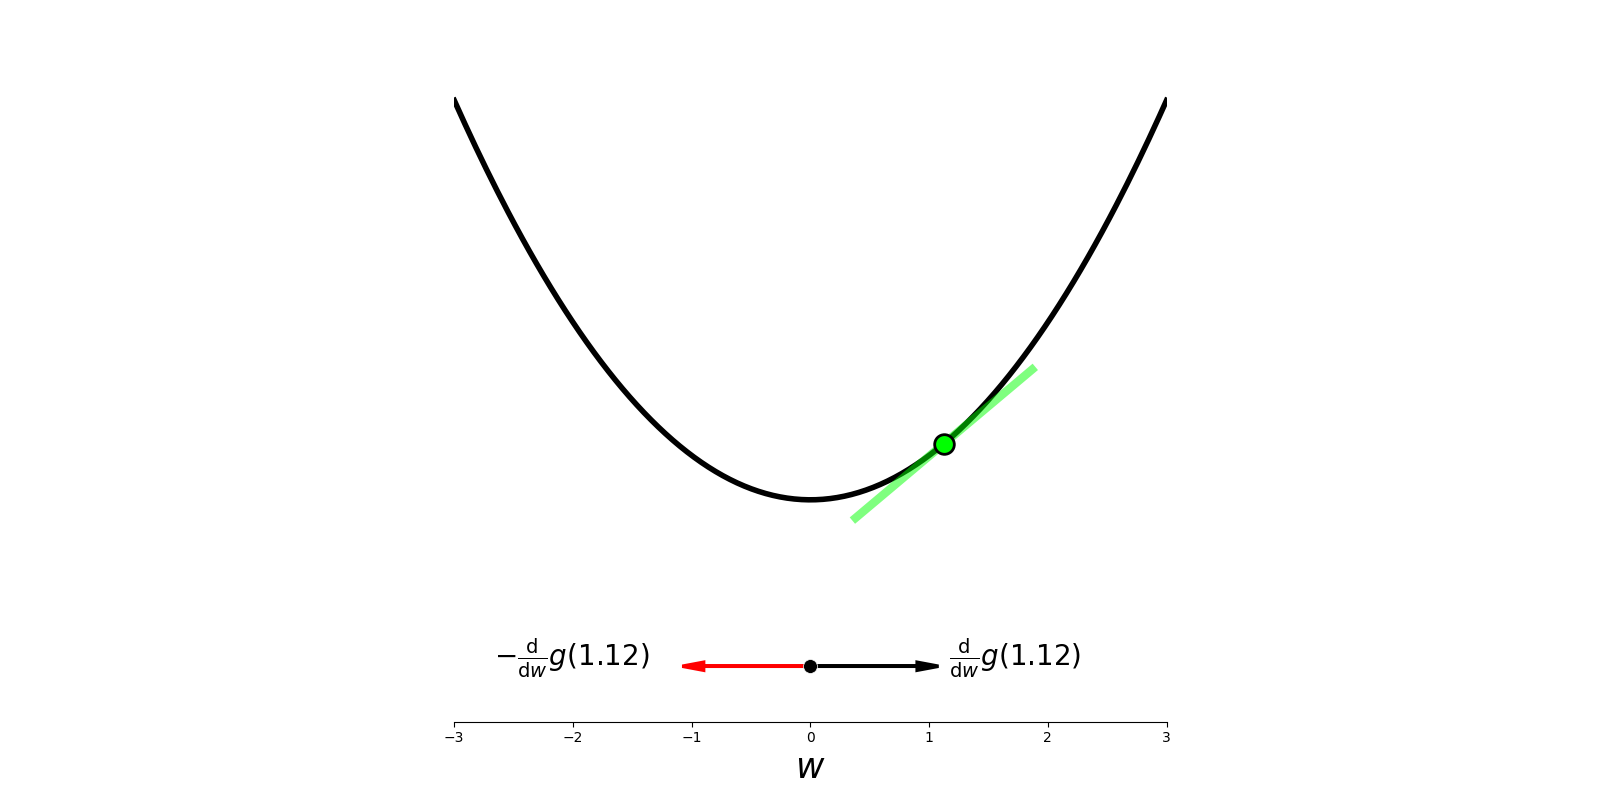
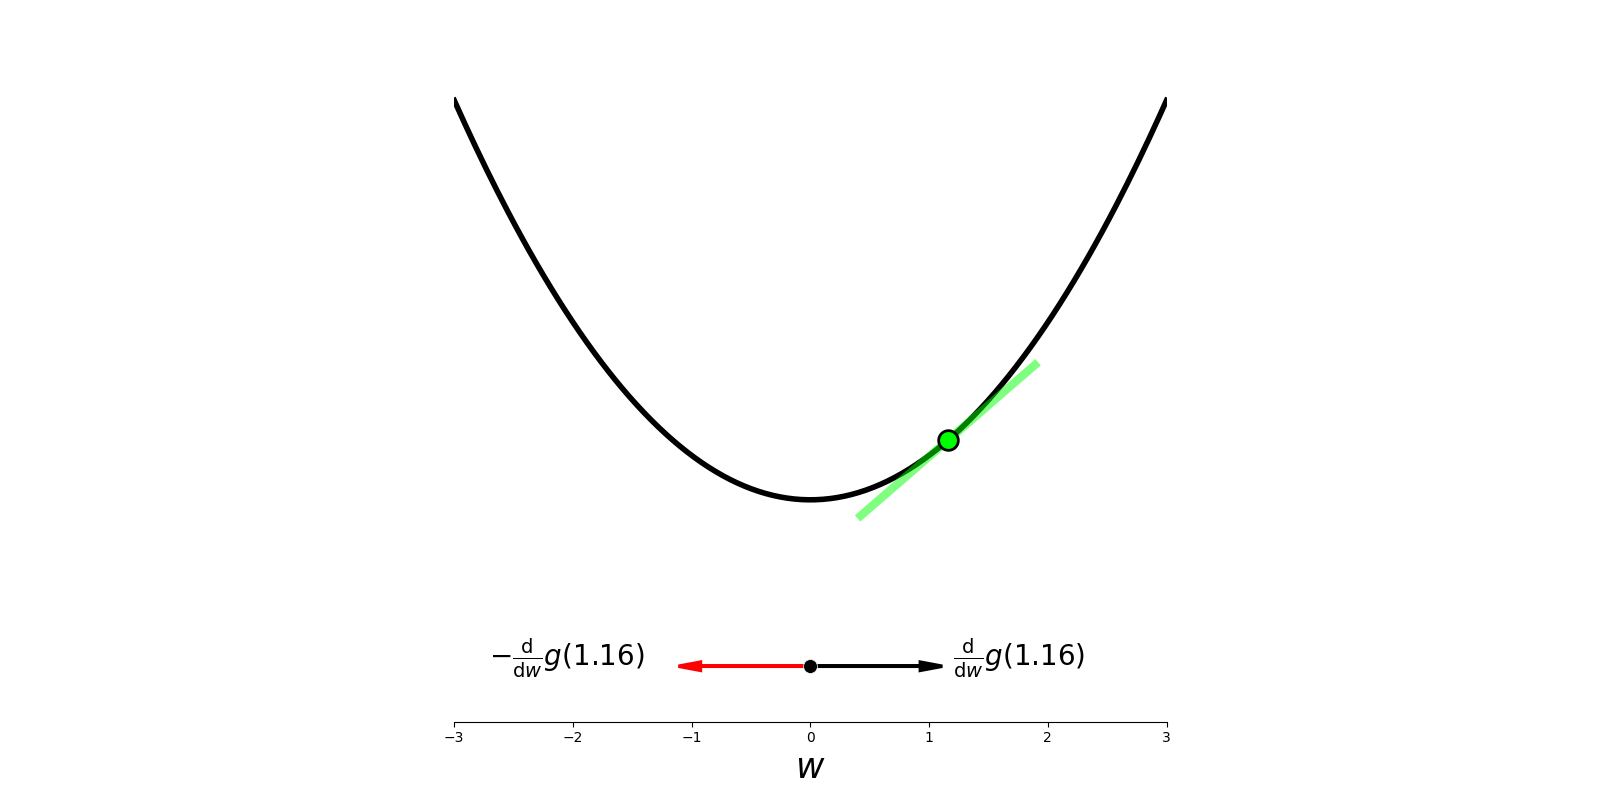
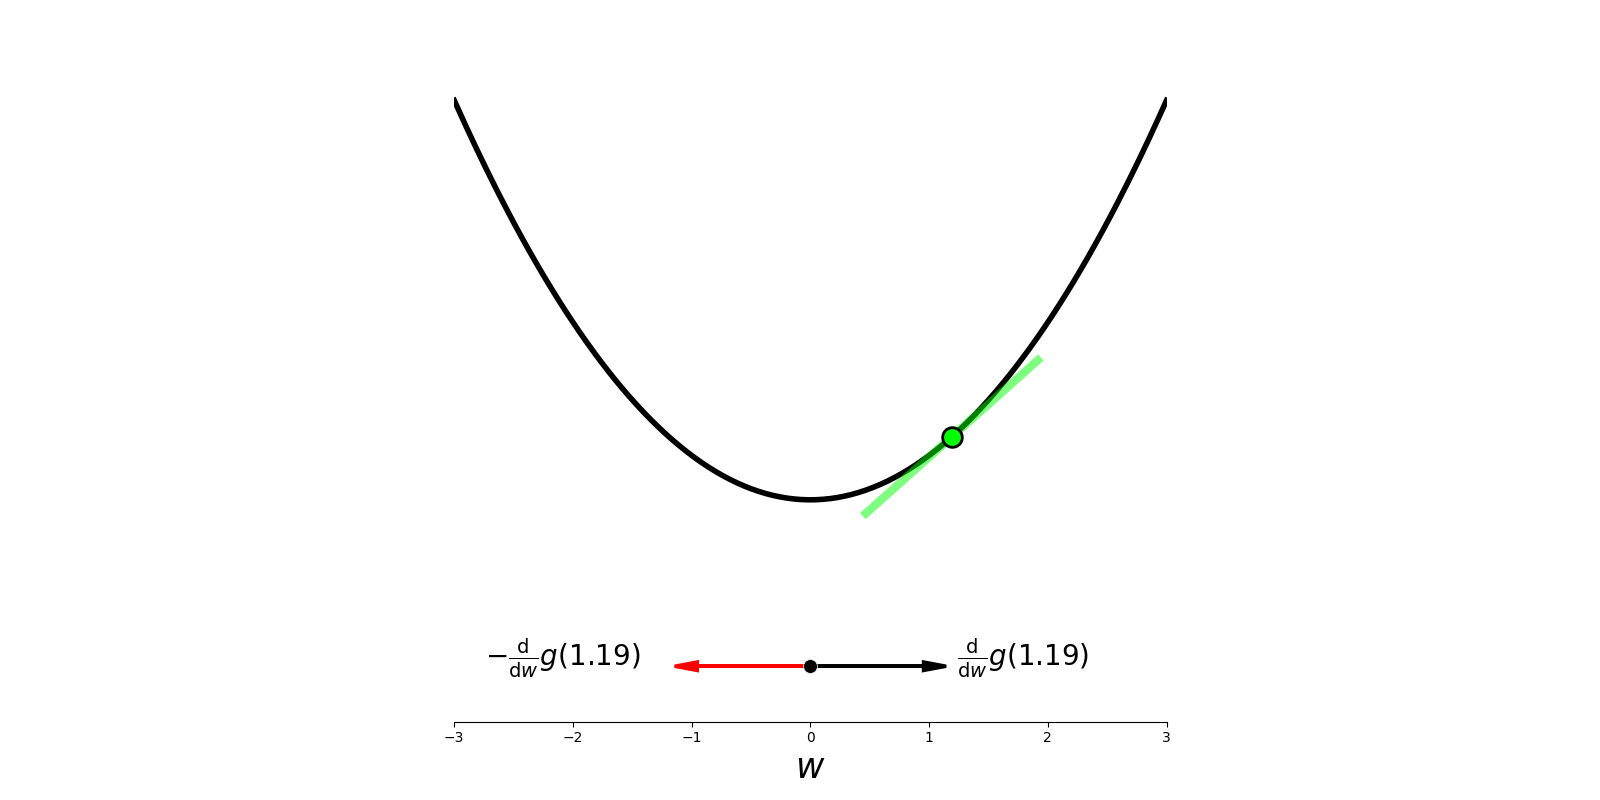
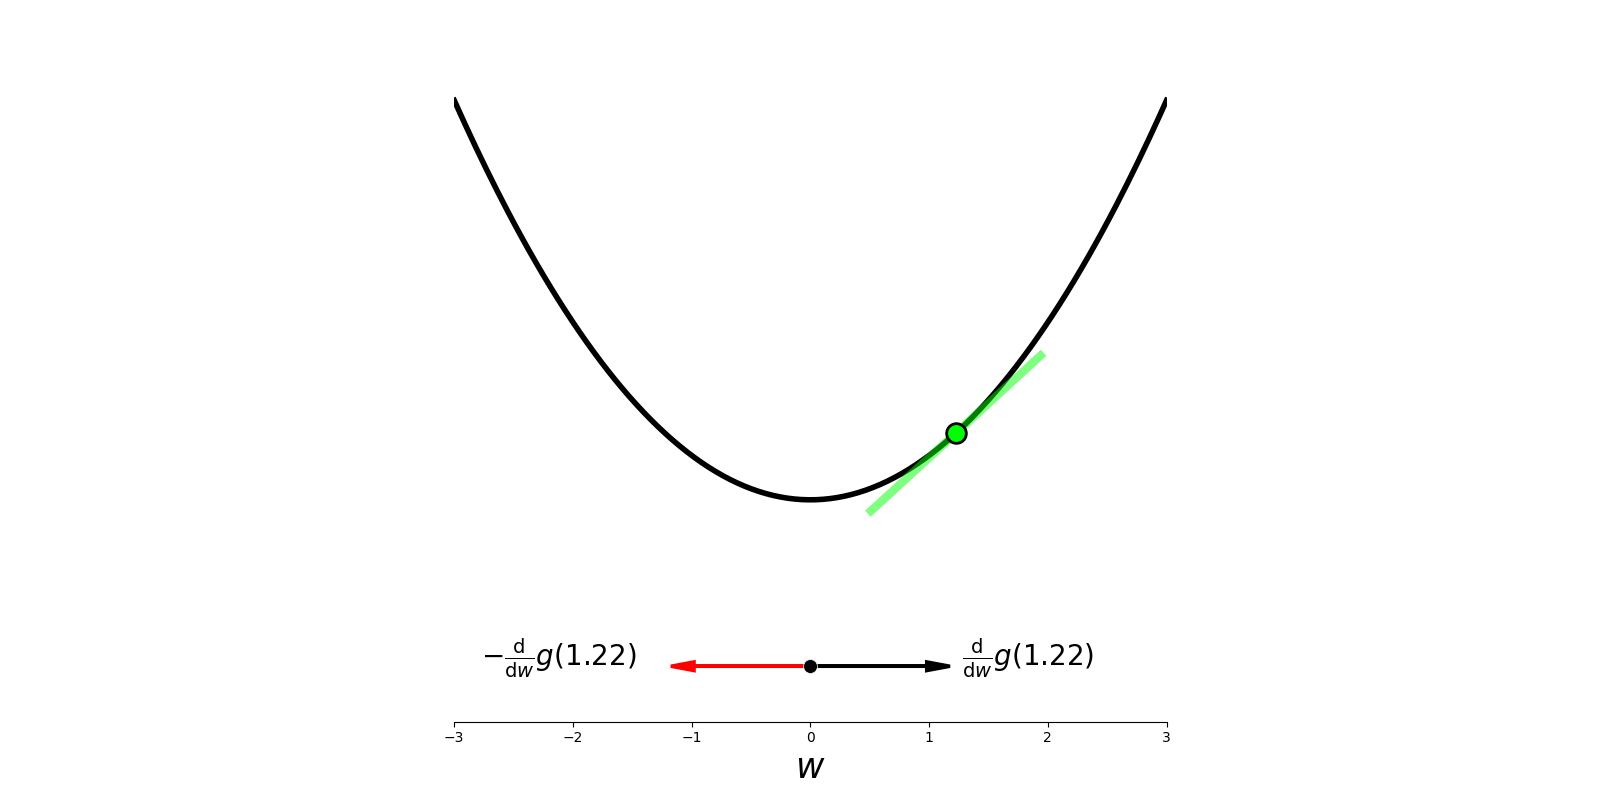
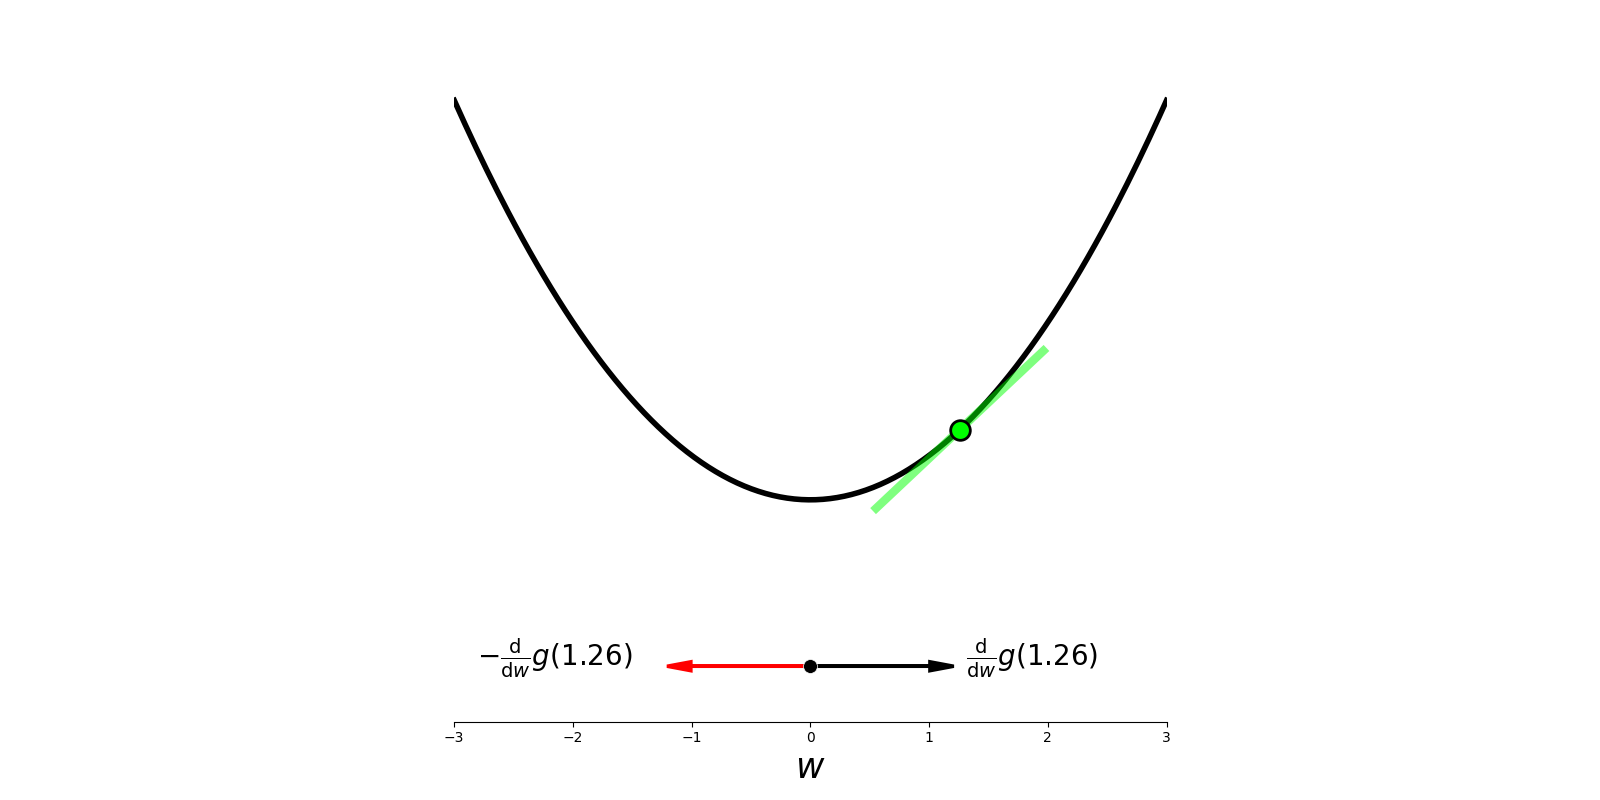
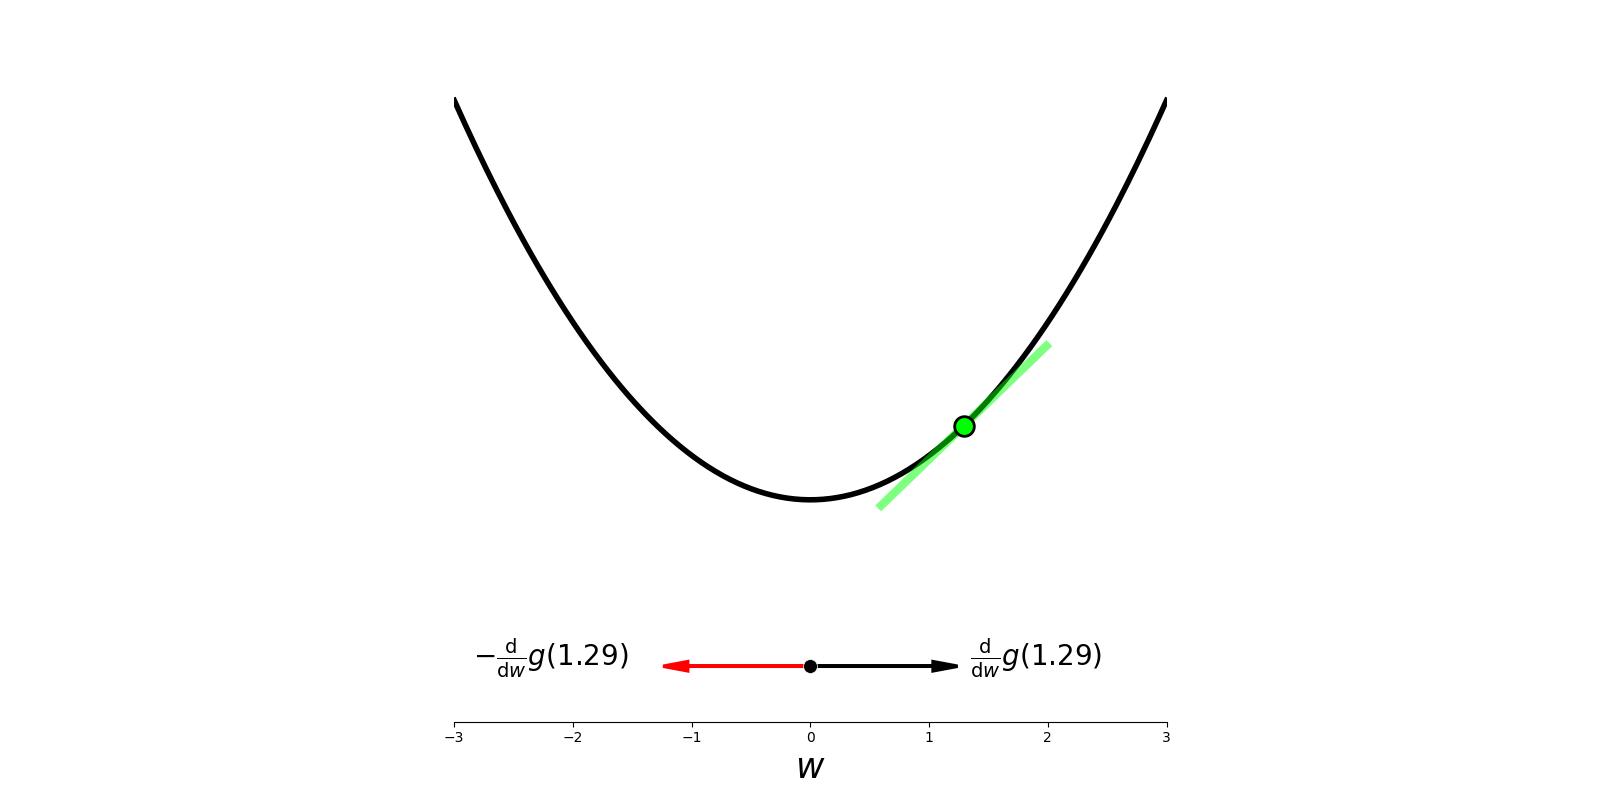
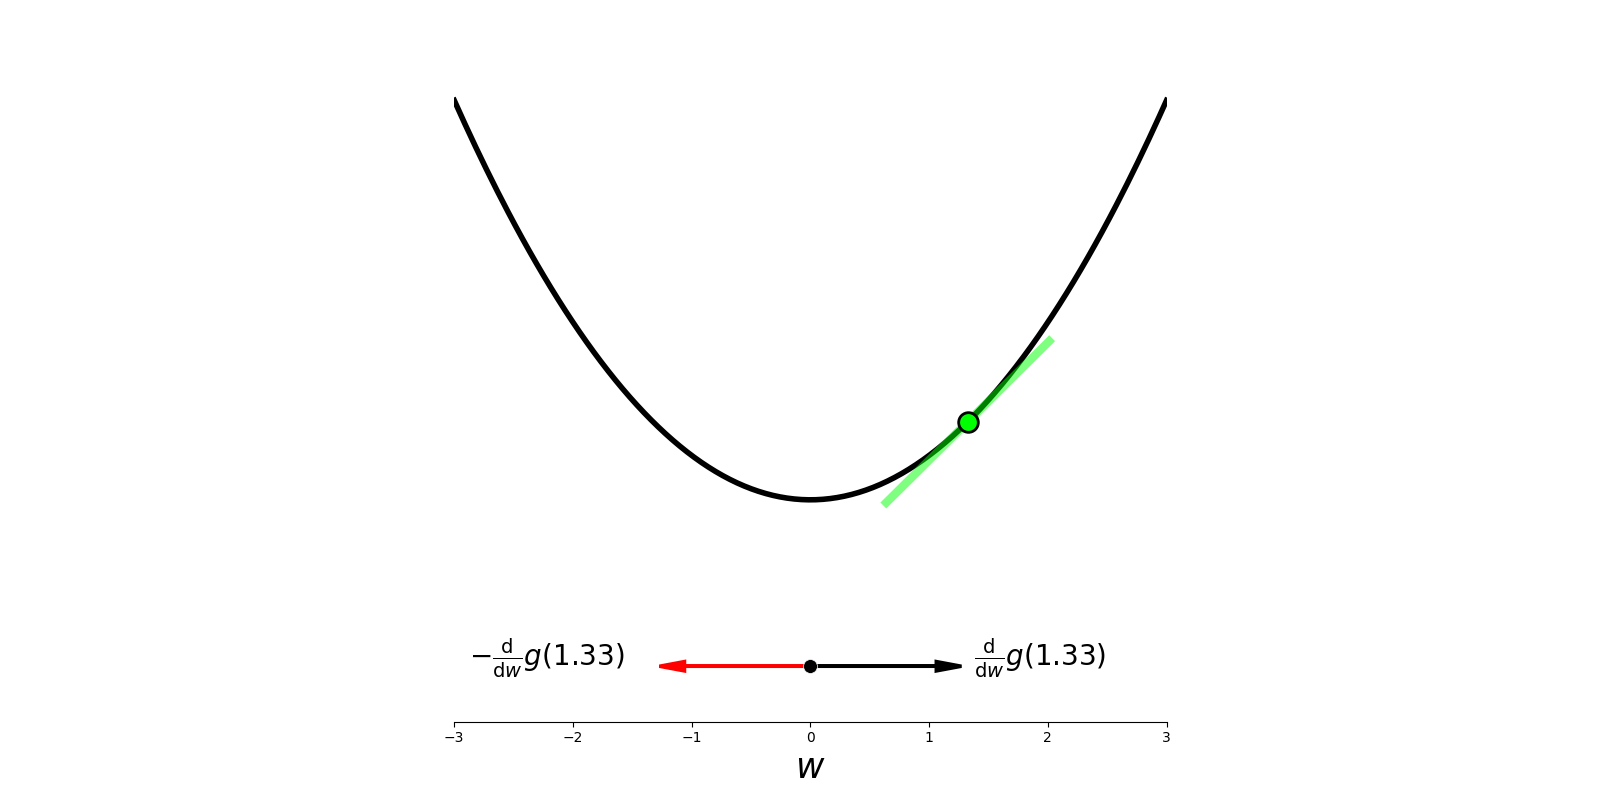
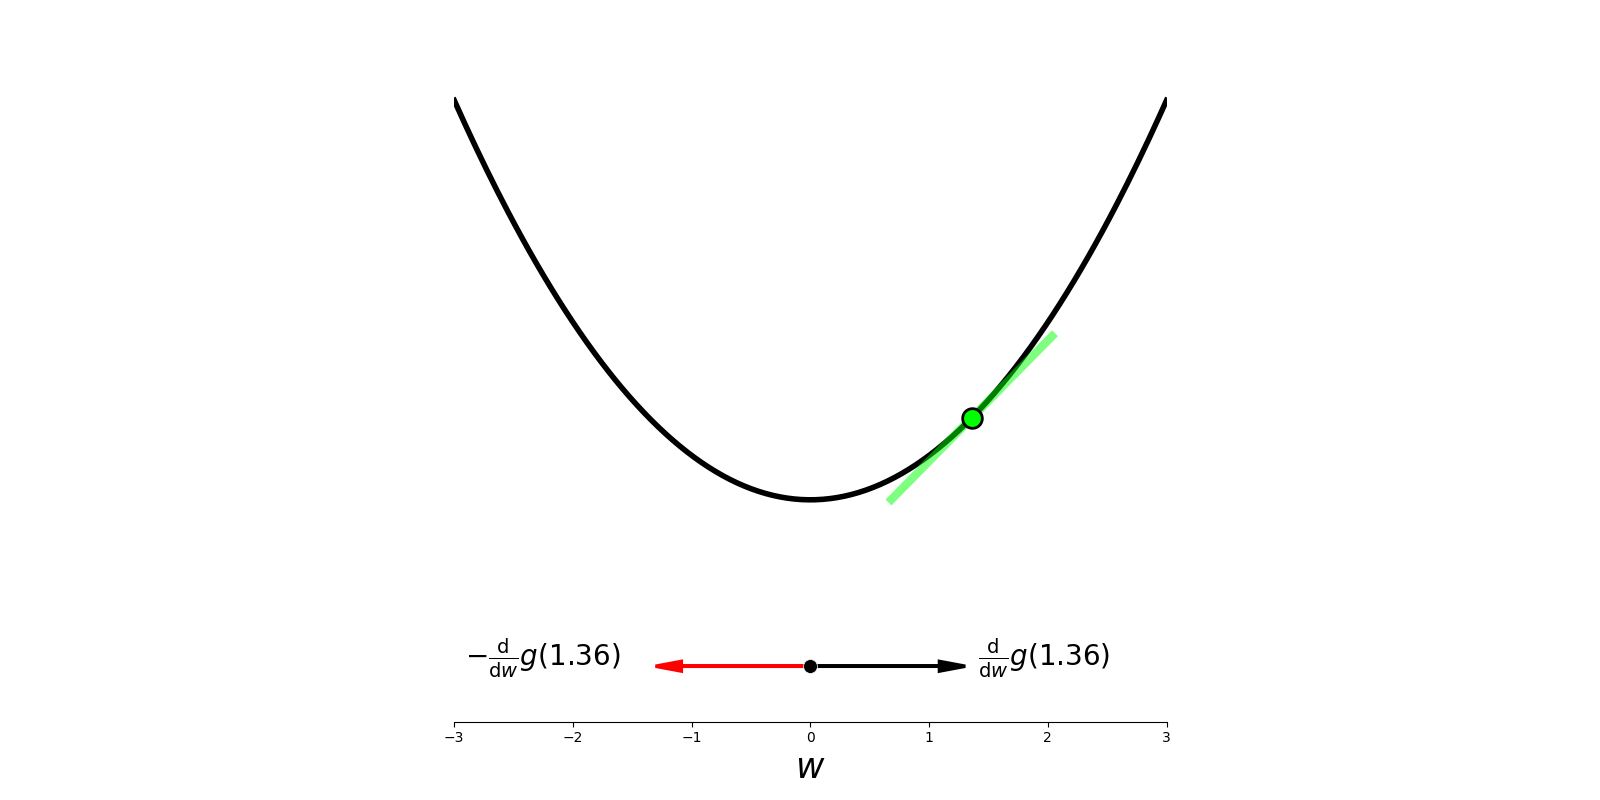
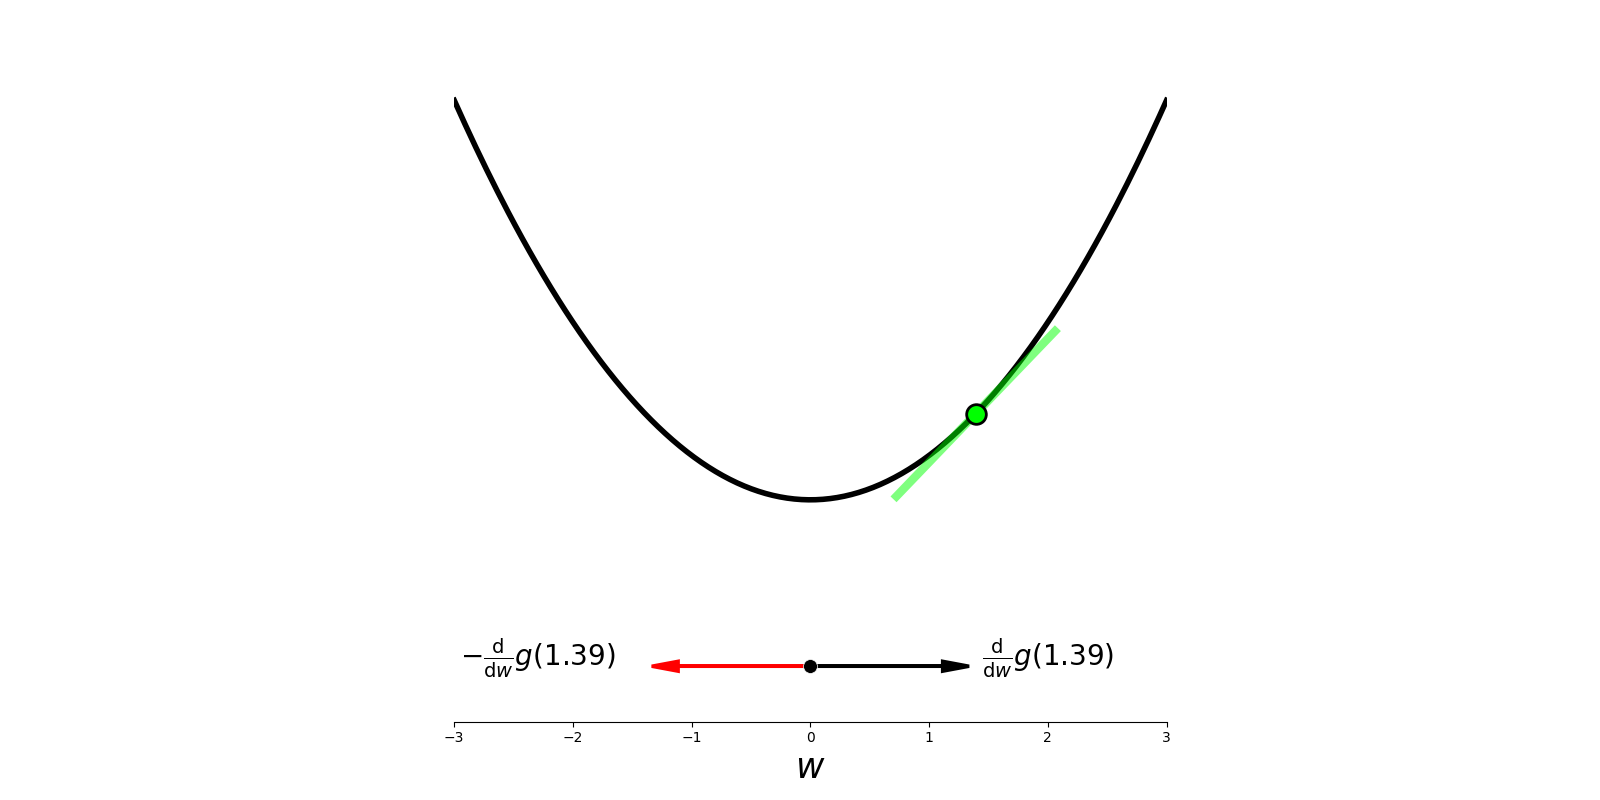
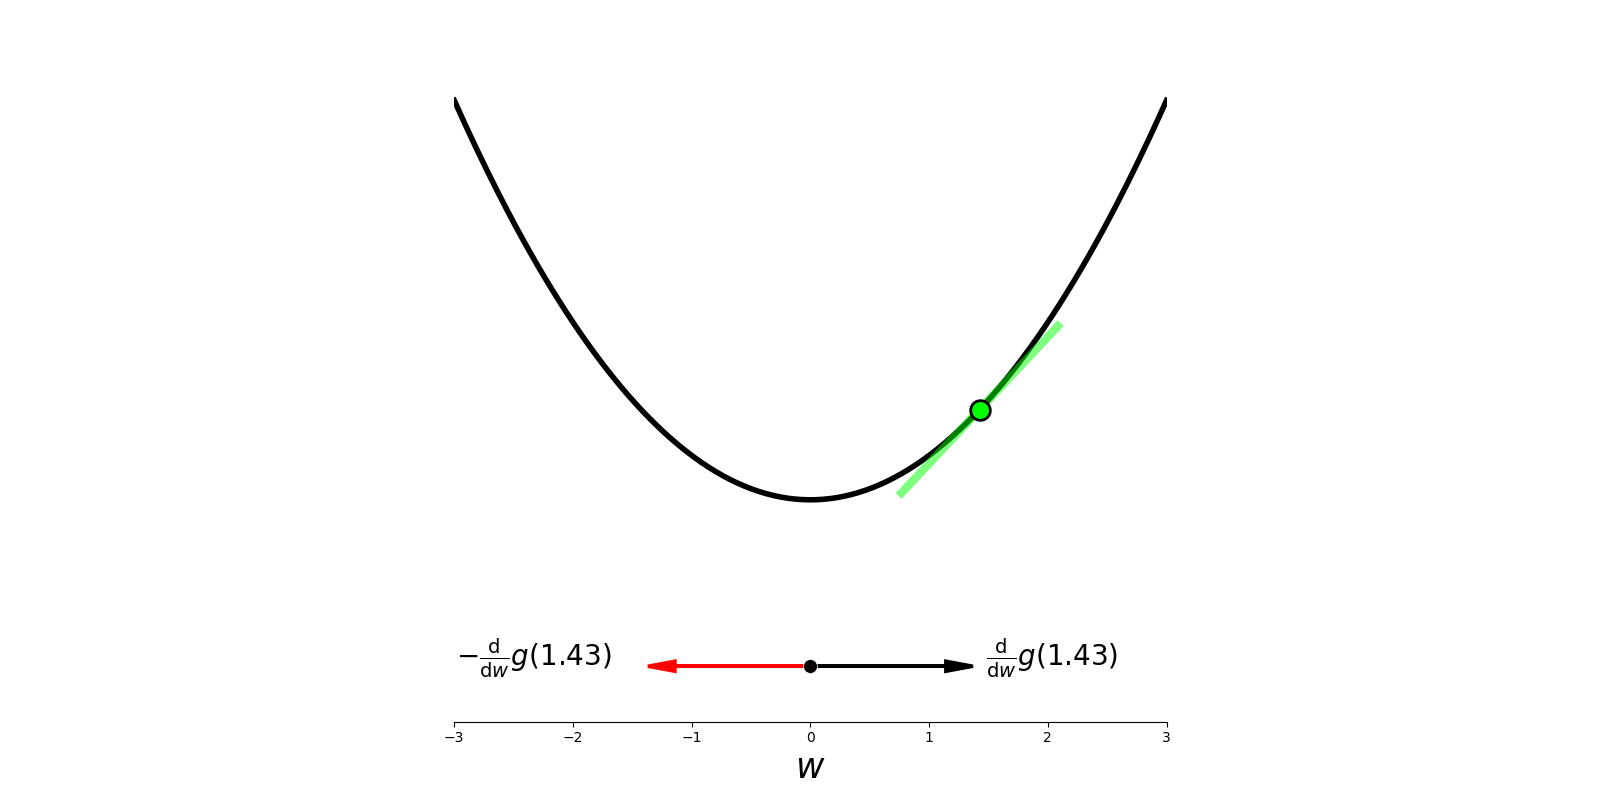
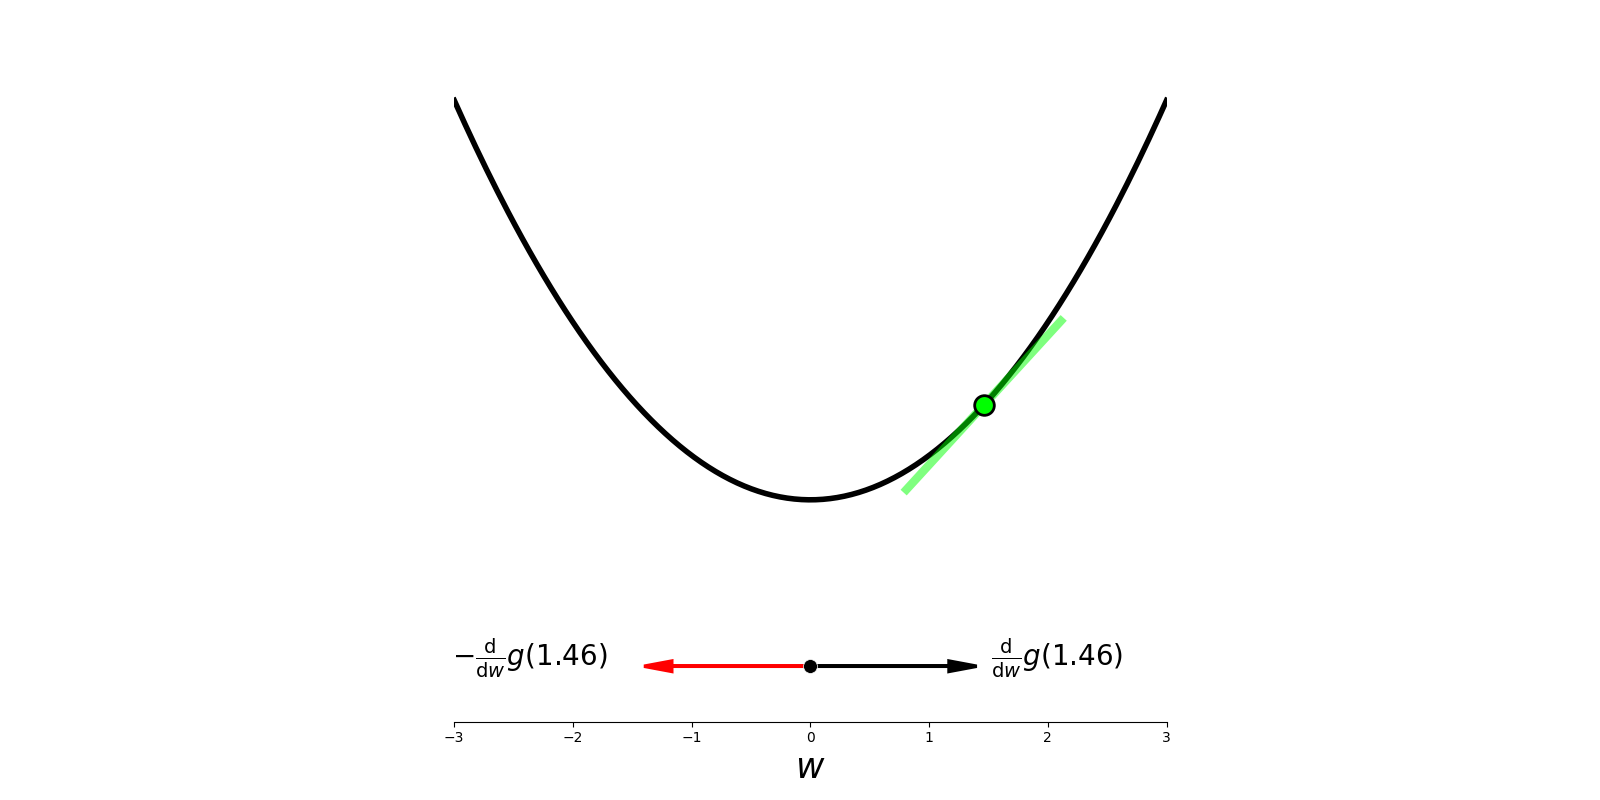
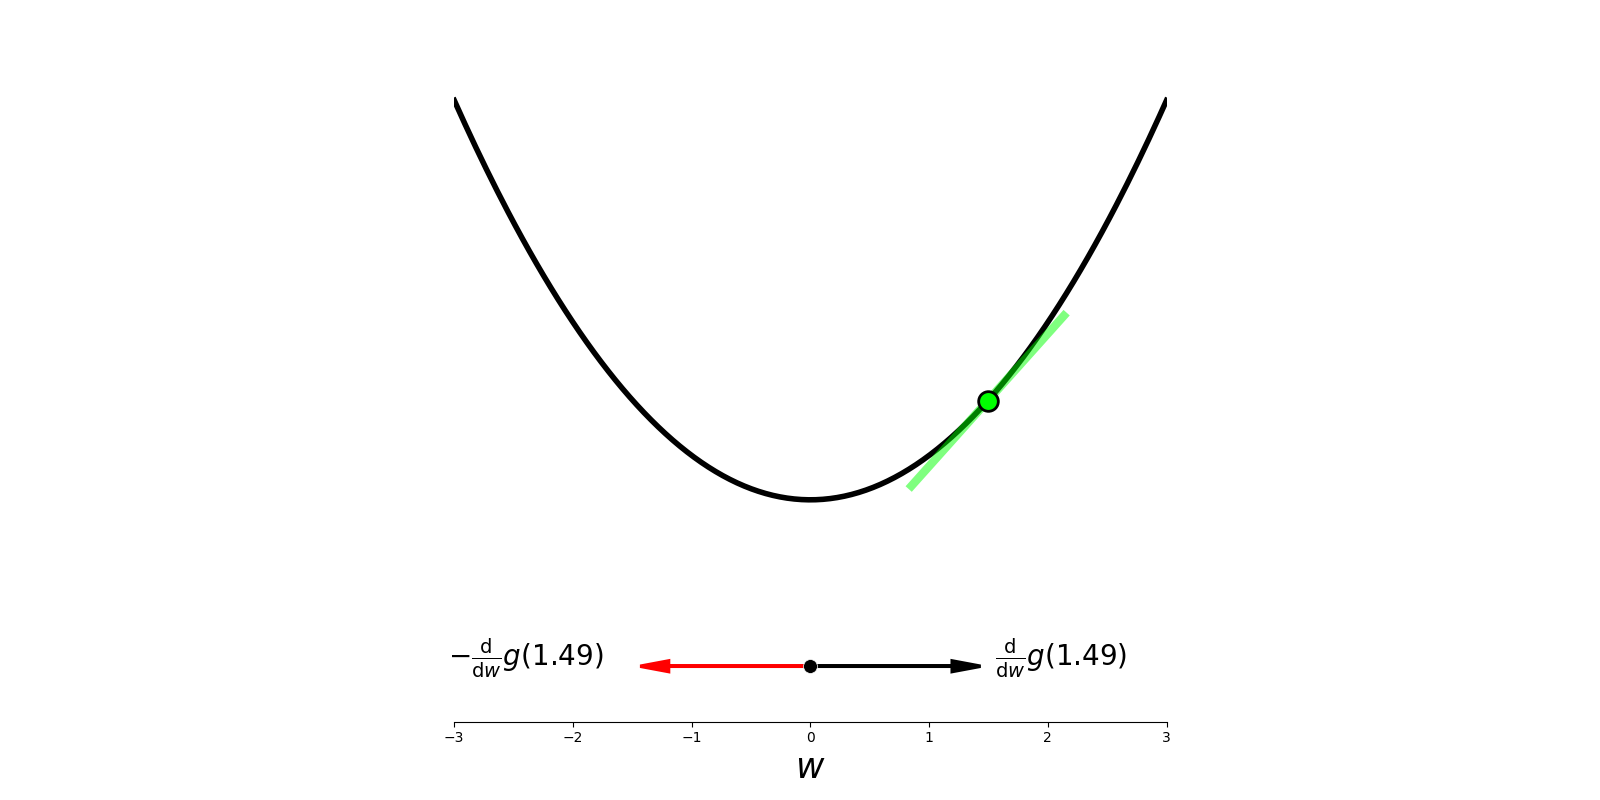
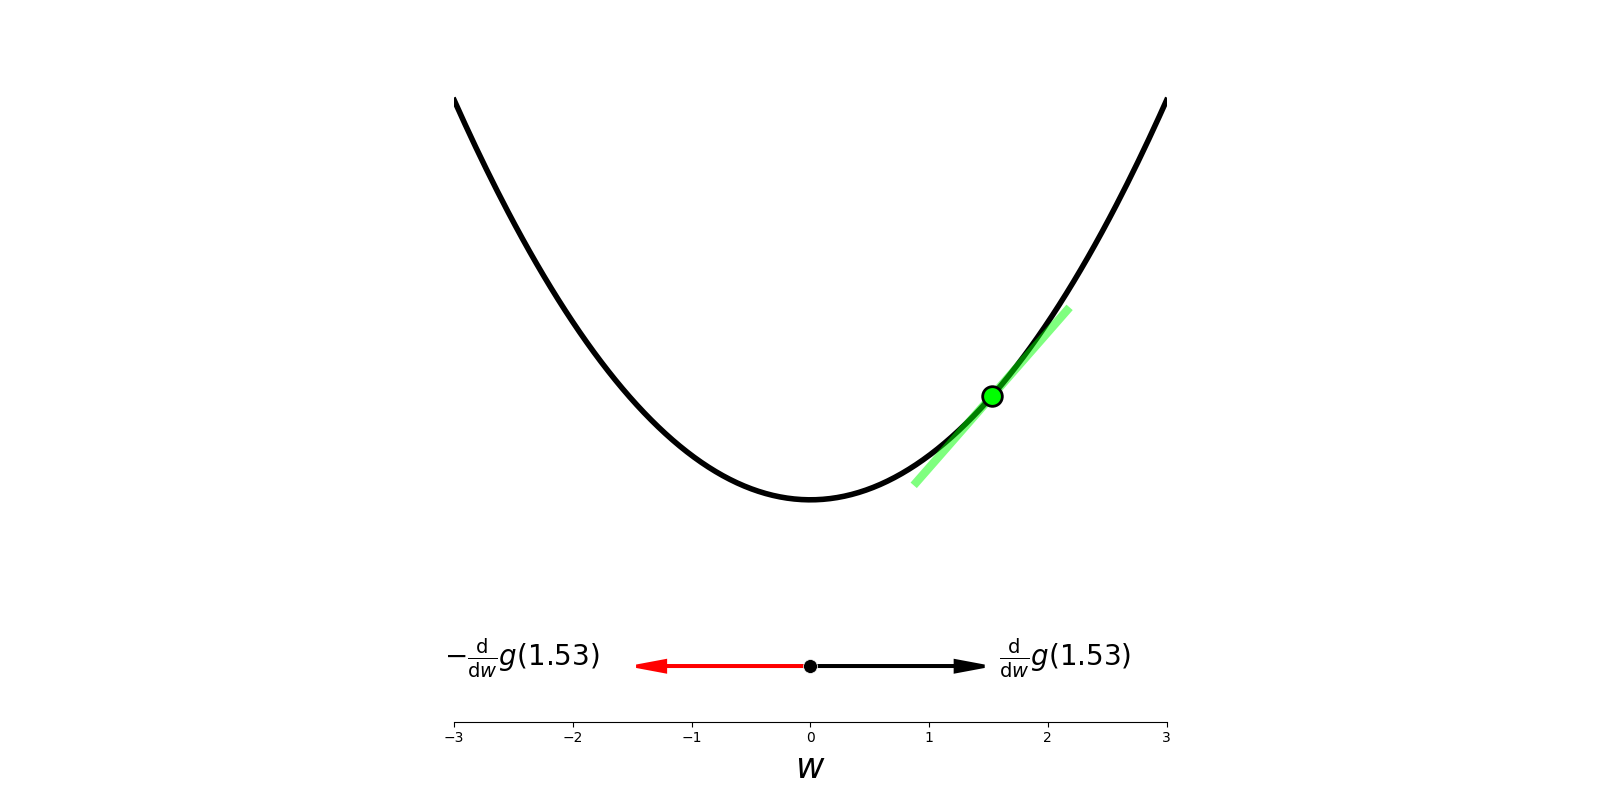
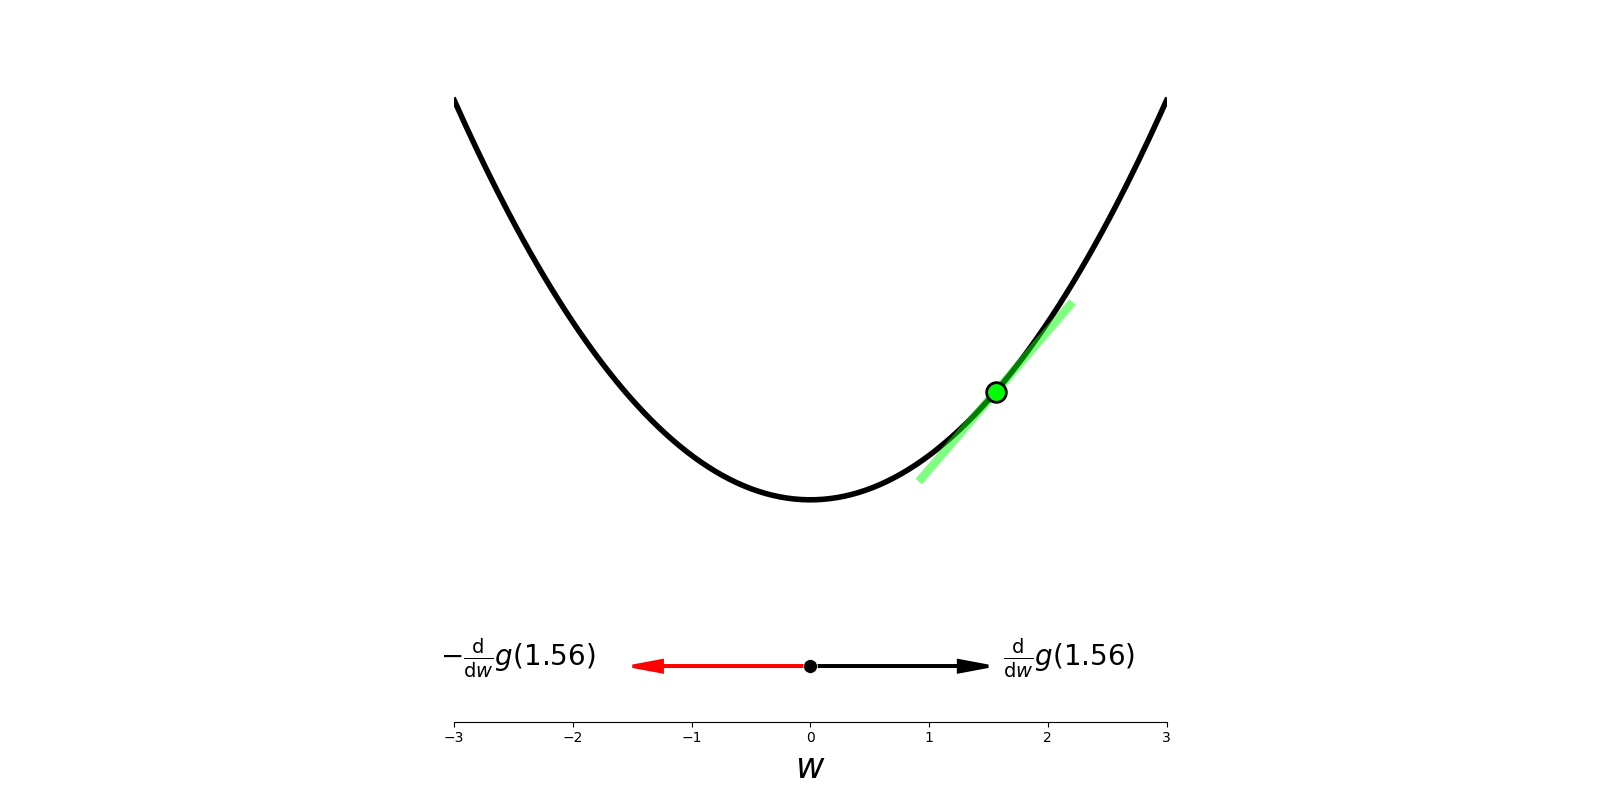
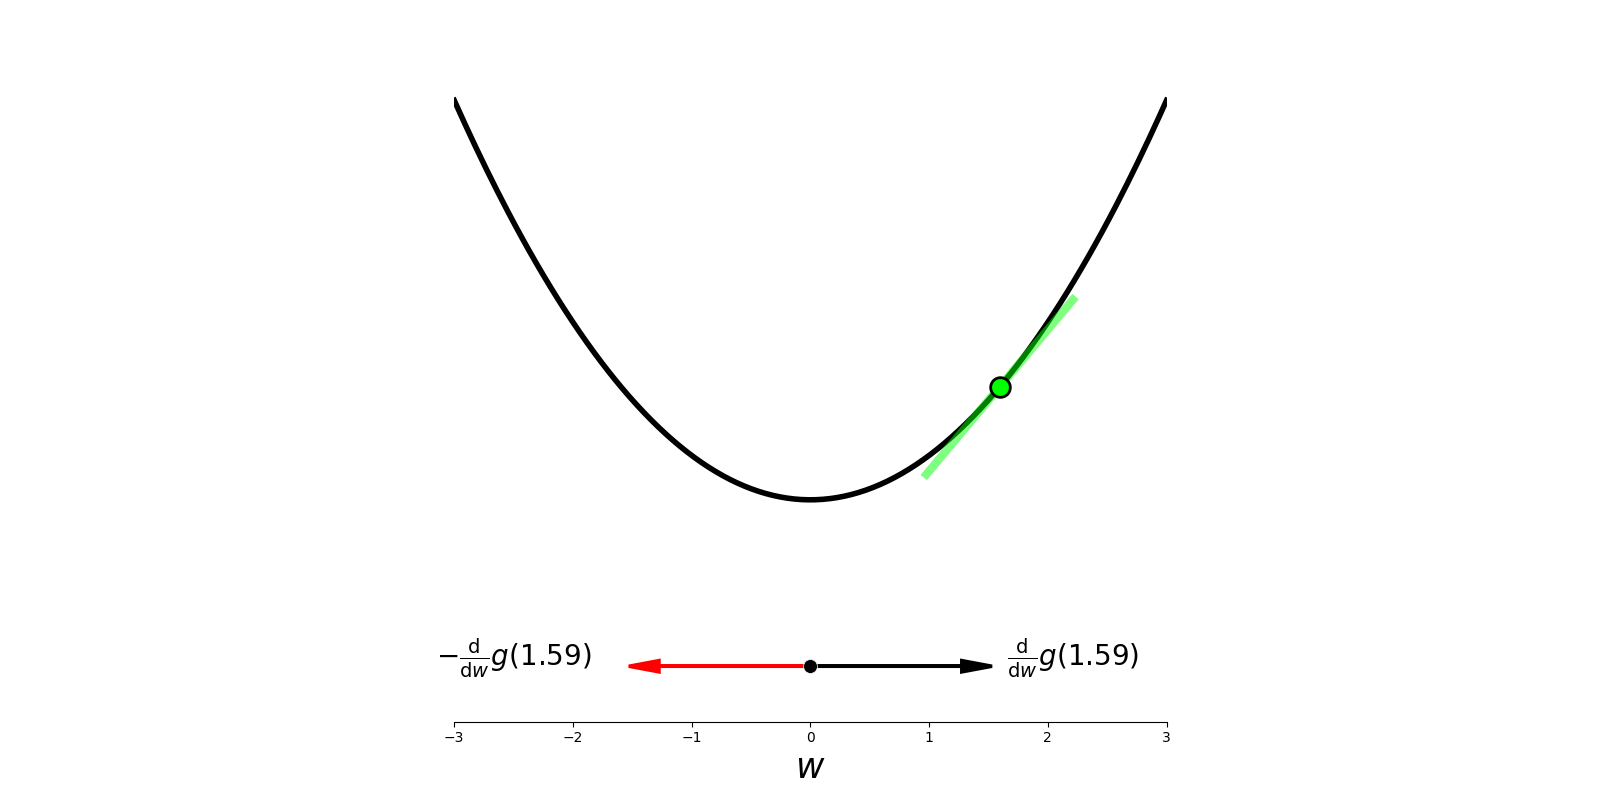
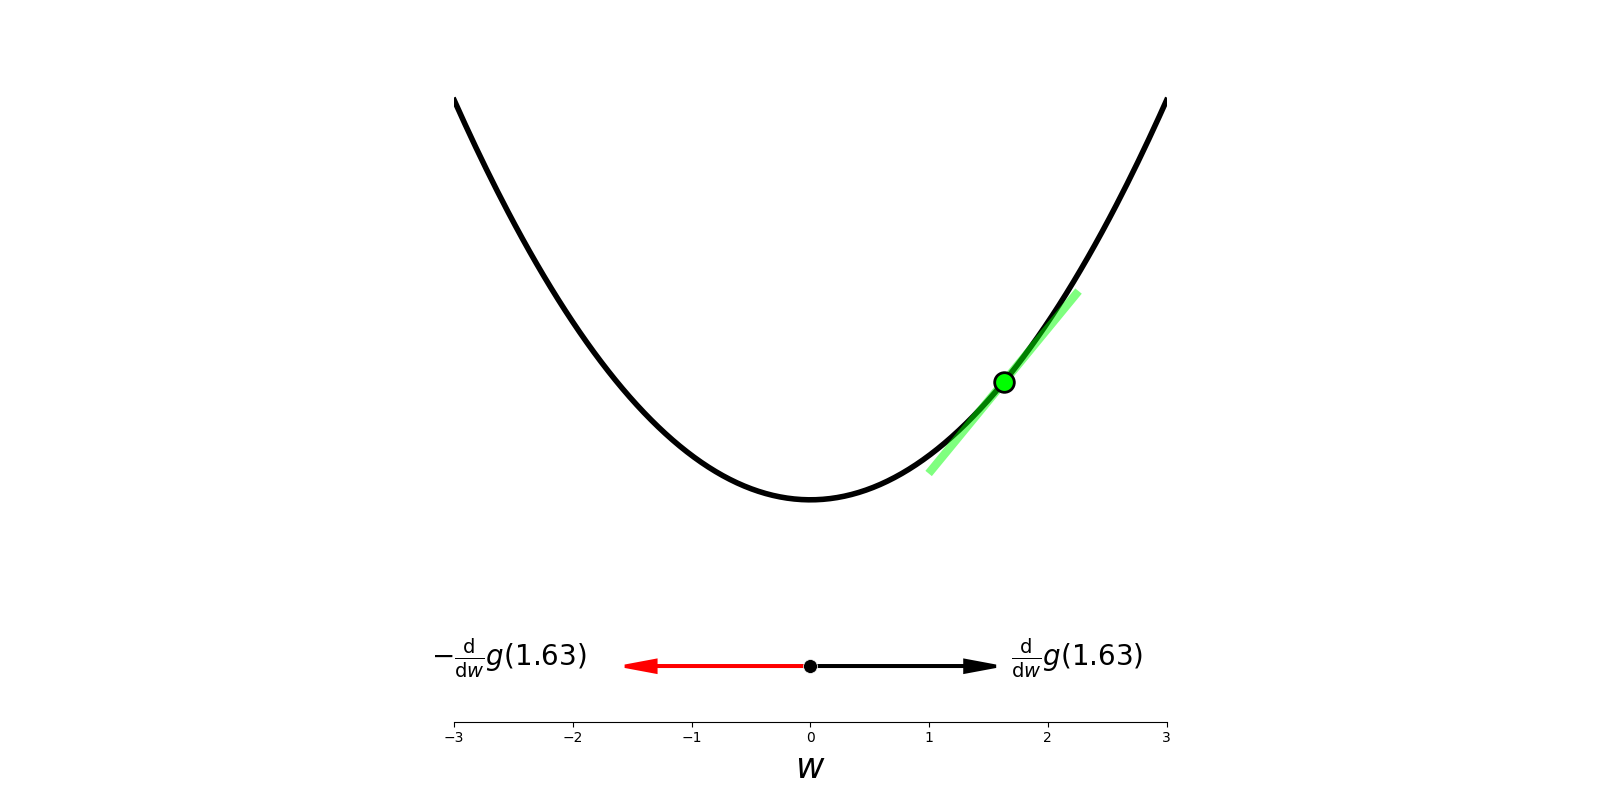
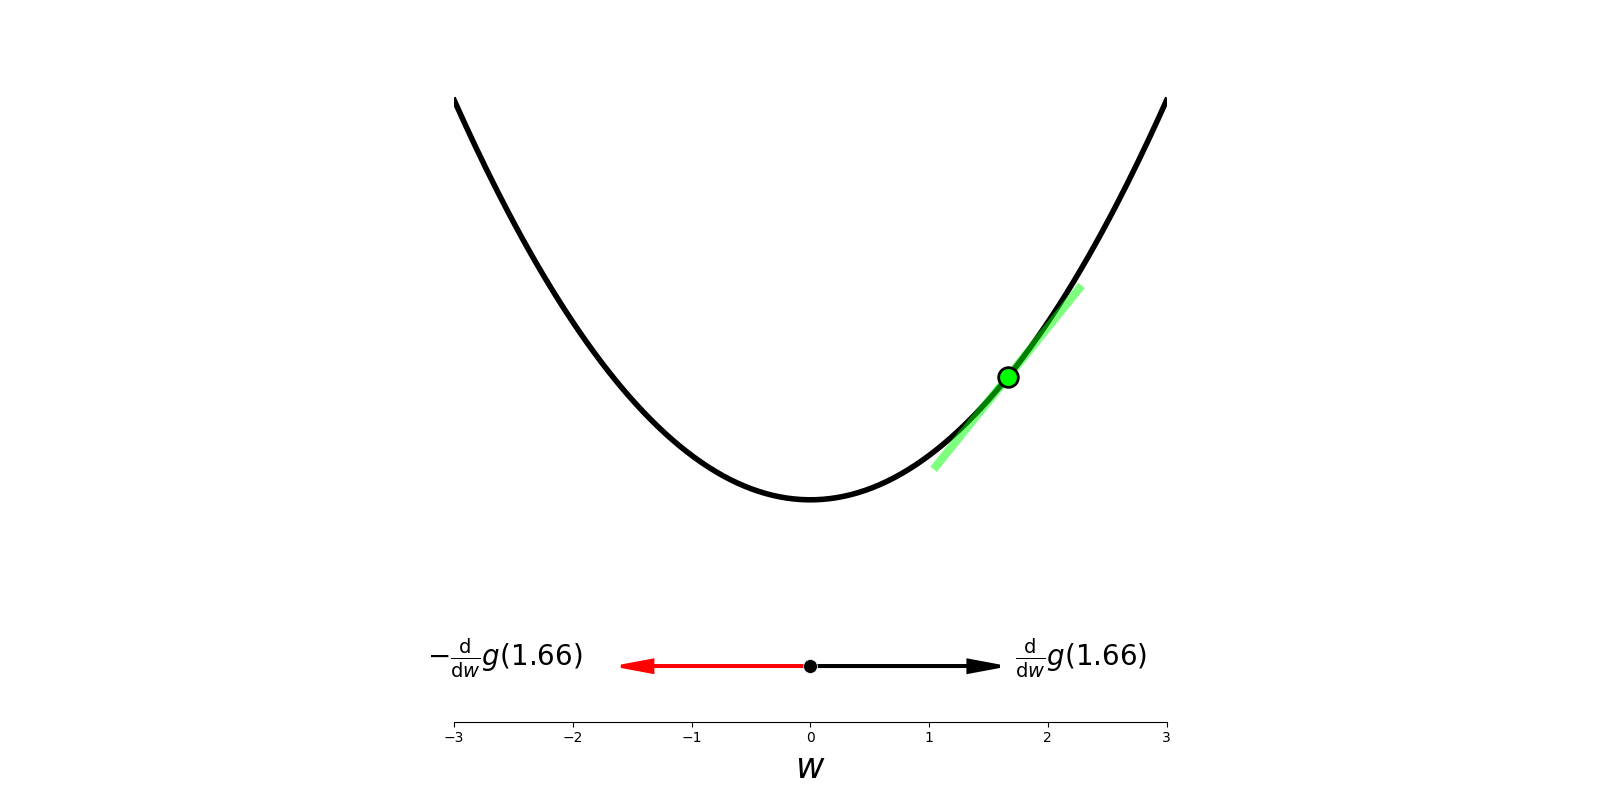
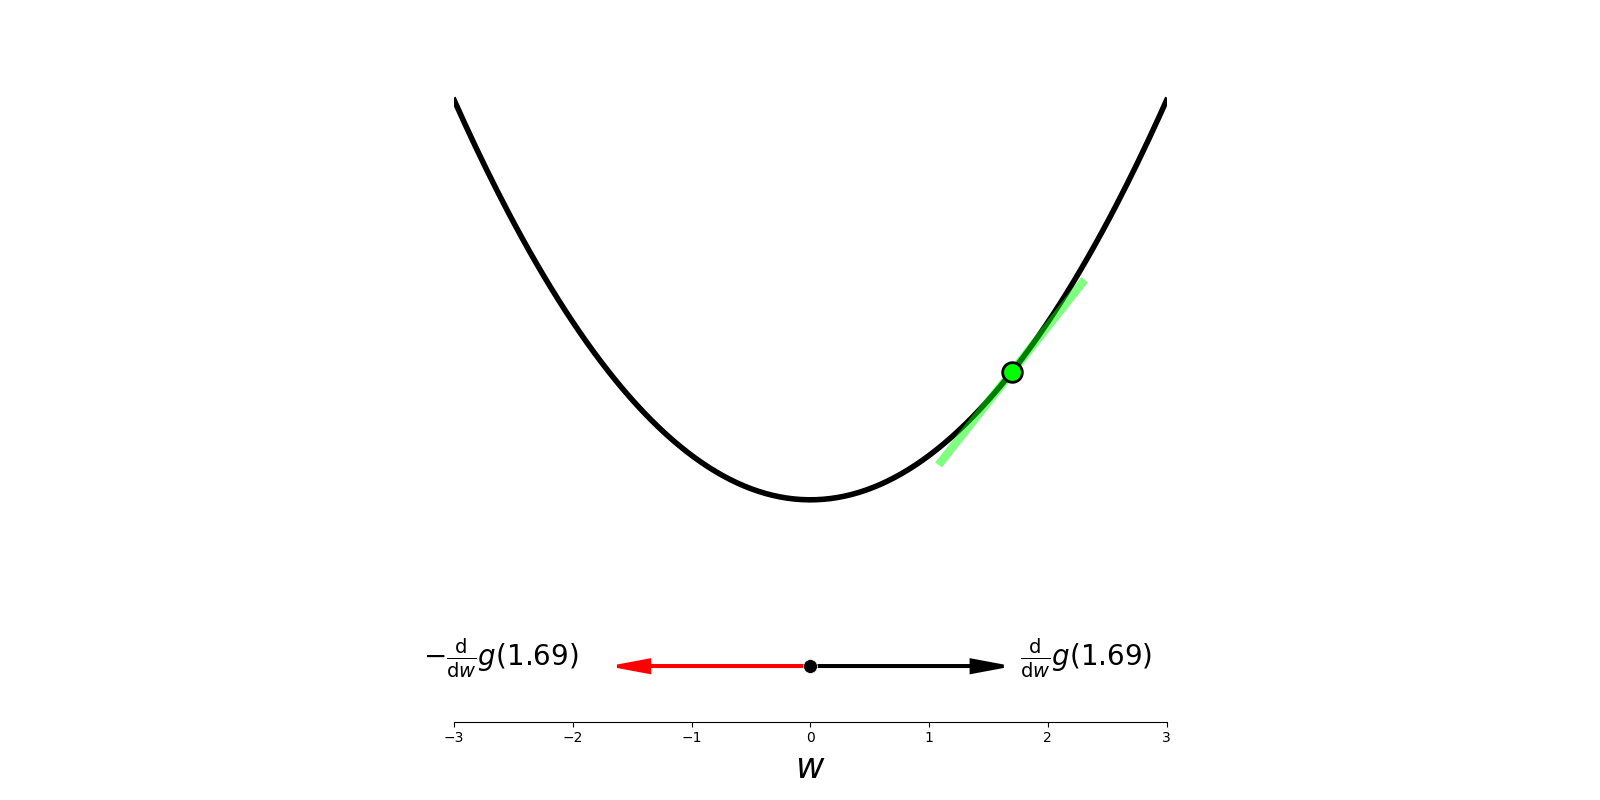
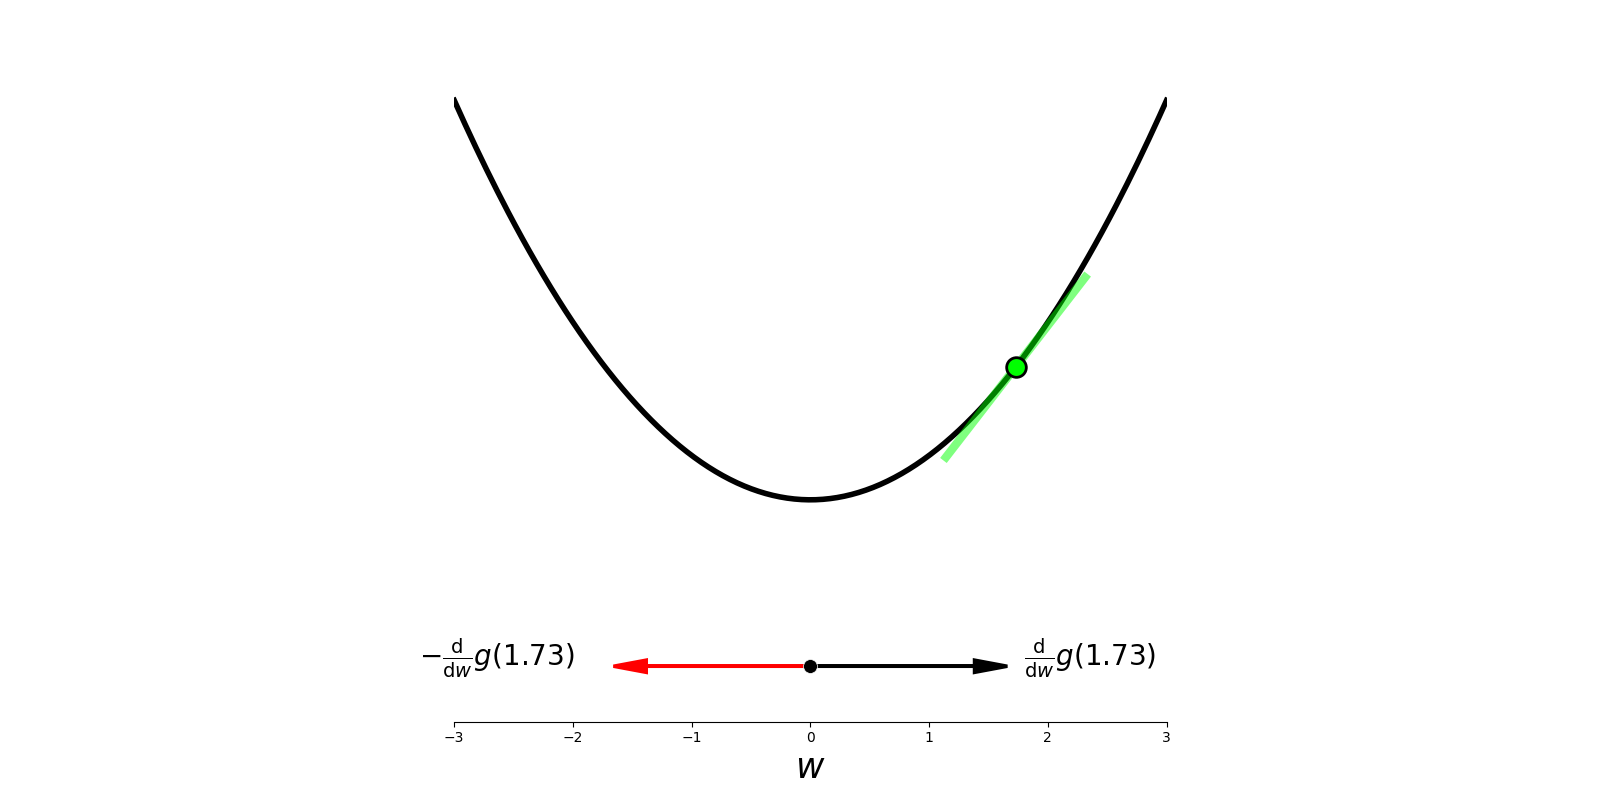
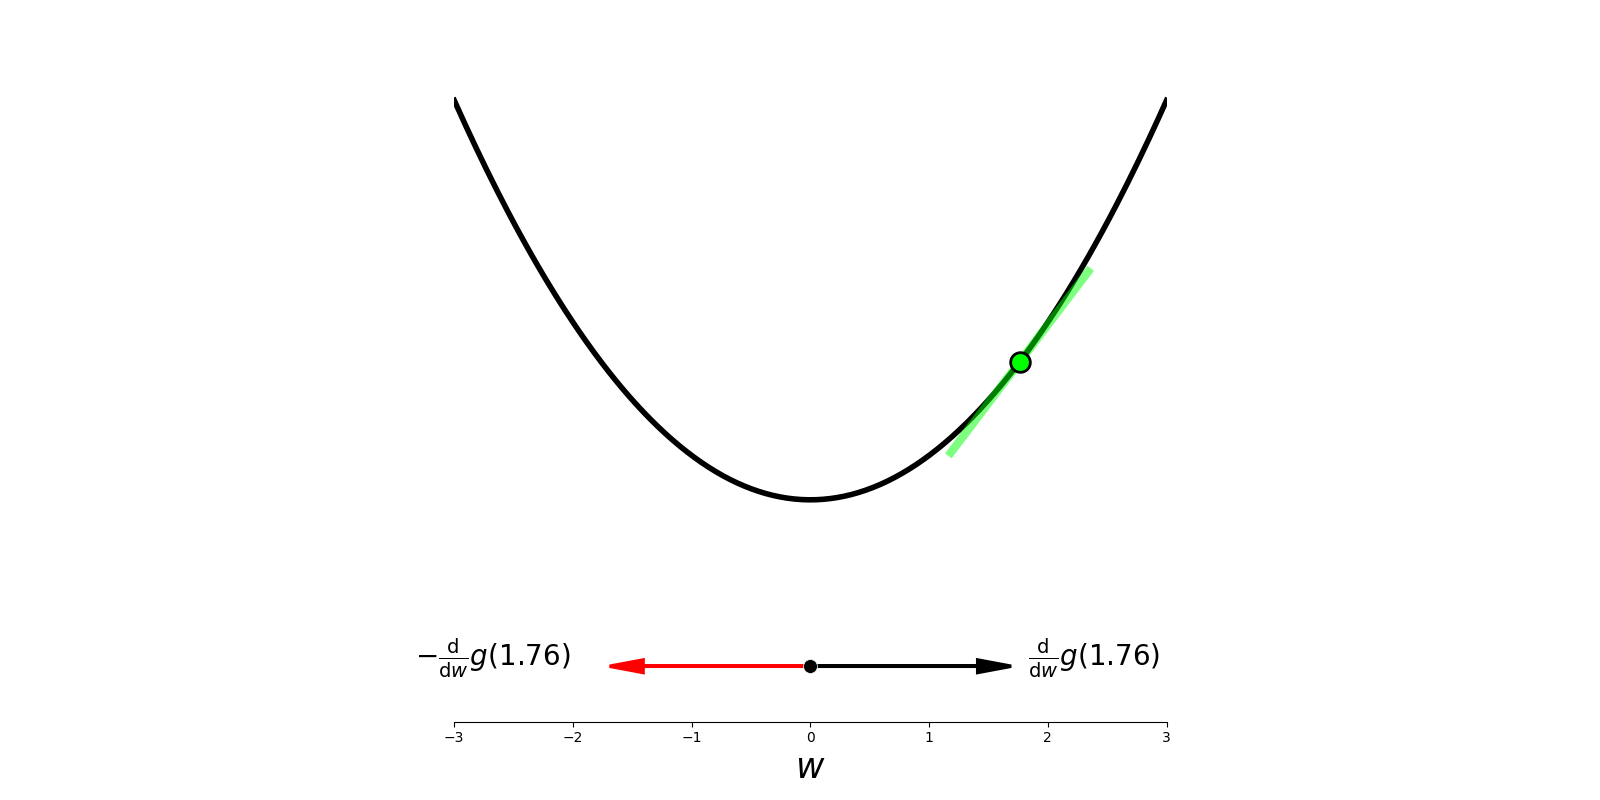
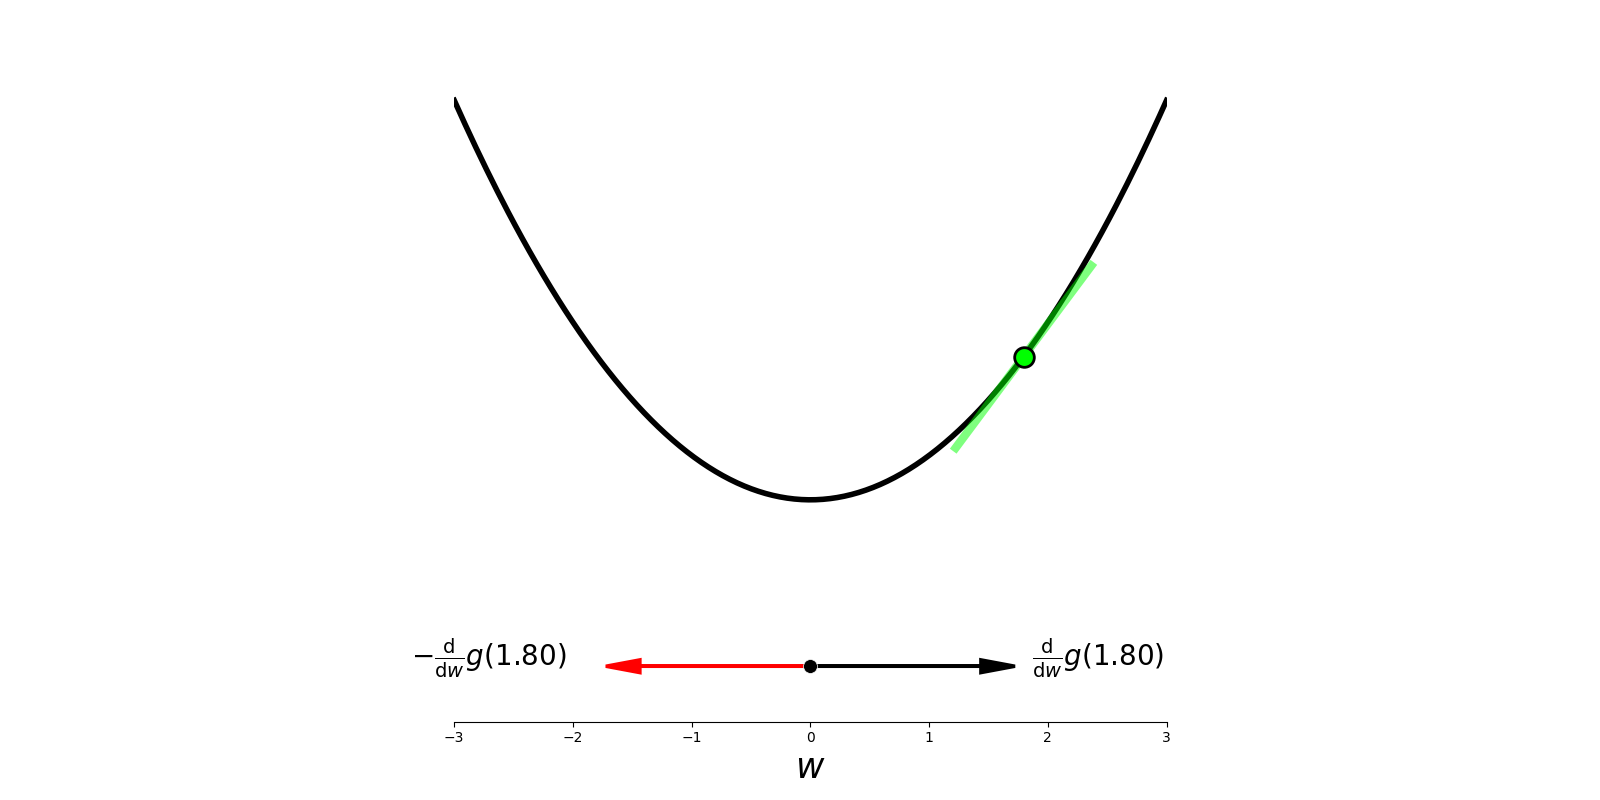
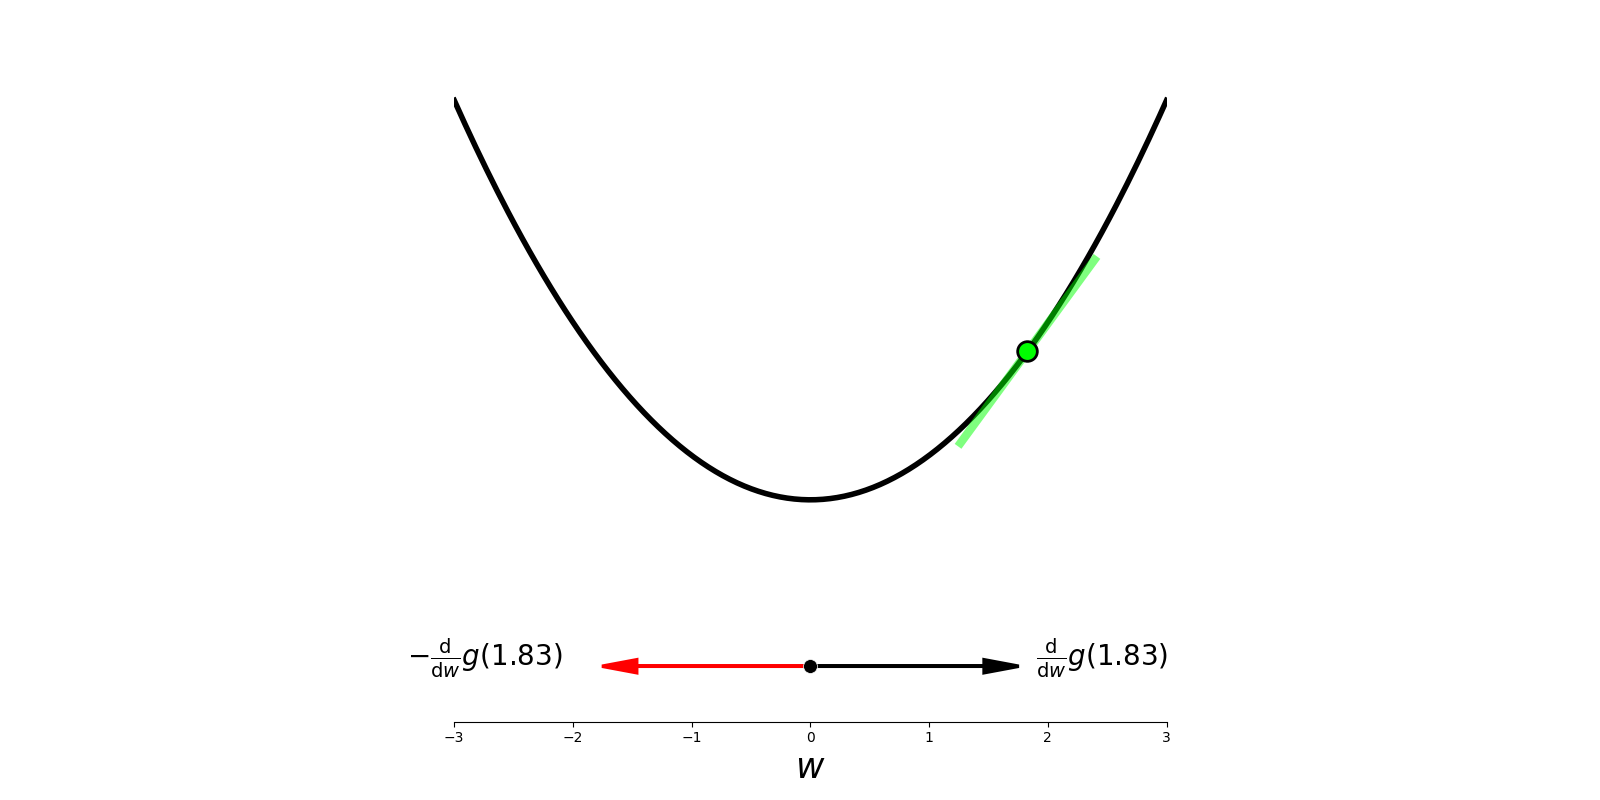
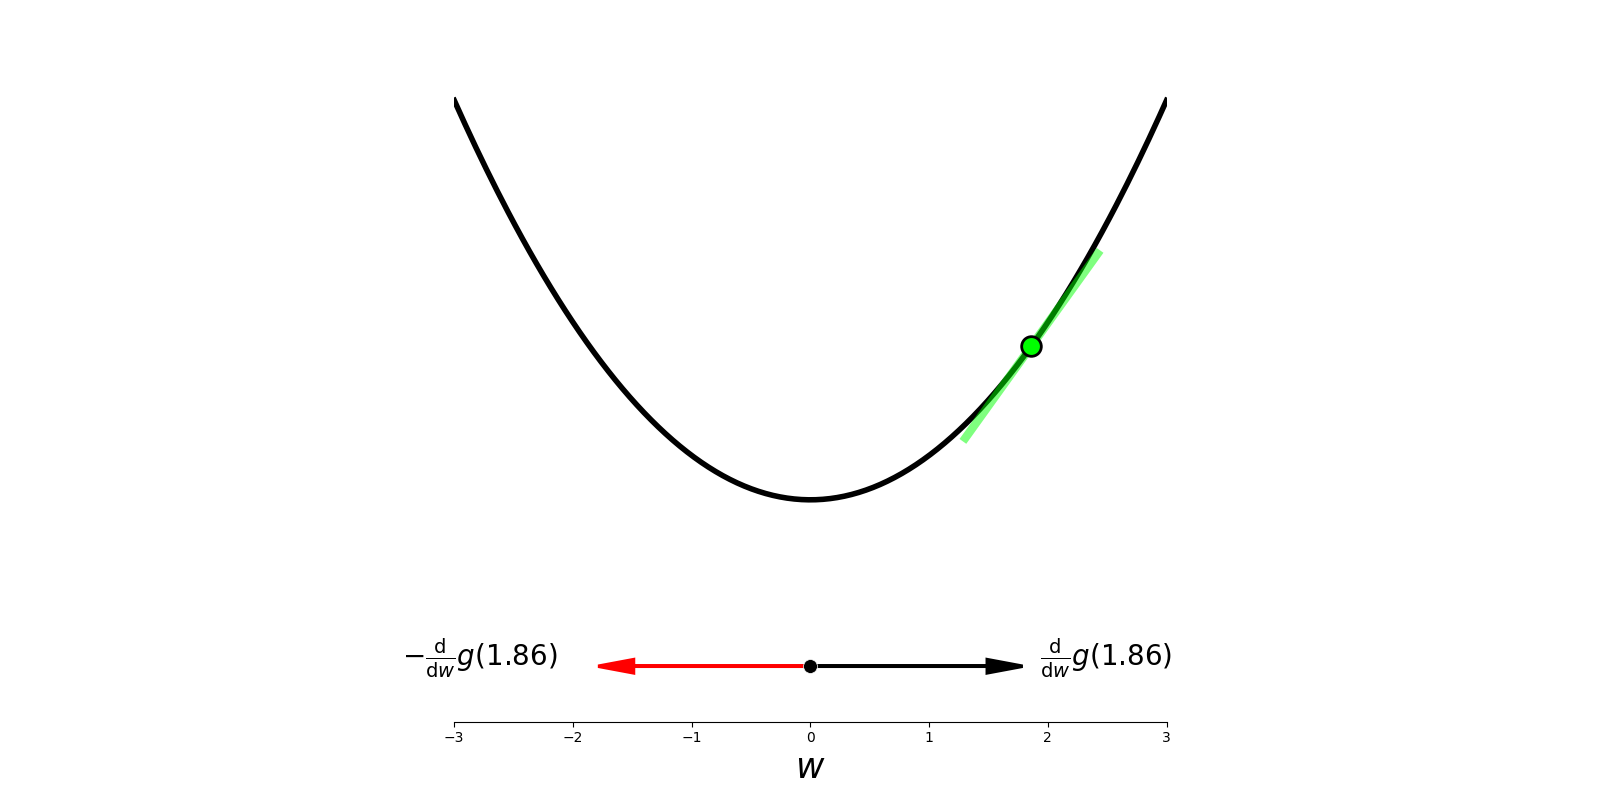
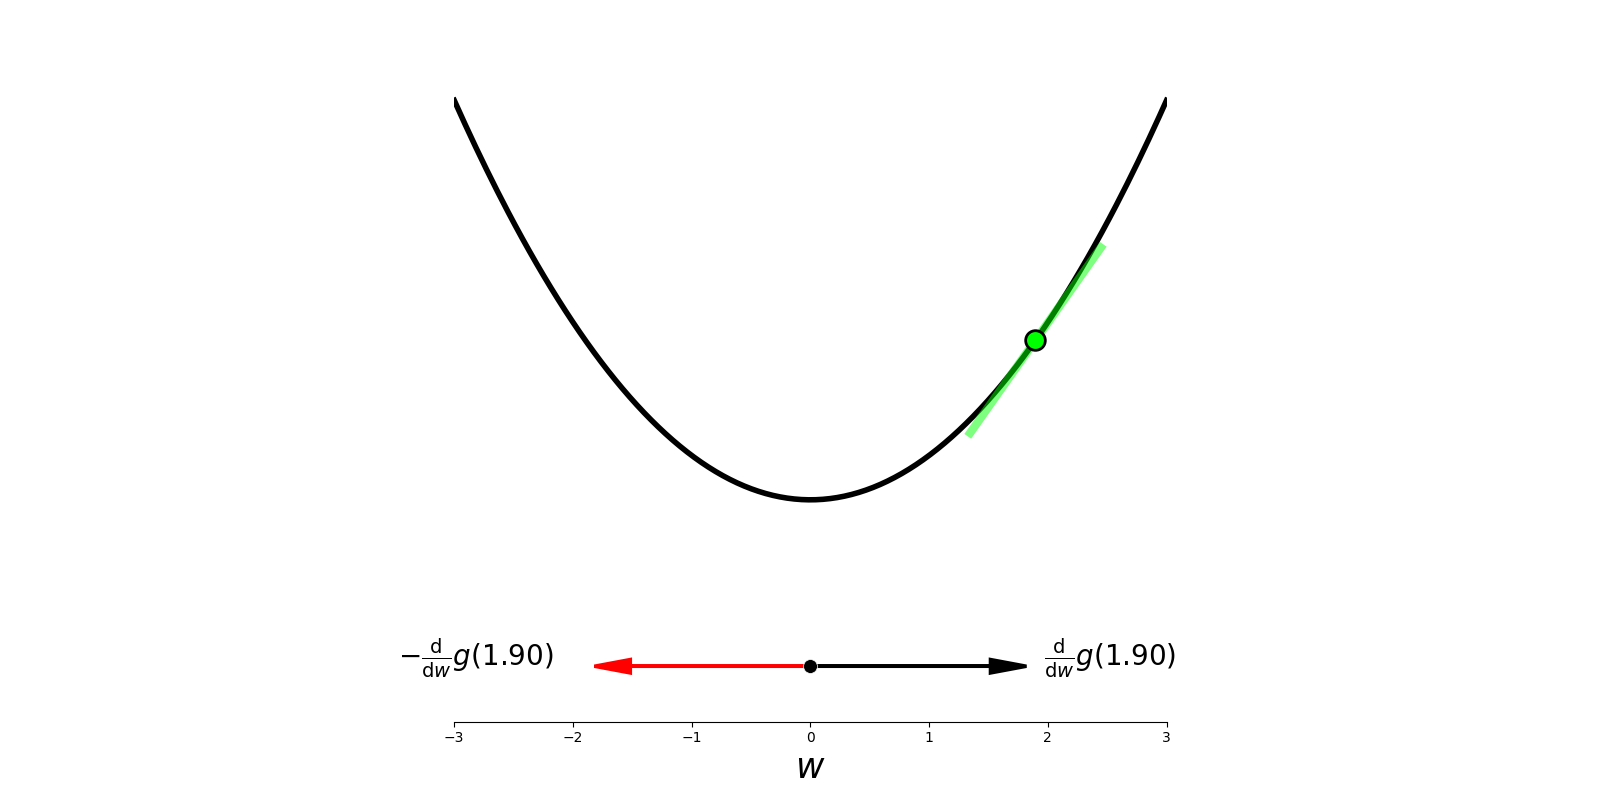
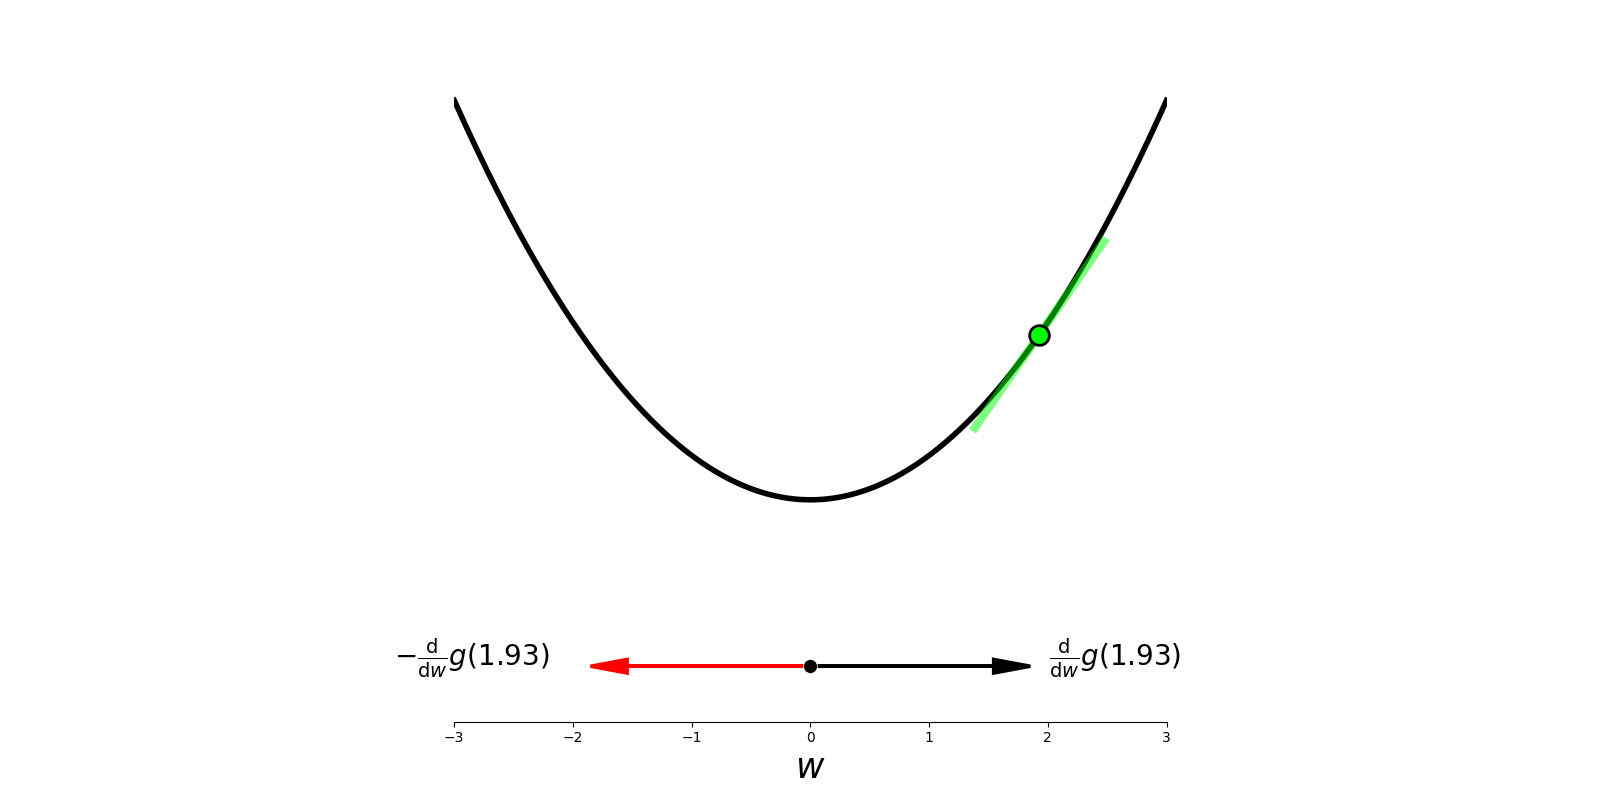
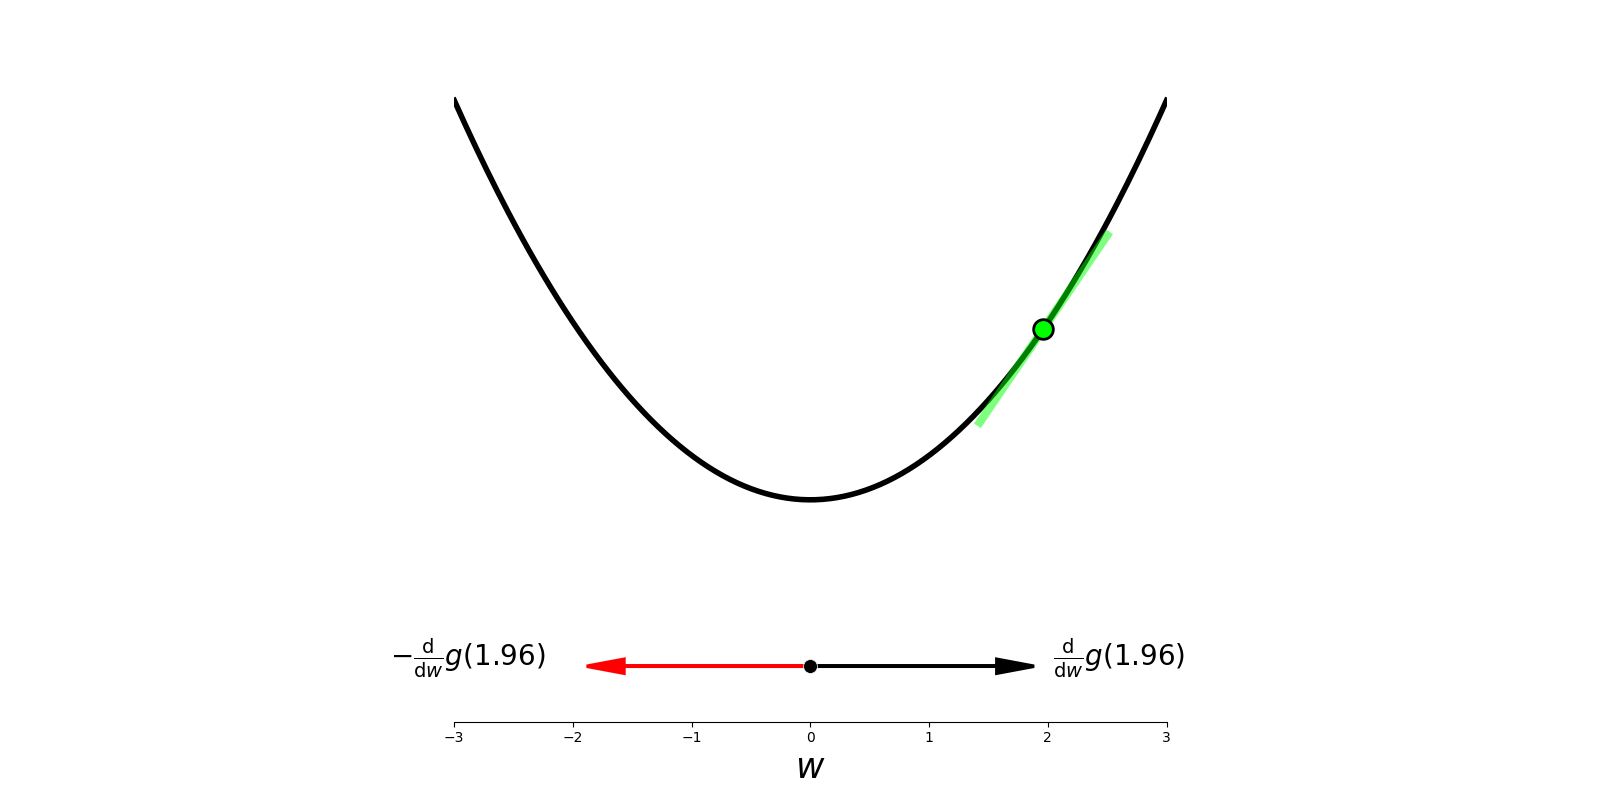
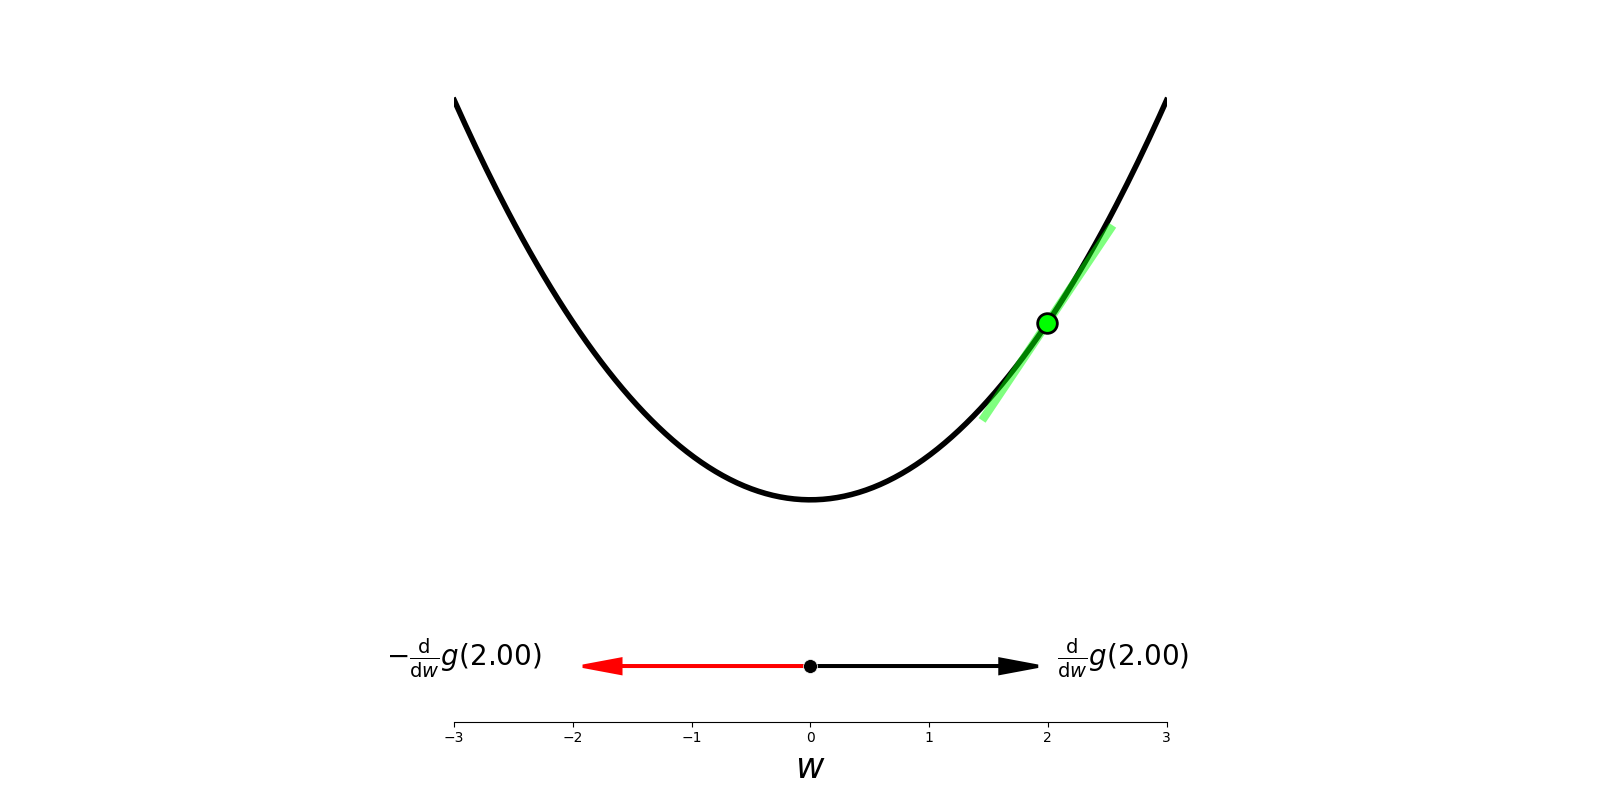
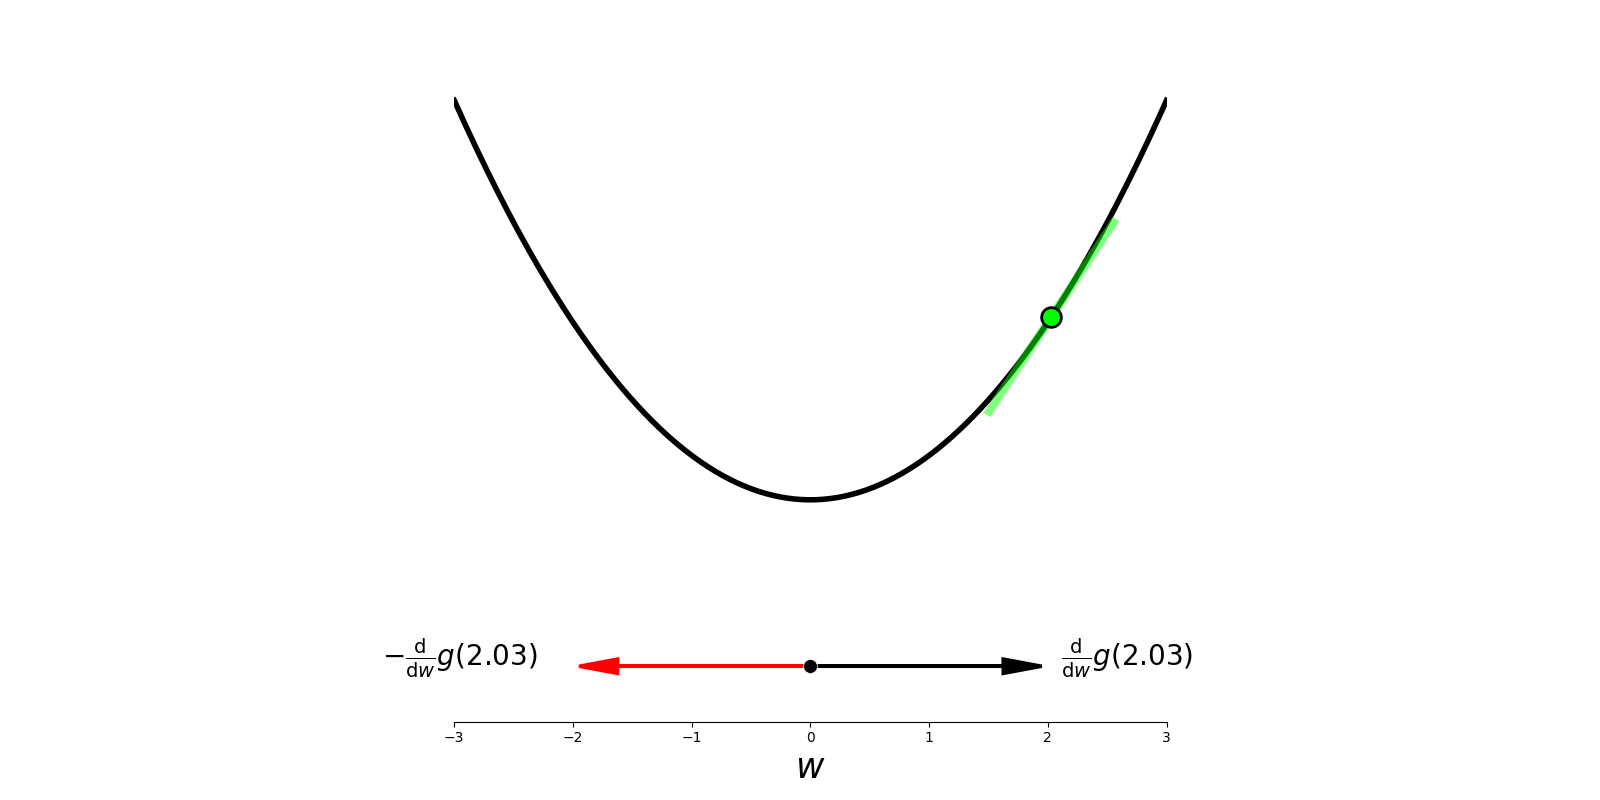
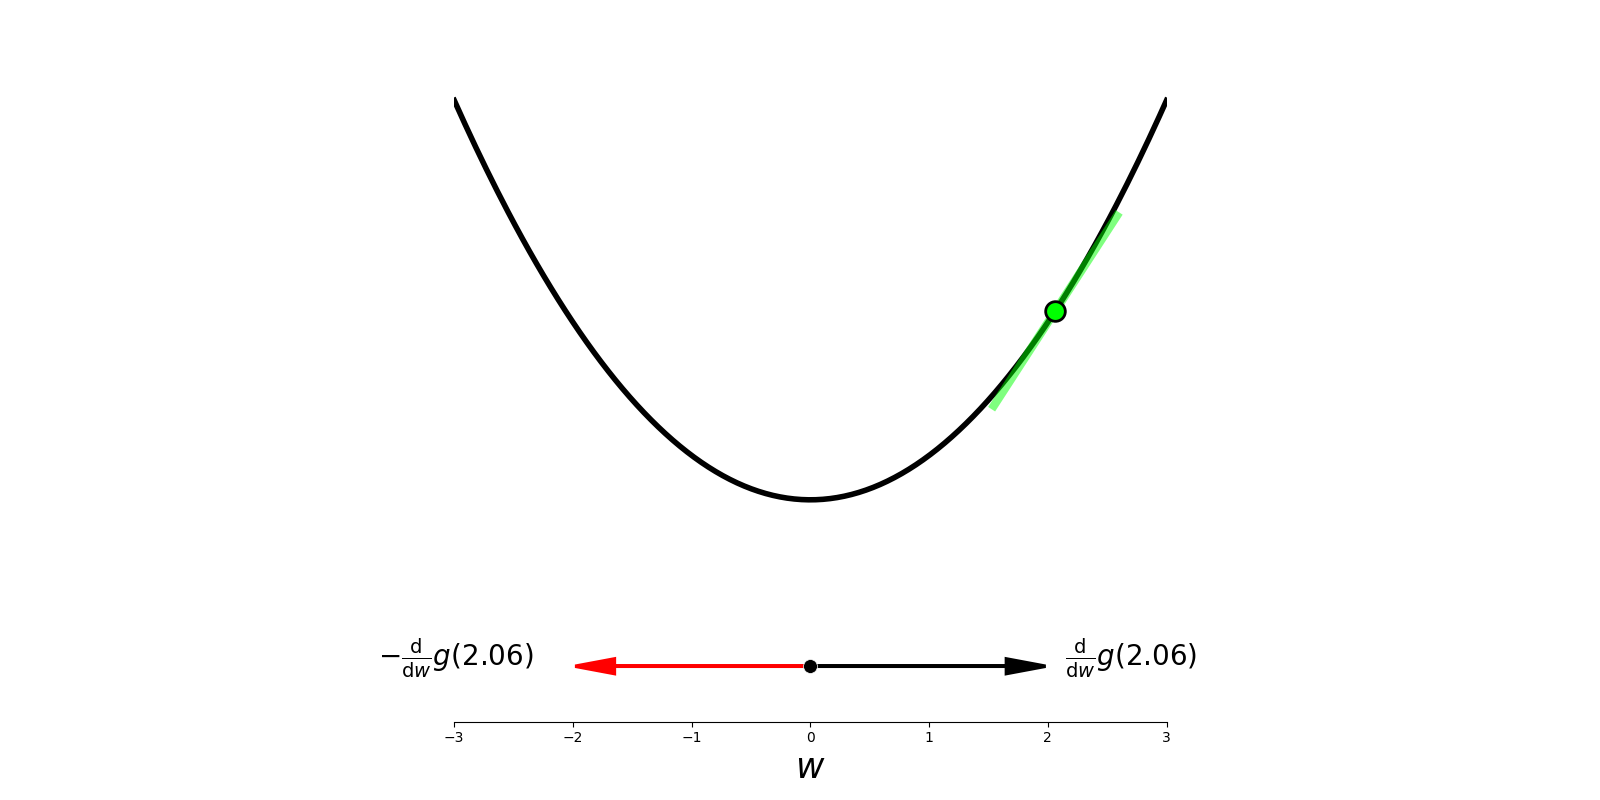
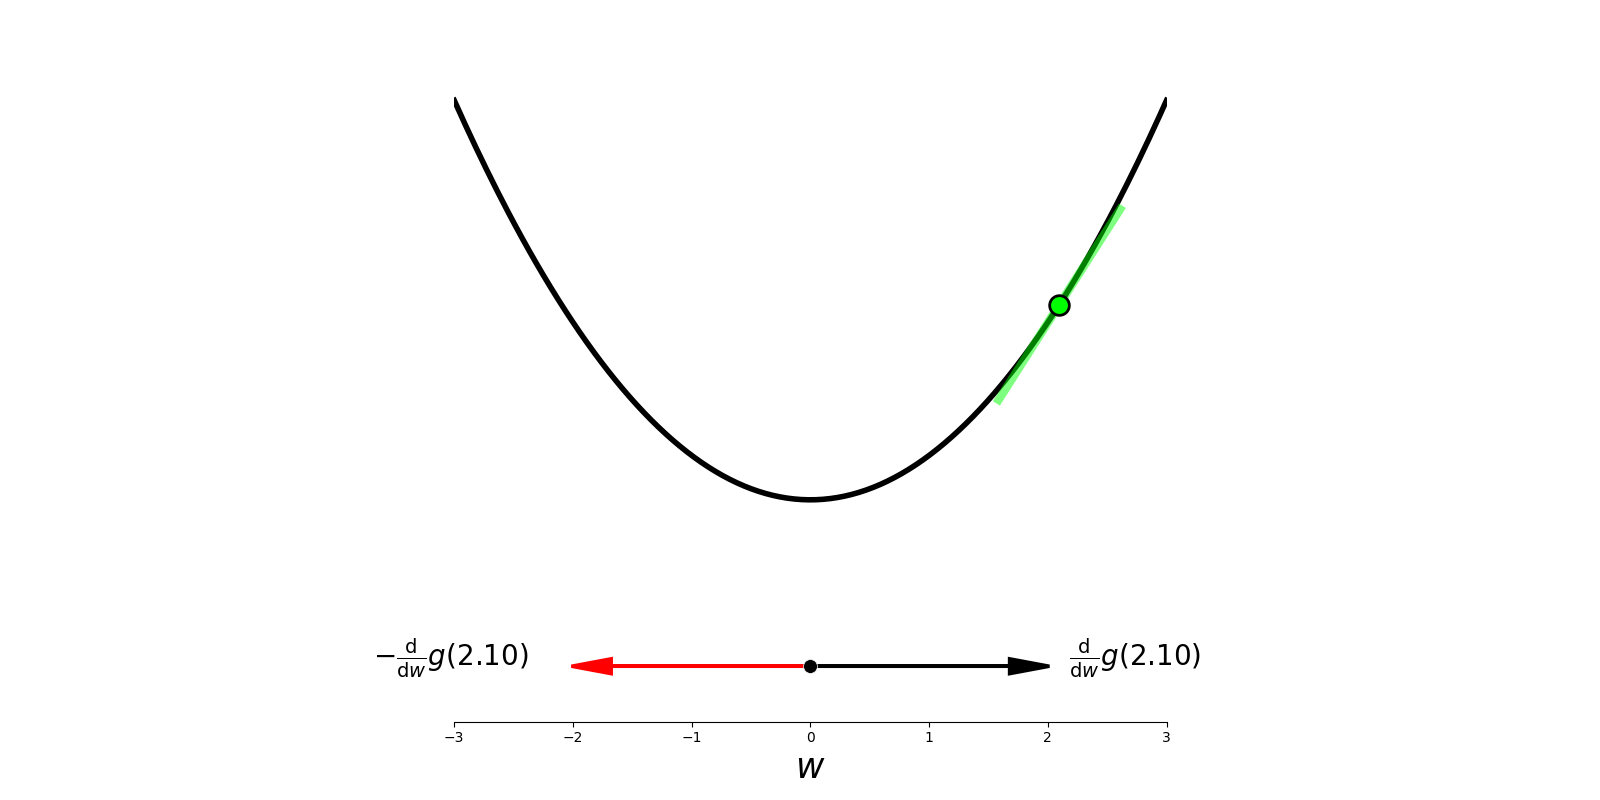
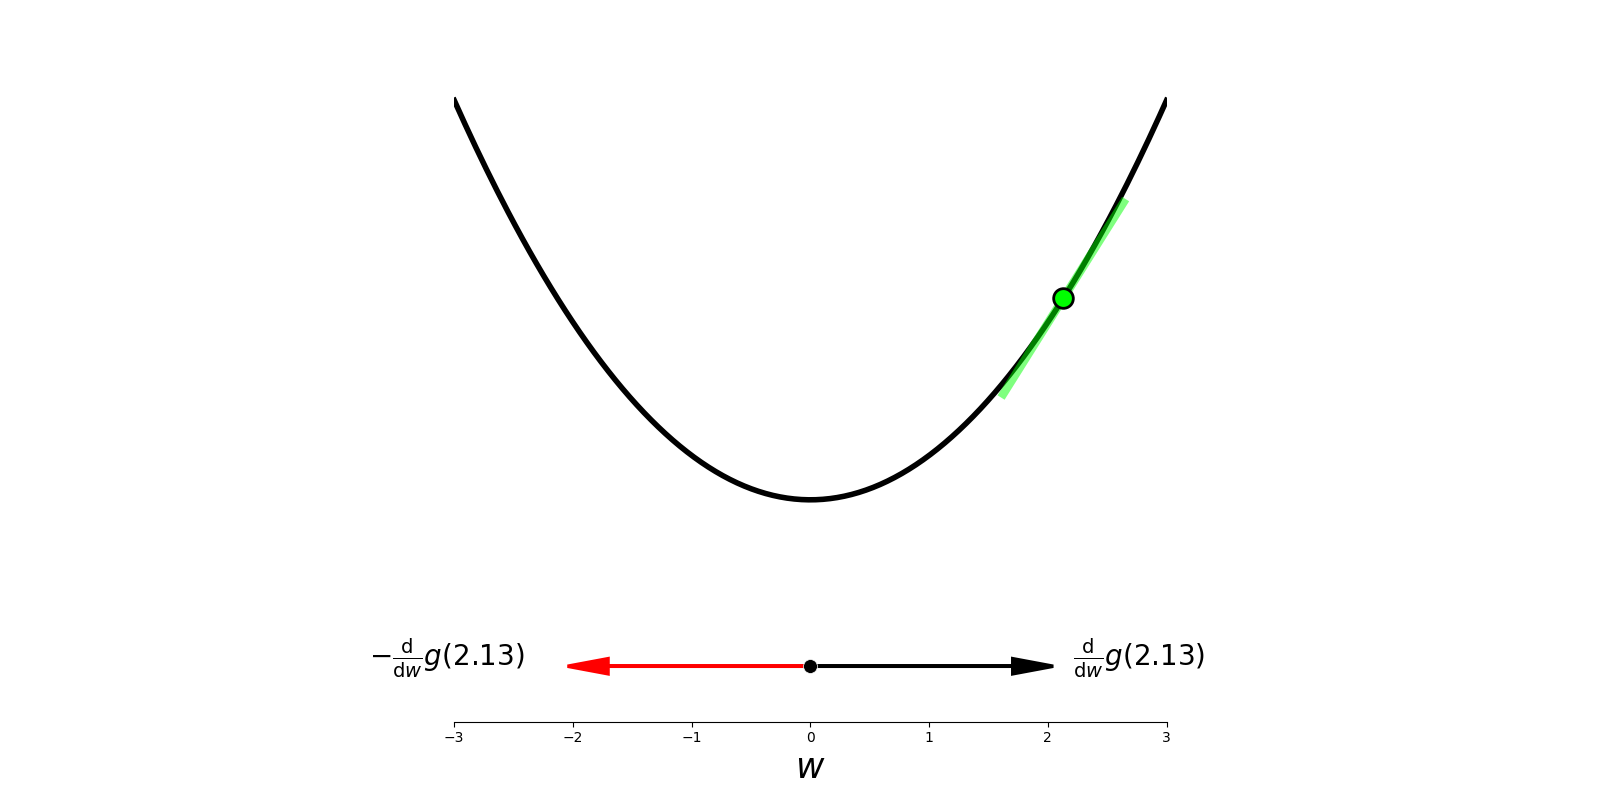
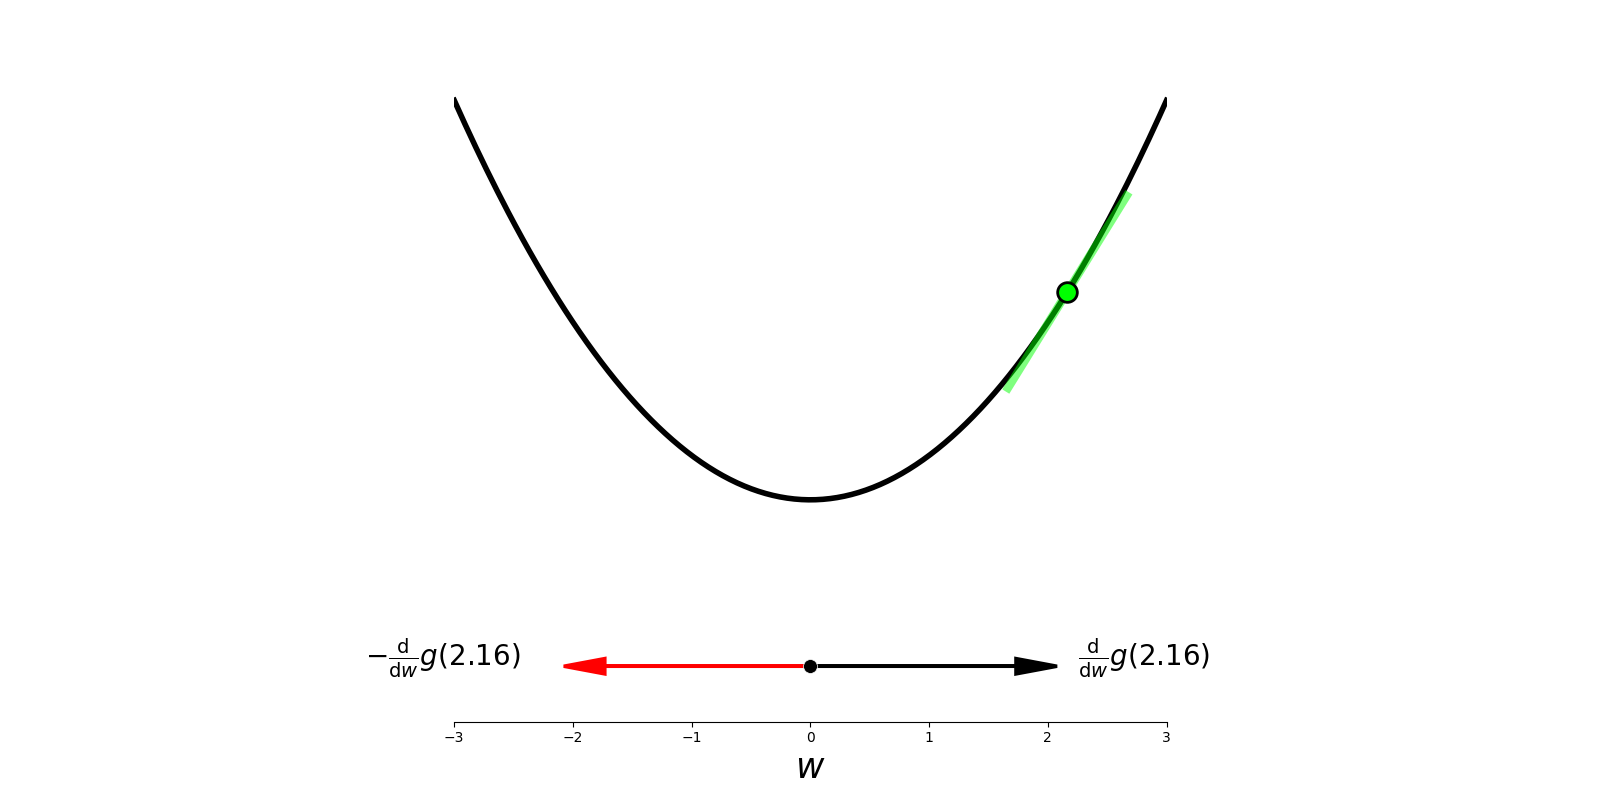
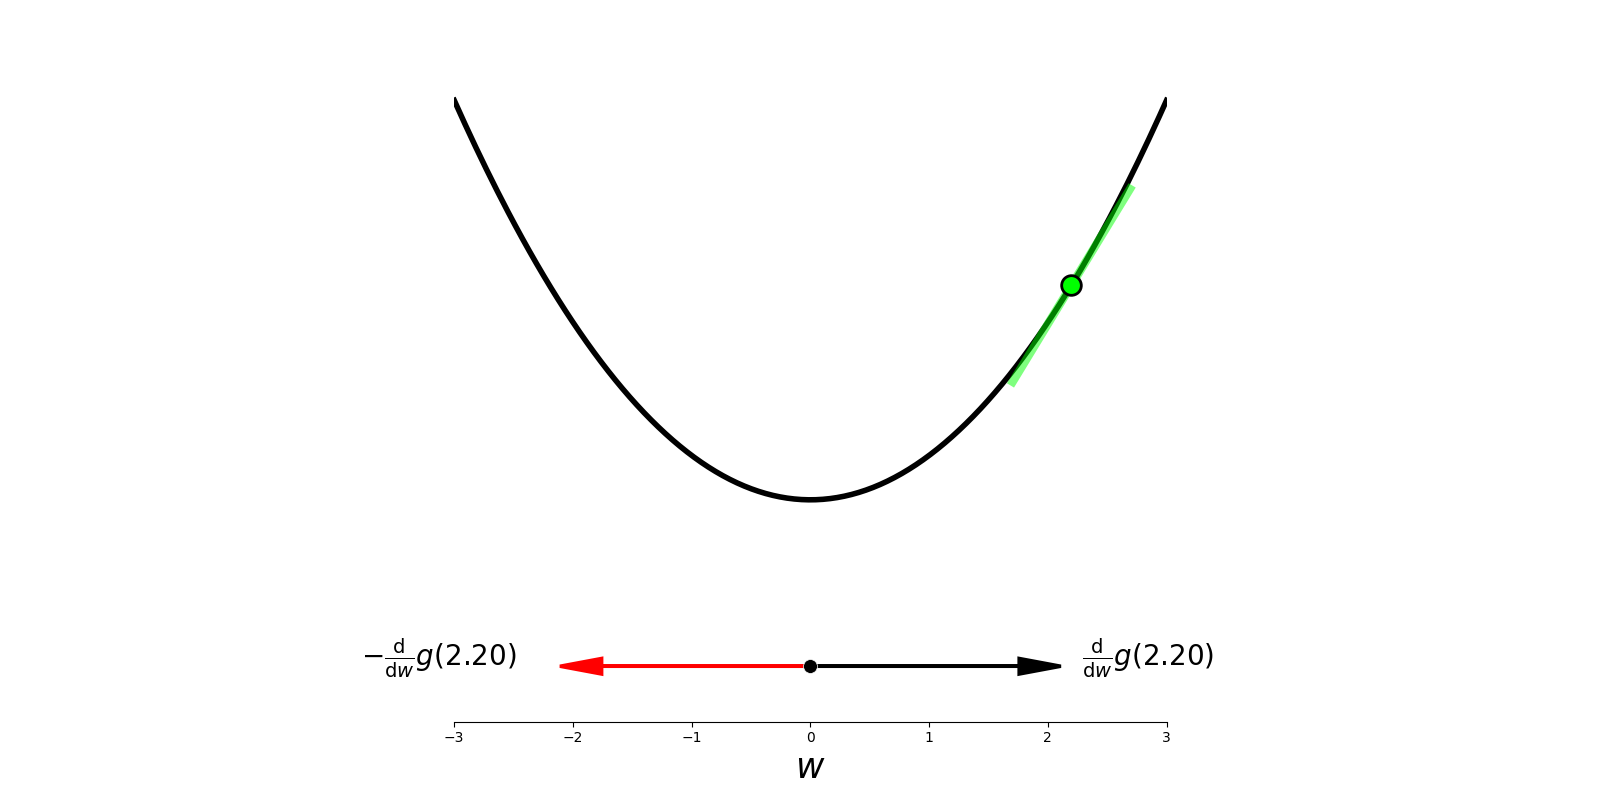
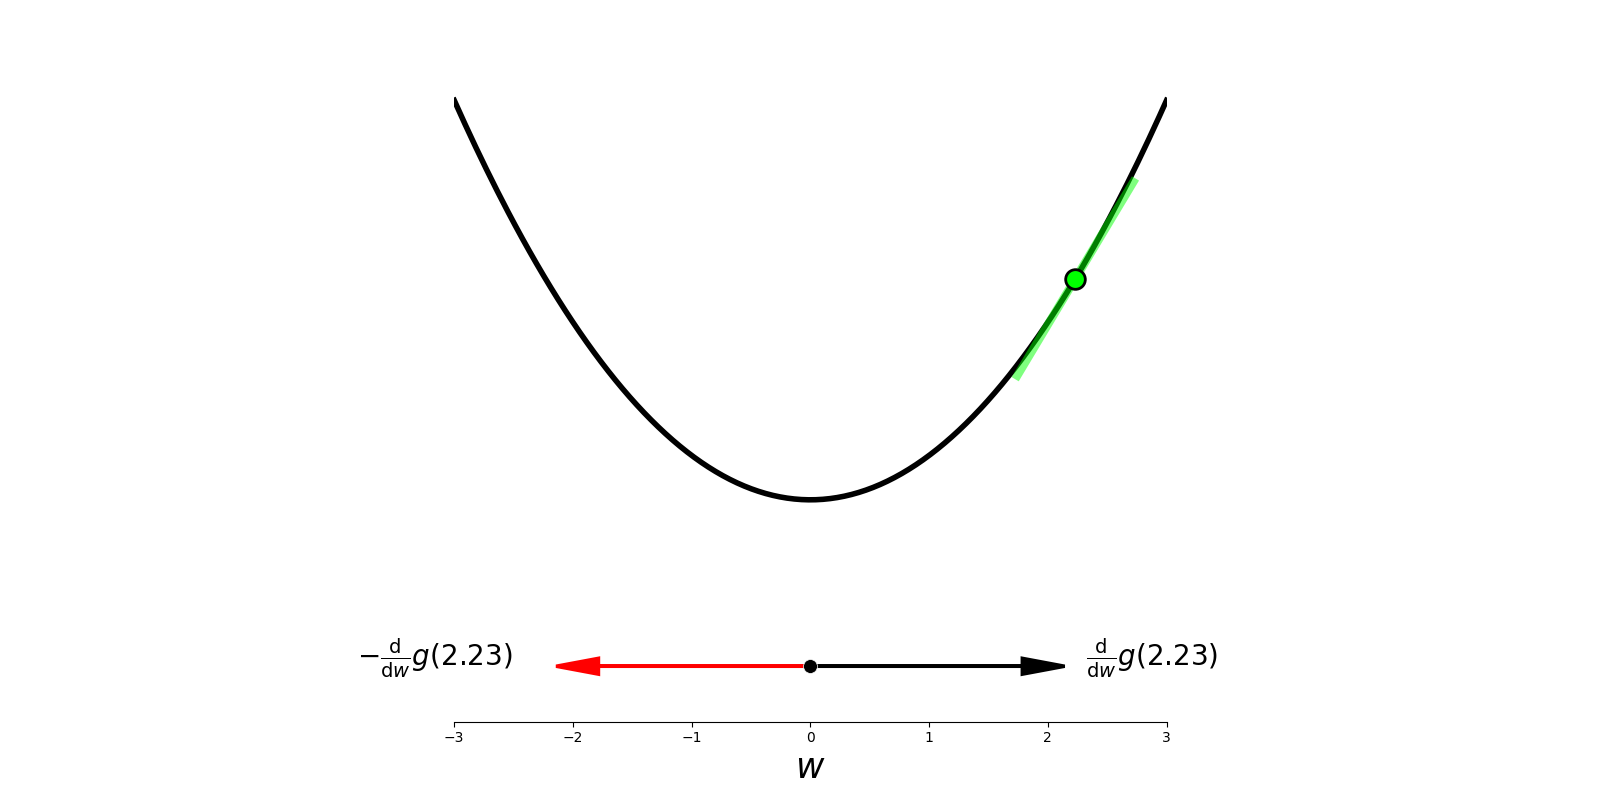
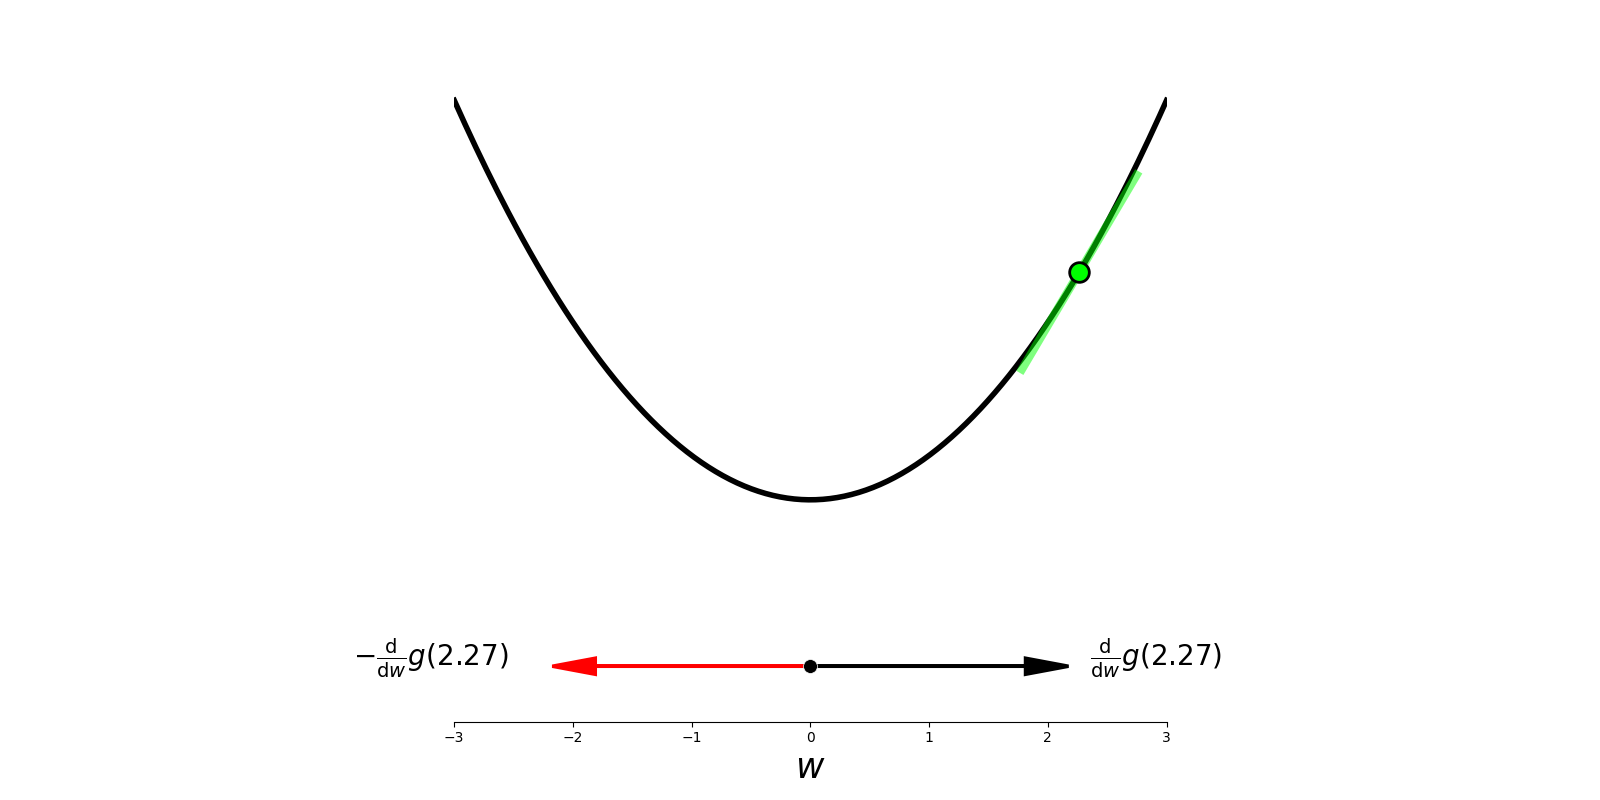
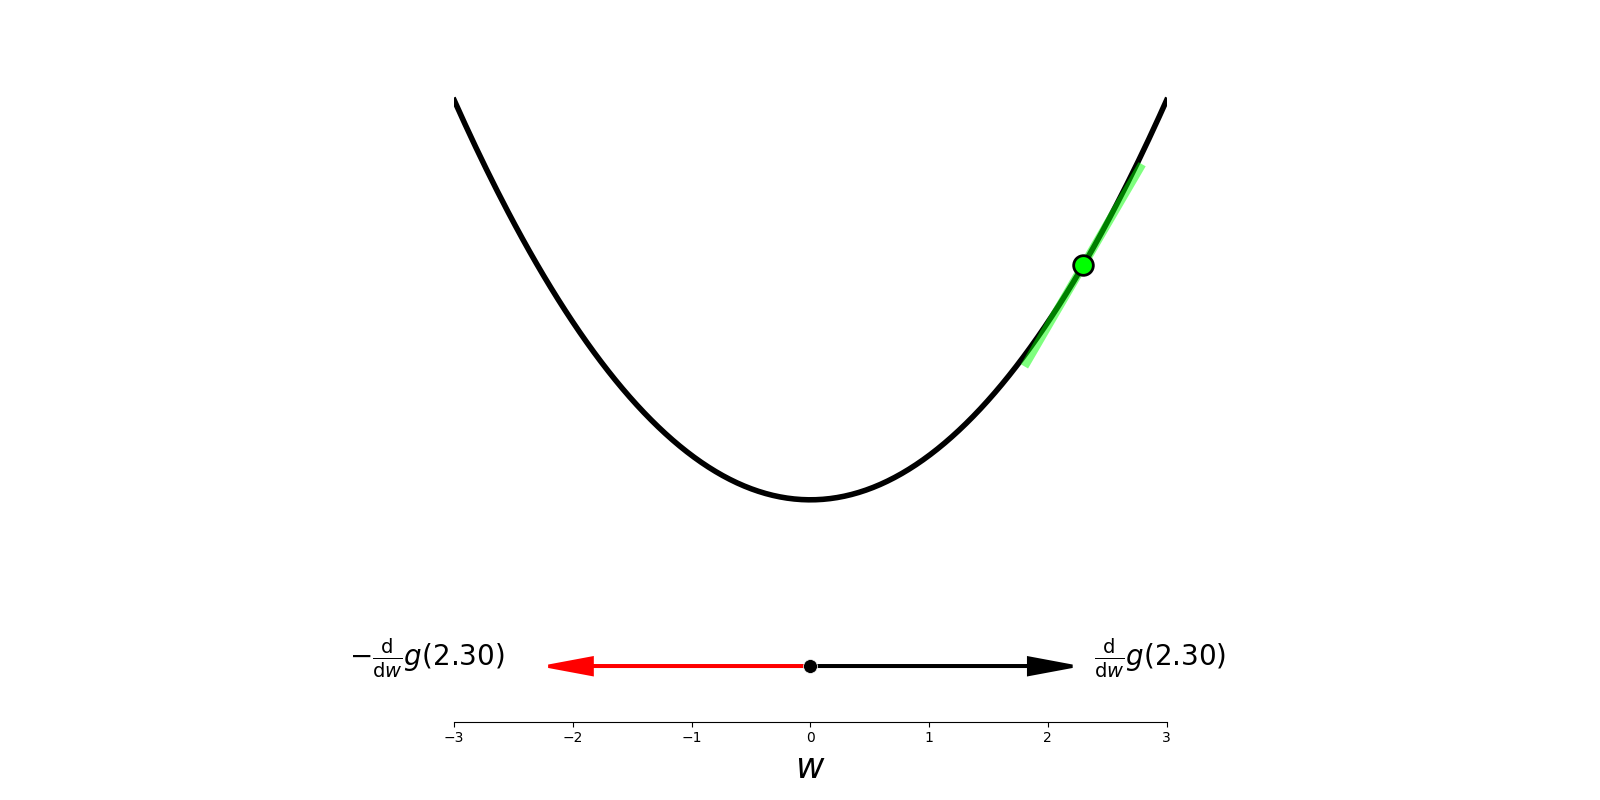
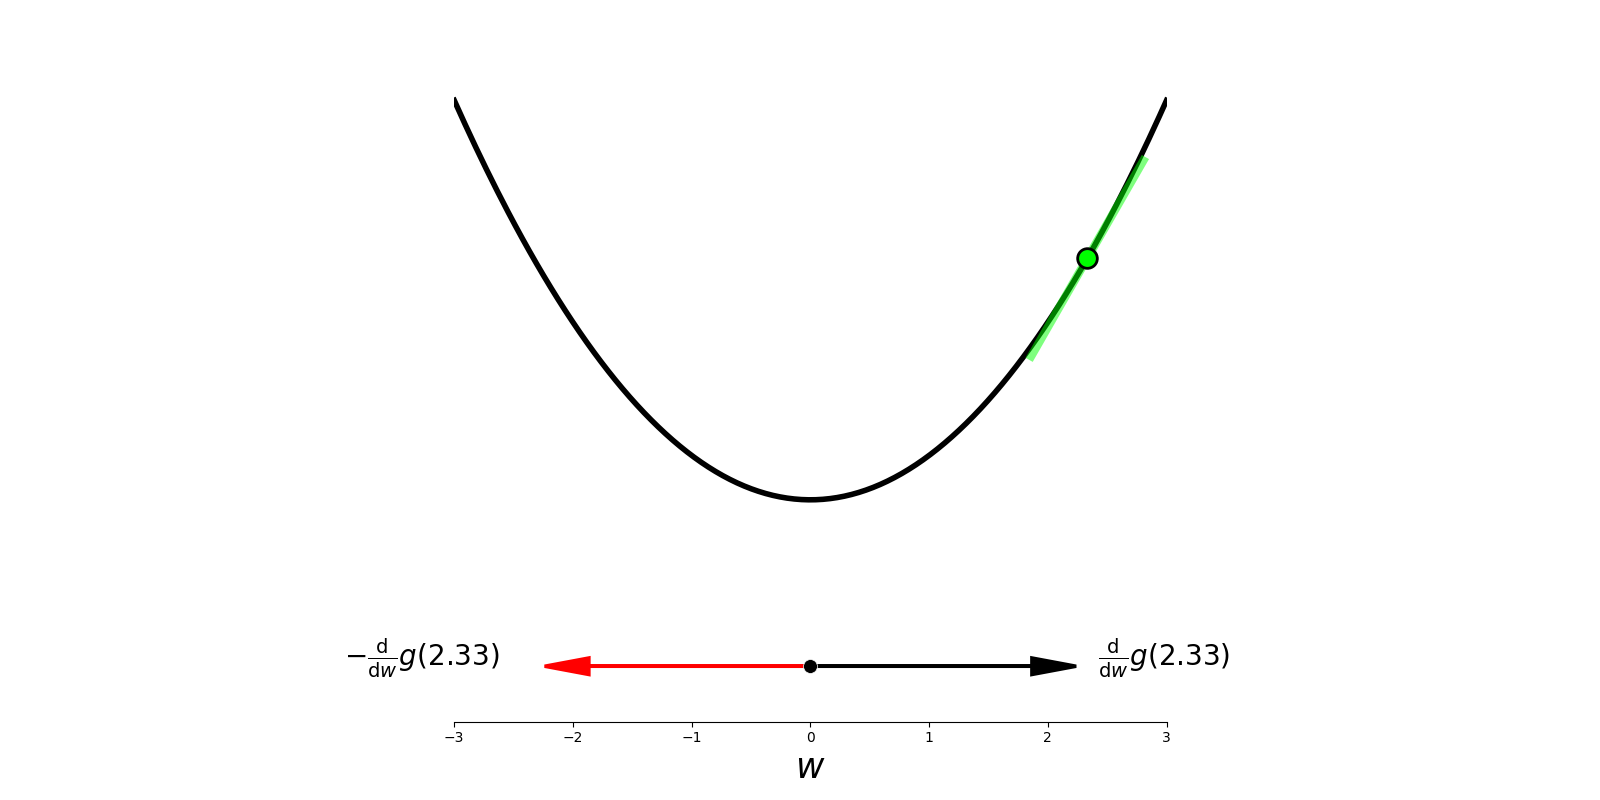
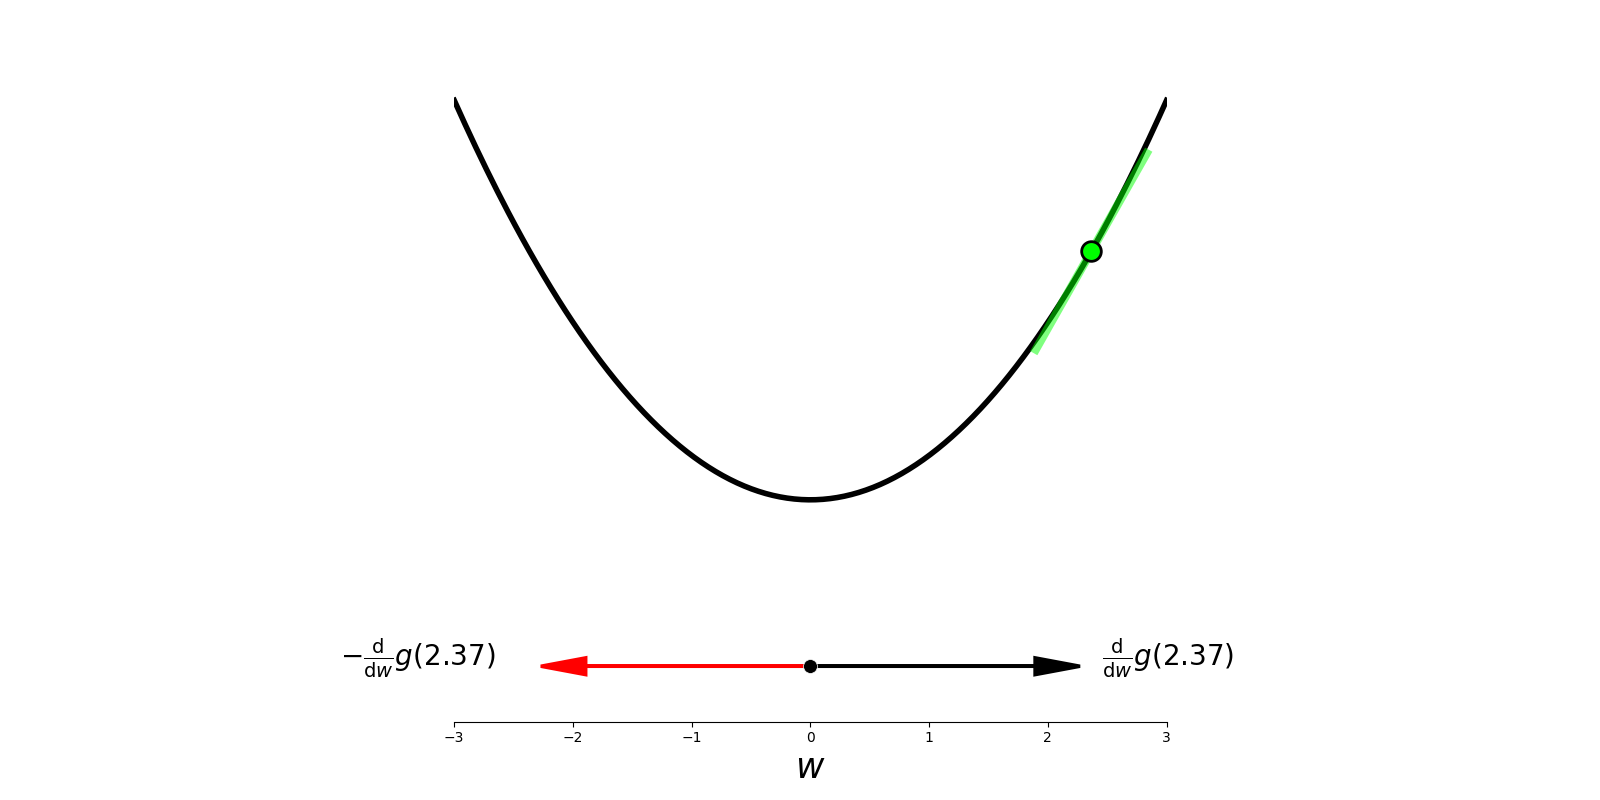
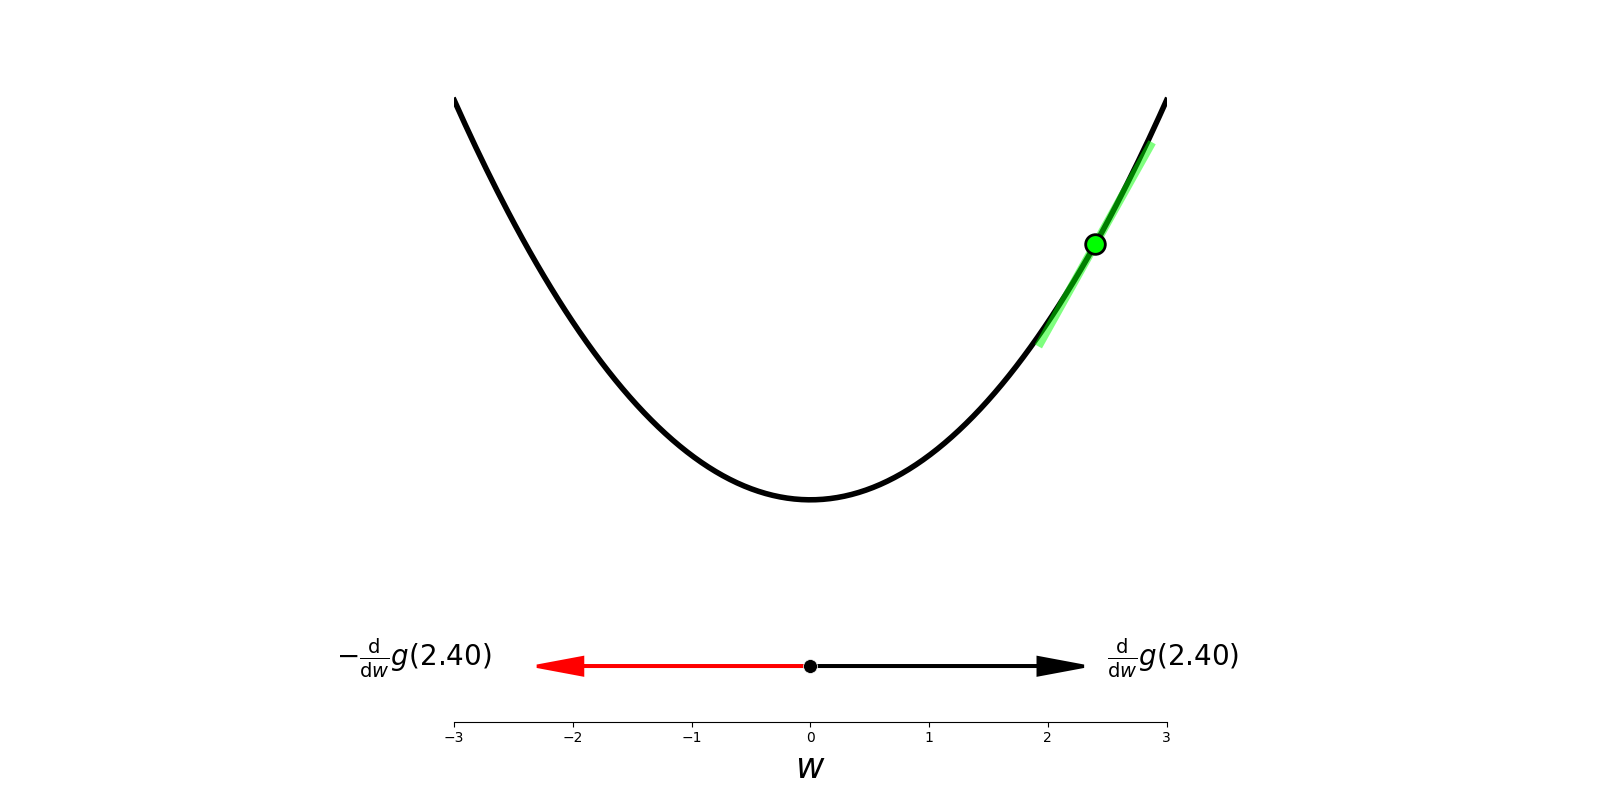
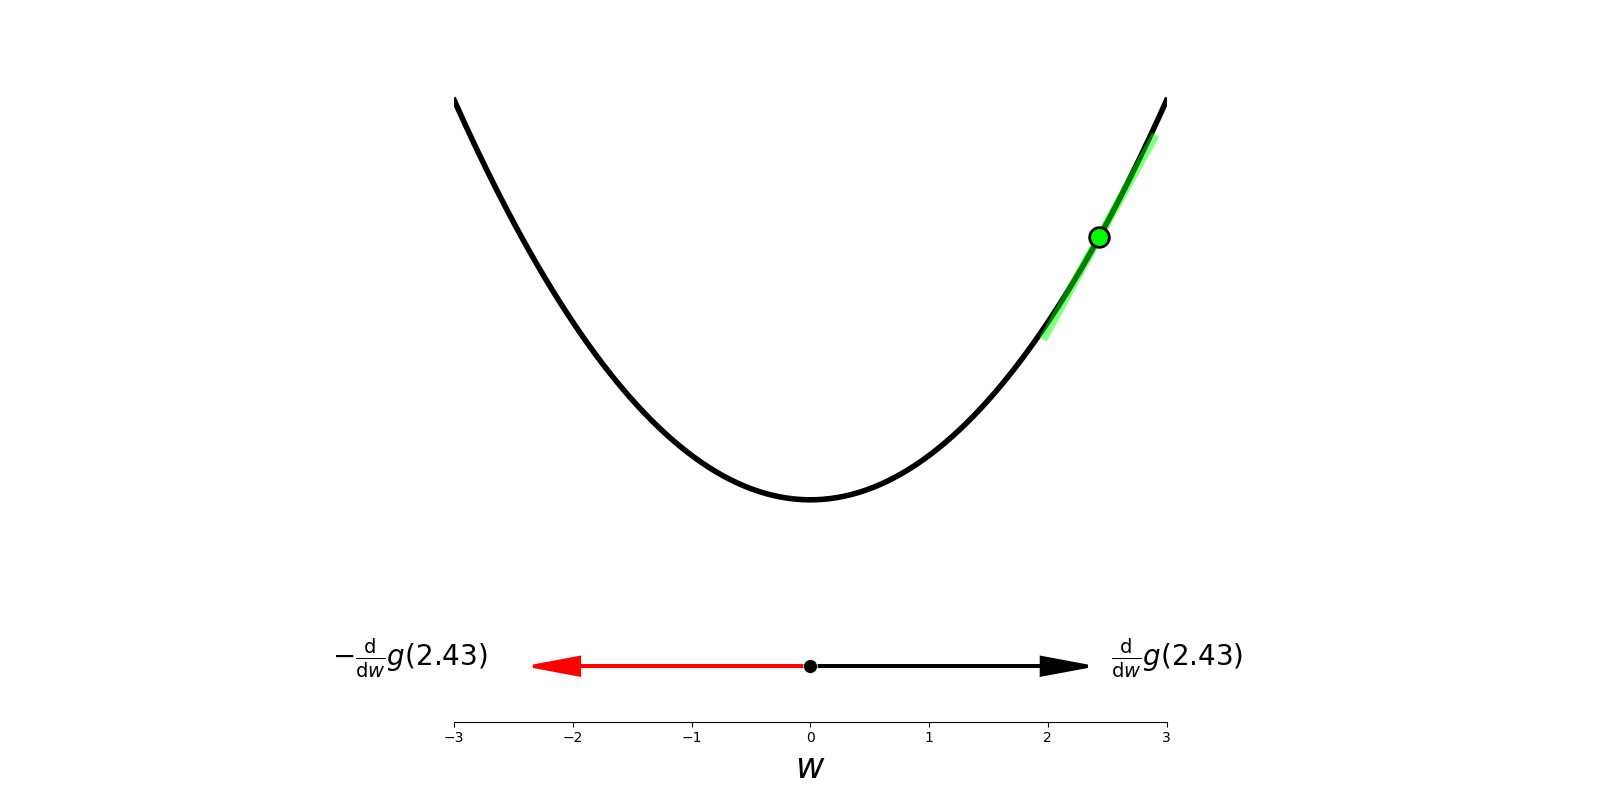
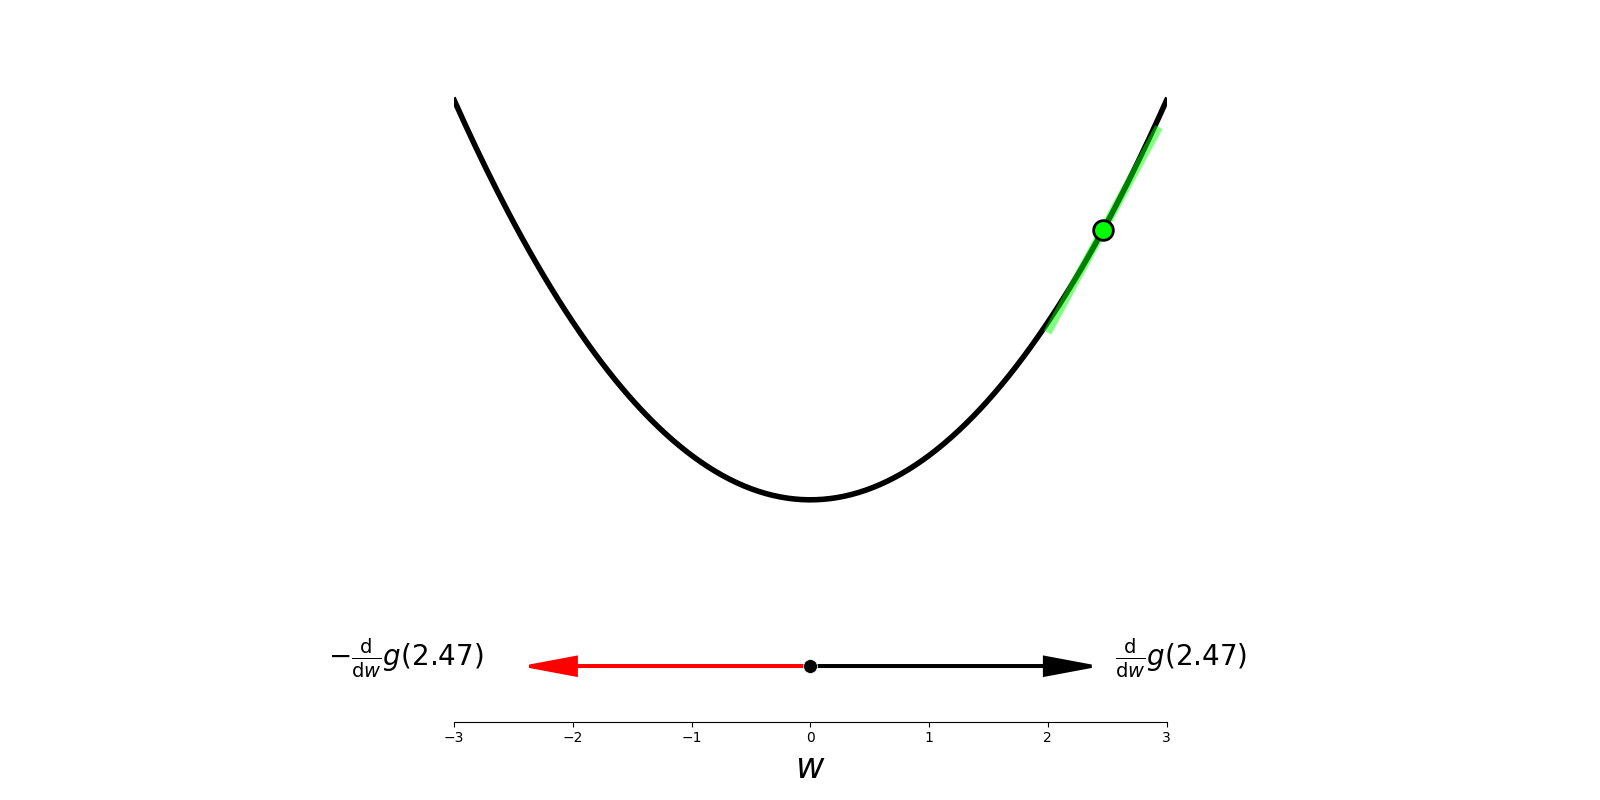
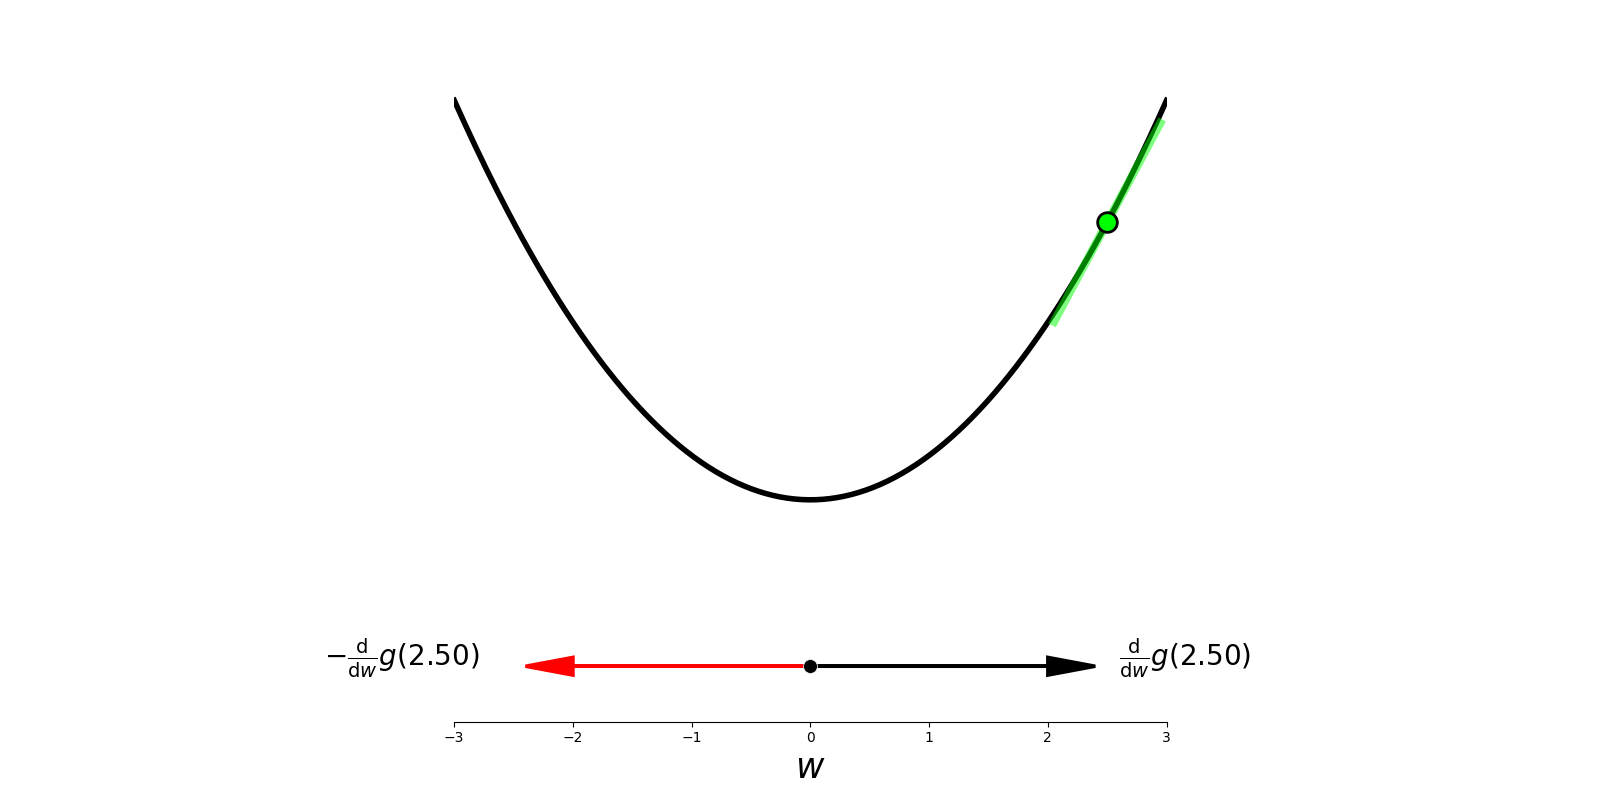

In [4]:
# what function should we play with?  Defined in the next line.
g = lambda w: 0.4*w**2 + 1.5

# run the visualizer for our chosen input function
callib.derivative_ascent_visualizer.animate_visualize2d(g=g,num_frames = 150,plot_descent = True)

Back in our Calculus series we also illustrated the notion of a descent direction in three dimensions in this static image of a three dimensional quadratic.  Here we repeat a plot of the simple quadratic function
$g(\mathbf{w}) = \mathbf{w}^T \mathbf{w}^{\,} + 6$, where $\mathbf{w}^0 = \begin{bmatrix} -1 \\ 1 \end{bmatrix}$,  with the point of tangency and tangent hyperplane in green, along with (in the input plane) the gradient here $\nabla g\left(\mathbf{w}^0 \right) = \left((\frac{\partial}{\partial w_1}g\left(\mathbf{w}^0 \right),\frac{\partial}{\partial w_2}g\left(\mathbf{w}^0 \right)\right)$ in black (along with each of its partial derivatives in blue), and the negative gradient  $-\nabla g\left(\mathbf{w}^0 \right)$ in red.

Once again we could imagine how using the descent direction provided by the negative gradient repeatedly in a local search framework could lead the algorithm to a point near the global minimum at the origin $(0,0)$, provided the steplength is decided on correctly.

<IPython.core.display.Javascript object>


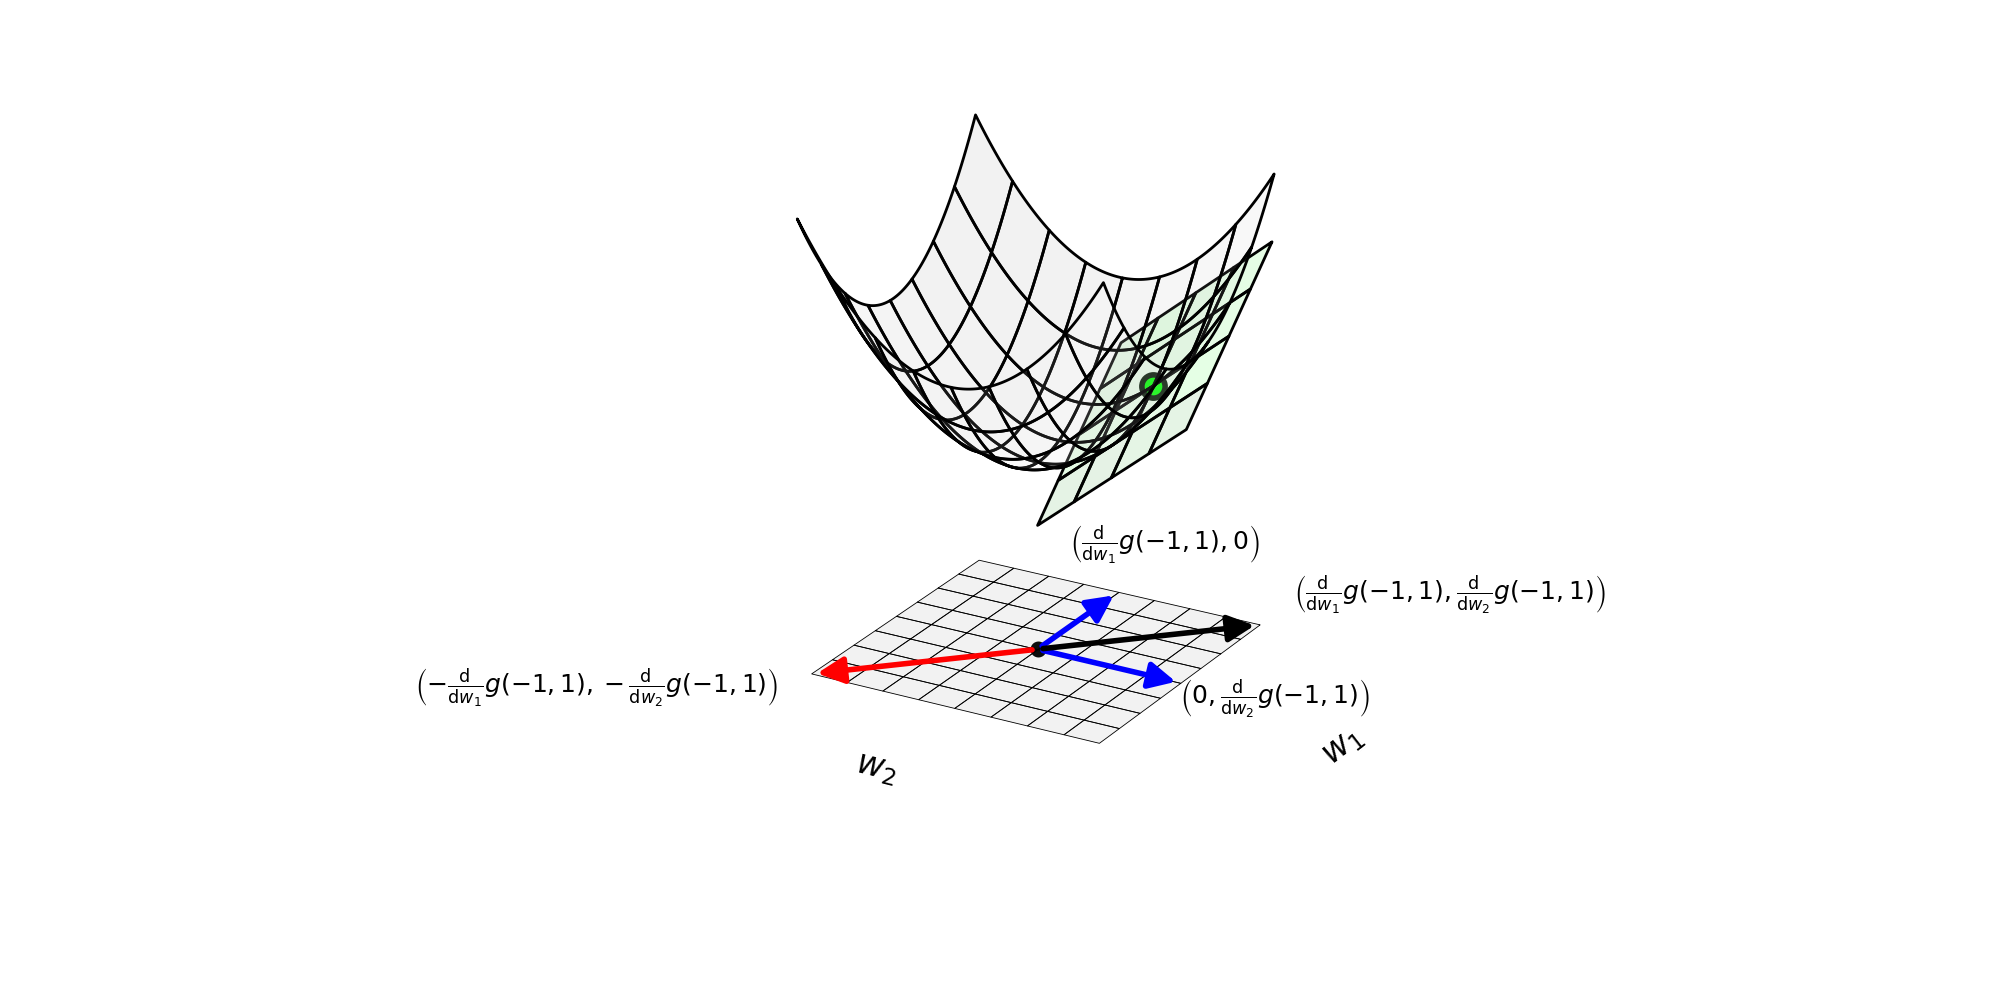

In [2]:
# define function, and points at which to take derivative
func = lambda w:  (w[0])**2 + (w[1])**2 + 6
pt1 = [-1,1];

# animate 2d slope visualizer
view = [33,30]
callib.derivative_ascent_visualizer.visualize3d(func=func,view = view,pt1 = pt1,plot_descent = True)

<img src="../../mlrefined_images/math_optimization_images/Fig_2_7.png" width=700 height=250/>

<IPython.core.display.Javascript object>


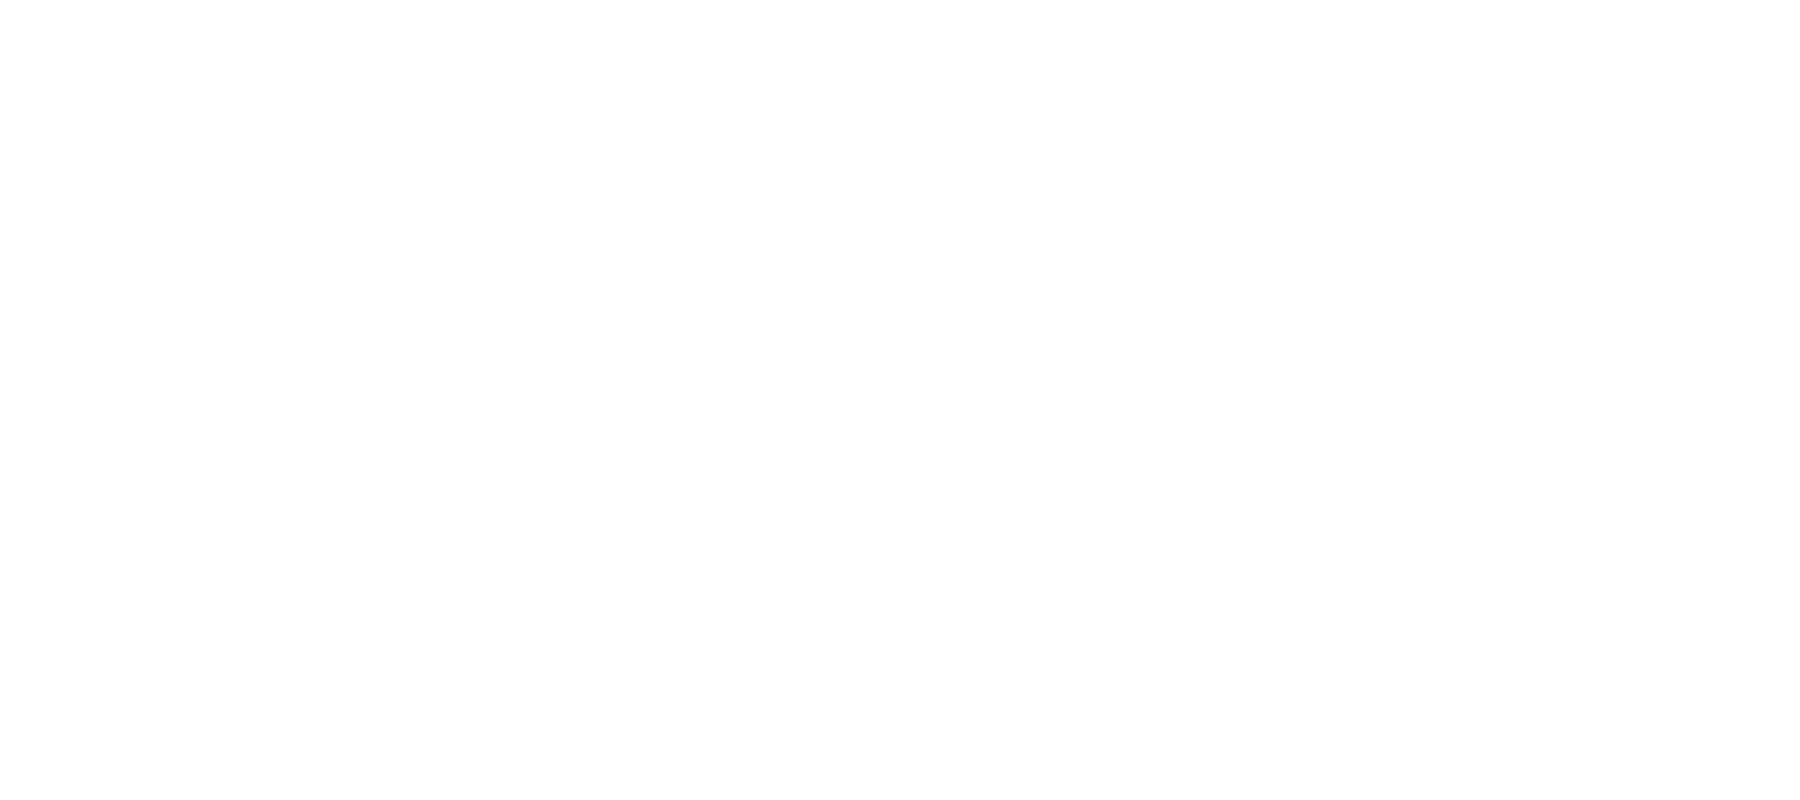


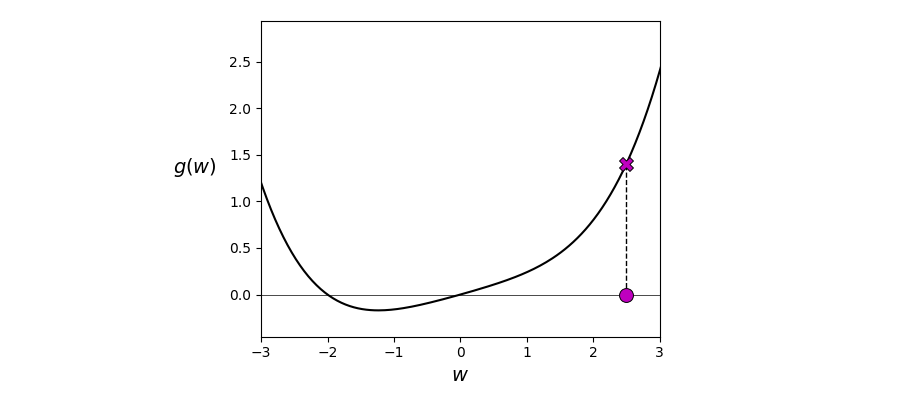
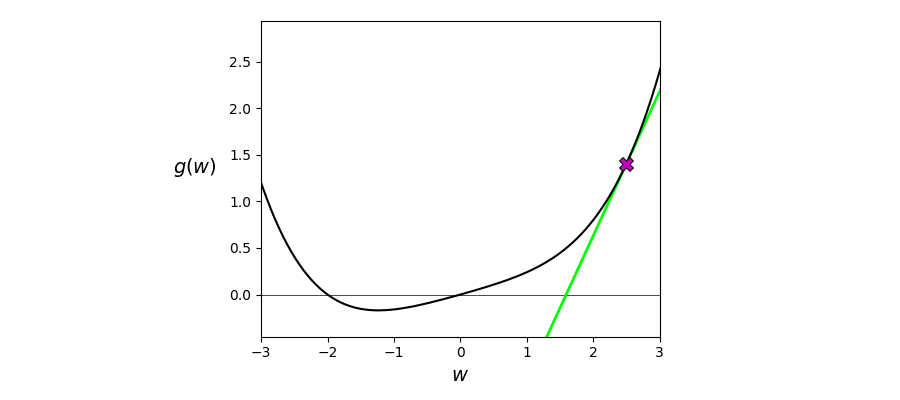
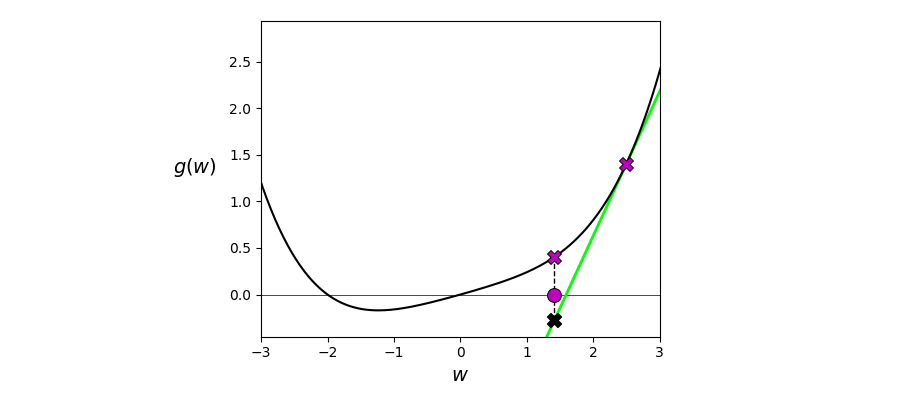
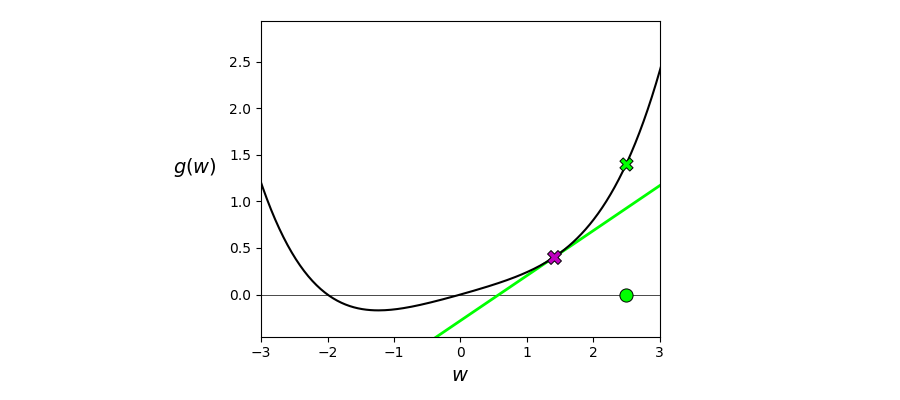
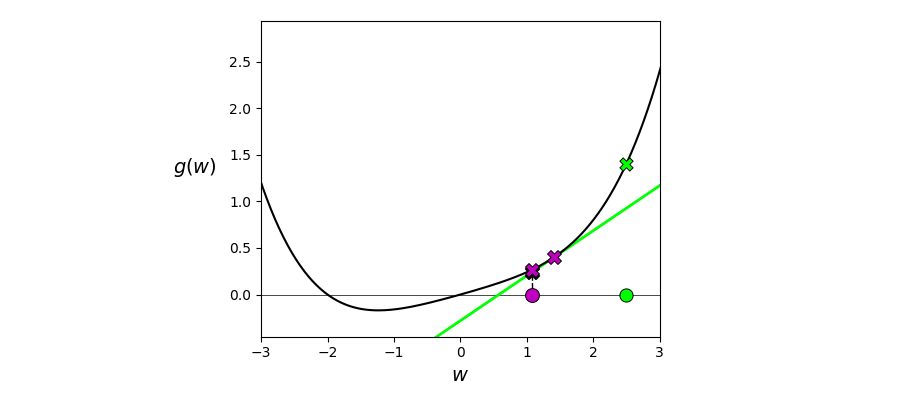
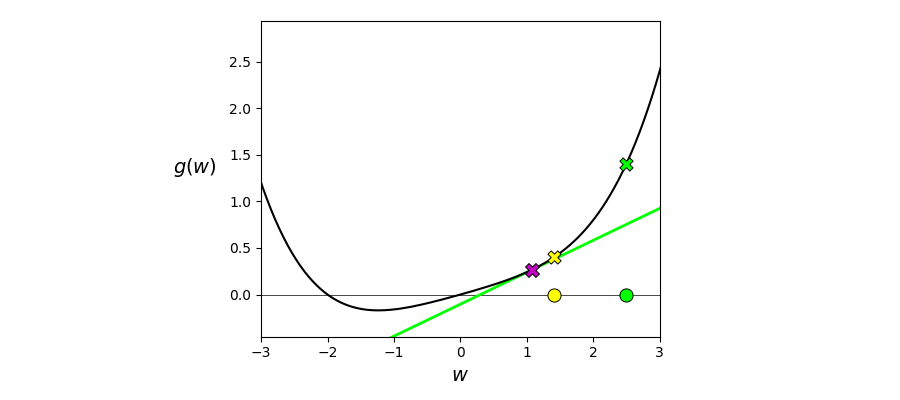
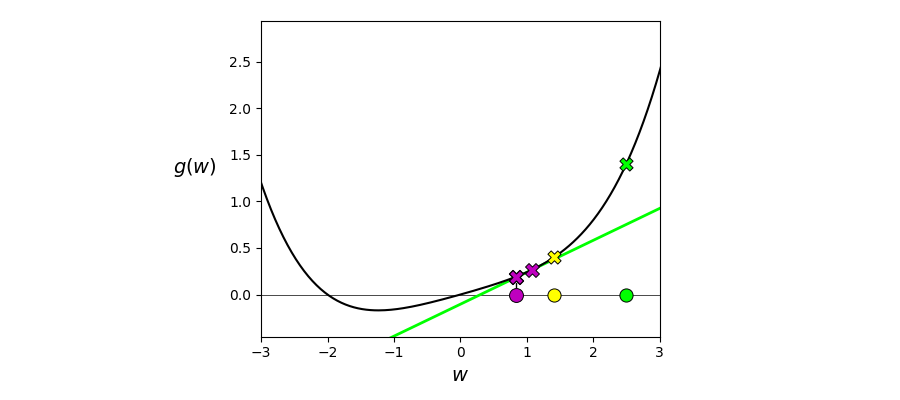
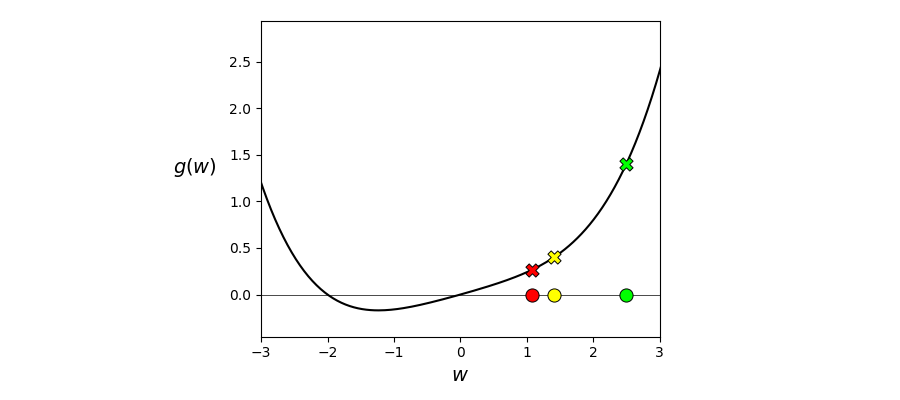

In [15]:
# what function should we play with?  Defined in the next line.
g = lambda w: 1/float(50)*(w**4 + w**2 + 10*w)   # try other functions too!  Like g = lambda w: np.cos(2*w) , g = lambda w: np.sin(5*w) + 0.1*w**2, g = lambda w: np.cos(5*w)*np.sin(w)

# run the visualizer for our chosen input function, initial point, and step length alpha
demo = optlib.gradient_descent_demos.visualizer();

demo.draw_it_gradient_descent(g=g, w_init = 2.5,alpha = 0.7,max_its = 2);

## 1.1  The basic idea

In the previous post we described how - at a high level - all mathematical algorithms find the global minimum of a function by iteratively taking steps that decrease the value of a function as the algorithm runs.  However determining which direction to travel in order to decrease the value of a function - at least by examining the function directly - is no simple matter in general.  This is because a function that takes in $N$ inputs.

All of these algorithms share one common feature: because it is very difficult to determine which 

The defining characteristic distinguishing various mathematical optimization schemes is then the way these iterative steps are taken in reducing the value of $g$.

Gradient descent is an algorithm designed to do this by repeatedly employing the first order Taylor Series approximation of a function.  As described in our *Vital Elements of Calculus* series the first order Taylor Series approximation provides a local linear approximation (a tangent line or hyperplane) of a function centered about a given point.  

With gradient descent in short we repeatedly form this linear approximation  


As illustrated in Figure the basic idea with gradient descent is to build a linear model of the function $g$, determine the 'downward' direction on this hyperplane, travel a short distance along this direction, hop back on to the function $g$, and repeat until convergence. Starting at an initial point $\mathbf{w}^{0}$ and by carefully choosing how far we travel at each step, the gradient descent procedure produces a sequence of points $\mathbf{w}^{1},\,\mathbf{w}^{2},\,\mathbf{w}^{3}...$, that shrinks the value of $g$ at each step and eventually reaches a stationary point of $g$. 

<IPython.core.display.Javascript object>


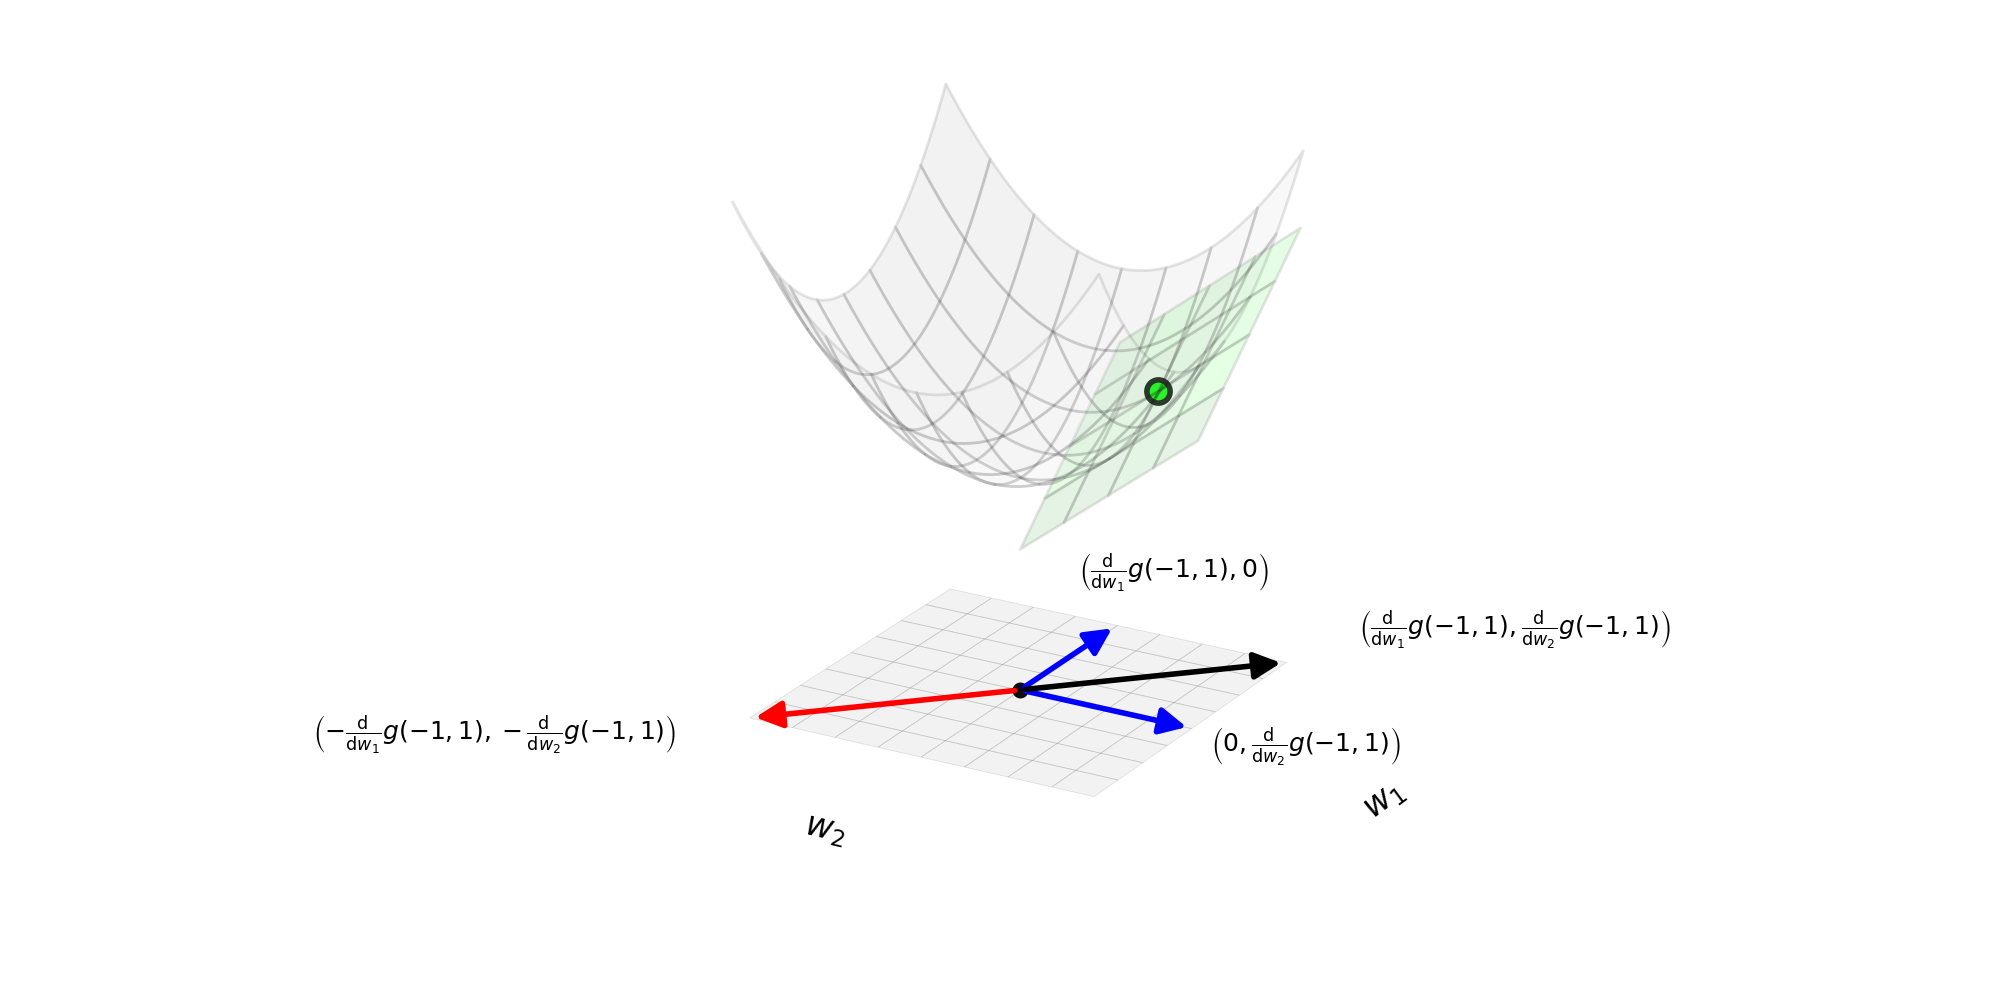

In [2]:
# define function, and points at which to take derivative
func = lambda w:  (w[0])**2 + (w[1])**2 + 6
pt1 = [-1,1];

# animate 2d slope visualizer
view = [33,30]
calib.derivative_ascent_visualizer.visualize3d(func=func,view = view,pt1 = pt1,plot_descent = True)